In [35]:
import glob
import pandas as pd
import sklearn.preprocessing as PP
import sklearn.model_selection as MS
import sklearn.linear_model as LM
import sklearn.metrics as MT
import matplotlib.pyplot as plt
import sklearn.feature_selection as FS
from sklearn.svm import LinearSVR, SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import numpy as np

# Load data

In [24]:
import networkx as nx
import json
data = json.load(open('river_network.json', 'r'))
river_network = nx.node_link_graph(data)

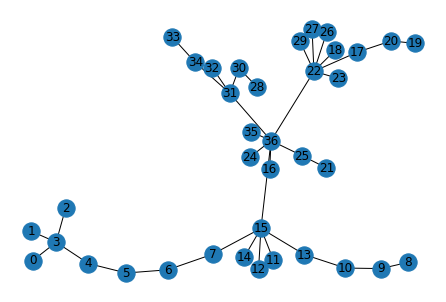

In [25]:
nx.draw(river_network, with_labels=True)

In [6]:
# data = {}

# for file in glob.glob('data/monitordata/dam_*.csv'):
#     name = 'dam_' + file[file.find('_') + 1: file.find('.')]
#     df = pd.read_csv(file)
#     df.Date = pd.to_datetime(df.Date)
#     df = df.set_index('Date').sort_index()
#     df = df.rename(columns = {'WaterArea': 'Data'})
#     data[name] = df

# ddams = pd.concat([df.Data for df in data.values()], axis = 1)
# ddams.columns = data.keys()
# ddams = ddams.fillna(method = 'backfill').dropna()

# for file in glob.glob('data/monitordata/rw_*.csv'):
#     name = 'rw_' + file[file.find('_') + 1: file.find('.')]
#     df = pd.read_csv(file)
#     df.Date = pd.to_datetime(df.Date)
#     df = df.set_index('Date').sort_index()
#     df = df.rename(columns = {'Daily runoff (mm)': 'Data'})
#     data[name] = df

# drw = pd.concat([value.Data for key, value in data.items() if key.startswith('rw')], axis = 1)
# drw.columns = [key for key in data if key.startswith('rw')]
# drw = drw.dropna()

# df = pd.concat([ddams, drw], axis = 1).dropna()
# df

In [26]:
# df.to_csv('data.csv')
df = pd.read_csv('data.csv', index_col = 'Date')

# Transform data using Standard Scaler

In [8]:
scaler = PP.StandardScaler().fit(df)
df_transformed = pd.DataFrame(data = scaler.transform(df), columns = df.columns)

# Survey data

In [64]:
def apply_regressor(X, Y, regressor, param_grid):
    X = np.array(X)
    Y = np.array(Y)
    scores = []
    tscv = MS.TimeSeriesSplit(n_splits = 5)
    model = MS.GridSearchCV(regressor, param_grid = param_grid, scoring = 'r2', cv = tscv.split(X))
    model.fit(X, Y)
    display(pd.DataFrame(model.cv_results_).drop(columns = ['params']))
    return model.best_score_
def survey(df, outCol, inpCols, regressors, period = 15, future = 1):
    outCol = df[outCol].values.reshape(-1)
    inpCols = df[inpCols].values
    X, Y = [], []
    for i in range(len(df) - (period + future - 1)):
        X.append(inpCols[i:i + period,:].reshape(-1))
        Y.append(outCol[i + future + period - 1])
    res = {}
    for name, regressor, param_grid in regressors:
        print('>>> Regressor:', name)
        res[name] = [apply_regressor(X, Y, regressor, param_grid)]
    return pd.DataFrame(data = res, index = ['Score mean'])

## Regressors

In [76]:
estimators = [
    ('lr', LM.Ridge(1)),
    ('svr', SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False))
]
stacking = StackingRegressor(estimators=estimators, final_estimator=AdaBoostRegressor(n_estimators=50))

regressors = [
              ('Ridge', LM.Ridge(), dict(alpha = [0, 0.5, 1, 2, 10], tol = [0.0001])),
#               ('Adaboost', AdaBoostRegressor(n_estimators=100, base_estimator=DecisionTreeRegressor(max_depth=4))),
              ('SVR', SVR(), dict(C=[0.1, 1, 10], cache_size=[2000], degree=[2, 3], epsilon=[0.1, 1], kernel=['linear', 'rbf', 'poly',])),
#                 ('SVR', SVR(), dict(C=[1], cache_size=[2000], coef0=[0.0], degree=[1], epsilon=[0.1], gamma=['auto'], kernel=['linear'], tol=[0.01])),
#               ('Stacking', stacking)
             ]

period = 15, future = 10, Node: dam_Haixihai, neighbors: ['dam_Xiaowan']


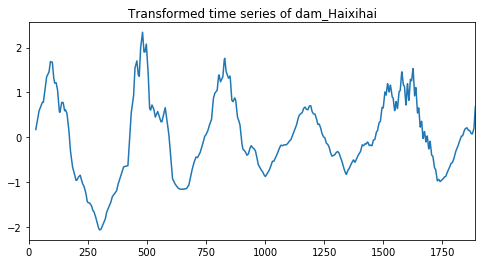

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004232      0.002627         0.000619        0.000141           0    0.0001           0.517066           0.659027           0.760314           0.557853           0.443967         0.587646        0.110835                5
1       0.003422      0.001427         0.000677        0.000075         0.5    0.0001           0.517279           0.659315           0.760331           0.558168           0.443963         0.587811        0.110834                4
2       0.003407      0.001427         0.000640        0.000038           1    0.0001           0.517314           0.659588           0.760345           0.558475           0.443953         0.587935        0.110856                3
3       0.003759      0.001585         0.000719        0.000049           2    0.0001           0.517114           0.660097           0.760369           0.559066           0.443916         0.588112        0.110934                2
4       0.002381      0.001266         0.000831        0.000297          10    0.0001           0.512438           0.663079           0.760411           0.563041           0.443117         0.588417        0.111969                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.098590      0.068862         0.003833        0.001171     0.1             2000            2           0.1       linear           0.514255           0.634479           0.769433           0.530228           0.441098         0.577899        0.113951               11
1        0.054973      0.038038         0.007683        0.002590     0.1             2000            2           0.1          rbf           0.403996           0.720703           0.780713           0.578823           0.477989         0.592445        0.141911                5
2        0.053690      0.041293         0.004740        0.002422     0.1             2000            2           0.1         poly          -0.616942          -0.726732           0.034085          -0.283270          -0.035685        -0.325709        0.303646               30
3        0.034228      0.019849         0.000961        0.000225     0.1             2000            2             1       linear           0.463642           0.681559           0.656951           0.585889           0.410839         0.559776        0.106188               17
4        0.009677      0.005383         0.001638        0.000234     0.1             2000            2             1          rbf           0.363217           0.711118           0.628791           0.605866           0.367710         0.535341        0.143060               19
5        0.017995      0.012013         0.001540        0.000361     0.1             2000            2             1         poly          -0.134269          -0.171802           0.035888          -0.028631           0.148822        -0.029998        0.116018               27
6        0.086992      0.064463         0.003068        0.001283     0.1             2000            3           0.1       linear           0.514255           0.634479           0.769433           0.530228           0.441098         0.577899        0.113951               11
7        0.051908      0.040630         0.007276        0.003679     0.1             2000            3           0.1          rbf           0.403996           0.720703           0.780713           0.578823           0.477989         0.592445        0.141911                5
8        0.071348      0.052312         0.004916        0.001755     0.1             2000            3           0.1         poly          -0.968348           0.294352           0.218974           0.300574          -0.826073        -0.196104        0.574934               29
9        0.031618      0.018476         0.000858        0.000220     0.1             2000            3             1       linear           0.463642           0.681559           0.656951           0.585889           0.410839         0.559776        0.106188               17
10       0.009590      0.005800         0.001585        0.000455     0.1             2000            3             1          rbf           0.363217           0.711118           0.628791           0.605866           0.367710         0.535341        0.143060               19
11       0.031523      0.021452         0.001140        0.000333     0.1             2000            3             1         poly          -0.346799           0.425047           0.067291           0.240079          -0.170427         0.043038        0.276725               26
12       0.336938      0.235118         0.003218        0.001234       1             2000            2           0.1       linear           0.498327           0.630780           0.769685           0.522275           0.433301         0.570874        0.118039               15
13       0.063243      0.045934         0.006788        0.003052       1             2000            2           0.1          rbf           0.555707      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001335      0.000253         0.000657        0.000027           0    0.0001           0.397007           0.672413           0.762152           0.594439           0.454459         0.576094        0.134981                5
1       0.001853      0.001101         0.000629        0.000013         0.5    0.0001           0.399793           0.673245           0.762371           0.594955           0.454553         0.576983        0.134420                4
2       0.001305      0.000209         0.000625        0.000004           1    0.0001           0.401657           0.673956           0.762562           0.595444           0.454638         0.577651        0.134082                3
3       0.001303      0.000205         0.000629        0.000008           2    0.0001           0.404180           0.675136           0.762877           0.596357           0.454782         0.578666        0.133675                2
4       0.001309      0.000196         0.000625        0.000006          10    0.0001           0.411055           0.680731           0.764022           0.601813           0.455325         0.582589        0.133071                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.132600      0.086957         0.007131        0.002217     0.1             2000            2           0.1       linear           0.325556           0.674908           0.747874           0.603725           0.471322         0.564677        0.150420                7
1        0.067771      0.051804         0.010822        0.004754     0.1             2000            2           0.1          rbf           0.404785           0.725197           0.770070           0.644496           0.469460         0.602802        0.142610                1
2        0.056024      0.042990         0.007533        0.003293     0.1             2000            2           0.1         poly          -0.189117          -0.538483          -0.511382          -0.470018          -0.041735        -0.350147        0.198436               32
3        0.033732      0.017822         0.001259        0.000309     0.1             2000            2             1       linear           0.434834           0.631195           0.626815           0.506601           0.427615         0.525412        0.088989               13
4        0.011025      0.006660         0.002060        0.000542     0.1             2000            2             1          rbf           0.400166           0.641423           0.617373           0.575564           0.414239         0.529753        0.102355               11
5        0.022352      0.015480         0.002528        0.000709     0.1             2000            2             1         poly          -0.170552          -0.153418           0.096201          -0.169543           0.120895        -0.055283        0.134134               27
6        0.122486      0.090430         0.006254        0.003117     0.1             2000            3           0.1       linear           0.325556           0.674908           0.747874           0.603725           0.471322         0.564677        0.150420                7
7        0.067502      0.051637         0.010899        0.004935     0.1             2000            3           0.1          rbf           0.404785           0.725197           0.770070           0.644496           0.469460         0.602802        0.142610                1
8        0.070831      0.052159         0.007607        0.003303     0.1             2000            3           0.1         poly          -1.079741           0.235656          -0.037336           0.400114          -0.032799        -0.102821        0.515960               28
9        0.032986      0.017610         0.001210        0.000336     0.1             2000            3             1       linear           0.434834           0.631195           0.626815           0.506601           0.427615         0.525412        0.088989               13
10       0.011497      0.007002         0.002078        0.000547     0.1             2000            3             1          rbf           0.400166           0.641423           0.617373           0.575564           0.414239         0.529753        0.102355               11
11       0.024020      0.017075         0.001906        0.000547     0.1             2000            3             1         poly          -0.168436           0.383782           0.203310           0.309422           0.147014         0.175019        0.190364               23
12       0.609659      0.482844         0.006067        0.002741       1             2000            2           0.1       linear           0.341590           0.671844           0.748834           0.591225           0.469950         0.564688        0.144806                5
13       0.074462      0.054393         0.009474        0.004451       1             2000            2           0.1          rbf           0.475211      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000982      0.000261         0.000567        0.000130           0    0.0001           0.231444           0.379029           0.474620           0.559516           0.362794         0.401481        0.110668                5
1       0.001120      0.000175         0.000619        0.000011         0.5    0.0001           0.231821           0.379401           0.474805           0.559674           0.362842         0.401709        0.110604                4
2       0.001069      0.000116         0.000620        0.000018           1    0.0001           0.232163           0.379752           0.474984           0.559825           0.362888         0.401923        0.110548                3
3       0.001071      0.000122         0.000608        0.000009           2    0.0001           0.232766           0.380400           0.475328           0.560111           0.362976         0.402316        0.110458                2
4       0.001083      0.000165         0.000607        0.000009          10    0.0001           0.235737           0.383873           0.477570           0.561764           0.363472         0.404483        0.110146                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.081375      0.047393         0.003991        0.000913     0.1             2000            2           0.1       linear           0.243389           0.365481           0.267513           0.569048           0.370177         0.363122        0.114837               11
1        0.061999      0.051819         0.008587        0.004652     0.1             2000            2           0.1          rbf           0.368134           0.219461          -0.026602           0.402064           0.396748         0.271961        0.163489               17
2        0.044963      0.035504         0.004488        0.001879     0.1             2000            2           0.1         poly          -0.387775          -0.409685          -0.735264          -0.651012          -0.039504        -0.444648        0.243163               33
3        0.032056      0.018708         0.000906        0.000256     0.1             2000            2             1       linear           0.151970           0.323688           0.685843           0.565969           0.369513         0.419396        0.187426                3
4        0.013897      0.008880         0.001956        0.000583     0.1             2000            2             1          rbf           0.378331           0.177928           0.720545           0.464948           0.401028         0.428556        0.174744                1
5        0.018019      0.011065         0.001802        0.000489     0.1             2000            2             1         poly          -0.549912          -0.036362           0.035837          -0.211084          -0.029989        -0.158302        0.212211               31
6        0.073201      0.053810         0.003452        0.001440     0.1             2000            3           0.1       linear           0.243389           0.365481           0.267513           0.569048           0.370177         0.363122        0.114837               11
7        0.065929      0.047160         0.009214        0.003835     0.1             2000            3           0.1          rbf           0.368134           0.219461          -0.026602           0.402064           0.396748         0.271961        0.163489               17
8        0.076275      0.056758         0.004541        0.001956     0.1             2000            3           0.1         poly           0.198545           0.138705          -0.622401           0.353638           0.180403         0.049778        0.343877               28
9        0.034359      0.019356         0.001030        0.000292     0.1             2000            3             1       linear           0.151970           0.323688           0.685843           0.565969           0.369513         0.419396        0.187426                3
10       0.013628      0.008459         0.002011        0.000655     0.1             2000            3             1          rbf           0.378331           0.177928           0.720545           0.464948           0.401028         0.428556        0.174744                1
11       0.029813      0.019608         0.001281        0.000291     0.1             2000            3             1         poly           0.007150           0.266836           0.179799           0.502007           0.248464         0.240851        0.159549               20
12       0.247759      0.207492         0.003644        0.001549       1             2000            2           0.1       linear           0.237442           0.362602           0.278706           0.567052           0.368851         0.362931        0.113615               13
13       0.067925      0.047312         0.008085        0.003864       1             2000            2           0.1          rbf           0.350702      

>>> Final results:



period = 15, future = 10, Node: dam_Zibihe, neighbors: ['dam_Xiaowan']


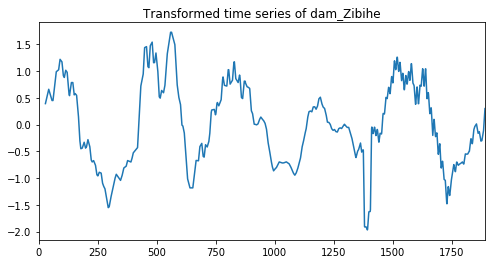

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001605      0.000845         0.000604        0.000132           0    0.0001           0.503112           0.345289           0.621749           0.042948           0.466869         0.395993        0.197320                5
1       0.001711      0.000824         0.000681        0.000042         0.5    0.0001           0.503039           0.345813           0.621742           0.043474           0.466834         0.396180        0.197092                4
2       0.001139      0.000108         0.000637        0.000023           1    0.0001           0.502898           0.346303           0.621735           0.043982           0.466799         0.396343        0.196866                3
3       0.001155      0.000169         0.000627        0.000014           2    0.0001           0.502520           0.347195           0.621717           0.044945           0.466727         0.396621        0.196426                2
4       0.001702      0.001227         0.000615        0.000007          10    0.0001           0.499059           0.352064           0.621484           0.050915           0.466099         0.397924        0.193584                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.078431      0.042422         0.003882        0.000937     0.1             2000            2           0.1       linear           0.487628           0.311064           0.600995          -0.009768           0.443429         0.366670        0.209871                3
1        0.056746      0.042230         0.007556        0.003314     0.1             2000            2           0.1          rbf           0.314796           0.381923           0.626656           0.238565           0.364337         0.385255        0.130542                1
2        0.049153      0.037020         0.004422        0.001885     0.1             2000            2           0.1         poly          -0.607044          -0.294667          -0.247419          -4.079684          -0.054225        -1.056608        1.521920               26
3        0.029373      0.020337         0.000786        0.000246     0.1             2000            2             1       linear           0.427197           0.337313           0.486152           0.137433           0.317658         0.341151        0.118741               13
4        0.010011      0.006150         0.001485        0.000450     0.1             2000            2             1          rbf           0.231367           0.285703           0.537437           0.221369           0.204865         0.296148        0.123653               17
5        0.017212      0.013280         0.001667        0.000557     0.1             2000            2             1         poly          -0.193443          -0.086368          -0.155451          -3.155867          -0.160070        -0.750240        1.203318               25
6        0.072835      0.049340         0.003573        0.001307     0.1             2000            3           0.1       linear           0.487628           0.311064           0.600995          -0.009768           0.443429         0.366670        0.209871                3
7        0.056518      0.041906         0.007621        0.003288     0.1             2000            3           0.1          rbf           0.314796           0.381923           0.626656           0.238565           0.364337         0.385255        0.130542                1
8        0.069466      0.056761         0.004275        0.001906     0.1             2000            3           0.1         poly          -0.021745           0.028770           0.129829         -93.733624           0.240542       -18.671246       37.531297               32
9        0.030222      0.020161         0.000785        0.000206     0.1             2000            3             1       linear           0.427197           0.337313           0.486152           0.137433           0.317658         0.341151        0.118741               13
10       0.010451      0.006430         0.001572        0.000481     0.1             2000            3             1          rbf           0.231367           0.285703           0.537437           0.221369           0.204865         0.296148        0.123653               17
11       0.027717      0.021244         0.001176        0.000391     0.1             2000            3             1         poly           0.089214           0.218819          -0.038413         -44.224036           0.165796        -8.757724       17.733367               31
12       0.229107      0.163014         0.003436        0.001474       1             2000            2           0.1       linear           0.489547           0.305838           0.601825          -0.015335           0.441804         0.364736        0.212439                5
13       0.067926      0.047900         0.007457        0.003388       1             2000            2           0.1          rbf           0.476316      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001358      0.000206         0.000656        0.000011           0    0.0001           0.417666           0.345899           0.705099           0.109102           0.475546         0.410662        0.192917                5
1       0.001328      0.000201         0.000645        0.000018         0.5    0.0001           0.418188           0.347907           0.705662           0.110699           0.475537         0.411599        0.192459                4
2       0.001304      0.000200         0.000632        0.000013           1    0.0001           0.418539           0.349522           0.706133           0.112193           0.475527         0.412383        0.192031                3
3       0.001304      0.000195         0.000625        0.000004           2    0.0001           0.419180           0.352077           0.706884           0.114932           0.475505         0.413716        0.191241                2
4       0.001300      0.000201         0.000640        0.000017          10    0.0001           0.423791           0.363046           0.709638           0.130495           0.475262         0.420446        0.186555                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.121975      0.078670         0.007308        0.002597     0.1             2000            2           0.1       linear           0.375173           0.367866           0.731557           0.161805           0.469251         0.421130        0.184867                3
1        0.069687      0.052977         0.011383        0.005062     0.1             2000            2           0.1          rbf           0.322775           0.390681           0.755142           0.301263           0.412425         0.436457        0.164581                1
2        0.061345      0.048925         0.007826        0.003632     0.1             2000            2           0.1         poly          -0.309416          -0.369010          -0.049346          -0.397906          -0.244058        -0.273947        0.124097               26
3        0.033457      0.020138         0.001284        0.000542     0.1             2000            2             1       linear           0.402744           0.225763           0.524194           0.023138           0.379132         0.310994        0.172418               11
4        0.013151      0.008034         0.002237        0.000740     0.1             2000            2             1          rbf           0.261987           0.159777           0.578890           0.240163           0.287974         0.305758        0.143141               13
5        0.021175      0.013495         0.002639        0.000753     0.1             2000            2             1         poly          -0.408959          -0.007268          -0.138932          -0.293109          -0.306922        -0.231038        0.141296               25
6        0.112300      0.083548         0.006511        0.003237     0.1             2000            3           0.1       linear           0.375173           0.367866           0.731557           0.161805           0.469251         0.421130        0.184867                3
7        0.072433      0.056676         0.012338        0.005897     0.1             2000            3           0.1          rbf           0.322775           0.390681           0.755142           0.301263           0.412425         0.436457        0.164581                1
8        0.076937      0.058545         0.007561        0.003121     0.1             2000            3           0.1         poly           0.266765           0.071917           0.164403          -7.423148           0.315730        -1.320867        3.052302               31
9        0.032817      0.019369         0.001176        0.000400     0.1             2000            3             1       linear           0.402744           0.225763           0.524194           0.023138           0.379132         0.310994        0.172418               11
10       0.012353      0.007502         0.002162        0.000675     0.1             2000            3             1          rbf           0.261987           0.159777           0.578890           0.240163           0.287974         0.305758        0.143141               13
11       0.022233      0.019112         0.001821        0.000536     0.1             2000            3             1         poly           0.205715           0.204790          -0.101254          -4.607383           0.225425        -0.814542        1.900311               30
12       0.541014      0.398010         0.006311        0.002800       1             2000            2           0.1       linear           0.379077           0.362908           0.721888           0.155206           0.469510         0.417718        0.183636                5
13       0.083923      0.062337         0.010882        0.005190       1             2000            2           0.1          rbf           0.425071      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001009      0.000223         0.000603        0.000042           0    0.0001           0.464840           0.189291           0.490013           0.261419           0.413400         0.363793        0.117927                5
1       0.001103      0.000114         0.000629        0.000014         0.5    0.0001           0.464815           0.189696           0.490023           0.261546           0.413363         0.363889        0.117780                4
2       0.001092      0.000110         0.000616        0.000017           1    0.0001           0.464777           0.190081           0.490028           0.261670           0.413325         0.363976        0.117636                3
3       0.001068      0.000119         0.000606        0.000010           2    0.0001           0.464672           0.190799           0.490027           0.261907           0.413246         0.364130        0.117358                2
4       0.001069      0.000111         0.000605        0.000005          10    0.0001           0.463395           0.194906           0.489639           0.263417           0.412514         0.364774        0.115520                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.078340      0.042489         0.004248        0.000836     0.1             2000            2           0.1       linear           0.457556           0.260412           0.532016           0.257401           0.394495         0.380376        0.108319                1
1        0.054732      0.041509         0.007478        0.003274     0.1             2000            2           0.1          rbf           0.339743           0.061343           0.568127           0.235643           0.308794         0.302730        0.164080                7
2        0.042044      0.032930         0.004186        0.001874     0.1             2000            2           0.1         poly          -0.379546          -0.367356           0.011914          -0.130470          -0.124346        -0.197961        0.152112               32
3        0.021127      0.013340         0.000755        0.000178     0.1             2000            2             1       linear           0.435088           0.022572           0.284615           0.251825           0.324024         0.263625        0.135450                9
4        0.011010      0.006526         0.001653        0.000487     0.1             2000            2             1          rbf           0.272893          -0.186498           0.222342           0.216915           0.241656         0.153461        0.171105               24
5        0.014828      0.009891         0.001554        0.000447     0.1             2000            2             1         poly          -0.688468          -0.035492          -0.195193           0.013388          -0.221923        -0.225538        0.248371               34
6        0.066384      0.045483         0.003253        0.001394     0.1             2000            3           0.1       linear           0.457556           0.260412           0.532016           0.257401           0.394495         0.380376        0.108319                1
7        0.054988      0.044556         0.007409        0.003562     0.1             2000            3           0.1          rbf           0.339743           0.061343           0.568127           0.235643           0.308794         0.302730        0.164080                7
8        0.064950      0.047451         0.004319        0.001984     0.1             2000            3           0.1         poly           0.290373           0.108583           0.095869           0.196488           0.250647         0.188392        0.076513               20
9        0.021725      0.013004         0.000833        0.000205     0.1             2000            3             1       linear           0.435088           0.022572           0.284615           0.251825           0.324024         0.263625        0.135450                9
10       0.011104      0.006919         0.001665        0.000471     0.1             2000            3             1          rbf           0.272893          -0.186498           0.222342           0.216915           0.241656         0.153461        0.171105               24
11       0.022535      0.013608         0.001289        0.000307     0.1             2000            3             1         poly           0.254535           0.134425          -0.117584           0.213859           0.175053         0.132058        0.131048               28
12       0.240841      0.156036         0.003628        0.001700       1             2000            2           0.1       linear           0.453282           0.255507           0.536095           0.253183           0.393561         0.378326        0.110894                5
13       0.065489      0.047412         0.007426        0.003476       1             2000            2           0.1          rbf           0.387967      

>>> Final results:



period = 15, future = 10, Node: dam_Gongguoqiao, neighbors: ['dam_Xiaowan']


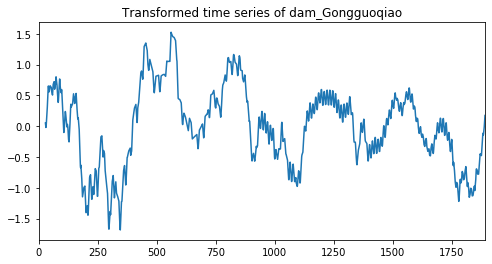

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001132      0.000372         0.000597        0.000102           0    0.0001           0.195098           0.462797           0.533215           0.555848           0.406989         0.430790        0.129052                5
1       0.001158      0.000163         0.000635        0.000021         0.5    0.0001           0.195251           0.462750           0.533201           0.555824           0.407011         0.430807        0.128986                4
2       0.001836      0.001579         0.000653        0.000075           1    0.0001           0.195399           0.462702           0.533185           0.555799           0.407032         0.430824        0.128922                3
3       0.001168      0.000089         0.000622        0.000008           2    0.0001           0.195682           0.462605           0.533154           0.555748           0.407074         0.430852        0.128797                2
4       0.001158      0.000155         0.000672        0.000075          10    0.0001           0.197486           0.461763           0.532853           0.555291           0.407344         0.430947        0.127951                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.085649      0.045658         0.003867        0.000814     0.1             2000            2           0.1       linear           0.196294           0.473642           0.495057           0.509580           0.345773         0.404069        0.119013                3
1        0.052592      0.039861         0.007608        0.003156     0.1             2000            2           0.1          rbf           0.179372           0.460430           0.471428           0.539118           0.394248         0.408919        0.123628                1
2        0.064158      0.056390         0.005797        0.002924     0.1             2000            2           0.1         poly          -0.515463           0.000482          -0.208629           0.093830          -1.000148        -0.325985        0.396736               36
3        0.037398      0.017987         0.001329        0.000177     0.1             2000            2             1       linear           0.203915           0.370185           0.510892           0.492563           0.432549         0.402021        0.110673                5
4        0.015221      0.009407         0.002426        0.000535     0.1             2000            2             1          rbf           0.005254           0.211380           0.367581           0.351460           0.386781         0.264491        0.143646               19
5        0.017950      0.012760         0.001697        0.000467     0.1             2000            2             1         poly          -0.758252          -0.092343          -0.034342           0.086060          -0.293041        -0.218384        0.296471               35
6        0.077251      0.053783         0.003234        0.001307     0.1             2000            3           0.1       linear           0.196294           0.473642           0.495057           0.509580           0.345773         0.404069        0.119013                3
7        0.054763      0.042023         0.007822        0.003335     0.1             2000            3           0.1          rbf           0.179372           0.460430           0.471428           0.539118           0.394248         0.408919        0.123628                1
8        0.061759      0.049409         0.004290        0.001798     0.1             2000            3           0.1         poly          -0.174679           0.225245           0.147737           0.358598           0.016962         0.114773        0.182258               27
9        0.033133      0.018320         0.001029        0.000214     0.1             2000            3             1       linear           0.203915           0.370185           0.510892           0.492563           0.432549         0.402021        0.110673                5
10       0.015551      0.009952         0.002454        0.000570     0.1             2000            3             1          rbf           0.005254           0.211380           0.367581           0.351460           0.386781         0.264491        0.143646               19
11       0.028444      0.021319         0.001417        0.000334     0.1             2000            3             1         poly          -0.112841           0.052653           0.196668           0.173461           0.143275         0.090643        0.112888               28
12       0.299723      0.210354         0.003278        0.001267       1             2000            2           0.1       linear           0.181638           0.470048           0.493693           0.508683           0.343094         0.399431        0.123625               13
13       0.069118      0.049805         0.007672        0.003289       1             2000            2           0.1          rbf           0.104686      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001298      0.000281         0.000649        0.000022           0    0.0001           0.229719           0.427865           0.471140           0.430116           0.377206         0.387209        0.084192                5
1       0.001342      0.000201         0.000641        0.000011         0.5    0.0001           0.230663           0.428246           0.471315           0.430440           0.377234         0.387580        0.083943                4
2       0.001300      0.000198         0.000636        0.000007           1    0.0001           0.231468           0.428604           0.471486           0.430755           0.377261         0.387915        0.083743                3
3       0.001305      0.000207         0.000627        0.000007           2    0.0001           0.232791           0.429260           0.471814           0.431357           0.377314         0.388507        0.083438                2
4       0.001298      0.000208         0.000629        0.000006          10    0.0001           0.238184           0.432789           0.473920           0.435229           0.377644         0.391553        0.082593                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.123994      0.072608         0.007295        0.001568     0.1             2000            2           0.1       linear           0.212492           0.480755           0.513372           0.525521           0.343841         0.415196        0.120240                1
1        0.069791      0.051725         0.011984        0.004799     0.1             2000            2           0.1          rbf           0.098721           0.413219           0.464061           0.564050           0.380256         0.384061        0.155615                7
2        0.055715      0.043343         0.007713        0.003457     0.1             2000            2           0.1         poly          -0.476937           0.025416          -0.096261           0.040900          -0.648798        -0.231136        0.280312               35
3        0.039235      0.023135         0.001951        0.000540     0.1             2000            2             1       linear           0.218765           0.353833           0.346385          -0.040230           0.183691         0.212489        0.143277               12
4        0.022843      0.013426         0.004121        0.000928     0.1             2000            2             1          rbf          -0.109514           0.232505           0.373509           0.168476           0.292912         0.191578        0.165065               14
5        0.022334      0.015468         0.003251        0.000957     0.1             2000            2             1         poly          -0.949689          -0.135811           0.022501           0.052740          -0.166598        -0.235371        0.367259               36
6        0.115535      0.078323         0.006366        0.002498     0.1             2000            3           0.1       linear           0.212492           0.480755           0.513372           0.525521           0.343841         0.415196        0.120240                1
7        0.076499      0.058418         0.012802        0.005584     0.1             2000            3           0.1          rbf           0.098721           0.413219           0.464061           0.564050           0.380256         0.384061        0.155615                7
8        0.078859      0.061309         0.008295        0.003670     0.1             2000            3           0.1         poly           0.025607           0.259940           0.034583           0.172043           0.040778         0.106590        0.093675               24
9        0.041997      0.023037         0.002101        0.000453     0.1             2000            3             1       linear           0.218765           0.353833           0.346385          -0.040230           0.183691         0.212489        0.143277               12
10       0.020991      0.012887         0.003989        0.000779     0.1             2000            3             1          rbf          -0.109514           0.232505           0.373509           0.168476           0.292912         0.191578        0.165065               14
11       0.029937      0.023346         0.002718        0.000670     0.1             2000            3             1         poly          -0.062376           0.006047           0.088797           0.137568           0.106375         0.055282        0.073174               27
12       0.600613      0.450662         0.007196        0.003124       1             2000            2           0.1       linear           0.202823           0.481133           0.509458           0.524300           0.342746         0.412092        0.122833                3
13       0.085301      0.061549         0.011618        0.004975       1             2000            2           0.1          rbf           0.047663      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000952      0.000107         0.000576        0.000045           0    0.0001           0.075148           0.188696           0.012539          -0.627344          -0.086276        -0.087447        0.284317                5
1       0.000860      0.000098         0.000523        0.000020         0.5    0.0001           0.077156           0.189549           0.012791          -0.626463          -0.086368        -0.086667        0.284396                4
2       0.000869      0.000075         0.000543        0.000003           1    0.0001           0.078925           0.190354           0.013038          -0.625621          -0.086462        -0.085953        0.284454                3
3       0.000871      0.000084         0.000541        0.000005           2    0.0001           0.081904           0.191840           0.013517          -0.624045          -0.086654        -0.084688        0.284526                2
4       0.000869      0.000082         0.000539        0.000003          10    0.0001           0.093514           0.200132           0.016804          -0.615065          -0.088367        -0.078596        0.284362                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.071820      0.041743         0.006201        0.004062     0.1             2000            2           0.1       linear          -0.128178           0.234152          -0.014972          -0.335403          -0.276488        -0.104178        0.203055               11
1        0.059482      0.046044         0.008476        0.003980     0.1             2000            2           0.1          rbf          -0.023740           0.235039          -0.020059          -0.277484          -0.141202        -0.045489        0.168996                1
2        0.043903      0.032804         0.004382        0.001831     0.1             2000            2           0.1         poly          -0.440394           0.047479          -0.123535          -0.123489          -0.681358        -0.264259        0.261456               29
3        0.036165      0.021459         0.001374        0.000405     0.1             2000            2             1       linear           0.143339           0.164180          -0.028690          -0.805753          -0.067443        -0.118873        0.355375               21
4        0.019108      0.013236         0.002984        0.000865     0.1             2000            2             1          rbf          -0.280817           0.073482           0.007932          -0.326307          -0.005972        -0.106336        0.163888               15
5        0.019044      0.014358         0.001766        0.000540     0.1             2000            2             1         poly          -0.919100          -0.087760          -0.000214          -0.045560          -0.289760        -0.268479        0.340023               30
6        0.061988      0.041703         0.003451        0.001491     0.1             2000            3           0.1       linear          -0.128178           0.234152          -0.014972          -0.335403          -0.276488        -0.104178        0.203055               11
7        0.059023      0.046302         0.008233        0.003709     0.1             2000            3           0.1          rbf          -0.023740           0.235039          -0.020059          -0.277484          -0.141202        -0.045489        0.168996                1
8        0.061413      0.046428         0.004261        0.001864     0.1             2000            3           0.1         poly          -0.070426           0.186870          -0.093854          -0.274946          -0.497685        -0.150008        0.227799               28
9        0.035831      0.021238         0.001351        0.000388     0.1             2000            3             1       linear           0.143339           0.164180          -0.028690          -0.805753          -0.067443        -0.118873        0.355375               21
10       0.019139      0.013322         0.002930        0.000901     0.1             2000            3             1          rbf          -0.280817           0.073482           0.007932          -0.326307          -0.005972        -0.106336        0.163888               15
11       0.028618      0.023947         0.001828        0.000605     0.1             2000            3             1         poly          -0.117024           0.012655           0.001275          -0.331237          -0.155076        -0.117882        0.125014               20
12       0.213289      0.158271         0.003604        0.001511       1             2000            2           0.1       linear          -0.132995           0.221352          -0.012931          -0.334617          -0.268374        -0.105513        0.197575               13
13       0.067423      0.049266         0.007932        0.003642       1             2000            2           0.1          rbf          -0.265863      

>>> Final results:



period = 15, future = 10, Node: dam_Xiaowan, neighbors: ['dam_Haixihai', 'dam_Zibihe', 'dam_Gongguoqiao', 'dam_Manwan']


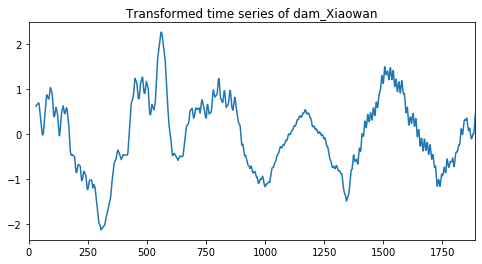

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000625      0.000044         0.000358        0.000063           0    0.0001           0.259869           0.347104           0.724335           0.692094           0.401448         0.484970        0.188069                5
1       0.000804      0.000256         0.000423        0.000124         0.5    0.0001           0.260091           0.347507           0.724321           0.692077           0.401547         0.485109        0.187941                4
2       0.000611      0.000108         0.000361        0.000059           1    0.0001           0.260285           0.347892           0.724304           0.692058           0.401643         0.485236        0.187821                3
3       0.000608      0.000069         0.000343        0.000061           2    0.0001           0.260606           0.348615           0.724259           0.692014           0.401827         0.485464        0.187601                2
4       0.000582      0.000045         0.000329        0.000046          10    0.0001           0.261827           0.352961           0.723581           0.691445           0.402976         0.486558        0.186278                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.072998      0.045405         0.003831        0.000869     0.1             2000            2           0.1       linear           0.202820           0.402426           0.701449           0.703193           0.357857         0.473549        0.198198                1
1        0.055173      0.041120         0.007455        0.003165     0.1             2000            2           0.1          rbf          -0.263146           0.406055           0.694115           0.607813           0.290873         0.347142        0.336876               13
2        0.044499      0.035684         0.004329        0.002063     0.1             2000            2           0.1         poly          -1.174832          -0.315844           0.086508          -0.382170          -0.249118        -0.407091        0.416406               31
3        0.031319      0.016745         0.000837        0.000197     0.1             2000            2             1       linear           0.220410           0.301960           0.659441           0.695771           0.330193         0.441555        0.196415                7
4        0.014290      0.009396         0.002150        0.000743     0.1             2000            2             1          rbf           0.036941           0.331648           0.370027           0.642776           0.196203         0.315519        0.201082               15
5        0.016008      0.010724         0.001801        0.000558     0.1             2000            2             1         poly          -1.589438           0.004013          -0.134270          -0.122931          -0.484493        -0.465424        0.584997               33
6        0.067491      0.048046         0.003050        0.001280     0.1             2000            3           0.1       linear           0.202820           0.402426           0.701449           0.703193           0.357857         0.473549        0.198198                1
7        0.055276      0.041948         0.007427        0.003209     0.1             2000            3           0.1          rbf          -0.263146           0.406055           0.694115           0.607813           0.290873         0.347142        0.336876               13
8        0.065642      0.049954         0.004200        0.001804     0.1             2000            3           0.1         poly           0.125483          -0.038421           0.225810           0.447931           0.284640         0.209089        0.162040               25
9        0.031790      0.017277         0.000859        0.000213     0.1             2000            3             1       linear           0.220410           0.301960           0.659441           0.695771           0.330193         0.441555        0.196415                7
10       0.013859      0.008848         0.002072        0.000660     0.1             2000            3             1          rbf           0.036941           0.331648           0.370027           0.642776           0.196203         0.315519        0.201082               15
11       0.032361      0.021033         0.001354        0.000428     0.1             2000            3             1         poly           0.124881           0.099636           0.097786           0.444240           0.196978         0.192704        0.130812               26
12       0.255304      0.176679         0.003165        0.001204       1             2000            2           0.1       linear           0.195374           0.397816           0.700697           0.705371           0.356527         0.471157        0.201057                3
13       0.086935      0.061624         0.009181        0.003553       1             2000            2           0.1          rbf          -0.084520      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.007807      0.005757         0.002519        0.003173           0    0.0001          -0.026153           0.210699           0.649629           0.618009           0.381752         0.366787        0.253812                5
1       0.003719      0.002974         0.000750        0.000168         0.5    0.0001           0.018863           0.212404           0.649741           0.620942           0.381975         0.376785        0.240530                4
2       0.005991      0.004177         0.000668        0.000012           1    0.0001           0.035668           0.213705           0.649768           0.623050           0.382173         0.380873        0.235825                3
3       0.003457      0.002043         0.000672        0.000013           2    0.0001           0.050734           0.215612           0.649705           0.626032           0.382509         0.384918        0.231775                2
4       0.002297      0.000608         0.000676        0.000037          10    0.0001           0.066118           0.221077           0.648006           0.635083           0.383782         0.390813        0.228080                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.275107      0.165666         0.015893        0.006877     0.1             2000            2           0.1       linear           0.073917           0.349448           0.703545           0.695918           0.356654         0.435896        0.238339                1
1        0.112618      0.084734         0.023652        0.010013     0.1             2000            2           0.1          rbf          -0.332771           0.165794           0.619475           0.565144           0.354748         0.274478        0.343662                9
2        0.099599      0.078063         0.019122        0.009253     0.1             2000            2           0.1         poly          -1.328263          -0.357673           0.057273          -0.360093          -0.173727        -0.432496        0.473302               30
3        0.054704      0.028367         0.003587        0.001096     0.1             2000            2             1       linear           0.067591          -0.549790           0.458652           0.501738           0.306112         0.156861        0.384608               13
4        0.029641      0.020364         0.006459        0.002503     0.1             2000            2             1          rbf           0.001379           0.035957           0.096231           0.484090           0.265340         0.176600        0.178531               11
5        0.031100      0.022452         0.006131        0.002359     0.1             2000            2             1         poly          -1.652286          -0.103547          -0.513481          -0.167171          -0.417025        -0.570702        0.561745               31
6        0.262317      0.175672         0.016290        0.007226     0.1             2000            3           0.1       linear           0.073917           0.349448           0.703545           0.695918           0.356654         0.435896        0.238339                1
7        0.113654      0.087117         0.023683        0.010239     0.1             2000            3           0.1          rbf          -0.332771           0.165794           0.619475           0.565144           0.354748         0.274478        0.343662                9
8        0.103340      0.077655         0.016932        0.007650     0.1             2000            3           0.1         poly          -0.218011          -0.079458           0.183615           0.254617           0.221820         0.072517        0.187242               19
9        0.056944      0.031145         0.003649        0.001237     0.1             2000            3             1       linear           0.067591          -0.549790           0.458652           0.501738           0.306112         0.156861        0.384608               13
10       0.031506      0.021622         0.006862        0.002652     0.1             2000            3             1          rbf           0.001379           0.035957           0.096231           0.484090           0.265340         0.176600        0.178531               11
11       0.037179      0.033268         0.005070        0.002416     0.1             2000            3             1         poly          -0.213087           0.115470          -0.213396           0.268592           0.141808         0.019877        0.197258               27
12       1.826742      1.200558         0.015632        0.006533       1             2000            2           0.1       linear           0.075802           0.341130           0.694171           0.685246           0.358131         0.430896        0.233860                3
13       0.125567      0.088893         0.022444        0.009463       1             2000            2           0.1          rbf          -0.082467      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001873      0.000528         0.000685        0.000009           0    0.0001          -0.049479          -0.016461           0.014583           0.219694           0.324774         0.098622        0.146999                5
1       0.001884      0.000380         0.000658        0.000011         0.5    0.0001          -0.004707          -0.014173           0.015293           0.220730           0.324804         0.108389        0.138517                4
2       0.001859      0.000414         0.000650        0.000002           1    0.0001           0.015791          -0.012232           0.015946           0.221539           0.324823         0.113174        0.135057                3
3       0.001871      0.000397         0.000648        0.000006           2    0.0001           0.036919          -0.009019           0.017131           0.222728           0.324835         0.118519        0.131628                2
4       0.001855      0.000424         0.000655        0.000019          10    0.0001           0.070080           0.004506           0.023919           0.226186           0.324458         0.129830        0.124626                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.192989      0.118466         0.014643        0.004497     0.1             2000            2           0.1       linear          -0.015328          -0.020033          -0.061301           0.225184           0.247148         0.075134        0.132633                5
1        0.103994      0.081119         0.021100        0.010125     0.1             2000            2           0.1          rbf          -0.382726           0.060103           0.229286           0.285293           0.235591         0.085509        0.246170                3
2        0.081427      0.062108         0.014106        0.006206     0.1             2000            2           0.1         poly          -1.489507          -0.379895          -0.128662          -0.232483          -0.128489        -0.471807        0.517118               29
3        0.052383      0.032028         0.003341        0.001395     0.1             2000            2             1       linear           0.060064          -0.068952          -0.118679           0.259345           0.327749         0.091905        0.176007                1
4        0.029570      0.021572         0.005981        0.002573     0.1             2000            2             1          rbf          -0.013777          -0.062777          -0.286806           0.259352           0.259584         0.031115        0.207940               13
5        0.027356      0.022069         0.004788        0.001989     0.1             2000            2             1         poly          -1.507695          -0.167355          -0.697859          -0.179218          -0.359594        -0.582344        0.500792               30
6        0.186762      0.129645         0.012885        0.005906     0.1             2000            3           0.1       linear          -0.015328          -0.020033          -0.061301           0.225184           0.247148         0.075134        0.132633                5
7        0.102641      0.078772         0.020406        0.009195     0.1             2000            3           0.1          rbf          -0.382726           0.060103           0.229286           0.285293           0.235591         0.085509        0.246170                3
8        0.089784      0.068200         0.014391        0.006862     0.1             2000            3           0.1         poly          -0.232761          -0.070806           0.116657           0.118294           0.127815         0.011840        0.143129               17
9        0.052458      0.031772         0.003355        0.001425     0.1             2000            3             1       linear           0.060064          -0.068952          -0.118679           0.259345           0.327749         0.091905        0.176007                1
10       0.029292      0.021243         0.005959        0.002569     0.1             2000            3             1          rbf          -0.013777          -0.062777          -0.286806           0.259352           0.259584         0.031115        0.207940               13
11       0.030309      0.025071         0.003934        0.001736     0.1             2000            3             1         poly          -0.246412           0.105831          -0.267072           0.170153           0.071032        -0.033294        0.185312               22
12       0.973894      0.646069         0.012917        0.005872       1             2000            2           0.1       linear          -0.145426          -0.063905          -0.101454           0.209880           0.245041         0.028827        0.164600               15
13       0.115716      0.085364         0.019331        0.009085       1             2000            2           0.1          rbf          -0.212333      

>>> Final results:



period = 15, future = 10, Node: dam_Manwan, neighbors: ['dam_Xiaowan', 'dam_Dachaoshan']


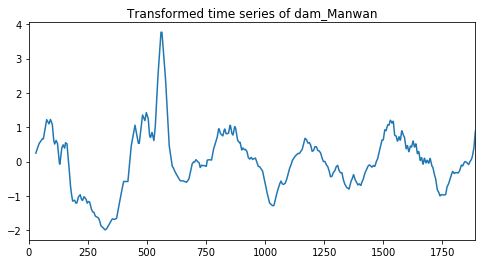

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000986      0.000266         0.000579        0.000122           0    0.0001           0.371290           0.183697           0.641446           0.541905           0.443404         0.436349        0.155771                5
1       0.001214      0.000194         0.000681        0.000049         0.5    0.0001           0.371124           0.184529           0.641356           0.542223           0.443608         0.436568        0.155536                4
2       0.001094      0.000139         0.000619        0.000013           1    0.0001           0.370939           0.185331           0.641266           0.542533           0.443808         0.436775        0.155312                3
3       0.001421      0.000499         0.000677        0.000115           2    0.0001           0.370547           0.186855           0.641084           0.543136           0.444195         0.437163        0.154891                2
4       0.001441      0.000709         0.000644        0.000034          10    0.0001           0.367875           0.196550           0.639658           0.547240           0.446849         0.439634        0.152237                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.080880      0.032005         0.003736        0.000908     0.1             2000            2           0.1       linear           0.328472           0.068230           0.624087           0.516607           0.427270         0.392933        0.189470                9
1        0.053862      0.042327         0.007361        0.003517     0.1             2000            2           0.1          rbf           0.127782           0.301370           0.589668           0.518008           0.442925         0.395951        0.164615                7
2        0.047711      0.035003         0.004441        0.001885     0.1             2000            2           0.1         poly          -4.078811          -1.487336          -0.010592          -0.093460           0.031884        -1.127663        1.581178               30
3        0.034270      0.022250         0.001020        0.000267     0.1             2000            2             1       linear           0.465563           0.257569           0.548933           0.537593           0.407770         0.443485        0.106116                5
4        0.012760      0.007524         0.001816        0.000377     0.1             2000            2             1          rbf           0.095675           0.095797           0.218281           0.517635           0.353272         0.256132        0.161683               19
5        0.024366      0.017975         0.001788        0.000525     0.1             2000            2             1         poly          -1.917598          -0.999121          -0.059889          -0.158362          -0.032644        -0.633523        0.734629               27
6        0.066309      0.044532         0.003136        0.001370     0.1             2000            3           0.1       linear           0.328472           0.068230           0.624087           0.516607           0.427270         0.392933        0.189470                9
7        0.053660      0.041597         0.007616        0.003818     0.1             2000            3           0.1          rbf           0.127782           0.301370           0.589668           0.518008           0.442925         0.395951        0.164615                7
8        0.074186      0.057769         0.004527        0.002092     0.1             2000            3           0.1         poly          -4.777349          -1.521637           0.115516           0.107775           0.090517        -1.197036        1.897742               32
9        0.034052      0.021599         0.000999        0.000230     0.1             2000            3             1       linear           0.465563           0.257569           0.548933           0.537593           0.407770         0.443485        0.106116                5
10       0.012270      0.007423         0.001807        0.000473     0.1             2000            3             1          rbf           0.095675           0.095797           0.218281           0.517635           0.353272         0.256132        0.161683               19
11       0.044063      0.029921         0.001625        0.000511     0.1             2000            3             1         poly          -4.749144          -1.010912           0.076435          -0.033127           0.067673        -1.129815        1.855016               31
12       0.243566      0.178403         0.003268        0.001427       1             2000            2           0.1       linear           0.336614           0.034221           0.626329           0.498978           0.420953         0.383419        0.198946               11
13       0.063673      0.045657         0.007272        0.003149       1             2000            2           0.1          rbf           0.316331      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001920      0.001430         0.000568        0.000022           0    0.0001           0.434086           0.168489           0.746699           0.563928           0.459754         0.474591        0.188458                5
1       0.001283      0.000220         0.002496        0.003876         0.5    0.0001           0.437766           0.178220           0.747966           0.566479           0.460287         0.478144        0.185748                4
2       0.002930      0.003498         0.002338        0.003515           1    0.0001           0.437740           0.184427           0.748840           0.568602           0.460769         0.480075        0.184198                3
3       0.004765      0.007089         0.000579        0.000039           2    0.0001           0.436534           0.192276           0.749936           0.572004           0.461613         0.482472        0.182380                2
4       0.005041      0.004649         0.000604        0.000038          10    0.0001           0.428325           0.214608           0.751555           0.584986           0.465756         0.489046        0.177573                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.168614      0.107481         0.009468        0.003745     0.1             2000            2           0.1       linear           0.312686           0.345127           0.728011           0.583308           0.452341         0.484295        0.154298                1
1        0.079813      0.061440         0.014490        0.006297     0.1             2000            2           0.1          rbf           0.100507           0.349155           0.664212           0.563630           0.421789         0.419859        0.193580                9
2        0.070393      0.054510         0.010927        0.005073     0.1             2000            2           0.1         poly          -3.288183          -1.525082           0.057228          -1.041864          -0.011341        -1.161848        1.222902               33
3        0.037847      0.019225         0.001954        0.000472     0.1             2000            2             1       linear           0.421105           0.142875           0.728061           0.551227           0.440533         0.456760        0.191095                7
4        0.018306      0.010637         0.003427        0.000790     0.1             2000            2             1          rbf           0.049478           0.097800           0.398311           0.476631           0.318695         0.268183        0.167211               17
5        0.030278      0.020200         0.004172        0.001361     0.1             2000            2             1         poly          -1.053123          -0.731728          -0.082251          -0.650103           0.021978        -0.499045        0.407221               27
6        0.163464      0.119873         0.009186        0.004273     0.1             2000            3           0.1       linear           0.312686           0.345127           0.728011           0.583308           0.452341         0.484295        0.154298                1
7        0.080766      0.062425         0.014848        0.006776     0.1             2000            3           0.1          rbf           0.100507           0.349155           0.664212           0.563630           0.421789         0.419859        0.193580                9
8        0.088516      0.068170         0.010808        0.004509     0.1             2000            3           0.1         poly          -3.071515          -0.944382           0.269603           0.487075           0.246553        -0.602533        1.332782               29
9        0.037875      0.019216         0.001929        0.000457     0.1             2000            3             1       linear           0.421105           0.142875           0.728061           0.551227           0.440533         0.456760        0.191095                7
10       0.019661      0.011508         0.003722        0.000932     0.1             2000            3             1          rbf           0.049478           0.097800           0.398311           0.476631           0.318695         0.268183        0.167211               17
11       0.033623      0.023843         0.002954        0.000815     0.1             2000            3             1         poly          -2.014711          -0.183169           0.100916           0.413137           0.199678        -0.296830        0.880092               24
12       0.844856      0.494927         0.009029        0.004126       1             2000            2           0.1       linear           0.330827           0.327896           0.728034           0.577458           0.450887         0.483021        0.153107                3
13       0.097500      0.070552         0.014872        0.006512       1             2000            2           0.1          rbf           0.249920      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001109      0.000207         0.000558        0.000024           0    0.0001           0.447360           0.134146           0.675674           0.576124           0.322722         0.431205        0.190284                5
1       0.001133      0.000174         0.000563        0.000032         0.5    0.0001           0.446776           0.136858           0.675878           0.576382           0.323106         0.431800        0.189477                4
2       0.005575      0.006245         0.002060        0.001851           1    0.0001           0.446139           0.139364           0.676068           0.576627           0.323480         0.432336        0.188732                3
3       0.006204      0.007508         0.000689        0.000278           2    0.0001           0.444818           0.143858           0.676412           0.577081           0.324201         0.433274        0.187397                2
4       0.002982      0.002707         0.001510        0.001267          10    0.0001           0.435721           0.166323           0.678039           0.579570           0.328920         0.437715        0.180761                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.130063      0.089364         0.007599        0.002554     0.1             2000            2           0.1       linear           0.259661           0.332638           0.644931           0.579709           0.271344         0.417657        0.162181                1
1        0.070880      0.054664         0.011861        0.005267     0.1             2000            2           0.1          rbf           0.070185           0.281820           0.605090           0.504909           0.293606         0.351122        0.187183                9
2        0.060464      0.044518         0.007956        0.003427     0.1             2000            2           0.1         poly          -2.111436          -1.381456           0.059767          -0.953623          -0.076088        -0.892567        0.812645               33
3        0.035703      0.019143         0.001417        0.000315     0.1             2000            2             1       linear           0.452041           0.040207           0.682320           0.472981           0.311975         0.391905        0.211948                7
4        0.016258      0.009687         0.002740        0.000643     0.1             2000            2             1          rbf           0.003222           0.130478           0.496134           0.530782           0.252060         0.282535        0.204605               15
5        0.025441      0.016625         0.003036        0.000895     0.1             2000            2             1         poly          -0.675671          -0.767736          -0.033256          -0.646296          -0.041737        -0.432939        0.325366               28
6        0.114681      0.085775         0.006397        0.002748     0.1             2000            3           0.1       linear           0.259661           0.332638           0.644931           0.579709           0.271344         0.417657        0.162181                1
7        0.067253      0.053461         0.011008        0.005123     0.1             2000            3           0.1          rbf           0.070185           0.281820           0.605090           0.504909           0.293606         0.351122        0.187183                9
8        0.072929      0.057962         0.007850        0.003542     0.1             2000            3           0.1         poly          -0.894011          -0.687847           0.289617           0.492964           0.257521        -0.108352        0.566904               23
9        0.035599      0.019147         0.001409        0.000314     0.1             2000            3             1       linear           0.452041           0.040207           0.682320           0.472981           0.311975         0.391905        0.211948                7
10       0.017397      0.010795         0.003042        0.000797     0.1             2000            3             1          rbf           0.003222           0.130478           0.496134           0.530782           0.252060         0.282535        0.204605               15
11       0.028585      0.020963         0.002548        0.000719     0.1             2000            3             1         poly          -1.107969          -0.071536           0.226083           0.429221           0.237469        -0.057346        0.549182               22
12       0.563326      0.394869         0.006677        0.002867       1             2000            2           0.1       linear           0.241254           0.324862           0.643853           0.576346           0.268707         0.411004        0.166157                3
13       0.083679      0.061962         0.011359        0.005443       1             2000            2           0.1          rbf           0.072367      

>>> Final results:



period = 15, future = 10, Node: dam_Dachaoshan, neighbors: ['dam_Manwan', 'dam_Nuozhadu']


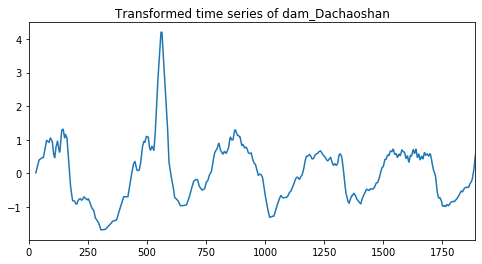

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000611      0.000019         0.000327        0.000009           0    0.0001           0.411924           0.513609           0.731795           0.490025           0.536413         0.536754        0.106154                5
1       0.000584      0.000085         0.000321        0.000009         0.5    0.0001           0.411686           0.514099           0.731716           0.490277           0.536889         0.536933        0.106137                4
2       0.000566      0.000052         0.000325        0.000012           1    0.0001           0.411432           0.514571           0.731635           0.490521           0.537355         0.537103        0.106126                3
3       0.000547      0.000055         0.000310        0.000008           2    0.0001           0.410911           0.515467           0.731474           0.490988           0.538263         0.537421        0.106113                2
4       0.000570      0.000083         0.000308        0.000003          10    0.0001           0.407482           0.521112           0.730195           0.493967           0.544529         0.539457        0.106047                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.088717      0.047636         0.003524        0.000810     0.1             2000            2           0.1       linear           0.342648           0.455046           0.729901           0.439995           0.508876         0.495293        0.128999                9
1        0.050764      0.039316         0.007025        0.003089     0.1             2000            2           0.1          rbf           0.120858           0.568875           0.648664           0.454956           0.599629         0.478596        0.189872               15
2        0.048363      0.037563         0.004312        0.002043     0.1             2000            2           0.1         poly          -3.718458          -1.660063          -0.094117          -0.078933          -0.013834        -1.113081        1.442448               27
3        0.032077      0.017083         0.000956        0.000227     0.1             2000            2             1       linear           0.469117           0.566093           0.636728           0.456697           0.504437         0.526614        0.066888                1
4        0.011684      0.007011         0.001829        0.000507     0.1             2000            2             1          rbf           0.193326           0.565755           0.537770           0.381428           0.484235         0.432503        0.135150               19
5        0.023612      0.017040         0.001715        0.000528     0.1             2000            2             1         poly          -1.735035          -0.537382          -0.165953          -0.093693          -0.033721        -0.513157        0.635599               25
6        0.079475      0.056468         0.002919        0.001344     0.1             2000            3           0.1       linear           0.342648           0.455046           0.729901           0.439995           0.508876         0.495293        0.128999                9
7        0.052460      0.039889         0.007577        0.003601     0.1             2000            3           0.1          rbf           0.120858           0.568875           0.648664           0.454956           0.599629         0.478596        0.189872               15
8        0.062622      0.046340         0.004950        0.002059     0.1             2000            3           0.1         poly          -9.677992          -1.407973           0.082579           0.007167           0.117566        -2.175731        3.794670               34
9        0.030951      0.016644         0.000855        0.000146     0.1             2000            3             1       linear           0.469117           0.566093           0.636728           0.456697           0.504437         0.526614        0.066888                1
10       0.011404      0.007039         0.001805        0.000497     0.1             2000            3             1          rbf           0.193326           0.565755           0.537770           0.381428           0.484235         0.432503        0.135150               19
11       0.035769      0.026407         0.001671        0.000534     0.1             2000            3             1         poly          -7.964264          -0.426352           0.059559           0.024018           0.092235        -1.642961        3.166301               31
12       0.279493      0.203640         0.002940        0.001205       1             2000            2           0.1       linear           0.358578           0.441903           0.726292           0.434074           0.501436         0.492457        0.125417               11
13       0.063190      0.045927         0.006838        0.003049       1             2000            2           0.1          rbf           0.294456      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001279      0.000186         0.000546        0.000009           0    0.0001           0.305902           0.408545           0.761542           0.576696           0.580108         0.526559        0.156981                5
1       0.001234      0.000216         0.000557        0.000006         0.5    0.0001           0.313346           0.410499           0.761595           0.576725           0.580858         0.528605        0.154671                4
2       0.001233      0.000217         0.000556        0.000009           1    0.0001           0.315933           0.411751           0.761582           0.576663           0.581545         0.529495        0.153799                3
3       0.001230      0.000214         0.000553        0.000004           2    0.0001           0.318842           0.413194           0.761461           0.576425           0.582766         0.530537        0.152803                2
4       0.001229      0.000220         0.000555        0.000002          10    0.0001           0.333379           0.414497           0.759730           0.574760           0.588904         0.534254        0.148431                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.142961      0.097771         0.009228        0.002916     0.1             2000            2           0.1       linear           0.373769           0.482608           0.778035           0.562966           0.580936         0.555663        0.133089                1
1        0.083143      0.063392         0.014841        0.006725     0.1             2000            2           0.1          rbf           0.148079           0.499956           0.747762           0.606743           0.654348         0.531378        0.207620                7
2        0.074205      0.057659         0.010797        0.005297     0.1             2000            2           0.1         poly          -4.152345          -1.592519           0.119765          -0.714350           0.207623        -1.226365        1.601622               33
3        0.036299      0.020277         0.001865        0.000437     0.1             2000            2             1       linear           0.081655           0.533373           0.670419           0.512832           0.553917         0.470439        0.201927               11
4        0.015251      0.008993         0.002974        0.000765     0.1             2000            2             1          rbf           0.196851           0.411569           0.460311           0.411908           0.505124         0.397153        0.106012               15
5        0.032329      0.022776         0.004018        0.001306     0.1             2000            2             1         poly          -1.934837          -0.343460           0.026526          -0.288802           0.180208        -0.472073        0.756820               31
6        0.141620      0.104557         0.008617        0.003812     0.1             2000            3           0.1       linear           0.373769           0.482608           0.778035           0.562966           0.580936         0.555663        0.133089                1
7        0.078917      0.061313         0.015212        0.007763     0.1             2000            3           0.1          rbf           0.148079           0.499956           0.747762           0.606743           0.654348         0.531378        0.207620                7
8        0.083907      0.064253         0.010722        0.005047     0.1             2000            3           0.1         poly          -2.478343          -0.382444           0.440671           0.399028           0.470664        -0.310085        1.129834               30
9        0.037519      0.020920         0.001914        0.000477     0.1             2000            3             1       linear           0.081655           0.533373           0.670419           0.512832           0.553917         0.470439        0.201927               11
10       0.015157      0.008983         0.002980        0.000767     0.1             2000            3             1          rbf           0.196851           0.411569           0.460311           0.411908           0.505124         0.397153        0.106012               15
11       0.024144      0.015958         0.002377        0.000534     0.1             2000            3             1         poly          -1.917627           0.217599           0.197681           0.391114           0.445982        -0.133050        0.897449               28
12       0.787641      0.613638         0.008373        0.003784       1             2000            2           0.1       linear           0.363728           0.491950           0.774648           0.562200           0.568070         0.552119        0.133407                3
13       0.092312      0.068582         0.014177        0.006640       1             2000            2           0.1          rbf           0.351169      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001336      0.000242         0.000651        0.000012           0    0.0001           0.324065           0.271044           0.631610           0.442610           0.592741         0.452414        0.142315                5
1       0.001330      0.000205         0.000641        0.000004         0.5    0.0001           0.326415           0.272635           0.631841           0.442928           0.592804         0.453324        0.141552                4
2       0.001291      0.000206         0.000623        0.000005           1    0.0001           0.328061           0.273982           0.632028           0.443232           0.592868         0.454034        0.140969                3
3       0.002344      0.002165         0.000646        0.000042           2    0.0001           0.330508           0.276227           0.632324           0.443815           0.592998         0.455175        0.140050                2
4       0.001301      0.000201         0.000625        0.000005          10    0.0001           0.341239           0.287378           0.633532           0.447921           0.594080         0.460830        0.135747                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.102786      0.056753         0.007164        0.001682     0.1             2000            2           0.1       linear           0.414089           0.382385           0.690878           0.490173           0.595362         0.514577        0.114697                1
1        0.070108      0.056240         0.011129        0.005324     0.1             2000            2           0.1          rbf           0.155006           0.447728           0.700326           0.531199           0.650573         0.496966        0.192605                7
2        0.062928      0.050462         0.008089        0.004198     0.1             2000            2           0.1         poly          -3.204954          -1.749423          -0.027410          -0.188681           0.207400        -0.992614        1.302703               34
3        0.035780      0.020062         0.001496        0.000327     0.1             2000            2             1       linear           0.171416           0.311696           0.542824           0.356565           0.588779         0.394256        0.153497               11
4        0.014317      0.008762         0.002468        0.000631     0.1             2000            2             1          rbf           0.200319           0.256433           0.389736           0.424732           0.541854         0.362615        0.121930               13
5        0.026135      0.017693         0.002837        0.000894     0.1             2000            2             1         poly          -1.798341          -0.564841          -0.016826           0.043047           0.195192        -0.428354        0.731557               30
6        0.092111      0.063275         0.005986        0.002752     0.1             2000            3           0.1       linear           0.414089           0.382385           0.690878           0.490173           0.595362         0.514577        0.114697                1
7        0.067511      0.053137         0.011022        0.005176     0.1             2000            3           0.1          rbf           0.155006           0.447728           0.700326           0.531199           0.650573         0.496966        0.192605                7
8        0.084497      0.059604         0.007961        0.003850     0.1             2000            3           0.1         poly          -1.767395          -0.362812           0.429921           0.287305           0.442410        -0.194114        0.840240               29
9        0.032690      0.018212         0.001383        0.000309     0.1             2000            3             1       linear           0.171416           0.311696           0.542824           0.356565           0.588779         0.394256        0.153497               11
10       0.013433      0.008283         0.002284        0.000599     0.1             2000            3             1          rbf           0.200319           0.256433           0.389736           0.424732           0.541854         0.362615        0.121930               13
11       0.027292      0.018846         0.001990        0.000475     0.1             2000            3             1         poly          -1.998511           0.183354           0.343420           0.467234           0.487930        -0.103315        0.953794               28
12       0.392959      0.233155         0.006091        0.002813       1             2000            2           0.1       linear           0.413004           0.368529           0.687047           0.474619           0.595281         0.507696        0.117700                3
13       0.078802      0.059284         0.010732        0.005155       1             2000            2           0.1          rbf           0.355173      

>>> Final results:



period = 15, future = 10, Node: dam_Nuozhadu, neighbors: ['dam_Dachaoshan', 'dam_Jinghong']


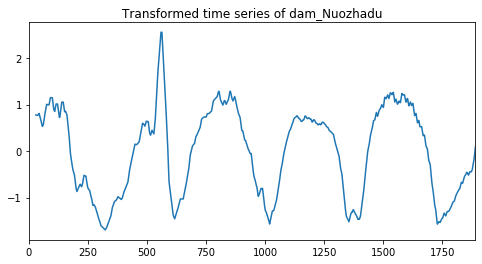

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001586      0.001255         0.000578        0.000115           0    0.0001           0.343230           0.549611           0.833201           0.814595           0.811636         0.670454        0.194357                5
1       0.000996      0.000106         0.000579        0.000006         0.5    0.0001           0.343393           0.550037           0.833209           0.814677           0.811733         0.670610        0.194277                4
2       0.000934      0.000087         0.000539        0.000012           1    0.0001           0.343517           0.550431           0.833214           0.814754           0.811826         0.670748        0.194212                3
3       0.000899      0.000098         0.000516        0.000002           2    0.0001           0.343724           0.551141           0.833215           0.814897           0.812000         0.670995        0.194101                2
4       0.002604      0.003157         0.000621        0.000100          10    0.0001           0.345691           0.554794           0.833006           0.815666           0.813042         0.672440        0.193220                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.077166      0.039528         0.003961        0.000963     0.1             2000            2           0.1       linear           0.360278           0.565992           0.840272           0.807985           0.792658         0.673437        0.184263                7
1        0.050066      0.038319         0.007493        0.002723     0.1             2000            2           0.1          rbf           0.298935           0.512994           0.835125           0.810825           0.821846         0.655945        0.215178               15
2        0.044663      0.034928         0.004413        0.001898     0.1             2000            2           0.1         poly          -0.841158          -2.028977           0.027813           0.005454          -0.113530        -0.590080        0.787022               33
3        0.021635      0.011926         0.000521        0.000107     0.1             2000            2             1       linear           0.476898           0.549006           0.803214           0.769247           0.808099         0.681293        0.139970                1
4        0.005014      0.002939         0.000975        0.000234     0.1             2000            2             1          rbf           0.344487           0.560691           0.734340           0.746447           0.700646         0.617322        0.151628               17
5        0.021755      0.017489         0.001794        0.000633     0.1             2000            2             1         poly          -0.671133          -0.923720          -0.058159          -0.014878          -0.051587        -0.343896        0.379110               29
6        0.068050      0.046171         0.003144        0.001331     0.1             2000            3           0.1       linear           0.360278           0.565992           0.840272           0.807985           0.792658         0.673437        0.184263                7
7        0.049835      0.038303         0.007122        0.003078     0.1             2000            3           0.1          rbf           0.298935           0.512994           0.835125           0.810825           0.821846         0.655945        0.215178               15
8        0.075434      0.059123         0.004203        0.001882     0.1             2000            3           0.1         poly          -1.708606          -0.829334           0.490840           0.632689           0.532611        -0.176360        0.935576               26
9        0.021678      0.011984         0.000524        0.000108     0.1             2000            3             1       linear           0.476898           0.549006           0.803214           0.769247           0.808099         0.681293        0.139970                1
10       0.005007      0.002932         0.000977        0.000234     0.1             2000            3             1          rbf           0.344487           0.560691           0.734340           0.746447           0.700646         0.617322        0.151628               17
11       0.026852      0.018666         0.001249        0.000355     0.1             2000            3             1         poly          -1.809503          -0.449955           0.388810           0.421458           0.388284        -0.212181        0.863854               27
12       0.282907      0.190495         0.003122        0.001299       1             2000            2           0.1       linear           0.368316           0.548922           0.838497           0.805969           0.794965         0.671334        0.183390                9
13       0.061120      0.044230         0.006766        0.003003       1             2000            2           0.1          rbf           0.305662      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.005412      0.002034         0.000986        0.000103           0    0.0001           0.376755           0.655711           0.761574           0.828342           0.816279         0.687732        0.167021                1
1       0.004290      0.000607         0.000940        0.000007         0.5    0.0001           0.371238           0.655859           0.761643           0.828458           0.816436         0.686727        0.169122                2
2       0.004126      0.000603         0.000929        0.000012           1    0.0001           0.366481           0.655885           0.761656           0.828531           0.816573         0.685825        0.170931                3
3       0.008290      0.006659         0.000834        0.000224           2    0.0001           0.358209           0.655808           0.761608           0.828597           0.816804         0.684205        0.174070                4
4       0.003006      0.003292         0.000567        0.000033          10    0.0001           0.310790           0.654266           0.760945           0.828229           0.817728         0.674391        0.191997                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.194280      0.123070         0.009758        0.003094     0.1             2000            2           0.1       linear           0.402816           0.606949           0.779287           0.828113           0.842423         0.691918        0.167113                5
1        0.078976      0.061646         0.014609        0.006812     0.1             2000            2           0.1          rbf           0.330535           0.387525           0.814083           0.826056           0.830334         0.637706        0.228313                9
2        0.077495      0.058489         0.011695        0.005267     0.1             2000            2           0.1         poly         -14.793585          -1.739233          -0.470572          -0.061918          -0.165920        -3.446245        5.705170               27
3        0.037459      0.022960         0.000969        0.000289     0.1             2000            2             1       linear           0.259580           0.666812           0.743637           0.811384           0.755408         0.647364        0.199298                7
4        0.009454      0.005341         0.001979        0.000515     0.1             2000            2             1          rbf           0.285968           0.335719           0.689419           0.696556           0.733114         0.548155        0.194966               21
5        0.028581      0.022581         0.003656        0.001778     0.1             2000            2             1         poly          -3.307749          -1.553853          -0.127762          -0.034884          -0.052728        -1.015395        1.282252               25
6        0.185385      0.135208         0.008733        0.004024     0.1             2000            3           0.1       linear           0.402816           0.606949           0.779287           0.828113           0.842423         0.691918        0.167113                5
7        0.079127      0.061520         0.015092        0.006987     0.1             2000            3           0.1          rbf           0.330535           0.387525           0.814083           0.826056           0.830334         0.637706        0.228313                9
8        0.075980      0.056797         0.009989        0.004565     0.1             2000            3           0.1         poly        -107.921651          -0.358961           0.495316           0.614032           0.530164       -21.328220       43.298153               34
9        0.036772      0.023315         0.000973        0.000323     0.1             2000            3             1       linear           0.259580           0.666812           0.743637           0.811384           0.755408         0.647364        0.199298                7
10       0.009700      0.005311         0.002049        0.000515     0.1             2000            3             1          rbf           0.285968           0.335719           0.689419           0.696556           0.733114         0.548155        0.194966               21
11       0.017973      0.013301         0.002060        0.000735     0.1             2000            3             1         poly         -36.480337          -0.297001           0.388760           0.448259           0.532691        -7.081526       14.702374               30
12       1.147274      0.868361         0.008977        0.004261       1             2000            2           0.1       linear           0.447836           0.616952           0.784750           0.828611           0.843398         0.704309        0.151444                3
13       0.094799      0.071322         0.014325        0.006997       1             2000            2           0.1          rbf           0.411861      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001151      0.000220         0.000552        0.000006           0    0.0001          -0.535403          -0.922265           0.249537           0.229546           0.230037        -0.149710        0.488475                1
1       0.001155      0.000190         0.000573        0.000056         0.5    0.0001          -0.536310          -0.921914           0.249513           0.229595           0.230114        -0.149800        0.488523                2
2       0.001132      0.000169         0.000546        0.000008           1    0.0001          -0.537287          -0.921577           0.249489           0.229642           0.230189        -0.149909        0.488587                3
3       0.001116      0.000177         0.000539        0.000005           2    0.0001          -0.539236          -0.920943           0.249436           0.229730           0.230332        -0.150136        0.488724                4
4       0.001116      0.000175         0.000633        0.000186          10    0.0001          -0.551082          -0.916840           0.248957           0.230233           0.231232        -0.151500        0.489486                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.135224      0.078813         0.007537        0.002334     0.1             2000            2           0.1       linear          -0.515502          -0.995106           0.327941           0.247541           0.160584        -0.154908        0.515869               17
1        0.072799      0.056411         0.012566        0.005805     0.1             2000            2           0.1          rbf           0.249896          -0.648314          -0.353817           0.208475          -0.123088        -0.133370        0.339889               11
2        0.063469      0.049057         0.007905        0.003788     0.1             2000            2           0.1         poly         -19.147628          -2.151315          -0.361198          -0.059658          -0.611162        -4.466192        7.376083               27
3        0.042630      0.030559         0.001580        0.000798     0.1             2000            2             1       linear           0.030548          -0.721864           0.257257           0.182283           0.208531        -0.008649        0.364565                7
4        0.014781      0.011961         0.002524        0.001240     0.1             2000            2             1          rbf           0.232108          -0.499499           0.200511           0.183856           0.135443         0.050484        0.276761                1
5        0.027186      0.021938         0.002763        0.001332     0.1             2000            2             1         poly          -4.804745          -1.591941          -0.048099          -0.046067          -0.132704        -1.324711        1.836714               25
6        0.128659      0.087939         0.006895        0.003171     0.1             2000            3           0.1       linear          -0.515502          -0.995106           0.327941           0.247541           0.160584        -0.154908        0.515869               17
7        0.071267      0.054944         0.012148        0.005675     0.1             2000            3           0.1          rbf           0.249896          -0.648314          -0.353817           0.208475          -0.123088        -0.133370        0.339889               11
8        0.071592      0.055798         0.008367        0.004175     0.1             2000            3           0.1         poly        -212.264523          -2.183475           0.160056           0.068567          -0.496927       -42.943260       84.664815               35
9        0.042411      0.029889         0.001607        0.000802     0.1             2000            3             1       linear           0.030548          -0.721864           0.257257           0.182283           0.208531        -0.008649        0.364565                7
10       0.014683      0.011720         0.002520        0.001226     0.1             2000            3             1          rbf           0.232108          -0.499499           0.200511           0.183856           0.135443         0.050484        0.276761                1
11       0.037603      0.032031         0.002883        0.001343     0.1             2000            3             1         poly         -79.628700          -1.440607           0.075155           0.013367           0.028139       -16.190529       31.724267               31
12       0.598167      0.330008         0.006732        0.003046       1             2000            2           0.1       linear          -0.443813          -0.995802           0.330419           0.248350           0.158103        -0.140549        0.507084               15
13       0.078475      0.057991         0.011078        0.005349       1             2000            2           0.1          rbf           0.310257      

>>> Final results:



period = 15, future = 10, Node: dam_Jinghong, neighbors: ['dam_Nuozhadu', 'rw_239']


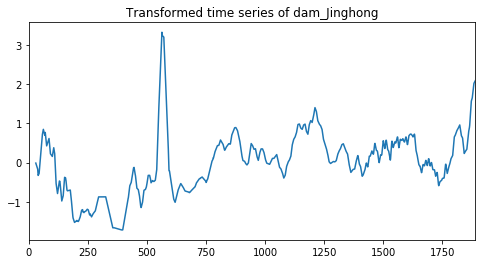

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003300      0.002947         0.000649        0.000147           0    0.0001          -0.003024           0.277096           0.192596          -0.099405           0.338010         0.141055        0.166454                5
1       0.001116      0.000098         0.000632        0.000006         0.5    0.0001          -0.002758           0.276901           0.192410          -0.098916           0.338077         0.141143        0.166239                4
2       0.001817      0.000939         0.000679        0.000053           1    0.0001          -0.002504           0.276707           0.192225          -0.098434           0.338144         0.141227        0.166029                3
3       0.001106      0.000095         0.000623        0.000010           2    0.0001          -0.002025           0.276319           0.191852          -0.097492           0.338273         0.141386        0.165618                2
4       0.001084      0.000118         0.000612        0.000005          10    0.0001           0.001101           0.273265           0.188843          -0.090794           0.339171         0.142317        0.162694                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.086376      0.053460         0.003719        0.000935     0.1             2000            2           0.1       linear          -0.063744          -0.443571           0.379381          -0.299889           0.331665        -0.019232        0.329495               15
1        0.053845      0.041707         0.007713        0.003484     0.1             2000            2           0.1          rbf           0.035171          -0.935914          -0.177227          -0.004809           0.207602        -0.175036        0.399629               19
2        0.051023      0.037407         0.004353        0.002032     0.1             2000            2           0.1         poly          -0.244143          -3.081577          -2.745889          -0.427988          -0.539464        -1.407812        1.237752               27
3        0.032749      0.019600         0.000861        0.000190     0.1             2000            2             1       linear           0.173701           0.249211           0.024592          -0.120321           0.235095         0.112456        0.140995                3
4        0.010334      0.006829         0.001622        0.000429     0.1             2000            2             1          rbf           0.137876           0.284232          -0.006162          -0.127058           0.066171         0.071012        0.137945                9
5        0.028549      0.021374         0.001672        0.000579     0.1             2000            2             1         poly          -1.211129          -1.617108          -2.829398          -0.721585          -0.347951        -1.345434        0.857689               25
6        0.077763      0.059752         0.003321        0.001508     0.1             2000            3           0.1       linear          -0.063744          -0.443571           0.379381          -0.299889           0.331665        -0.019232        0.329495               15
7        0.053348      0.041817         0.007652        0.003563     0.1             2000            3           0.1          rbf           0.035171          -0.935914          -0.177227          -0.004809           0.207602        -0.175036        0.399629               19
8        0.077133      0.056168         0.004230        0.001984     0.1             2000            3           0.1         poly          -3.646883          -2.678940          -3.137416          -0.463496           0.018630        -1.981621        1.476545               32
9        0.032650      0.019421         0.000856        0.000176     0.1             2000            3             1       linear           0.173701           0.249211           0.024592          -0.120321           0.235095         0.112456        0.140995                3
10       0.009802      0.006198         0.001559        0.000391     0.1             2000            3             1          rbf           0.137876           0.284232          -0.006162          -0.127058           0.066171         0.071012        0.137945                9
11       0.044142      0.029063         0.001574        0.000545     0.1             2000            3             1         poly         -17.922145          -1.342592          -2.621286          -0.563616          -0.311431        -4.552214        6.733177               35
12       0.282958      0.209275         0.003265        0.001441       1             2000            2           0.1       linear          -0.069582          -0.294126           0.379736          -0.313592           0.327991         0.006085        0.297081               13
13       0.065946      0.048399         0.007931        0.003831       1             2000            2           0.1          rbf           0.169089      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001573      0.000411         0.000662        0.000009           0    0.0001           0.464852           0.165242          -0.666944          -0.223641           0.180330        -0.016032        0.392289                5
1       0.001622      0.000292         0.000656        0.000008         0.5    0.0001           0.465748           0.167235          -0.666323          -0.222863           0.179979        -0.015245        0.392371                4
2       0.001576      0.000314         0.000639        0.000006           1    0.0001           0.465954           0.168962          -0.665808          -0.222128           0.179628        -0.014678        0.392298                3
3       0.001571      0.000314         0.000660        0.000025           2    0.0001           0.465352           0.171861          -0.665022          -0.220771           0.178932        -0.013930        0.391951                2
4       0.001585      0.000330         0.000638        0.000004          10    0.0001           0.452436           0.184846          -0.664191          -0.213379           0.173521        -0.013353        0.388527                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.133491      0.080991         0.010361        0.003111     0.1             2000            2           0.1       linear           0.392447           0.202955          -0.137752          -0.131040           0.400389         0.145400        0.239148                1
1        0.082824      0.067445         0.015284        0.007735     0.1             2000            2           0.1          rbf           0.079430          -0.500075          -0.822370          -0.119209           0.076797        -0.257085        0.352795               15
2        0.069420      0.052190         0.010623        0.004748     0.1             2000            2           0.1         poly          -0.654108          -2.785610          -6.384972          -0.381440          -0.663829        -2.173992        2.276414               29
3        0.037490      0.021725         0.001871        0.000503     0.1             2000            2             1       linear           0.388081           0.119560          -0.711414          -0.430567          -0.044621        -0.135792        0.391457                9
4        0.015050      0.009228         0.003087        0.000811     0.1             2000            2             1          rbf           0.140471           0.320901          -0.108729          -0.125799          -0.090246         0.027319        0.175937                7
5        0.026630      0.020939         0.003459        0.001657     0.1             2000            2             1         poly          -0.905680          -1.299367          -4.722532          -0.612555          -0.442908        -1.596608        1.589750               24
6        0.123166      0.090187         0.009145        0.004343     0.1             2000            3           0.1       linear           0.392447           0.202955          -0.137752          -0.131040           0.400389         0.145400        0.239148                1
7        0.081409      0.064966         0.015119        0.007380     0.1             2000            3           0.1          rbf           0.079430          -0.500075          -0.822370          -0.119209           0.076797        -0.257085        0.352795               15
8        0.075455      0.056091         0.010289        0.004906     0.1             2000            3           0.1         poly          -2.540885          -1.467281          -2.908782          -0.425834          -0.135758        -1.495708        1.103093               23
9        0.037076      0.021456         0.001848        0.000487     0.1             2000            3             1       linear           0.388081           0.119560          -0.711414          -0.430567          -0.044621        -0.135792        0.391457                9
10       0.015118      0.009182         0.003149        0.000778     0.1             2000            3             1          rbf           0.140471           0.320901          -0.108729          -0.125799          -0.090246         0.027319        0.175937                7
11       0.026746      0.020975         0.002800        0.001275     0.1             2000            3             1         poly          -4.372259          -0.526440          -2.765005          -0.505636          -0.380556        -1.709979        1.601211               27
12       0.568052      0.386450         0.009510        0.004360       1             2000            2           0.1       linear           0.395058           0.188750          -0.130617          -0.136138           0.401828         0.143776        0.238914                3
13       0.095662      0.074004         0.014150        0.007053       1             2000            2           0.1          rbf           0.191217      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004380      0.002276         0.001656        0.001326           0    0.0001           0.368838          -0.008984          -1.616036          -1.042913          -1.313880        -0.722595        0.768235                5
1       0.002917      0.000326         0.000905        0.000015         0.5    0.0001           0.369884          -0.006535          -1.615007          -1.041231          -1.313847        -0.721347        0.768603                4
2       0.002915      0.000326         0.000892        0.000014           1    0.0001           0.370741          -0.004438          -1.614133          -1.039670          -1.313815        -0.720263        0.768898                3
3       0.002902      0.000324         0.000900        0.000017           2    0.0001           0.372082          -0.000950          -1.612717          -1.036847          -1.313758        -0.718438        0.769357                2
4       0.002903      0.000328         0.000889        0.000008          10    0.0001           0.376549           0.015020          -1.607278          -1.021925          -1.313510        -0.710229        0.771086                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.088847      0.054383         0.007684        0.002617     0.1             2000            2           0.1       linear           0.273772          -0.494456          -1.651248          -0.885825          -1.249232        -0.801398        0.660323                9
1        0.074671      0.058617         0.012452        0.005951     0.1             2000            2           0.1          rbf           0.066012          -0.857360          -1.625658          -0.903392          -1.519242        -0.967928        0.603652               18
2        0.058083      0.044469         0.007653        0.003456     0.1             2000            2           0.1         poly           0.163720          -2.236487          -8.285059          -0.560276          -0.718473        -2.327315        3.079578               29
3        0.035318      0.020808         0.001798        0.000652     0.1             2000            2             1       linear           0.397485          -0.028860          -1.743341          -0.787081          -0.922792        -0.616918        0.743797                1
4        0.016878      0.012640         0.002934        0.001212     0.1             2000            2             1          rbf           0.102439          -0.166281          -1.525536          -0.492157          -1.079641        -0.632235        0.595758                3
5        0.024290      0.020557         0.002956        0.001504     0.1             2000            2             1         poly           0.055117          -1.567179          -6.992768          -0.879046          -0.584896        -1.993754        2.553329               28
6        0.077696      0.056227         0.006629        0.003121     0.1             2000            3           0.1       linear           0.273772          -0.494456          -1.651248          -0.885825          -1.249232        -0.801398        0.660323                9
7        0.072929      0.058241         0.011978        0.005949     0.1             2000            3           0.1          rbf           0.066012          -0.857360          -1.625658          -0.903392          -1.519242        -0.967928        0.603652               18
8        0.067302      0.047288         0.007552        0.003366     0.1             2000            3           0.1         poly           0.537259          -0.887022          -6.348347          -1.029047          -0.630036        -1.671439        2.402678               24
9        0.035142      0.020877         0.001757        0.000675     0.1             2000            3             1       linear           0.397485          -0.028860          -1.743341          -0.787081          -0.922792        -0.616918        0.743797                1
10       0.016944      0.012655         0.002972        0.001186     0.1             2000            3             1          rbf           0.102439          -0.166281          -1.525536          -0.492157          -1.079641        -0.632235        0.595758                3
11       0.022912      0.018169         0.002288        0.001036     0.1             2000            3             1         poly           0.396096          -0.393691          -3.407975          -0.616698          -0.589440        -0.922341        1.296176               15
12       0.280275      0.213869         0.006738        0.003168       1             2000            2           0.1       linear           0.256272          -0.548120          -1.695582          -0.891817          -1.254494        -0.826748        0.662214               11
13       0.082233      0.061253         0.011587        0.005811       1             2000            2           0.1          rbf          -0.019615      

>>> Final results:



period = 15, future = 10, Node: dam_Nam Ngum 5, neighbors: ['dam_Nam Ngum 2']


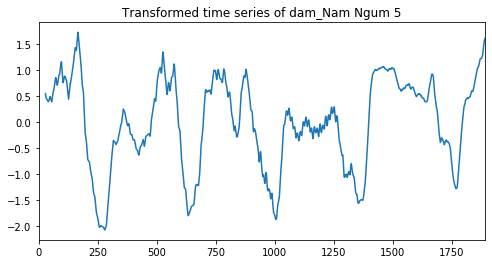

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004503      0.002685         0.000641        0.000143           0    0.0001           0.524738           0.349849           0.595972           0.700580           0.534212         0.541070        0.114313                1
1       0.003536      0.001627         0.000704        0.000142         0.5    0.0001           0.524613           0.349960           0.595954           0.700609           0.534195         0.541066        0.114286                2
2       0.005540      0.004266         0.000658        0.000042           1    0.0001           0.524478           0.350060           0.595935           0.700638           0.534177         0.541058        0.114262                3
3       0.007537      0.011296         0.000676        0.000083           2    0.0001           0.524193           0.350235           0.595892           0.700694           0.534143         0.541031        0.114224                4
4       0.003060      0.003037         0.000621        0.000064          10    0.0001           0.521931           0.350902           0.595433           0.701066           0.533865         0.540639        0.114136                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.072245      0.040176         0.004573        0.001166     0.1             2000            2           0.1       linear           0.474773           0.301571           0.632185           0.707589           0.531978         0.529619        0.139437                1
1        0.056259      0.040954         0.008215        0.003343     0.1             2000            2           0.1          rbf           0.493715           0.278307           0.614448           0.699302           0.528017         0.522758        0.141564                9
2        0.046688      0.036418         0.004352        0.001971     0.1             2000            2           0.1         poly           0.034755          -0.083919           0.207005          -0.053963          -0.305388        -0.040302        0.166826               35
3        0.030569      0.017754         0.001031        0.000319     0.1             2000            2             1       linear           0.494494           0.352738           0.563914           0.681690           0.500220         0.518611        0.106846               15
4        0.010606      0.006527         0.001802        0.000451     0.1             2000            2             1          rbf           0.475168           0.329751           0.518372           0.731594           0.548927         0.520762        0.129471               11
5        0.018888      0.013505         0.001826        0.000628     0.1             2000            2             1         poly           0.002006           0.054476           0.096210           0.069866          -0.183174         0.007877        0.100351               33
6        0.061863      0.041049         0.003429        0.001423     0.1             2000            3           0.1       linear           0.474773           0.301571           0.632185           0.707589           0.531978         0.529619        0.139437                1
7        0.055220      0.041874         0.007930        0.003533     0.1             2000            3           0.1          rbf           0.493715           0.278307           0.614448           0.699302           0.528017         0.522758        0.141564                9
8        0.054267      0.039449         0.004408        0.002004     0.1             2000            3           0.1         poly           0.337205           0.158948           0.365688           0.429362           0.277396         0.313720        0.091541               27
9        0.030359      0.016470         0.000969        0.000212     0.1             2000            3             1       linear           0.494494           0.352738           0.563914           0.681690           0.500220         0.518611        0.106846               15
10       0.009843      0.006968         0.001583        0.000546     0.1             2000            3             1          rbf           0.475168           0.329751           0.518372           0.731594           0.548927         0.520762        0.129471               11
11       0.027109      0.018357         0.001392        0.000401     0.1             2000            3             1         poly           0.210471           0.240122           0.278503           0.412942           0.166973         0.261802        0.083928               30
12       0.195171      0.132528         0.003343        0.001357       1             2000            2           0.1       linear           0.446995           0.300104           0.632780           0.706938           0.531807         0.523725        0.142421                5
13       0.065784      0.047208         0.007802        0.003485       1             2000            2           0.1          rbf           0.445884      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001289      0.000278         0.000649        0.000016           0    0.0001           0.460442           0.345545           0.623377           0.694170           0.506944         0.526095        0.122465                5
1       0.001323      0.000192         0.000637        0.000011         0.5    0.0001           0.463258           0.346609           0.623051           0.695153           0.507514         0.527117        0.122053                4
2       0.001288      0.000198         0.000626        0.000006           1    0.0001           0.465422           0.347333           0.622695           0.695951           0.508020         0.527884        0.121762                3
3       0.001282      0.000206         0.000624        0.000008           2    0.0001           0.468774           0.348339           0.621964           0.697181           0.508881         0.529028        0.121324                2
4       0.001283      0.000207         0.000622        0.000005          10    0.0001           0.481304           0.351669           0.617405           0.701407           0.512360         0.532829        0.119553                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.087794      0.047536         0.007638        0.002077     0.1             2000            2           0.1       linear           0.407439           0.303807           0.611259           0.701382           0.510680         0.506914        0.141328                9
1        0.068812      0.051971         0.011801        0.005369     0.1             2000            2           0.1          rbf           0.499158           0.289293           0.601616           0.715680           0.392575         0.499664        0.150187               13
2        0.067189      0.056225         0.008079        0.003918     0.1             2000            2           0.1         poly          -0.052340          -0.034566           0.191974           0.040035           0.094112         0.047843        0.089223               31
3        0.037530      0.020968         0.001684        0.000493     0.1             2000            2             1       linear           0.475095           0.371014           0.590665           0.704851           0.507963         0.529918        0.112276                1
4        0.012779      0.008839         0.002395        0.000864     0.1             2000            2             1          rbf           0.446805           0.330940           0.529196           0.731573           0.477481         0.503199        0.131412               11
5        0.024213      0.017712         0.003298        0.001114     0.1             2000            2             1         poly          -0.009357           0.013790           0.102810           0.103172           0.010359         0.044155        0.048685               32
6        0.082174      0.056438         0.006912        0.002993     0.1             2000            3           0.1       linear           0.407439           0.303807           0.611259           0.701382           0.510680         0.506914        0.141328                9
7        0.071220      0.054773         0.012192        0.005436     0.1             2000            3           0.1          rbf           0.499158           0.289293           0.601616           0.715680           0.392575         0.499664        0.150187               13
8        0.066988      0.050477         0.008653        0.004005     0.1             2000            3           0.1         poly           0.336747           0.132458           0.380358           0.428340          -0.286658         0.198249        0.262583               26
9        0.035353      0.019169         0.001555        0.000451     0.1             2000            3             1       linear           0.475095           0.371014           0.590665           0.704851           0.507963         0.529918        0.112276                1
10       0.012734      0.009117         0.002366        0.000930     0.1             2000            3             1          rbf           0.446805           0.330940           0.529196           0.731573           0.477481         0.503199        0.131412               11
11       0.027235      0.021327         0.002407        0.000714     0.1             2000            3             1         poly           0.220631           0.224202           0.333911           0.444787          -0.344603         0.175786        0.272956               27
12       0.245255      0.152854         0.006768        0.003060       1             2000            2           0.1       linear           0.364220           0.291131           0.617204           0.694577           0.507411         0.494909        0.150721               15
13       0.082539      0.057500         0.011667        0.005090       1             2000            2           0.1          rbf           0.547470      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001022      0.000225         0.000594        0.000058           0    0.0001           0.131866           0.247353           0.475852           0.564324          -0.482358         0.187407        0.368926                5
1       0.001094      0.000132         0.000623        0.000003         0.5    0.0001           0.132513           0.247538           0.475714           0.564404          -0.481985         0.187637        0.368771                4
2       0.001087      0.000124         0.000626        0.000013           1    0.0001           0.133065           0.247699           0.475566           0.564481          -0.481625         0.187837        0.368622                3
3       0.001067      0.000120         0.000612        0.000004           2    0.0001           0.134010           0.247964           0.475244           0.564627          -0.480939         0.188181        0.368333                2
4       0.001065      0.000122         0.000608        0.000005          10    0.0001           0.139455           0.248927           0.472255           0.565534          -0.476482         0.189938        0.366311                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.063528      0.031496         0.004185        0.001108     0.1             2000            2           0.1       linear           0.207876           0.244138           0.505137           0.533477          -0.701464         0.157833        0.449460                9
1        0.060891      0.044855         0.009204        0.004091     0.1             2000            2           0.1          rbf           0.289579           0.215560           0.438469           0.571126          -0.953223         0.112302        0.546688               17
2        0.048734      0.036821         0.004390        0.001955     0.1             2000            2           0.1         poly           0.013306          -0.094454           0.157384           0.052366           0.135531         0.052826        0.090582               26
3        0.029058      0.018712         0.000979        0.000289     0.1             2000            2             1       linear           0.074864           0.210594           0.430707           0.567922          -0.265240         0.203770        0.290083                1
4        0.012394      0.008586         0.001865        0.000686     0.1             2000            2             1          rbf           0.148518           0.229411           0.409501           0.628912          -0.428306         0.197607        0.353868                7
5        0.016915      0.011990         0.001612        0.000585     0.1             2000            2             1         poly           0.024958          -0.047138           0.098513           0.095304           0.169725         0.068272        0.073666               20
6        0.052546      0.034247         0.003741        0.001892     0.1             2000            3           0.1       linear           0.207876           0.244138           0.505137           0.533477          -0.701464         0.157833        0.449460                9
7        0.056086      0.042786         0.008052        0.003662     0.1             2000            3           0.1          rbf           0.289579           0.215560           0.438469           0.571126          -0.953223         0.112302        0.546688               17
8        0.057137      0.044605         0.004343        0.001917     0.1             2000            3           0.1         poly           0.065219           0.043430           0.272220           0.257907          -0.356931         0.056369        0.227276               24
9        0.029103      0.018742         0.000999        0.000264     0.1             2000            3             1       linear           0.074864           0.210594           0.430707           0.567922          -0.265240         0.203770        0.290083                1
10       0.012663      0.008937         0.001875        0.000699     0.1             2000            3             1          rbf           0.148518           0.229411           0.409501           0.628912          -0.428306         0.197607        0.353868                7
11       0.030122      0.022139         0.001466        0.000459     0.1             2000            3             1         poly          -0.004886           0.081532           0.248049           0.314031          -0.282213         0.071303        0.210256               19
12       0.104193      0.073223         0.003467        0.001454       1             2000            2           0.1       linear           0.185912           0.246490           0.512279           0.530442          -0.706948         0.153635        0.451857               11
13       0.065827      0.049566         0.008376        0.003819       1             2000            2           0.1          rbf           0.293510      

>>> Final results:



period = 15, future = 10, Node: dam_Nam Ngum 2, neighbors: ['dam_Nam Ngum 5', 'dam_Nam Ngum']


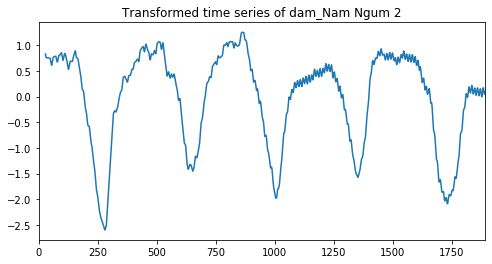

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000744      0.000218         0.000403        0.000077           0    0.0001           0.633043           0.713706           0.817349           0.817219           0.835648         0.763393        0.078089                4
1       0.001642      0.000792         0.000628        0.000062         0.5    0.0001           0.633453           0.713790           0.817290           0.817103           0.835588         0.763445        0.077906                3
2       0.001322      0.000802         0.000537        0.000037           1    0.0001           0.633773           0.713850           0.817223           0.816987           0.835526         0.763472        0.077755                2
3       0.000854      0.000114         0.000503        0.000120           2    0.0001           0.634275           0.713914           0.817074           0.816755           0.835399         0.763483        0.077503                1
4       0.000756      0.000184         0.000506        0.000143          10    0.0001           0.636850           0.713456           0.815586           0.814936           0.834283         0.763022        0.076043                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.066365      0.036557         0.004014        0.001326     0.1             2000            2           0.1       linear           0.610152           0.691110           0.809593           0.816682           0.841300         0.753767        0.088643                1
1        0.059263      0.045491         0.009182        0.004537     0.1             2000            2           0.1          rbf           0.675995           0.633649           0.799958           0.813126           0.830025         0.750551        0.079872                7
2        0.052647      0.038284         0.004991        0.001797     0.1             2000            2           0.1         poly           0.035359          -0.189929           0.307426           0.234192           0.206073         0.118624        0.178206               34
3        0.021323      0.018158         0.000608        0.000124     0.1             2000            2             1       linear           0.432106           0.519368           0.731115           0.688559           0.762895         0.626808        0.128581               17
4        0.004448      0.002623         0.000942        0.000159     0.1             2000            2             1          rbf           0.159181           0.271622           0.581576           0.509643           0.686909         0.441786        0.196495               26
5        0.016808      0.011448         0.001607        0.000553     0.1             2000            2             1         poly          -0.138378          -0.340367           0.373690           0.183246           0.363097         0.088258        0.283236               36
6        0.058490      0.039188         0.003408        0.001385     0.1             2000            3           0.1       linear           0.610152           0.691110           0.809593           0.816682           0.841300         0.753767        0.088643                1
7        0.053340      0.039925         0.007842        0.003100     0.1             2000            3           0.1          rbf           0.675995           0.633649           0.799958           0.813126           0.830025         0.750551        0.079872                7
8        0.057981      0.044063         0.004849        0.002294     0.1             2000            3           0.1         poly           0.240033           0.324590           0.444052           0.526176           0.479799         0.402930        0.105320               29
9        0.023249      0.018261         0.000621        0.000078     0.1             2000            3             1       linear           0.432106           0.519368           0.731115           0.688559           0.762895         0.626808        0.128581               17
10       0.004453      0.002601         0.000955        0.000119     0.1             2000            3             1          rbf           0.159181           0.271622           0.581576           0.509643           0.686909         0.441786        0.196495               26
11       0.024011      0.015847         0.001162        0.000328     0.1             2000            3             1         poly           0.024128           0.066221           0.474625           0.396040           0.666373         0.325477        0.245544               30
12       0.187865      0.135038         0.003603        0.001413       1             2000            2           0.1       linear           0.608470           0.690306           0.810911           0.814903           0.841918         0.753301        0.089343                3
13       0.066182      0.045944         0.007678        0.003044       1             2000            2           0.1          rbf           0.683912      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001128      0.000338         0.000468        0.000104           0    0.0001           0.340159           0.715604           0.796609           0.807333           0.814428         0.694827        0.180855                1
1       0.001243      0.000230         0.000551        0.000012         0.5    0.0001           0.336888           0.718430           0.796409           0.807369           0.814286         0.694676        0.182172                2
2       0.001227      0.000217         0.000552        0.000005           1    0.0001           0.334554           0.720596           0.796197           0.807336           0.814129         0.694562        0.183099                3
3       0.003338      0.004171         0.003954        0.006785           2    0.0001           0.331279           0.723863           0.795768           0.807160           0.813779         0.694370        0.184373                4
4       0.001247      0.000244         0.002181        0.003255          10    0.0001           0.324411           0.734396           0.792703           0.805011           0.810563         0.693417        0.186483                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.141679      0.092447         0.010131        0.002505     0.1             2000            2           0.1       linear           0.372405           0.689639           0.697693           0.806965           0.820304         0.677401        0.161736                5
1        0.079811      0.061642         0.014984        0.006578     0.1             2000            2           0.1          rbf           0.214716           0.675561           0.756715           0.717456           0.490900         0.571069        0.200113                7
2        0.072604      0.058474         0.010438        0.004826     0.1             2000            2           0.1         poly           0.103361           0.127412           0.259088           0.059647          -1.401748        -0.170448        0.619231               28
3        0.024785      0.016965         0.000931        0.000157     0.1             2000            2             1       linear           0.011515           0.551418           0.655680           0.700769           0.717921         0.527461        0.264396               13
4        0.010004      0.005761         0.002109        0.000375     0.1             2000            2             1          rbf          -0.184806           0.327186           0.612936           0.511708           0.434536         0.340312        0.278747               21
5        0.021726      0.016106         0.002807        0.000933     0.1             2000            2             1         poly           0.013511          -0.042223           0.402215           0.049370          -0.460161        -0.007458        0.274827               26
6        0.130242      0.096169         0.009056        0.003832     0.1             2000            3           0.1       linear           0.372405           0.689639           0.697693           0.806965           0.820304         0.677401        0.161736                5
7        0.081121      0.062977         0.015123        0.006712     0.1             2000            3           0.1          rbf           0.214716           0.675561           0.756715           0.717456           0.490900         0.571069        0.200113                7
8        0.078845      0.058757         0.011101        0.005295     0.1             2000            3           0.1         poly           0.259163           0.425217          -0.438057           0.489077          -1.556473        -0.164214        0.770304               27
9        0.024086      0.016389         0.000846        0.000098     0.1             2000            3             1       linear           0.011515           0.551418           0.655680           0.700769           0.717921         0.527461        0.264396               13
10       0.009261      0.005765         0.001954        0.000429     0.1             2000            3             1          rbf          -0.184806           0.327186           0.612936           0.511708           0.434536         0.340312        0.278747               21
11       0.015745      0.011495         0.001826        0.000382     0.1             2000            3             1         poly           0.032826           0.106373           0.202209           0.413564          -0.309406         0.089113        0.236788               25
12       0.680846      0.563152         0.008937        0.003798       1             2000            2           0.1       linear           0.423173           0.671619           0.713847           0.806250           0.820376         0.687053        0.143228                1
13       0.091781      0.067548         0.013676        0.006120       1             2000            2           0.1          rbf           0.120381      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003758      0.003184         0.000669        0.000040           0    0.0001          -0.021050           0.558900           0.434017           0.576368          -0.003660         0.308915        0.266929                5
1       0.002996      0.003330         0.000629        0.000012         0.5    0.0001          -0.020544           0.558927           0.434101           0.576523          -0.003642         0.309073        0.266843                4
2       0.003271      0.003864         0.000624        0.000012           1    0.0001          -0.020121           0.558947           0.434186           0.576673          -0.003624         0.309212        0.266776                3
3       0.004848      0.004457         0.000630        0.000012           2    0.0001          -0.019421           0.558974           0.434355           0.576959          -0.003588         0.309456        0.266673                2
4       0.002829      0.003252         0.000625        0.000011          10    0.0001          -0.016476           0.558841           0.435777           0.578808          -0.003309         0.310728        0.266363                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.104789      0.064304         0.007932        0.002589     0.1             2000            2           0.1       linear          -0.173054           0.454292           0.109121           0.504682           0.035225         0.186053        0.257333               13
1        0.070156      0.054341         0.011900        0.005465     0.1             2000            2           0.1          rbf          -0.290366           0.499711           0.724244           0.592757           0.036465         0.312562        0.380202                1
2        0.058993      0.045843         0.007630        0.003476     0.1             2000            2           0.1         poly           0.257122           0.213487          -0.074231          -0.022915          -0.846348        -0.094577        0.397317               26
3        0.034212      0.018926         0.001201        0.000361     0.1             2000            2             1       linear          -0.418141           0.600898           0.614236           0.616542          -0.069562         0.268795        0.432878                5
4        0.010781      0.007526         0.001932        0.000564     0.1             2000            2             1          rbf          -0.516232           0.335768           0.639287           0.472826          -0.003679         0.185594        0.409701               15
5        0.020827      0.016440         0.002143        0.000719     0.1             2000            2             1         poly           0.188667           0.116434           0.168140           0.004513          -0.459879         0.003575        0.240362               25
6        0.090969      0.066897         0.006454        0.002923     0.1             2000            3           0.1       linear          -0.173054           0.454292           0.109121           0.504682           0.035225         0.186053        0.257333               13
7        0.068621      0.052767         0.011659        0.005276     0.1             2000            3           0.1          rbf          -0.290366           0.499711           0.724244           0.592757           0.036465         0.312562        0.380202                1
8        0.069283      0.050753         0.008175        0.003419     0.1             2000            3           0.1         poly           0.181872           0.346643          -8.109201           0.329420          -1.969564        -1.844166        3.252548               31
9        0.034607      0.018996         0.001229        0.000373     0.1             2000            3             1       linear          -0.418141           0.600898           0.614236           0.616542          -0.069562         0.268795        0.432878                5
10       0.010922      0.007435         0.001994        0.000635     0.1             2000            3             1          rbf          -0.516232           0.335768           0.639287           0.472826          -0.003679         0.185594        0.409701               15
11       0.019751      0.017055         0.001575        0.000364     0.1             2000            3             1         poly           0.010602           0.172284          -2.171818           0.332689          -0.967382        -0.524725        0.939831               28
12       0.381144      0.251135         0.006626        0.002660       1             2000            2           0.1       linear          -0.199557           0.438172           0.114634           0.489989           0.040615         0.176771        0.257083               17
13       0.083889      0.062142         0.011244        0.005775       1             2000            2           0.1          rbf          -0.300117      

>>> Final results:



period = 15, future = 10, Node: dam_Nam Ngum, neighbors: ['dam_Nam Ngum 2', 'rw_242']


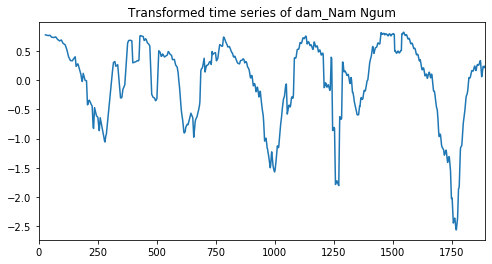

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000952      0.000282         0.000566        0.000131           0    0.0001          -0.214628           0.253191           0.135596          -0.013385           0.430919         0.118338        0.221092                5
1       0.002945      0.003698         0.000626        0.000014         0.5    0.0001          -0.212376           0.253201           0.135641          -0.011867           0.430921         0.119104        0.220235                4
2       0.002876      0.003178         0.000631        0.000016           1    0.0001          -0.210233           0.253208           0.135687          -0.010396           0.430923         0.119838        0.219417                3
3       0.002765      0.003348         0.000622        0.000009           2    0.0001          -0.206205           0.253216           0.135780          -0.007582           0.430925         0.121227        0.217876                2
4       0.002400      0.002642         0.000617        0.000007          10    0.0001          -0.181329           0.253095           0.136533           0.010411           0.430891         0.129920        0.208307                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.065697      0.040142         0.003553        0.000787     0.1             2000            2           0.1       linear          -0.152733           0.236109           0.140552           0.156261           0.394365         0.154911        0.178204                5
1        0.045655      0.034546         0.006527        0.002848     0.1             2000            2           0.1          rbf          -0.039767           0.338227           0.029442           0.374322           0.208755         0.182196        0.164052                3
2        0.048048      0.035316         0.003961        0.001781     0.1             2000            2           0.1         poly          -0.614715          -0.070517          -1.113257          -0.503043          -0.150186        -0.490344        0.372991               26
3        0.027916      0.018586         0.000657        0.000203     0.1             2000            2             1       linear          -0.459325          -0.124019           0.075409          -0.773257           0.278123        -0.200614        0.375792               15
4        0.007660      0.005370         0.001213        0.000462     0.1             2000            2             1          rbf          -0.458688          -0.324445           0.037617          -0.863282           0.203113        -0.281137        0.376403               21
5        0.018109      0.018449         0.001005        0.000368     0.1             2000            2             1         poly          -0.398328          -0.211608          -0.547961          -1.069442           0.157518        -0.413964        0.403829               25
6        0.052961      0.039284         0.002783        0.001224     0.1             2000            3           0.1       linear          -0.152733           0.236109           0.140552           0.156261           0.394365         0.154911        0.178204                5
7        0.043681      0.034627         0.006163        0.002882     0.1             2000            3           0.1          rbf          -0.039767           0.338227           0.029442           0.374322           0.208755         0.182196        0.164052                3
8        0.070528      0.059530         0.003523        0.001651     0.1             2000            3           0.1         poly          -0.318913          -0.171495        -101.501962          -1.139015         -12.687738       -23.163825       39.451848               32
9        0.028189      0.018463         0.000760        0.000134     0.1             2000            3             1       linear          -0.459325          -0.124019           0.075409          -0.773257           0.278123        -0.200614        0.375792               15
10       0.007593      0.005439         0.001215        0.000460     0.1             2000            3             1          rbf          -0.458688          -0.324445           0.037617          -0.863282           0.203113        -0.281137        0.376403               21
11       0.021946      0.020904         0.000828        0.000279     0.1             2000            3             1         poly          -0.360054          -0.299059         -30.958702          -2.202614          -6.049328        -7.973951       11.680639               31
12       0.161076      0.144585         0.002679        0.001180       1             2000            2           0.1       linear          -0.164823           0.232776           0.145584           0.132515           0.402232         0.149656        0.184343                7
13       0.057489      0.040547         0.006382        0.002922       1             2000            2           0.1          rbf          -0.180930      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001298      0.000191         0.000560        0.000018           0    0.0001          -0.284661           0.251085           0.186330          -0.164984           0.457027         0.088960        0.273978                5
1       0.001246      0.000217         0.000553        0.000005         0.5    0.0001          -0.277989           0.251422           0.186151          -0.162064           0.457571         0.091018        0.271793                4
2       0.001238      0.000223         0.000555        0.000016           1    0.0001          -0.271933           0.251549           0.185973          -0.159349           0.458081         0.092864        0.269786                3
3       0.001699      0.001086         0.000574        0.000029           2    0.0001          -0.261057           0.251534           0.185632          -0.154385           0.459020         0.096149        0.266154                2
4       0.005536      0.005209         0.000568        0.000020          10    0.0001          -0.200054           0.250010           0.183617          -0.125479           0.464191         0.114457        0.245747                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.151103      0.117257         0.009187        0.003297     0.1             2000            2           0.1       linear          -0.143637           0.129141           0.150913           0.321873           0.408250         0.173308        0.189829                3
1        0.067506      0.052597         0.012173        0.005933     0.1             2000            2           0.1          rbf           0.038134           0.226001           0.059946           0.319756           0.296432         0.188054        0.117829                1
2        0.066374      0.053108         0.009929        0.005347     0.1             2000            2           0.1         poly          -0.179222          -0.041352          -0.024447         -66.912219          -0.209823       -13.473412       26.719503               28
3        0.035642      0.025071         0.001509        0.000606     0.1             2000            2             1       linear          -0.545429          -0.010124           0.118245          -0.793202           0.442937        -0.157515        0.450086               13
4        0.012194      0.009605         0.002172        0.000964     0.1             2000            2             1          rbf          -0.266710          -0.112074           0.053246          -1.520715           0.254149        -0.318421        0.625578               19
5        0.012280      0.011131         0.001741        0.000943     0.1             2000            2             1         poly          -0.176937          -0.239172          -0.054320         -20.558198           0.178471        -4.170031        8.195328               25
6        0.138625      0.119066         0.008416        0.003789     0.1             2000            3           0.1       linear          -0.143637           0.129141           0.150913           0.321873           0.408250         0.173308        0.189829                3
7        0.068802      0.054378         0.012293        0.006038     0.1             2000            3           0.1          rbf           0.038134           0.226001           0.059946           0.319756           0.296432         0.188054        0.117829                1
8        0.072355      0.053947         0.009291        0.004149     0.1             2000            3           0.1         poly           0.026953           0.100884          -0.793536       -1109.012929          -1.248628      -222.185451      443.414029               32
9        0.033502      0.023715         0.001404        0.000582     0.1             2000            3             1       linear          -0.545429          -0.010124           0.118245          -0.793202           0.442937        -0.157515        0.450086               13
10       0.011398      0.008575         0.002102        0.000925     0.1             2000            3             1          rbf          -0.266710          -0.112074           0.053246          -1.520715           0.254149        -0.318421        0.625578               19
11       0.012252      0.009228         0.001489        0.000651     0.1             2000            3             1         poly          -0.203077          -0.221003          -0.103952         -93.976741           0.037004       -18.893554       37.541706               29
12       0.705924      0.681099         0.008376        0.003856       1             2000            2           0.1       linear          -0.232030           0.137092           0.152787           0.305166           0.407607         0.154125        0.217474                7
13       0.086331      0.065440         0.011753        0.006140       1             2000            2           0.1          rbf          -0.177053      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001352      0.000273         0.000650        0.000016           0    0.0001           0.102688           0.236344           0.167775          -0.276318           0.335163         0.113130        0.209402                5
1       0.001351      0.000183         0.000636        0.000008         0.5    0.0001           0.103428           0.235999           0.167446          -0.272635           0.335847         0.114017        0.208113                4
2       0.001295      0.000197         0.000628        0.000010           1    0.0001           0.104041           0.235604           0.167124          -0.269267           0.336492         0.114799        0.206931                3
3       0.001294      0.000204         0.000628        0.000005           2    0.0001           0.105053           0.234795           0.166505          -0.263239           0.337679         0.116159        0.204816                2
4       0.001299      0.000219         0.000633        0.000017          10    0.0001           0.110365           0.230188           0.162446          -0.230393           0.344277         0.123377        0.193419                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.123199      0.091970         0.006986        0.002112     0.1             2000            2           0.1       linear           0.124648           0.084516           0.088550           0.314705           0.237860         0.170056        0.091151                3
1        0.061112      0.047482         0.010050        0.004686     0.1             2000            2           0.1          rbf           0.090025           0.169591           0.036990           0.215209           0.292604         0.160884        0.090275                7
2        0.054956      0.044483         0.006895        0.003249     0.1             2000            2           0.1         poly          -0.118470          -0.181411          -0.053365        -109.938505          -0.123605       -22.083072       43.927736               28
3        0.031408      0.019048         0.001043        0.000390     0.1             2000            2             1       linear           0.004046          -0.031922           0.120269          -1.311813           0.357578        -0.172368        0.585775               17
4        0.008428      0.006742         0.001497        0.000644     0.1             2000            2             1          rbf          -0.125906          -0.118111           0.055464          -1.578557           0.276784        -0.298065        0.656828               23
5        0.010051      0.008141         0.001190        0.000521     0.1             2000            2             1         poly          -0.168018          -0.187758           0.033314         -19.518648           0.100122        -3.948198        7.786025               25
6        0.113065      0.099756         0.006209        0.003154     0.1             2000            3           0.1       linear           0.124648           0.084516           0.088550           0.314705           0.237860         0.170056        0.091151                3
7        0.061319      0.047342         0.010137        0.004636     0.1             2000            3           0.1          rbf           0.090025           0.169591           0.036990           0.215209           0.292604         0.160884        0.090275                7
8        0.066434      0.052883         0.006841        0.003240     0.1             2000            3           0.1         poly          -0.011493           0.195864          -0.009076       -3348.949140          -0.018838      -669.758537     1339.595304               33
9        0.031476      0.019067         0.001071        0.000401     0.1             2000            3             1       linear           0.004046          -0.031922           0.120269          -1.311813           0.357578        -0.172368        0.585775               17
10       0.008887      0.007530         0.001509        0.000657     0.1             2000            3             1          rbf          -0.125906          -0.118111           0.055464          -1.578557           0.276784        -0.298065        0.656828               23
11       0.011556      0.010330         0.001187        0.000601     0.1             2000            3             1         poly          -0.159313          -0.142510           0.034051       -1923.181447           0.183694      -384.653105      769.264181               31
12       0.500069      0.463354         0.006092        0.002763       1             2000            2           0.1       linear           0.125385           0.085976           0.090111           0.307649           0.239247         0.169674        0.088515                5
13       0.074260      0.055061         0.009462        0.004719       1             2000            2           0.1          rbf           0.063982      

>>> Final results:



period = 15, future = 10, Node: dam_Nam Leuk, neighbors: ['rw_239']


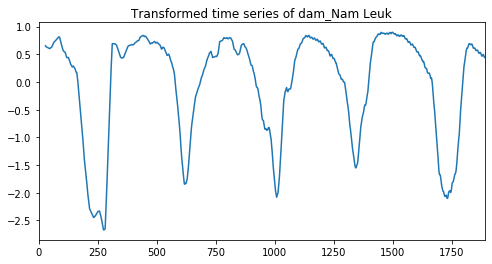

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001540      0.001073         0.000587        0.000144           0    0.0001           0.859995           0.558773           0.829818           0.842383           0.877182         0.793630        0.118515                5
1       0.001128      0.000099         0.000640        0.000034         0.5    0.0001           0.860312           0.561763           0.829898           0.842454           0.877351         0.794355        0.117401                4
2       0.001538      0.000834         0.000634        0.000030           1    0.0001           0.860508           0.564316           0.829952           0.842494           0.877502         0.794954        0.116439                3
3       0.001065      0.000116         0.000607        0.000005           2    0.0001           0.860687           0.568540           0.830007           0.842507           0.877760         0.795900        0.114827                2
4       0.001068      0.000119         0.000617        0.000014          10    0.0001           0.859200           0.586786           0.829457           0.841591           0.878817         0.799170        0.107490                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.060753      0.027010         0.003447        0.000629     0.1             2000            2           0.1       linear           0.849301           0.607010           0.808652           0.839477           0.878837         0.796655        0.097436                1
1        0.042235      0.031802         0.006174        0.002572     0.1             2000            2           0.1          rbf           0.727513           0.379053           0.796441           0.813475           0.887783         0.720853        0.178342                7
2        0.045526      0.035568         0.004143        0.001875     0.1             2000            2           0.1         poly           0.360002          -0.468644           0.354471           0.135805           0.568260         0.189979        0.356590               24
3        0.009760      0.007187         0.000433        0.000014     0.1             2000            2             1       linear           0.542047          -0.288217           0.716657           0.653349           0.816354         0.488038        0.398214               17
4        0.004276      0.002359         0.000847        0.000084     0.1             2000            2             1          rbf           0.257070          -0.788584           0.294124           0.120303           0.678970         0.112376        0.487194               27
5        0.010047      0.007792         0.001026        0.000272     0.1             2000            2             1         poly           0.070941          -0.672545           0.258786          -0.108760           0.597872         0.029259        0.421739               33
6        0.050051      0.030414         0.002754        0.001274     0.1             2000            3           0.1       linear           0.849301           0.607010           0.808652           0.839477           0.878837         0.796655        0.097436                1
7        0.041705      0.031868         0.006061        0.002628     0.1             2000            3           0.1          rbf           0.727513           0.379053           0.796441           0.813475           0.887783         0.720853        0.178342                7
8        0.048235      0.037431         0.004008        0.001715     0.1             2000            3           0.1         poly           0.396771          -0.030614           0.414150           0.349718           0.568620         0.339729        0.199217               21
9        0.009774      0.007214         0.000432        0.000011     0.1             2000            3             1       linear           0.542047          -0.288217           0.716657           0.653349           0.816354         0.488038        0.398214               17
10       0.004329      0.002418         0.000853        0.000091     0.1             2000            3             1          rbf           0.257070          -0.788584           0.294124           0.120303           0.678970         0.112376        0.487194               27
11       0.027829      0.019420         0.000981        0.000252     0.1             2000            3             1         poly          -0.020450          -0.910887           0.218209          -0.038870           0.467591        -0.056881        0.465129               36
12       0.130010      0.081172         0.002941        0.001049       1             2000            2           0.1       linear           0.849514           0.598542           0.808192           0.840212           0.878040         0.794900        0.100679                3
13       0.049231      0.038147         0.005794        0.002586       1             2000            2           0.1          rbf           0.726792      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001308      0.000260         0.000642        0.000014           0    0.0001           0.746531           0.573683           0.822451           0.816304           0.872155         0.766225        0.104260                5
1       0.001356      0.000214         0.000639        0.000013         0.5    0.0001           0.748813           0.576996           0.822610           0.816378           0.872354         0.767430        0.103016                4
2       0.001295      0.000200         0.000627        0.000009           1    0.0001           0.750552           0.579775           0.822733           0.816419           0.872533         0.768402        0.101980                3
3       0.001290      0.000200         0.000620        0.000006           2    0.0001           0.753125           0.584300           0.822903           0.816432           0.872841         0.769920        0.100300                2
4       0.001296      0.000194         0.000624        0.000008          10    0.0001           0.761117           0.603423           0.822750           0.815440           0.874155         0.775377        0.093143                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.101033      0.063796         0.005720        0.001408     0.1             2000            2           0.1       linear           0.817208           0.609078           0.806812           0.833437           0.876337         0.788574        0.092829                1
1        0.055331      0.041313         0.009535        0.004120     0.1             2000            2           0.1          rbf           0.823769           0.603164           0.434295           0.608458           0.568038         0.607545        0.125179                9
2        0.055423      0.043931         0.007244        0.003433     0.1             2000            2           0.1         poly           0.331390          -0.249681          -1.104249          -0.449631           0.606469        -0.173140        0.601932               25
3        0.028701      0.015159         0.000709        0.000175     0.1             2000            2             1       linear           0.445945          -0.254618           0.651540           0.388034           0.801036         0.406387        0.361850               17
4        0.008871      0.005223         0.001649        0.000302     0.1             2000            2             1          rbf           0.213285          -0.862867           0.088716          -0.135059           0.534269        -0.032331        0.468265               23
5        0.016768      0.015175         0.001708        0.000735     0.1             2000            2             1         poly           0.011886          -0.689065          -0.822902          -0.246622           0.621989        -0.224943        0.519002               26
6        0.086757      0.063556         0.004893        0.002038     0.1             2000            3           0.1       linear           0.817208           0.609078           0.806812           0.833437           0.876337         0.788574        0.092829                1
7        0.055068      0.041386         0.009469        0.004049     0.1             2000            3           0.1          rbf           0.823769           0.603164           0.434295           0.608458           0.568038         0.607545        0.125179                9
8        0.060313      0.046575         0.007175        0.003097     0.1             2000            3           0.1         poly           0.442252           0.126136          -6.621627           0.396483           0.503659        -1.030619        2.798479               32
9        0.028342      0.014874         0.000638        0.000045     0.1             2000            3             1       linear           0.445945          -0.254618           0.651540           0.388034           0.801036         0.406387        0.361850               17
10       0.008965      0.005258         0.001653        0.000304     0.1             2000            3             1          rbf           0.213285          -0.862867           0.088716          -0.135059           0.534269        -0.032331        0.468265               23
11       0.021303      0.018589         0.001298        0.000339     0.1             2000            3             1         poly          -0.041942          -0.952792          -3.974842           0.012065           0.600265        -0.871449        1.629251               31
12       0.403829      0.327940         0.004878        0.002053       1             2000            2           0.1       linear           0.812175           0.601417           0.806026           0.834282           0.875082         0.785796        0.095314                3
13       0.066471      0.047146         0.008502        0.003625       1             2000            2           0.1          rbf           0.795704      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001253      0.000657         0.000561        0.000125           0    0.0001          -1.203330          -0.779297           0.182436          -0.462347           0.170068        -0.418494        0.539554                5
1       0.001088      0.000123         0.000621        0.000007         0.5    0.0001          -1.198692          -0.779227           0.182446          -0.462182           0.170046        -0.417522        0.538191                4
2       0.001088      0.000112         0.000614        0.000008           1    0.0001          -1.194770          -0.779162           0.182453          -0.462026           0.170024        -0.416696        0.537039                3
3       0.001054      0.000114         0.000602        0.000004           2    0.0001          -1.188052          -0.779043           0.182463          -0.461739           0.169980        -0.415278        0.535067                2
4       0.001065      0.000123         0.000616        0.000012          10    0.0001          -1.152833          -0.778360           0.182517          -0.460115           0.169654        -0.407827        0.524796                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.068261      0.039262         0.004041        0.001033     0.1             2000            2           0.1       linear          -0.230390          -0.054877           0.435216          -0.462021           0.042558        -0.053903        0.298748                3
1        0.053853      0.041248         0.007936        0.003407     0.1             2000            2           0.1          rbf           0.152132           0.089503          -0.092038          -0.155131          -0.126847        -0.026476        0.123513                1
2        0.049393      0.034114         0.004283        0.001771     0.1             2000            2           0.1         poly          -0.083331           0.024716          -0.451736          -0.951240          -0.321255        -0.356569        0.341752                9
3        0.037248      0.023410         0.001441        0.000284     0.1             2000            2             1       linear          -0.836639          -1.301562          -0.049627          -0.710660           0.076082        -0.564481        0.512664               15
4        0.019386      0.011766         0.003132        0.000655     0.1             2000            2             1          rbf          -0.649223          -1.459908          -0.101271          -0.456213           0.059562        -0.521411        0.532055               13
5        0.024645      0.020975         0.001740        0.000375     0.1             2000            2             1         poly          -0.708603          -1.250398          -1.001583          -0.684673           0.049834        -0.719085        0.436950               21
6        0.059199      0.042427         0.003343        0.001386     0.1             2000            3           0.1       linear          -0.230390          -0.054877           0.435216          -0.462021           0.042558        -0.053903        0.298748                3
7        0.051033      0.039876         0.007532        0.003352     0.1             2000            3           0.1          rbf           0.152132           0.089503          -0.092038          -0.155131          -0.126847        -0.026476        0.123513                1
8        0.057572      0.038455         0.004312        0.001796     0.1             2000            3           0.1         poly          -0.069826          -0.089365          -2.242333          -2.102138          -0.399905        -0.980713        0.980901               25
9        0.037732      0.024015         0.001485        0.000358     0.1             2000            3             1       linear          -0.836639          -1.301562          -0.049627          -0.710660           0.076082        -0.564481        0.512664               15
10       0.019493      0.011687         0.003444        0.001121     0.1             2000            3             1          rbf          -0.649223          -1.459908          -0.101271          -0.456213           0.059562        -0.521411        0.532055               13
11       0.038101      0.027309         0.001863        0.000350     0.1             2000            3             1         poly          -0.678584          -1.362517          -2.386780          -0.683535           0.059226        -1.010438        0.822125               26
12       0.148851      0.121321         0.003339        0.001326       1             2000            2           0.1       linear          -0.246772          -0.053182           0.437429          -0.464545           0.039665        -0.057481        0.301968                5
13       0.063982      0.045420         0.007712        0.003275       1             2000            2           0.1          rbf          -1.222665      

>>> Final results:



period = 15, future = 10, Node: dam_Nam Mang 3, neighbors: ['rw_239']


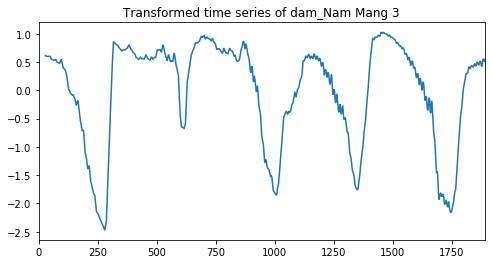

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000948      0.000282         0.000560        0.000125           0    0.0001          -0.254504           0.624155           0.755277           0.835330           0.773025         0.546656        0.406439                5
1       0.001074      0.000117         0.000626        0.000015         0.5    0.0001          -0.250631           0.625447           0.755259           0.835291           0.772967         0.547667        0.404947                4
2       0.001542      0.000975         0.000635        0.000040           1    0.0001          -0.247228           0.626655           0.755237           0.835249           0.772907         0.548564        0.403637                3
3       0.001092      0.000130         0.000646        0.000067           2    0.0001          -0.241399           0.628860           0.755185           0.835158           0.772777         0.550116        0.401392                2
4       0.001105      0.000111         0.000623        0.000005          10    0.0001          -0.212783           0.640891           0.754656           0.834296           0.771570         0.557726        0.390282                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.067862      0.037298         0.003666        0.001025     0.1             2000            2           0.1       linear          -0.290495           0.693367           0.739063           0.822432           0.777330         0.548340        0.421572                5
1        0.048266      0.036332         0.006791        0.002978     0.1             2000            2           0.1          rbf          -0.054388           0.703253           0.576383           0.790715           0.763965         0.555986        0.314011                3
2        0.046411      0.035222         0.004191        0.001856     0.1             2000            2           0.1         poly          -0.907085          -0.115933           0.102180           0.296052           0.498784        -0.025200        0.485786               27
3        0.028050      0.017545         0.000565        0.000062     0.1             2000            2             1       linear          -1.089454           0.182544           0.591927           0.593398           0.625705         0.180824        0.655858               17
4        0.006027      0.003319         0.001071        0.000136     0.1             2000            2             1          rbf          -1.473780          -0.062415           0.563402           0.544301           0.617794         0.037860        0.795501               24
5        0.014502      0.012023         0.001222        0.000394     0.1             2000            2             1         poly          -1.781692          -0.904848           0.378626           0.119085           0.561847        -0.325397        0.887353               32
6        0.056435      0.038356         0.002894        0.001213     0.1             2000            3           0.1       linear          -0.290495           0.693367           0.739063           0.822432           0.777330         0.548340        0.421572                5
7        0.050332      0.038191         0.007180        0.003169     0.1             2000            3           0.1          rbf          -0.054388           0.703253           0.576383           0.790715           0.763965         0.555986        0.314011                3
8        0.051801      0.039236         0.003998        0.001582     0.1             2000            3           0.1         poly          -0.655745           0.248191           0.157028           0.533478           0.398817         0.136354        0.416401               21
9        0.026539      0.016580         0.000542        0.000060     0.1             2000            3             1       linear          -1.089454           0.182544           0.591927           0.593398           0.625705         0.180824        0.655858               17
10       0.005661      0.003076         0.001015        0.000104     0.1             2000            3             1          rbf          -1.473780          -0.062415           0.563402           0.544301           0.617794         0.037860        0.795501               24
11       0.018777      0.015970         0.000935        0.000239     0.1             2000            3             1         poly          -1.968504          -0.587908           0.368178           0.333468           0.547760        -0.261401        0.940828               29
12       0.137170      0.101996         0.002818        0.001213       1             2000            2           0.1       linear          -0.316345           0.674702           0.744433           0.824995           0.776494         0.540856        0.431373                7
13       0.059581      0.044188         0.006664        0.003189       1             2000            2           0.1          rbf           0.036608      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001331      0.000269         0.000653        0.000017           0    0.0001          -0.349719           0.646233           0.666420           0.838878           0.734780         0.507318        0.433773                5
1       0.001343      0.000200         0.000660        0.000029         0.5    0.0001          -0.338723           0.647482           0.666818           0.838974           0.734726         0.509855        0.429546                4
2       0.001302      0.000201         0.000628        0.000006           1    0.0001          -0.329731           0.648574           0.667173           0.839060           0.734669         0.511949        0.426097                3
3       0.001312      0.000198         0.000627        0.000005           2    0.0001          -0.314825           0.650434           0.667784           0.839208           0.734546         0.515429        0.420382                2
4       0.002421      0.001488         0.000671        0.000066          10    0.0001          -0.241637           0.658946           0.670645           0.839679           0.733379         0.532202        0.392192                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.116179      0.080209         0.006642        0.001937     0.1             2000            2           0.1       linear          -0.274787           0.698150           0.754803           0.827178           0.758605         0.552790        0.415806                1
1        0.066585      0.051295         0.010861        0.005000     0.1             2000            2           0.1          rbf           0.003237           0.669837           0.172296           0.706265           0.439792         0.398285        0.274754                9
2        0.057638      0.044567         0.006958        0.003284     0.1             2000            2           0.1         poly          -0.956809           0.019684          -4.340191           0.216081           0.354646        -0.941318        1.760409               25
3        0.029570      0.018120         0.000850        0.000099     0.1             2000            2             1       linear          -1.096616           0.196333           0.488433           0.562107           0.583683         0.146788        0.636961               13
4        0.009625      0.006007         0.001729        0.000385     0.1             2000            2             1          rbf          -1.569179          -0.194363           0.283897           0.282880           0.442511        -0.150851        0.740642               23
5        0.017825      0.014740         0.001841        0.000756     0.1             2000            2             1         poly          -2.764293          -0.725185          -2.295077           0.035347           0.546863        -1.040469        1.290118               26
6        0.102801      0.083480         0.005674        0.002612     0.1             2000            3           0.1       linear          -0.274787           0.698150           0.754803           0.827178           0.758605         0.552790        0.415806                1
7        0.062165      0.048244         0.010294        0.004896     0.1             2000            3           0.1          rbf           0.003237           0.669837           0.172296           0.706265           0.439792         0.398285        0.274754                9
8        0.062572      0.045545         0.006753        0.002909     0.1             2000            3           0.1         poly          -0.385909           0.351887          -8.472293           0.394102           0.272559        -1.567931        3.463815               28
9        0.028345      0.018246         0.000809        0.000164     0.1             2000            3             1       linear          -1.096616           0.196333           0.488433           0.562107           0.583683         0.146788        0.636961               13
10       0.009887      0.006427         0.001917        0.000709     0.1             2000            3             1          rbf          -1.569179          -0.194363           0.283897           0.282880           0.442511        -0.150851        0.740642               23
11       0.016872      0.011619         0.001612        0.000339     0.1             2000            3             1         poly          -2.600956          -0.307288          -9.569100           0.228226           0.529378        -2.343948        3.775949               32
12       0.415816      0.343120         0.006289        0.003193       1             2000            2           0.1       linear          -0.313452           0.675354           0.756611           0.827875           0.758191         0.540915        0.429906                3
13       0.080274      0.059835         0.010275        0.004713       1             2000            2           0.1          rbf           0.107665      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003135      0.003482         0.000572        0.000129           0    0.0001          -3.398670          -0.570709          -0.862848          -0.172319          -0.145657        -1.030041        1.213850                5
1       0.002841      0.003610         0.000625        0.000037         0.5    0.0001          -3.393602          -0.570350          -0.862373          -0.172275          -0.145647        -1.028849        1.211921                4
2       0.002818      0.003559         0.000612        0.000010           1    0.0001          -3.389419          -0.570035          -0.861921          -0.172235          -0.145637        -1.027849        1.210332                3
3       0.002859      0.003669         0.000610        0.000007           2    0.0001          -3.382374          -0.569497          -0.861074          -0.172165          -0.145619        -1.026146        1.207659                2
4       0.002858      0.003648         0.000618        0.000013          10    0.0001          -3.346649          -0.567036          -0.855885          -0.171832          -0.145506        -1.017382        1.194110                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.063484      0.032746         0.004034        0.001135     0.1             2000            2           0.1       linear          -1.685227          -0.014119          -1.085922          -0.242605          -0.725817        -0.750738        0.597837                4
1        0.055056      0.041930         0.008059        0.003334     0.1             2000            2           0.1          rbf          -1.173796          -0.000553          -0.781056          -0.052334          -0.706808        -0.542910        0.450868                1
2        0.048963      0.032982         0.004023        0.001789     0.1             2000            2           0.1         poly          -1.096961           0.003184          -1.383996          -0.570484          -0.572332        -0.724118        0.479596                3
3        0.039425      0.025975         0.001403        0.000441     0.1             2000            2             1       linear          -3.342012          -1.141124          -0.246324          -0.122102          -0.134699        -0.997252        1.232264               12
4        0.019862      0.014517         0.003088        0.001073     0.1             2000            2             1          rbf          -5.143320          -1.116712           0.063583          -0.136232          -0.111985        -1.288933        1.971253               21
5        0.028424      0.020611         0.001644        0.000460     0.1             2000            2             1         poly          -4.088621          -1.098607          -0.030616          -0.230820          -0.055496        -1.100832        1.544144               18
6        0.052343      0.035150         0.003320        0.001533     0.1             2000            3           0.1       linear          -1.685227          -0.014119          -1.085922          -0.242605          -0.725817        -0.750738        0.597837                4
7        0.052130      0.040342         0.007943        0.003425     0.1             2000            3           0.1          rbf          -1.173796          -0.000553          -0.781056          -0.052334          -0.706808        -0.542910        0.450868                1
8        0.061206      0.043160         0.004044        0.001830     0.1             2000            3           0.1         poly          -1.379623           0.005965          -2.378215          -0.242614          -0.624205        -0.923738        0.865024               11
9        0.038542      0.024560         0.001391        0.000422     0.1             2000            3             1       linear          -3.342012          -1.141124          -0.246324          -0.122102          -0.134699        -0.997252        1.232264               12
10       0.020582      0.015733         0.003123        0.001131     0.1             2000            3             1          rbf          -5.143320          -1.116712           0.063583          -0.136232          -0.111985        -1.288933        1.971253               21
11       0.037122      0.025430         0.001685        0.000456     0.1             2000            3             1         poly          -3.563281          -1.133064          -4.830523          -0.129545          -0.058866        -1.943056        1.921337               29
12       0.121019      0.089784         0.003248        0.001442       1             2000            2           0.1       linear          -1.714800          -0.015638          -1.082398          -0.249203          -0.729225        -0.758253        0.605228                6
13       0.064513      0.046542         0.007636        0.003484       1             2000            2           0.1          rbf          -5.788665      

>>> Final results:



period = 15, future = 10, Node: rw_242, neighbors: ['dam_Nam Ngum', 'rw_239']


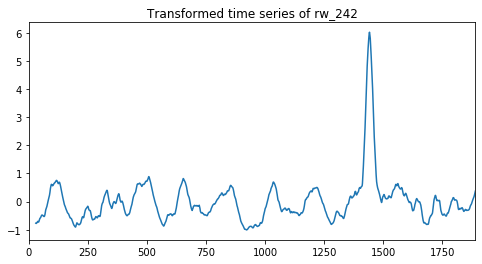

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000962      0.000267         0.000563        0.000130           0    0.0001           0.277203           0.467321           0.363981           0.425801          -0.470153         0.212831        0.347442                5
1       0.001166      0.000303         0.000621        0.000023         0.5    0.0001           0.277359           0.467213           0.363576           0.425131          -0.467801         0.213096        0.346390                4
2       0.001167      0.000183         0.000620        0.000008           1    0.0001           0.277385           0.467095           0.363169           0.424494          -0.465635         0.213301        0.345408                3
3       0.001899      0.000861         0.000624        0.000045           2    0.0001           0.277262           0.466862           0.362376           0.423298          -0.461755         0.213609        0.343630                2
4       0.001125      0.000088         0.000625        0.000018          10    0.0001           0.275068           0.465032           0.357449           0.415888          -0.441911         0.214305        0.334156                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.073334      0.053242         0.004790        0.000952     0.1             2000            2           0.1       linear           0.197510           0.507390           0.334070           0.436742          -0.165217         0.262099        0.237747                5
1        0.053283      0.041677         0.007665        0.003506     0.1             2000            2           0.1          rbf           0.133644           0.368202           0.362314          -0.093911          -0.208865         0.112277        0.234145                7
2        0.047205      0.039927         0.004498        0.001821     0.1             2000            2           0.1         poly          -0.392892          -0.101344          -0.098741          -3.047082          -0.209372        -0.769886        1.143618               26
3        0.013844      0.019534         0.000533        0.000177     0.1             2000            2             1       linear           0.126188           0.041607           0.100273           0.211583          -0.378309         0.020268        0.206659               13
4        0.005071      0.004622         0.000808        0.000305     0.1             2000            2             1          rbf           0.134631          -0.080403           0.085748          -0.081173          -0.586441        -0.105528        0.255642               19
5        0.010883      0.014217         0.000764        0.000236     0.1             2000            2             1         poly          -0.022663          -0.088999          -0.033028          -4.291137          -0.368056        -0.960777        1.669933               29
6        0.060450      0.052253         0.003191        0.001407     0.1             2000            3           0.1       linear           0.197510           0.507390           0.334070           0.436742          -0.165217         0.262099        0.237747                5
7        0.053234      0.042429         0.007788        0.003950     0.1             2000            3           0.1          rbf           0.133644           0.368202           0.362314          -0.093911          -0.208865         0.112277        0.234145                7
8        0.088878      0.093698         0.004364        0.001827     0.1             2000            3           0.1         poly          -0.061620           0.389605           0.171153        -976.658296          -0.017231      -195.235278      390.711542               33
9        0.013754      0.019210         0.000509        0.000126     0.1             2000            3             1       linear           0.126188           0.041607           0.100273           0.211583          -0.378309         0.020268        0.206659               13
10       0.005044      0.004684         0.000816        0.000303     0.1             2000            3             1          rbf           0.134631          -0.080403           0.085748          -0.081173          -0.586441        -0.105528        0.255642               19
11       0.013583      0.021171         0.000654        0.000254     0.1             2000            3             1         poly           0.074868           0.184131           0.055075       -1165.066286          -0.117836      -232.974010      466.046148               35
12       0.172438      0.197005         0.003179        0.001384       1             2000            2           0.1       linear           0.213783           0.505529           0.336019           0.442109          -0.177739         0.263940        0.242034                1
13       0.069159      0.047438         0.007810        0.003524       1             2000            2           0.1          rbf           0.027161      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004087      0.004429         0.000748        0.000262           0    0.0001           0.038318           0.368323           0.307902           0.447850          -0.649683         0.102542        0.400504                5
1       0.001295      0.000260         0.000561        0.000014         0.5    0.0001           0.040838           0.368640           0.308284           0.447192          -0.647740         0.103443        0.399662                4
2       0.001246      0.000224         0.000555        0.000003           1    0.0001           0.042034           0.368915           0.308575           0.446566          -0.645953         0.104027        0.398911                3
3       0.001262      0.000269         0.000551        0.000009           2    0.0001           0.043229           0.369389           0.308989           0.445393          -0.642762         0.104848        0.397579                2
4       0.001271      0.000229         0.000563        0.000011          10    0.0001           0.044089           0.371479           0.309826           0.438133          -0.626518         0.107402        0.390575                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.153820      0.133297         0.010269        0.003181     0.1             2000            2           0.1       linear          -0.028769           0.461343           0.239505           0.462095          -0.274521         0.171930        0.287096                1
1        0.082091      0.065682         0.015354        0.007525     0.1             2000            2           0.1          rbf           0.007939           0.442414           0.098591          -0.199573          -0.312611         0.007352        0.261839                7
2        0.070623      0.056549         0.010630        0.005223     0.1             2000            2           0.1         poly          -0.160937          -0.017935         -15.369044          -3.168029          -0.395889        -3.822367        5.888539               29
3        0.032040      0.022153         0.001009        0.000509     0.1             2000            2             1       linear           0.036335           0.021197          -0.288805           0.234625          -0.611467        -0.121623        0.296701               13
4        0.007616      0.007225         0.001604        0.001095     0.1             2000            2             1          rbf           0.102127          -0.018603          -0.157915          -0.111705          -0.339497        -0.105119        0.147105               11
5        0.011203      0.012171         0.001235        0.000768     0.1             2000            2             1         poly           0.068158          -0.072611          -3.159527          -1.115970          -0.263370        -0.908664        1.198243               25
6        0.142362      0.133690         0.009214        0.004170     0.1             2000            3           0.1       linear          -0.028769           0.461343           0.239505           0.462095          -0.274521         0.171930        0.287096                1
7        0.088555      0.071406         0.016011        0.007733     0.1             2000            3           0.1          rbf           0.007939           0.442414           0.098591          -0.199573          -0.312611         0.007352        0.261839                7
8        0.074177      0.058841         0.009956        0.004871     0.1             2000            3           0.1         poly          -0.429739           0.236304         -15.238308        -374.046993          -1.626251       -78.220997      148.022716               34
9        0.033792      0.022341         0.001082        0.000467     0.1             2000            3             1       linear           0.036335           0.021197          -0.288805           0.234625          -0.611467        -0.121623        0.296701               13
10       0.007641      0.007244         0.001428        0.000760     0.1             2000            3             1          rbf           0.102127          -0.018603          -0.157915          -0.111705          -0.339497        -0.105119        0.147105               11
11       0.010051      0.009770         0.001225        0.000569     0.1             2000            3             1         poly          -0.012619          -0.095041          -0.641065          -9.778060          -0.220405        -2.149438        3.820439               28
12       0.742895      0.797878         0.009227        0.004181       1             2000            2           0.1       linear          -0.062506           0.440273           0.242649           0.463642          -0.278934         0.161025        0.289741                3
13       0.097568      0.073670         0.015260        0.008195       1             2000            2           0.1          rbf          -0.092753      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003521      0.002967         0.000657        0.000017           0    0.0001          -0.423728          -0.041854          -0.017254          -0.071924          -1.002113        -0.311375        0.375827                5
1       0.003399      0.002822         0.000652        0.000036         0.5    0.0001          -0.421219          -0.041855          -0.016137          -0.071933          -1.001835        -0.310596        0.375749                4
2       0.003287      0.003988         0.000632        0.000008           1    0.0001          -0.419445          -0.041851          -0.015167          -0.071944          -1.001563        -0.309994        0.375696                3
3       0.002832      0.003086         0.000633        0.000008           2    0.0001          -0.416763          -0.041829          -0.013527          -0.071968          -1.001037        -0.309025        0.375605                2
4       0.002298      0.002000         0.000631        0.000003          10    0.0001          -0.405129          -0.041341          -0.005689          -0.072195          -0.997418        -0.304354        0.374905                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.114349      0.075598         0.007948        0.002337     0.1             2000            2           0.1       linear          -0.497513           0.023672          -0.141766          -0.073443          -0.458068        -0.229424        0.209867                7
1        0.070719      0.055860         0.012010        0.005621     0.1             2000            2           0.1          rbf          -0.411028           0.198534          -0.038677          -0.177745          -0.334754        -0.152734        0.217656                3
2        0.061763      0.048800         0.008830        0.005098     0.1             2000            2           0.1         poly          -0.497860          -0.014583          -5.816774          -0.320598          -0.775784        -1.485120        2.179892               29
3        0.030969      0.021514         0.001084        0.000448     0.1             2000            2             1       linear          -0.187771          -0.252373          -0.197764          -0.125247          -0.392074        -0.231046        0.090065                9
4        0.008376      0.007529         0.001425        0.000659     0.1             2000            2             1          rbf           0.030164          -0.061916          -0.227004          -0.104335          -0.248018        -0.122222        0.103906                1
5        0.010692      0.010202         0.001091        0.000582     0.1             2000            2             1         poly           0.043896          -0.099809          -2.621626          -0.202581          -0.538088        -0.683642        0.987782               25
6        0.094548      0.077689         0.006613        0.002970     0.1             2000            3           0.1       linear          -0.497513           0.023672          -0.141766          -0.073443          -0.458068        -0.229424        0.209867                7
7        0.071628      0.056529         0.011988        0.005736     0.1             2000            3           0.1          rbf          -0.411028           0.198534          -0.038677          -0.177745          -0.334754        -0.152734        0.217656                3
8        0.071593      0.056224         0.007957        0.003674     0.1             2000            3           0.1         poly          -0.499745          -0.039949        -102.213729          -0.291490         -12.601931       -23.129369       39.829519               34
9        0.032808      0.023238         0.001198        0.000528     0.1             2000            3             1       linear          -0.187771          -0.252373          -0.197764          -0.125247          -0.392074        -0.231046        0.090065                9
10       0.008723      0.007591         0.001489        0.000612     0.1             2000            3             1          rbf           0.030164          -0.061916          -0.227004          -0.104335          -0.248018        -0.122222        0.103906                1
11       0.015041      0.015332         0.001181        0.000582     0.1             2000            3             1         poly          -0.065271          -0.119604          -2.256980          -0.160194          -0.965658        -0.713541        0.839640               26
12       0.436193      0.417498         0.006682        0.002950       1             2000            2           0.1       linear          -0.512867           0.009280          -0.166289          -0.074262          -0.454534        -0.239734        0.207617               11
13       0.091683      0.069127         0.012740        0.006611       1             2000            2           0.1          rbf          -0.829535      

>>> Final results:



period = 15, future = 10, Node: dam_Nam Theun 2, neighbors: ['rw_239']


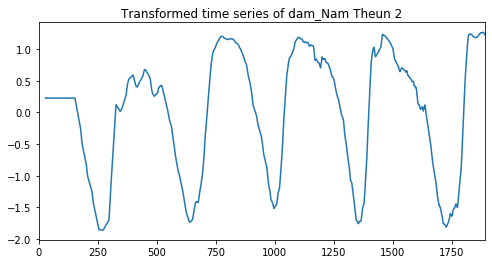

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000943      0.000270         0.000557        0.000117           0    0.0001           0.899716           0.863004           0.855686           0.831022           0.875595         0.865005        0.022639                3
1       0.002315      0.002461         0.000616        0.000004         0.5    0.0001           0.899435           0.862707           0.856349           0.831038           0.875664         0.865039        0.022508                1
2       0.003350      0.003446         0.000628        0.000023           1    0.0001           0.899114           0.862364           0.856880           0.831034           0.875712         0.865021        0.022383                2
3       0.003926      0.005628         0.000622        0.000012           2    0.0001           0.898466           0.861647           0.857675           0.830985           0.875767         0.864908        0.022171                4
4       0.001061      0.000122         0.003823        0.006432          10    0.0001           0.894417           0.856875           0.859318           0.829941           0.875518         0.863214        0.021389                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.049927      0.027979         0.002362        0.001011     0.1             2000            2           0.1       linear           0.901559           0.844857           0.852653           0.823951           0.872273         0.859058        0.026291                5
1        0.040434      0.032441         0.005500        0.002647     0.1             2000            2           0.1          rbf           0.861012           0.358964           0.817874           0.821769           0.884575         0.748839        0.196517               11
2        0.043566      0.036300         0.004006        0.002043     0.1             2000            2           0.1         poly           0.585144          -0.917617          -0.296172           0.074404           0.180755        -0.074697        0.506447               31
3        0.005431      0.002922         0.000428        0.000035     0.1             2000            2             1       linear          -0.574676           0.217558           0.375319           0.589664           0.791176         0.279808        0.469180               16
4        0.003594      0.002214         0.000740        0.000104     0.1             2000            2             1          rbf          -0.598239          -0.483151           0.365604           0.460448           0.565009         0.061934        0.497405               29
5        0.017400      0.015885         0.001515        0.000942     0.1             2000            2             1         poly          -0.603973          -0.706523          -0.068969           0.197732           0.165373        -0.203272        0.381723               35
6        0.040755      0.027542         0.002280        0.001146     0.1             2000            3           0.1       linear           0.901559           0.844857           0.852653           0.823951           0.872273         0.859058        0.026291                5
7        0.038117      0.031817         0.005128        0.002660     0.1             2000            3           0.1          rbf           0.861012           0.358964           0.817874           0.821769           0.884575         0.748839        0.196517               11
8        0.047664      0.037661         0.003672        0.001668     0.1             2000            3           0.1         poly           0.596544           0.574487           0.712087           0.622391           0.715446         0.644191        0.058807               14
9        0.005606      0.003061         0.000430        0.000036     0.1             2000            3             1       linear          -0.574676           0.217558           0.375319           0.589664           0.791176         0.279808        0.469180               16
10       0.003763      0.002337         0.000776        0.000117     0.1             2000            3             1          rbf          -0.598239          -0.483151           0.365604           0.460448           0.565009         0.061934        0.497405               29
11       0.010119      0.006460         0.000593        0.000135     0.1             2000            3             1         poly          -0.592610           0.013186           0.326773           0.476269           0.683302         0.181384        0.444381               22
12       0.089297      0.059837         0.002012        0.001012       1             2000            2           0.1       linear           0.902212           0.847157           0.851475           0.824297           0.872452         0.859519        0.026260                1
13       0.050438      0.038668         0.004760        0.002639       1             2000            2           0.1          rbf           0.909955      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001327      0.000252         0.000666        0.000028           0    0.0001           0.867692           0.829033           0.836546           0.841666           0.858957         0.846779        0.014363                4
1       0.001355      0.000206         0.000639        0.000007         0.5    0.0001           0.867297           0.829047           0.837281           0.841757           0.858970         0.846870        0.014138                2
2       0.001339      0.000197         0.000638        0.000005           1    0.0001           0.866776           0.828968           0.837866           0.841823           0.858965         0.846880        0.013925                1
3       0.001301      0.000200         0.000631        0.000006           2    0.0001           0.865740           0.828711           0.838743           0.841906           0.858919         0.846804        0.013577                3
4       0.001302      0.000198         0.000626        0.000004          10    0.0001           0.859497           0.826335           0.840991           0.841700           0.857952         0.845295        0.012271                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.088905      0.062350         0.004559        0.001822     0.1             2000            2           0.1       linear           0.907545           0.844926           0.845749           0.827414           0.864107         0.857948        0.027381                1
1        0.055059      0.046047         0.008792        0.004701     0.1             2000            2           0.1          rbf           0.777941           0.447424           0.587366           0.671385           0.727669         0.642357        0.116213               11
2        0.057472      0.047507         0.007230        0.003736     0.1             2000            2           0.1         poly           0.452451          -0.574497          -2.282770          -1.346263           0.166876        -0.716841        1.001675               31
3        0.017781      0.018837         0.000503        0.000132     0.1             2000            2             1       linear          -0.546886           0.241693           0.650474           0.603790           0.789260         0.347666        0.482442               17
4        0.006268      0.004756         0.001052        0.000411     0.1             2000            2             1          rbf          -0.602284          -0.408815           0.165483           0.247297           0.454157        -0.028833        0.405097               27
5        0.024131      0.026231         0.002261        0.001787     0.1             2000            2             1         poly          -0.598580          -0.674456          -0.471958          -1.250753           0.198484        -0.559452        0.463633               29
6        0.074893      0.061018         0.003894        0.002058     0.1             2000            3           0.1       linear           0.907545           0.844926           0.845749           0.827414           0.864107         0.857948        0.027381                1
7        0.054506      0.047321         0.008396        0.004689     0.1             2000            3           0.1          rbf           0.777941           0.447424           0.587366           0.671385           0.727669         0.642357        0.116213               11
8        0.060965      0.042348         0.006266        0.002957     0.1             2000            3           0.1         poly           0.481018           0.632716          -1.794056           0.573506           0.689545         0.116546        0.957791               22
9        0.017548      0.018559         0.000507        0.000136     0.1             2000            3             1       linear          -0.546886           0.241693           0.650474           0.603790           0.789260         0.347666        0.482442               17
10       0.006594      0.005157         0.001121        0.000485     0.1             2000            3             1          rbf          -0.602284          -0.408815           0.165483           0.247297           0.454157        -0.028833        0.405097               27
11       0.015665      0.014278         0.000867        0.000306     0.1             2000            3             1         poly          -0.587494           0.169351           0.175949           0.479188           0.623737         0.172146        0.418398               21
12       0.317534      0.265239         0.003875        0.001907       1             2000            2           0.1       linear           0.909300           0.846310           0.843821           0.826024           0.863895         0.857870        0.028378                3
13       0.065915      0.048440         0.007453        0.004075       1             2000            2           0.1          rbf           0.809080      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000979      0.000281         0.000567        0.000129           0    0.0001          -0.344585          -0.383563          -0.029301          -0.393150           0.208246        -0.188470        0.239602                5
1       0.001091      0.000129         0.000622        0.000005         0.5    0.0001          -0.344433          -0.383327          -0.029104          -0.393034           0.208267        -0.188326        0.239557                4
2       0.001095      0.000125         0.000625        0.000010           1    0.0001          -0.344356          -0.383129          -0.028931          -0.392926           0.208286        -0.188211        0.239525                3
3       0.001066      0.000111         0.000611        0.000005           2    0.0001          -0.344298          -0.382806          -0.028639          -0.392726           0.208320        -0.188030        0.239482                2
4       0.001062      0.000116         0.000613        0.000007          10    0.0001          -0.344620          -0.381430          -0.027472          -0.391620           0.208501        -0.187328        0.239327                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.067133      0.039363         0.004402        0.001358     0.1             2000            2           0.1       linear          -0.159845          -0.027103           0.116045          -0.349315           0.127816        -0.058481        0.179449                1
1        0.060321      0.047714         0.008625        0.003748     0.1             2000            2           0.1          rbf           0.320203           0.017609          -0.362799          -0.465178           0.127791        -0.072475        0.296958                7
2        0.045681      0.034183         0.004034        0.001721     0.1             2000            2           0.1         poly          -0.042014           0.009968          -0.354580          -0.861502          -0.069732        -0.263572        0.324742                9
3        0.037315      0.021538         0.001503        0.000655     0.1             2000            2             1       linear          -0.619785          -0.911392          -0.109481          -0.411984           0.165002        -0.377528        0.377114               20
4        0.021334      0.018546         0.003047        0.001748     0.1             2000            2             1          rbf          -0.614971          -0.823817          -0.227394          -0.282229           0.157733        -0.358136        0.338171               12
5        0.027139      0.023414         0.001809        0.000803     0.1             2000            2             1         poly          -0.607585          -1.045749          -0.377560          -0.896574           0.050180        -0.575458        0.388821               25
6        0.055299      0.041034         0.003523        0.001612     0.1             2000            3           0.1       linear          -0.159845          -0.027103           0.116045          -0.349315           0.127816        -0.058481        0.179449                1
7        0.055698      0.044082         0.008186        0.003651     0.1             2000            3           0.1          rbf           0.320203           0.017609          -0.362799          -0.465178           0.127791        -0.072475        0.296958                7
8        0.062439      0.044499         0.004220        0.001814     0.1             2000            3           0.1         poly          -0.131928          -0.022469          -5.129050          -1.524210          -0.126852        -1.386902        1.951763               32
9        0.039430      0.023055         0.001581        0.000703     0.1             2000            3             1       linear          -0.619785          -0.911392          -0.109481          -0.411984           0.165002        -0.377528        0.377114               20
10       0.023147      0.019849         0.003223        0.001789     0.1             2000            3             1          rbf          -0.614971          -0.823817          -0.227394          -0.282229           0.157733        -0.358136        0.338171               12
11       0.037281      0.023238         0.001875        0.000786     0.1             2000            3             1         poly          -0.624189          -1.042914          -1.346242          -2.438437           0.036251        -1.083106        0.821139               31
12       0.114387      0.087501         0.003572        0.001612       1             2000            2           0.1       linear          -0.156776          -0.031379           0.104167          -0.364078           0.124325        -0.064748        0.180810                3
13       0.067019      0.049511         0.008241        0.003918       1             2000            2           0.1          rbf          -0.235007      

>>> Final results:



period = 15, future = 10, Node: rw_239, neighbors: ['dam_Jinghong', 'dam_Nam Leuk', 'dam_Nam Mang 3', 'rw_242', 'dam_Nam Theun 2', 'rw_34']


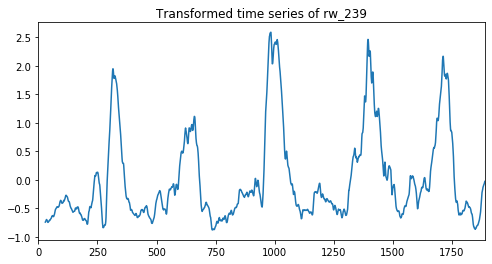

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000977      0.000286         0.000562        0.000123           0    0.0001           0.272374          -0.023997           0.522544           0.284465           0.421387         0.295355        0.184462                5
1       0.001071      0.000114         0.000615        0.000005         0.5    0.0001           0.275794          -0.023394           0.522840           0.284775           0.421413         0.296286        0.184245                4
2       0.001441      0.000654         0.000665        0.000092           1    0.0001           0.278094          -0.022863           0.523102           0.285062           0.421438         0.296967        0.184076                3
3       0.001079      0.000123         0.000628        0.000017           2    0.0001           0.281337          -0.021947           0.523552           0.285578           0.421487         0.298001        0.183805                2
4       0.001066      0.000113         0.000610        0.000005          10    0.0001           0.292795          -0.017351           0.525810           0.288245           0.421796         0.302259        0.182593                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.067501      0.039758         0.004308        0.000871     0.1             2000            2           0.1       linear           0.294849          -0.002007           0.528025           0.279541           0.411978         0.302477        0.176724                1
1        0.057274      0.044777         0.008212        0.003798     0.1             2000            2           0.1          rbf           0.392197           0.028648           0.396612           0.180964           0.384069         0.276498        0.148285                7
2        0.048474      0.035909         0.004037        0.001821     0.1             2000            2           0.1         poly           0.142817           0.082576           0.250371          -0.271575           0.235851         0.088008        0.190028               27
3        0.024649      0.022281         0.000802        0.000300     0.1             2000            2             1       linear           0.238734          -0.120621           0.485232           0.304439           0.394289         0.260415        0.207876               11
4        0.010203      0.008367         0.001519        0.000647     0.1             2000            2             1          rbf           0.165918          -0.133061           0.305493           0.230780           0.337565         0.181339        0.168137               21
5        0.014951      0.010232         0.000982        0.000334     0.1             2000            2             1         poly           0.165155          -0.079490           0.312743           0.014145           0.252721         0.133055        0.146255               25
6        0.055888      0.040623         0.003252        0.001393     0.1             2000            3           0.1       linear           0.294849          -0.002007           0.528025           0.279541           0.411978         0.302477        0.176724                1
7        0.054261      0.042265         0.007791        0.003712     0.1             2000            3           0.1          rbf           0.392197           0.028648           0.396612           0.180964           0.384069         0.276498        0.148285                7
8        0.072840      0.056143         0.004049        0.001940     0.1             2000            3           0.1         poly           0.024780           0.074198          -1.236314          -2.472328           0.203004        -0.681332        1.036064               32
9        0.023807      0.020884         0.000762        0.000234     0.1             2000            3             1       linear           0.238734          -0.120621           0.485232           0.304439           0.394289         0.260415        0.207876               11
10       0.010193      0.008341         0.001517        0.000628     0.1             2000            3             1          rbf           0.165918          -0.133061           0.305493           0.230780           0.337565         0.181339        0.168137               21
11       0.026443      0.022191         0.000956        0.000387     0.1             2000            3             1         poly           0.125042          -0.025420          -0.989779          -0.823105           0.252064        -0.292240        0.511852               31
12       0.148242      0.126572         0.003249        0.001412       1             2000            2           0.1       linear           0.268601          -0.004396           0.526752           0.277080           0.412108         0.296029        0.177805                3
13       0.067025      0.048635         0.007631        0.003778       1             2000            2           0.1          rbf           0.301484      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003052      0.001067         0.000747        0.000040           0    0.0001          -0.301894          -0.549294           0.568487           0.104132           0.336577         0.031602        0.408699                5
1       0.003068      0.000864         0.000702        0.000012         0.5    0.0001          -0.233303          -0.542082           0.569484           0.105046           0.337176         0.047264        0.396522                4
2       0.003077      0.000925         0.000714        0.000044           1    0.0001          -0.193849          -0.536903           0.570303           0.105858           0.337733         0.056628        0.389955                3
3       0.003043      0.000880         0.000727        0.000073           2    0.0001          -0.142607          -0.528801           0.571624           0.107282           0.338753         0.069250        0.381839                2
4       0.003035      0.000880         0.000697        0.000015          10    0.0001           0.020704          -0.492560           0.577219           0.115304           0.344480         0.113030        0.358973                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.275201      0.202133         0.027331        0.008823     0.1             2000            2           0.1       linear           0.129583          -0.879619           0.547401           0.218801           0.339997         0.071232        0.495635                9
1        0.148253      0.115721         0.032229        0.015314     0.1             2000            2           0.1          rbf           0.279596           0.026249           0.297537           0.273026           0.419204         0.259122        0.128019                1
2        0.118075      0.094418         0.024430        0.011757     0.1             2000            2           0.1         poly          -0.012201           0.048625          -0.017216          -1.790725           0.306219        -0.293059        0.758137               23
3        0.056536      0.042059         0.004152        0.002328     0.1             2000            2             1       linear          -1.944203          -0.298316           0.481844          -0.085476           0.301388        -0.308953        0.862783               24
4        0.025181      0.019638         0.005531        0.002365     0.1             2000            2             1          rbf          -0.133290          -0.190785           0.275663           0.255088           0.304489         0.102233        0.217108                5
5        0.021816      0.019083         0.004318        0.002202     0.1             2000            2             1         poly          -0.071095          -0.287838           0.144255          -0.465771           0.251865        -0.085717        0.265464               19
6        0.252352      0.202657         0.024339        0.011674     0.1             2000            3           0.1       linear           0.129583          -0.879619           0.547401           0.218801           0.339997         0.071232        0.495635                9
7        0.142045      0.111566         0.031668        0.015033     0.1             2000            3           0.1          rbf           0.279596           0.026249           0.297537           0.273026           0.419204         0.259122        0.128019                1
8        0.125323      0.102257         0.024897        0.012806     0.1             2000            3           0.1         poly          -0.083527           0.167268           0.567269          -3.195313           0.338737        -0.441113        1.393457               26
9        0.056601      0.040503         0.004106        0.002190     0.1             2000            3             1       linear          -1.944203          -0.298316           0.481844          -0.085476           0.301388        -0.308953        0.862783               24
10       0.023502      0.018541         0.005253        0.002343     0.1             2000            3             1          rbf          -0.133290          -0.190785           0.275663           0.255088           0.304489         0.102233        0.217108                5
11       0.020184      0.016938         0.003788        0.001880     0.1             2000            3             1         poly          -0.080962          -0.076244           0.504997          -1.488208           0.266007        -0.174882        0.692820               20
12       1.488129      1.172532         0.025215        0.011551       1             2000            2           0.1       linear           0.007581          -0.960668           0.540563           0.207344           0.334300         0.025824        0.522793               13
13       0.144034      0.112276         0.029022        0.015634       1             2000            2           0.1          rbf           0.278967      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.002578      0.000855         0.000724        0.000040           0    0.0001          -0.751920          -1.346897           0.107760          -0.158258           0.027110        -0.424441        0.550665                5
1       0.002633      0.000657         0.000694        0.000014         0.5    0.0001          -0.751609          -1.338574           0.108916          -0.157027           0.028233        -0.422012        0.548369                4
2       0.002609      0.000705         0.000685        0.000013           1    0.0001          -0.749233          -1.332704           0.109916          -0.155898           0.029291        -0.419726        0.546598                3
3       0.002636      0.000653         0.000681        0.000013           2    0.0001          -0.738847          -1.323028           0.111592          -0.153860           0.031251        -0.414579        0.542959                2
4       0.002602      0.000713         0.000680        0.000014          10    0.0001          -0.611590          -1.268935           0.118767          -0.141963           0.042813        -0.372182        0.515312                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.228061      0.164356         0.022688        0.006881     0.1             2000            2           0.1       linear          -0.572087          -1.530722          -0.131054           0.010915           0.078389        -0.428912        0.595652               15
1        0.132411      0.106245         0.028097        0.013791     0.1             2000            2           0.1          rbf           0.137550          -0.097670           0.291946          -0.100672           0.184415         0.083114        0.157033                1
2        0.103317      0.083220         0.020904        0.010612     0.1             2000            2           0.1         poly          -0.085727          -0.087221          -0.261068          -4.265169           0.120518        -0.915733        1.679075               26
3        0.060403      0.048422         0.004553        0.002756     0.1             2000            2             1       linear          -0.920630          -1.115022           0.039922          -0.069280          -0.003021        -0.413606        0.498375               13
4        0.026651      0.022318         0.005721        0.002713     0.1             2000            2             1          rbf          -0.340672          -0.228292           0.268380           0.071233           0.090489        -0.027773        0.223432                3
5        0.027306      0.023667         0.005213        0.002923     0.1             2000            2             1         poly          -0.356922          -0.368541           0.061686          -2.224425           0.165977        -0.544445        0.867241               25
6        0.210219      0.165772         0.020331        0.009245     0.1             2000            3           0.1       linear          -0.572087          -1.530722          -0.131054           0.010915           0.078389        -0.428912        0.595652               15
7        0.133045      0.105203         0.029098        0.015535     0.1             2000            3           0.1          rbf           0.137550          -0.097670           0.291946          -0.100672           0.184415         0.083114        0.157033                1
8        0.105966      0.083345         0.020677        0.010052     0.1             2000            3           0.1         poly          -0.128417           0.182235           0.351108         -22.955803           0.269770        -4.456222        9.251217               32
9        0.060102      0.049533         0.004781        0.003248     0.1             2000            3             1       linear          -0.920630          -1.115022           0.039922          -0.069280          -0.003021        -0.413606        0.498375               13
10       0.028278      0.023002         0.006080        0.002575     0.1             2000            3             1          rbf          -0.340672          -0.228292           0.268380           0.071233           0.090489        -0.027773        0.223432                3
11       0.024452      0.022646         0.004385        0.002613     0.1             2000            3             1         poly          -0.283592          -0.215402           0.386288          -7.352344           0.234542        -1.446102        2.964185               27
12       1.215466      0.862385         0.020756        0.010098       1             2000            2           0.1       linear          -0.716914          -1.621459          -0.145137          -0.011650           0.059831        -0.487066        0.629557               21
13       0.146403      0.112607         0.028208        0.013466       1             2000            2           0.1          rbf           0.034634      

>>> Final results:



period = 15, future = 10, Node: dam_Nam Pung, neighbors: ['rw_34']


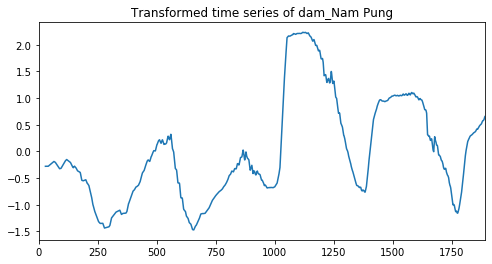

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000936      0.000278         0.000557        0.000126           0    0.0001           0.701481           0.775889           0.767053           0.877521           0.594062         0.743201        0.093448                5
1       0.002258      0.002351         0.000612        0.000004         0.5    0.0001           0.719394           0.775866           0.766653           0.877362           0.594846         0.746824        0.091790                4
2       0.003256      0.003408         0.000635        0.000037           1    0.0001           0.727138           0.775652           0.766250           0.877205           0.595551         0.748359        0.091068                3
3       0.002411      0.002664         0.000610        0.000006           2    0.0001           0.734027           0.775064           0.765467           0.876900           0.596804         0.749652        0.090216                1
4       0.002861      0.003564         0.000611        0.000004          10    0.0001           0.734804           0.770760           0.759854           0.874750           0.603847         0.748803        0.086805                2

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.059867      0.032123         0.002708        0.000626     0.1             2000            2           0.1       linear           0.738406           0.785130           0.769192           0.868309           0.611624         0.754532        0.083402                1
1        0.038618      0.029197         0.005712        0.002588     0.1             2000            2           0.1          rbf           0.292530           0.808064          -3.417553           0.823914           0.677997        -0.163010        1.638528               16
2        0.046888      0.030969         0.004068        0.002449     0.1             2000            2           0.1         poly           0.582801           0.687107         -12.905067          -0.556015          -0.251261        -2.488487        5.229952               34
3        0.009033      0.010562         0.000403        0.000069     0.1             2000            2             1       linear          -0.418956           0.290370          -1.775823           0.815662           0.549700        -0.107809        0.929811               10
4        0.003637      0.003395         0.000629        0.000276     0.1             2000            2             1          rbf          -0.418956           0.302677          -3.075421           0.742878           0.542825        -0.381199        1.403233               21
5        0.013362      0.016975         0.001083        0.000988     0.1             2000            2             1         poly          -0.418956           0.301027          -4.735661          -1.443947          -0.329583        -1.325424        1.794575               31
6        0.046744      0.032421         0.002202        0.000867     0.1             2000            3           0.1       linear           0.738406           0.785130           0.769192           0.868309           0.611624         0.754532        0.083402                1
7        0.035046      0.026471         0.005096        0.002283     0.1             2000            3           0.1          rbf           0.292530           0.808064          -3.417553           0.823914           0.677997        -0.163010        1.638528               16
8        0.075730      0.049802         0.003682        0.001871     0.1             2000            3           0.1         poly           0.476547           0.586542          -1.278643          -0.848866          -0.079928        -0.228869        0.730905               18
9        0.008565      0.010070         0.000361        0.000061     0.1             2000            3             1       linear          -0.418956           0.290370          -1.775823           0.815662           0.549700        -0.107809        0.929811               10
10       0.003624      0.003415         0.000615        0.000282     0.1             2000            3             1          rbf          -0.418956           0.302677          -3.075421           0.742878           0.542825        -0.381199        1.403233               21
11       0.005027      0.005692         0.000404        0.000118     0.1             2000            3             1         poly          -0.418956           0.280548          -0.661702           0.038105           0.282349        -0.095931        0.381376                7
12       0.130827      0.108438         0.002240        0.000897       1             2000            2           0.1       linear           0.700293           0.788577           0.773158           0.868590           0.607798         0.747683        0.088038                3
13       0.048155      0.032740         0.004828        0.002142       1             2000            2           0.1          rbf           0.168191      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001297      0.000279         0.000650        0.000017           0    0.0001           0.729985           0.789566           0.740327           0.876918           0.608936         0.749146        0.087250                5
1       0.001729      0.000928         0.000721        0.000157         0.5    0.0001           0.746478           0.790838           0.739977           0.876802           0.609761         0.752771        0.086589                4
2       0.001388      0.000125         0.000725        0.000160           1    0.0001           0.753488           0.791283           0.739630           0.876690           0.610505         0.754319        0.086302                3
3       0.001315      0.000212         0.000636        0.000006           2    0.0001           0.759788           0.791375           0.738963           0.876475           0.611827         0.755685        0.085855                1
4       0.001300      0.000209         0.000640        0.000020          10    0.0001           0.761756           0.787759           0.734147           0.875035           0.619264         0.755592        0.082927                2

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.089458      0.055561         0.004944        0.001407     0.1             2000            2           0.1       linear           0.750222           0.790356           0.742111           0.868526           0.636975         0.757638        0.075130                1
1        0.052684      0.041170         0.008835        0.004482     0.1             2000            2           0.1          rbf           0.537514           0.787776          -3.207753           0.817645           0.695802        -0.073803        1.570009                7
2        0.055303      0.044637         0.006515        0.003706     0.1             2000            2           0.1         poly          -0.078563           0.682074         -12.795456          -0.868571          -0.400782        -2.692260        5.076787               34
3        0.014019      0.017038         0.000424        0.000123     0.1             2000            2             1       linear          -0.418956           0.296680          -1.699726           0.531183           0.281475        -0.201869        0.813663               17
4        0.004776      0.004939         0.000789        0.000485     0.1             2000            2             1          rbf          -0.418956           0.225886          -3.090823           0.759407           0.510081        -0.402881        1.400361               23
5        0.018355      0.023523         0.001668        0.001691     0.1             2000            2             1         poly          -0.418956           0.206922          -4.436632          -1.362057          -0.141427        -1.230430        1.685672               33
6        0.075835      0.054544         0.004234        0.001575     0.1             2000            3           0.1       linear           0.750222           0.790356           0.742111           0.868526           0.636975         0.757638        0.075130                1
7        0.047586      0.036377         0.007948        0.004000     0.1             2000            3           0.1          rbf           0.537514           0.787776          -3.207753           0.817645           0.695802        -0.073803        1.570009                7
8        0.072350      0.057549         0.007401        0.004614     0.1             2000            3           0.1         poly           0.329193           0.644891          -2.473920          -0.380796           0.400892        -0.295948        1.141256               22
9        0.014827      0.018008         0.000448        0.000130     0.1             2000            3             1       linear          -0.418956           0.296680          -1.699726           0.531183           0.281475        -0.201869        0.813663               17
10       0.005115      0.005308         0.000834        0.000518     0.1             2000            3             1          rbf          -0.418956           0.225886          -3.090823           0.759407           0.510081        -0.402881        1.400361               23
11       0.005537      0.006158         0.000545        0.000243     0.1             2000            3             1         poly          -0.418956           0.216500          -1.007787           0.225722           0.313921        -0.134120        0.509429               11
12       0.327657      0.255448         0.004109        0.001706       1             2000            2           0.1       linear           0.709528           0.789611           0.745889           0.869191           0.635101         0.749864        0.078272                3
13       0.058280      0.042634         0.006867        0.003376       1             2000            2           0.1          rbf           0.540155      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001000      0.000285         0.000575        0.000134           0    0.0001          -0.116374          -0.026134          -2.998692           0.307721          -0.106188        -0.587934        1.215238                5
1       0.001095      0.000119         0.000617        0.000011         0.5    0.0001          -0.125260           0.008975          -2.997504           0.307800          -0.106155        -0.582429        1.217431                4
2       0.001103      0.000136         0.000623        0.000009           1    0.0001          -0.131477           0.026269          -2.996366           0.307885          -0.106125        -0.579963        1.218233                3
3       0.001068      0.000113         0.000612        0.000004           2    0.0001          -0.140521           0.046402          -2.994218           0.308069          -0.106071        -0.577268        1.218787                2
4       0.001063      0.000119         0.000608        0.000004          10    0.0001          -0.172725           0.094058          -2.980907           0.309937          -0.105784        -0.571084        1.216639                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.070867      0.037150         0.004115        0.001247     0.1             2000            2           0.1       linear          -0.128306           0.039145          -3.047883          -0.863593          -0.229505        -0.846028        1.142561               18
1        0.062484      0.049697         0.008843        0.004661     0.1             2000            2           0.1          rbf           0.040647           0.404287          -3.230948          -1.148044          -0.139405        -0.814693        1.313236               16
2        0.047504      0.036527         0.004219        0.001824     0.1             2000            2           0.1         poly          -0.031217          -0.035901          -3.529419          -1.608142          -0.198333        -1.080603        1.359854               27
3        0.023154      0.027531         0.001018        0.000811     0.1             2000            2             1       linear          -0.418956          -0.065319          -2.565473           0.513810           0.071602        -0.492867        1.078515                3
4        0.015891      0.018442         0.001999        0.001923     0.1             2000            2             1          rbf          -0.418956          -0.070821          -2.935511           0.498228           0.201523        -0.545107        1.232956                7
5        0.020182      0.023635         0.001440        0.001306     0.1             2000            2             1         poly          -0.418956          -0.056291          -3.169844          -0.270369          -0.071212        -0.797334        1.193823               15
6        0.060102      0.039448         0.003386        0.001510     0.1             2000            3           0.1       linear          -0.128306           0.039145          -3.047883          -0.863593          -0.229505        -0.846028        1.142561               18
7        0.057516      0.047465         0.008026        0.004599     0.1             2000            3           0.1          rbf           0.040647           0.404287          -3.230948          -1.148044          -0.139405        -0.814693        1.313236               16
8        0.060532      0.041364         0.004436        0.001633     0.1             2000            3           0.1         poly          -0.553531          -0.021530          -3.064159          -2.212635          -0.168825        -1.204136        1.214123               30
9        0.023053      0.027488         0.001021        0.000812     0.1             2000            3             1       linear          -0.418956          -0.065319          -2.565473           0.513810           0.071602        -0.492867        1.078515                3
10       0.015951      0.018504         0.001995        0.001912     0.1             2000            3             1          rbf          -0.418956          -0.070821          -2.935511           0.498228           0.201523        -0.545107        1.232956                7
11       0.025449      0.030464         0.001257        0.001080     0.1             2000            3             1         poly          -0.418956          -0.338100          -1.957166          -0.522784           0.038611        -0.639679        0.685446               11
12       0.129387      0.078279         0.003367        0.001548       1             2000            2           0.1       linear          -0.104567          -0.036824          -3.065255          -0.900733          -0.229771        -0.867430        1.141054               20
13       0.067233      0.051191         0.007759        0.004318       1             2000            2           0.1          rbf           0.097137      

>>> Final results:



period = 15, future = 10, Node: dam_Ubol Ratana, neighbors: ['dam_Pak Mun', 'dam_Huai Kum']


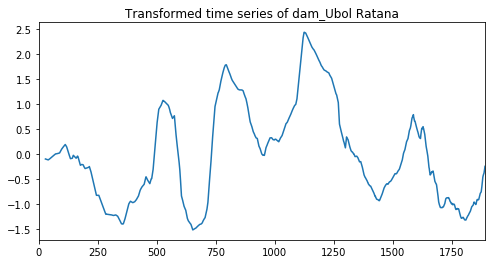

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000965      0.000278         0.000562        0.000125           0    0.0001           0.736256           0.887622           0.862446           0.298471           0.565852         0.670129        0.218021                5
1       0.001070      0.000112         0.000618        0.000005         0.5    0.0001           0.735280           0.887309           0.861989           0.301726           0.566789         0.670619        0.216620                4
2       0.001071      0.000110         0.000616        0.000005           1    0.0001           0.733748           0.886986           0.861545           0.304521           0.567605         0.670881        0.215356                3
3       0.001392      0.000583         0.000678        0.000101           2    0.0001           0.730998           0.886334           0.860701           0.309215           0.568975         0.671245        0.213191                2
4       0.001095      0.000093         0.000619        0.000003          10    0.0001           0.719545           0.881701           0.855332           0.331481           0.574902         0.672592        0.202596                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.074115      0.047996         0.003075        0.000722     0.1             2000            2           0.1       linear           0.737391           0.903160           0.870252           0.308323           0.544031         0.672631        0.221653                1
1        0.041980      0.032476         0.005602        0.002473     0.1             2000            2           0.1          rbf          -0.001324           0.485289           0.329995           0.461762           0.578556         0.370855        0.202329                7
2        0.045183      0.035705         0.004167        0.002132     0.1             2000            2           0.1         poly          -0.115478          -2.837479         -14.432836          -0.957736          -2.722167        -4.213139        5.214329               34
3        0.005359      0.003530         0.000417        0.000044     0.1             2000            2             1       linear          -0.030963           0.514173           0.358844           0.025251           0.234244         0.220310        0.203434               13
4        0.003615      0.002510         0.000686        0.000247     0.1             2000            2             1          rbf          -0.030963           0.114394          -0.773592           0.199147           0.094467        -0.079309        0.354858               19
5        0.018905      0.015988         0.001690        0.000924     0.1             2000            2             1         poly          -0.030963          -0.757362          -3.650352          -0.202954          -1.352582        -1.198843        1.310281               33
6        0.062295      0.048090         0.002108        0.000857     0.1             2000            3           0.1       linear           0.737391           0.903160           0.870252           0.308323           0.544031         0.672631        0.221653                1
7        0.038984      0.029996         0.005407        0.002489     0.1             2000            3           0.1          rbf          -0.001324           0.485289           0.329995           0.461762           0.578556         0.370855        0.202329                7
8        0.068102      0.052926         0.004120        0.001969     0.1             2000            3           0.1         poly           0.519172           0.377414          -5.168170           0.076338           0.207703        -0.797509        2.190472               28
9        0.005363      0.003564         0.000403        0.000057     0.1             2000            3             1       linear          -0.030963           0.514173           0.358844           0.025251           0.234244         0.220310        0.203434               13
10       0.003641      0.002480         0.000677        0.000243     0.1             2000            3             1          rbf          -0.030963           0.114394          -0.773592           0.199147           0.094467        -0.079309        0.354858               19
11       0.014157      0.015268         0.000586        0.000236     0.1             2000            3             1         poly          -0.030963           0.615659          -2.330393          -0.114891          -0.306972        -0.433512        0.997847               26
12       0.221501      0.175921         0.002154        0.000902       1             2000            2           0.1       linear           0.742831           0.905354           0.871272           0.298569           0.534762         0.670558        0.226916                3
13       0.049560      0.037319         0.005099        0.002328       1             2000            2           0.1          rbf          -0.336382      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003393      0.003700         0.000672        0.000029           0    0.0001           0.648891           0.882498           0.853731           0.409276           0.128134         0.584506        0.284397                5
1       0.003350      0.003407         0.000662        0.000038         0.5    0.0001           0.649917           0.883906           0.854525           0.412453           0.129523         0.586065        0.284052                4
2       0.004129      0.003255         0.000648        0.000014           1    0.0001           0.647792           0.884001           0.855105           0.415178           0.130786         0.586572        0.283351                3
3       0.003237      0.003324         0.000639        0.000007           2    0.0001           0.644674           0.883626           0.855911           0.419735           0.133022         0.587394        0.282028                2
4       0.003364      0.003464         0.000637        0.000008          10    0.0001           0.639369           0.879413           0.857908           0.440635           0.144494         0.592364        0.275220                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.131783      0.087487         0.007289        0.002259     0.1             2000            2           0.1       linear           0.616831           0.907637           0.896838           0.376498           0.419899         0.643540        0.226251                5
1        0.067092      0.050611         0.012361        0.005869     0.1             2000            2           0.1          rbf           0.405928           0.551174          -0.552752           0.476897          -0.016679         0.172914        0.412872                9
2        0.063522      0.052476         0.009344        0.005365     0.1             2000            2           0.1         poly           0.279499           0.457687         -19.307985          -0.644145         -79.955899       -19.834169       30.982173               28
3        0.014654      0.017907         0.000611        0.000238     0.1             2000            2             1       linear          -0.030963           0.387774          -1.176049           0.357402          -2.055104        -0.503388        0.961104               19
4        0.005416      0.004353         0.001027        0.000513     0.1             2000            2             1          rbf          -0.030963           0.114278          -1.446942           0.342602          -0.650436        -0.334292        0.646428               17
5        0.016922      0.017280         0.002225        0.001744     0.1             2000            2             1         poly          -0.030963          -0.303280         -12.165096          -0.093935         -74.907885       -17.500232       29.079175               27
6        0.115182      0.086103         0.006165        0.002823     0.1             2000            3           0.1       linear           0.616831           0.907637           0.896838           0.376498           0.419899         0.643540        0.226251                5
7        0.065402      0.050324         0.011924        0.005631     0.1             2000            3           0.1          rbf           0.405928           0.551174          -0.552752           0.476897          -0.016679         0.172914        0.412872                9
8        0.080919      0.063776         0.010108        0.005234     0.1             2000            3           0.1         poly           0.319914           0.645481          -6.054145          -0.045147        -119.667511       -24.960282       47.418158               29
9        0.015582      0.018910         0.000669        0.000274     0.1             2000            3             1       linear          -0.030963           0.387774          -1.176049           0.357402          -2.055104        -0.503388        0.961104               19
10       0.005426      0.004314         0.001028        0.000511     0.1             2000            3             1          rbf          -0.030963           0.114278          -1.446942           0.342602          -0.650436        -0.334292        0.646428               17
11       0.008537      0.009144         0.000741        0.000340     0.1             2000            3             1         poly          -0.030963           0.576225          -0.082891           0.031312         -43.956927        -8.692649       17.633726               25
12       0.642113      0.521887         0.006326        0.002784       1             2000            2           0.1       linear           0.646387           0.907562           0.898324           0.363801           0.418413         0.646898        0.229569                3
13       0.073027      0.052967         0.010102        0.004734       1             2000            2           0.1          rbf           0.371219      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001318      0.000253         0.000664        0.000016           0    0.0001           0.260888           0.384232          -1.213137           0.062068          -6.820894        -1.465369        2.737858                5
1       0.001357      0.000214         0.000661        0.000036         0.5    0.0001           0.273932           0.385008          -1.202987           0.062849          -6.822163        -1.460672        2.740383                4
2       0.001297      0.000199         0.000632        0.000002           1    0.0001           0.280215           0.385312          -1.194530           0.063568          -6.823466        -1.457780        2.741970                3
3       0.001292      0.000201         0.000631        0.000012           2    0.0001           0.288624           0.385791          -1.180785           0.064856          -6.826104        -1.453524        2.744545                2
4       0.001289      0.000194         0.000627        0.000005          10    0.0001           0.318209           0.388002          -1.119465           0.071126          -6.843755        -1.437176        2.757523                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.095568      0.059747         0.007775        0.003081     0.1             2000            2           0.1       linear           0.289880           0.264890          -1.556955          -0.089553         -10.044093        -2.227166        3.966580               23
1        0.076809      0.061862         0.012733        0.006404     0.1             2000            2           0.1          rbf           0.321470           0.041806          -2.477465          -0.158987          -1.005768        -0.655789        1.012865                9
2        0.058386      0.045800         0.007265        0.003917     0.1             2000            2           0.1         poly           0.209258          -0.140241         -32.529534          -0.726700         -11.622774        -8.961998       12.587803               26
3        0.024499      0.022480         0.000960        0.000493     0.1             2000            2             1       linear          -0.030963           0.427000          -0.050280           0.139866          -5.458426        -0.994561        2.238483               11
4        0.007657      0.005959         0.001337        0.000715     0.1             2000            2             1          rbf          -0.030963           0.147421          -1.457397           0.082124          -1.112567        -0.474276        0.673284                5
5        0.019801      0.018913         0.002531        0.001964     0.1             2000            2             1         poly          -0.030963          -0.136299         -19.157287          -0.609534         -24.664835        -8.919784       10.751131               25
6        0.081133      0.059095         0.006463        0.003228     0.1             2000            3           0.1       linear           0.289880           0.264890          -1.556955          -0.089553         -10.044093        -2.227166        3.966580               23
7        0.072089      0.057909         0.012398        0.006842     0.1             2000            3           0.1          rbf           0.321470           0.041806          -2.477465          -0.158987          -1.005768        -0.655789        1.012865                9
8        0.069615      0.049519         0.007711        0.003817     0.1             2000            3           0.1         poly           0.224836          -0.152448         -40.675741          -1.702439          -7.551131        -9.971385       15.603622               27
9        0.023773      0.021845         0.000923        0.000496     0.1             2000            3             1       linear          -0.030963           0.427000          -0.050280           0.139866          -5.458426        -0.994561        2.238483               11
10       0.007653      0.006012         0.001345        0.000722     0.1             2000            3             1          rbf          -0.030963           0.147421          -1.457397           0.082124          -1.112567        -0.474276        0.673284                5
11       0.025628      0.025705         0.002096        0.001288     0.1             2000            3             1         poly          -0.030963          -0.029315         -14.713201          -1.359897         -99.418027       -23.110281       38.553465               32
12       0.258656      0.171280         0.006560        0.003157       1             2000            2           0.1       linear           0.260202           0.261228          -1.595208          -0.091279          -9.874932        -2.207998        3.894277               19
13       0.079510      0.059852         0.011090        0.005675       1             2000            2           0.1          rbf           0.308454      

>>> Final results:



period = 15, future = 10, Node: dam_Lam Pao, neighbors: ['dam_Pak Mun']


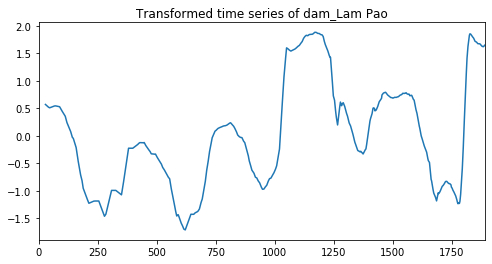

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000946      0.000278         0.000574        0.000091           0    0.0001           0.837105           0.904002           0.713873           0.730443           0.864224         0.809929        0.074941                2
1       0.001071      0.000123         0.000610        0.000003         0.5    0.0001           0.836053           0.903677           0.714330           0.731793           0.863933         0.809957        0.074340                1
2       0.001059      0.000115         0.000606        0.000003           1    0.0001           0.834949           0.903212           0.714379           0.732889           0.863642         0.809814        0.073862                3
3       0.001418      0.000795         0.000616        0.000016           2    0.0001           0.833120           0.902131           0.714306           0.734551           0.863069         0.809435        0.073058                4
4       0.001086      0.000126         0.000610        0.000004          10    0.0001           0.823069           0.893300           0.714258           0.738562           0.858923         0.805622        0.068814                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.057477      0.032250         0.002569        0.000417     0.1             2000            2           0.1       linear           0.816401           0.889443           0.713182           0.730335           0.862851         0.802443        0.070114                5
1        0.033463      0.025996         0.004578        0.001946     0.1             2000            2           0.1          rbf           0.502921           0.861855          -2.618755           0.723146           0.849627         0.063759        1.347448                7
2        0.048681      0.030288         0.004304        0.002020     0.1             2000            2           0.1         poly           0.497427           0.692565          -9.373106          -2.976885           0.295573        -2.172885        3.845107               34
3        0.015800      0.019020         0.000387        0.000096     0.1             2000            2             1       linear          -0.081760           0.144385          -2.010153           0.210963           0.702883        -0.206736        0.937347               16
4        0.002928      0.003036         0.000570        0.000275     0.1             2000            2             1          rbf          -0.108600           0.176171          -3.266876           0.408388           0.618480        -0.434488        1.436712               25
5        0.015699      0.019501         0.001261        0.001168     0.1             2000            2             1         poly           0.006506           0.347042          -4.573751          -4.884826           0.350043        -1.750997        2.436956               31
6        0.047123      0.033846         0.001747        0.000687     0.1             2000            3           0.1       linear           0.816401           0.889443           0.713182           0.730335           0.862851         0.802443        0.070114                5
7        0.031033      0.024229         0.004331        0.001987     0.1             2000            3           0.1          rbf           0.502921           0.861855          -2.618755           0.723146           0.849627         0.063759        1.347448                7
8        0.069381      0.051337         0.004155        0.001817     0.1             2000            3           0.1         poly          -0.756946           0.576875           0.555944          -1.854469           0.700664        -0.155586        1.002375               11
9        0.015804      0.019003         0.000380        0.000086     0.1             2000            3             1       linear          -0.081760           0.144385          -2.010153           0.210963           0.702883        -0.206736        0.937347               16
10       0.002956      0.003047         0.000568        0.000275     0.1             2000            3             1          rbf          -0.108600           0.176171          -3.266876           0.408388           0.618480        -0.434488        1.436712               25
11       0.006188      0.008361         0.000399        0.000096     0.1             2000            3             1         poly           0.025824           0.226604          -1.069552          -1.305805           0.628619        -0.298862        0.754938               24
12       0.145104      0.127665         0.001745        0.000752       1             2000            2           0.1       linear           0.820270           0.891189           0.712280           0.725471           0.865260         0.802894        0.072378                1
13       0.045357      0.033586         0.004390        0.001862       1             2000            2           0.1          rbf           0.427224      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004369      0.003741         0.005577        0.009679           0    0.0001           0.864055           0.824763           0.685834           0.730366           0.865050         0.794014        0.073009                5
1       0.001350      0.000155         0.000644        0.000009         0.5    0.0001           0.865233           0.830573           0.685656           0.731819           0.864927         0.795642        0.073531                3
2       0.001322      0.000208         0.000635        0.000002           1    0.0001           0.864786           0.833893           0.685125           0.732945           0.864776         0.796305        0.073711                2
3       0.001320      0.000209         0.000631        0.000004           2    0.0001           0.863344           0.838290           0.683946           0.734578           0.864431         0.796918        0.073934                1
4       0.001302      0.000203         0.000627        0.000007          10    0.0001           0.855340           0.844418           0.676995           0.738204           0.861261         0.795244        0.074329                4

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.068782      0.041121         0.004504        0.000802     0.1             2000            2           0.1       linear           0.820137           0.845894           0.690310           0.731663           0.867630         0.791127        0.068401                1
1        0.046333      0.037679         0.007705        0.003860     0.1             2000            2           0.1          rbf           0.414102           0.712654          -2.908517           0.715763           0.707538        -0.071692        1.423099                7
2        0.067019      0.047906         0.008107        0.004280     0.1             2000            2           0.1         poly          -1.513368           0.640202         -11.216643          -6.055534         -48.321067       -13.293282       17.980831               29
3        0.005799      0.006390         0.000545        0.000140     0.1             2000            2             1       linear          -0.102492           0.148986          -1.992547           0.545036           0.656076        -0.148988        0.961193               13
4        0.004805      0.004633         0.000876        0.000473     0.1             2000            2             1          rbf          -0.134192           0.139828          -3.406848           0.344698           0.539669        -0.503369        1.468832               19
5        0.017984      0.021992         0.001960        0.001938     0.1             2000            2             1         poly          -0.090683           0.336445          -4.533198          -4.213080         -16.869554        -5.074014        6.233380               27
6        0.057919      0.042248         0.003295        0.001304     0.1             2000            3           0.1       linear           0.820137           0.845894           0.690310           0.731663           0.867630         0.791127        0.068401                1
7        0.041686      0.033797         0.006663        0.003385     0.1             2000            3           0.1          rbf           0.414102           0.712654          -2.908517           0.715763           0.707538        -0.071692        1.423099                7
8        0.074342      0.057980         0.006864        0.003427     0.1             2000            3           0.1         poly          -0.400340           0.629264          -4.954891          -1.951575         -83.332014       -18.001911       32.719402               31
9        0.005299      0.005879         0.000452        0.000148     0.1             2000            3             1       linear          -0.102492           0.148986          -1.992547           0.545036           0.656076        -0.148988        0.961193               13
10       0.004356      0.004274         0.000802        0.000448     0.1             2000            3             1          rbf          -0.134192           0.139828          -3.406848           0.344698           0.539669        -0.503369        1.468832               19
11       0.003289      0.003418         0.000506        0.000212     0.1             2000            3             1         poly          -0.060117           0.222462          -1.080947          -1.486979          -0.457017        -0.572520        0.632871               25
12       0.214904      0.191921         0.003249        0.001367       1             2000            2           0.1       linear           0.810242           0.819106           0.689279           0.728286           0.868661         0.783115        0.065055                3
13       0.055051      0.040348         0.005986        0.002878       1             2000            2           0.1          rbf           0.452307      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003036      0.003089         0.000625        0.000057           0    0.0001          -1.282197          -0.026406          -0.655348          -2.710464          -0.297044        -0.994292        0.955613                5
1       0.003771      0.002486         0.000617        0.000074         0.5    0.0001          -1.270171          -0.003578          -0.656532          -2.710044          -0.297633        -0.987592        0.959231                4
2       0.001041      0.000099         0.000588        0.000033           1    0.0001          -1.267321           0.011094          -0.657673          -2.709711          -0.298246        -0.984371        0.961801                3
3       0.002374      0.002680         0.000599        0.000033           2    0.0001          -1.264940           0.031174          -0.659745          -2.709226          -0.299498        -0.980447        0.965353                2
4       0.002865      0.003586         0.000609        0.000010          10    0.0001          -1.268388           0.093433          -0.669890          -2.708277          -0.307910        -0.972207        0.976723                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.063199      0.043691         0.004464        0.001286     0.1             2000            2           0.1       linear          -1.379671          -0.284898          -0.540655          -2.685724          -0.236107        -1.025411        0.926120                7
1        0.059009      0.046927         0.008164        0.004070     0.1             2000            2           0.1          rbf          -1.773162           0.436064          -3.597834          -3.283688           0.287720        -1.586180        1.706705               13
2        0.053609      0.038566         0.004605        0.002043     0.1             2000            2           0.1         poly          -1.687991           0.288182         -15.095091          -4.885716         -17.124062        -7.700936        7.090498               28
3        0.014523      0.020484         0.000686        0.000301     0.1             2000            2             1       linear          -0.206436           0.158236          -1.144461          -2.971046          -0.181977        -0.869137        1.136722                1
4        0.009610      0.010574         0.001276        0.000960     0.1             2000            2             1          rbf          -0.219920           0.111744          -3.454730          -5.166209           0.272518        -1.691320        2.211659               15
5        0.016658      0.019498         0.001187        0.000959     0.1             2000            2             1         poly          -0.208180           0.121375         -10.524126          -4.286668          -7.157593        -4.411038        4.077638               25
6        0.054904      0.046502         0.003419        0.001549     0.1             2000            3           0.1       linear          -1.379671          -0.284898          -0.540655          -2.685724          -0.236107        -1.025411        0.926120                7
7        0.055093      0.042929         0.007706        0.003817     0.1             2000            3           0.1          rbf          -1.773162           0.436064          -3.597834          -3.283688           0.287720        -1.586180        1.706705               13
8        0.067694      0.052136         0.004345        0.001847     0.1             2000            3           0.1         poly          -1.961061           0.027966         -19.301087          -3.642576        -305.699064       -66.115164      119.987908               31
9        0.014451      0.020466         0.000647        0.000309     0.1             2000            3             1       linear          -0.206436           0.158236          -1.144461          -2.971046          -0.181977        -0.869137        1.136722                1
10       0.009587      0.010560         0.001286        0.000966     0.1             2000            3             1          rbf          -0.219920           0.111744          -3.454730          -5.166209           0.272518        -1.691320        2.211659               15
11       0.022199      0.026157         0.000944        0.000630     0.1             2000            3             1         poly          -0.203568           0.093558          -6.924690          -3.302441        -336.821809       -69.431790      133.719087               32
12       0.112121      0.097955         0.003448        0.001549       1             2000            2           0.1       linear          -1.364172          -0.487141          -0.554043          -2.699994          -0.247927        -1.070655        0.897235                9
13       0.065811      0.049771         0.007720        0.003758       1             2000            2           0.1          rbf          -1.850984      

>>> Final results:



period = 15, future = 10, Node: dam_Chulabhorn, neighbors: ['dam_Huai Kum']


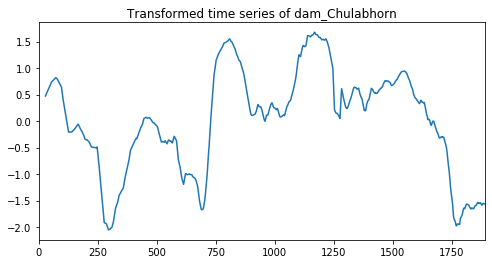

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003966      0.002633         0.000563        0.000128           0    0.0001           0.509921           0.852784           0.143601          -0.004847           0.850363         0.470364        0.353499                5
1       0.003262      0.001392         0.000762        0.000271         0.5    0.0001           0.511800           0.851969           0.147924          -0.000470           0.850451         0.472335        0.351408                4
2       0.003339      0.001394         0.000623        0.000006           1    0.0001           0.512719           0.851207           0.151499           0.003354           0.850528         0.473861        0.349592                3
3       0.003321      0.001385         0.000619        0.000008           2    0.0001           0.513558           0.849810           0.157299           0.009745           0.850656         0.476214        0.346548                2
4       0.003310      0.001380         0.000619        0.000005          10    0.0001           0.513833           0.841783           0.183769           0.034505           0.851044         0.484987        0.333406                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.068924      0.041820         0.002994        0.000919     0.1             2000            2           0.1       linear           0.526735           0.862341           0.198230           0.046287           0.859445         0.498608        0.334101                1
1        0.046255      0.036489         0.006467        0.003131     0.1             2000            2           0.1          rbf           0.428261           0.153901           0.383230           0.060726           0.852229         0.375669        0.275065                9
2        0.043864      0.033857         0.004190        0.001880     0.1             2000            2           0.1         poly           0.411760          -1.385418          -5.071447          -2.792615          -5.729675        -2.913479        2.280113               33
3        0.010250      0.010381         0.000570        0.000205     0.1             2000            2             1       linear          -0.434183           0.279883          -0.669280          -1.265482           0.806363        -0.256540        0.726277               17
4        0.005239      0.003613         0.000905        0.000336     0.1             2000            2             1          rbf          -0.205298          -0.542941          -0.382477          -0.929522           0.671110        -0.277826        0.531354               21
5        0.016004      0.012560         0.001522        0.000854     0.1             2000            2             1         poly          -0.165815          -0.799980          -2.733870          -3.059112          -1.358391        -1.623433        1.110605               31
6        0.058343      0.041765         0.002511        0.001095     0.1             2000            3           0.1       linear           0.526735           0.862341           0.198230           0.046287           0.859445         0.498608        0.334101                1
7        0.043078      0.033934         0.006064        0.002997     0.1             2000            3           0.1          rbf           0.428261           0.153901           0.383230           0.060726           0.852229         0.375669        0.275065                9
8        0.063054      0.049434         0.003977        0.001853     0.1             2000            3           0.1         poly           0.216240           0.352108           0.113093          -3.141471           0.489539        -0.394098        1.379525               23
9        0.008541      0.008214         0.000433        0.000106     0.1             2000            3             1       linear          -0.434183           0.279883          -0.669280          -1.265482           0.806363        -0.256540        0.726277               17
10       0.004673      0.003299         0.000817        0.000293     0.1             2000            3             1          rbf          -0.205298          -0.542941          -0.382477          -0.929522           0.671110        -0.277826        0.531354               21
11       0.014460      0.010788         0.000643        0.000129     0.1             2000            3             1         poly           0.355814           0.345919          -0.059446          -3.919060           0.591734        -0.537008        1.703942               24
12       0.188030      0.122338         0.002541        0.001121       1             2000            2           0.1       linear           0.517160           0.867435           0.183991           0.024987           0.856577         0.490030        0.342769                3
13       0.054264      0.040684         0.005741        0.002871       1             2000            2           0.1          rbf           0.441134      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001494      0.000173         0.000649        0.000018           0    0.0001           0.457298           0.840182           0.205750          -0.361598           0.832999         0.394926        0.447698                5
1       0.001348      0.000222         0.000642        0.000010         0.5    0.0001           0.459782           0.839245           0.210267          -0.358121           0.833011         0.396837        0.446028                4
2       0.001310      0.000190         0.000632        0.000006           1    0.0001           0.461308           0.838375           0.214029          -0.355040           0.833016         0.398338        0.444543                3
3       0.001301      0.000202         0.000628        0.000007           2    0.0001           0.463303           0.836797           0.220170          -0.349784           0.833013         0.400700        0.441998                2
4       0.001300      0.000201         0.000632        0.000006          10    0.0001           0.470315           0.827882           0.248071          -0.327340           0.832638         0.410313        0.430529                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.110578      0.069619         0.005871        0.001820     0.1             2000            2           0.1       linear           0.513998           0.861186           0.224815          -0.012319           0.854611         0.488458        0.344654                1
1        0.060790      0.046636         0.010275        0.004447     0.1             2000            2           0.1          rbf           0.355954           0.581924           0.421188          -0.776559           0.699709         0.256443        0.530388                9
2        0.061075      0.045901         0.007399        0.003626     0.1             2000            2           0.1         poly           0.167021          -1.330095          -3.905069          -4.169218          -5.317221        -2.910916        2.016664               32
3        0.020833      0.019429         0.000527        0.000165     0.1             2000            2             1       linear           0.539405           0.057968          -0.283947          -5.618083           0.734722        -0.913987        2.379107               15
4        0.005555      0.004209         0.001066        0.000432     0.1             2000            2             1          rbf           0.572925          -0.317674          -0.298771          -5.990676           0.466414        -1.113556        2.466744               22
5        0.017735      0.014441         0.002234        0.001347     0.1             2000            2             1         poly          -0.953610          -0.413132          -1.564259          -3.608488          -2.658073        -1.839512        1.157105               27
6        0.096103      0.069715         0.004974        0.002358     0.1             2000            3           0.1       linear           0.513998           0.861186           0.224815          -0.012319           0.854611         0.488458        0.344654                1
7        0.056750      0.042810         0.009669        0.004203     0.1             2000            3           0.1          rbf           0.355954           0.581924           0.421188          -0.776559           0.699709         0.256443        0.530388                9
8        0.068806      0.051443         0.006991        0.003403     0.1             2000            3           0.1         poly          -0.000491           0.461227           0.205722          -3.361414           0.360757        -0.466840        1.455652               14
9        0.020610      0.019246         0.000496        0.000159     0.1             2000            3             1       linear           0.539405           0.057968          -0.283947          -5.618083           0.734722        -0.913987        2.379107               15
10       0.005664      0.004231         0.001250        0.000568     0.1             2000            3             1          rbf           0.572925          -0.317674          -0.298771          -5.990676           0.466414        -1.113556        2.466744               22
11       0.010502      0.007099         0.000989        0.000309     0.1             2000            3             1         poly           0.063271          -0.031971           0.044124          -6.506503           0.534507        -1.179315        2.671080               24
12       0.429325      0.337734         0.004949        0.002311       1             2000            2           0.1       linear           0.487117           0.866332           0.203459          -0.035441           0.853144         0.474922        0.355124                3
13       0.069744      0.049170         0.008826        0.003970       1             2000            2           0.1          rbf           0.508837      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001008      0.000253         0.000606        0.000050           0    0.0001          -1.205780           0.153456          -0.345508          -8.946580          -0.399041        -2.148691        3.426748                5
1       0.001093      0.000124         0.000620        0.000008         0.5    0.0001          -1.204477           0.153367          -0.345674          -8.943147          -0.399108        -2.147808        3.425421                4
2       0.001111      0.000134         0.000632        0.000010           1    0.0001          -1.203261           0.153277          -0.345838          -8.939848          -0.399174        -2.146969        3.424143                3
3       0.001077      0.000108         0.000624        0.000014           2    0.0001          -1.201033           0.153102          -0.346156          -8.933610          -0.399305        -2.145400        3.421721                2
4       0.001071      0.000116         0.000608        0.000003          10    0.0001          -1.188107           0.151837          -0.348426          -8.894844          -0.400295        -2.135967        3.406546                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.064364      0.031311         0.004144        0.001230     0.1             2000            2           0.1       linear          -1.720514           0.100809          -0.622969          -9.976054          -0.407704        -2.525286        3.772557               25
1        0.061605      0.048924         0.008686        0.004199     0.1             2000            2           0.1          rbf          -1.558987           0.145411          -0.518991          -9.396110          -0.725953        -2.410926        3.534742               23
2        0.052397      0.038898         0.004452        0.001991     0.1             2000            2           0.1         poly          -0.549823          -0.473711          -2.043539          -5.073543          -1.769345        -1.981992        1.669294               15
3        0.025740      0.020992         0.000648        0.000258     0.1             2000            2             1       linear           0.599905          -0.178570          -0.266101          -8.242687          -0.462948        -1.710080        3.286242                9
4        0.007691      0.006904         0.001243        0.000631     0.1             2000            2             1          rbf           0.555730          -0.314174          -0.305485          -9.523116          -0.482624        -2.013934        3.772105               18
5        0.017322      0.015785         0.001368        0.000749     0.1             2000            2             1         poly          -0.817999          -0.362976          -1.526004          -2.153262          -1.907745        -1.353597        0.669994                3
6        0.053336      0.034302         0.003431        0.001531     0.1             2000            3           0.1       linear          -1.720514           0.100809          -0.622969          -9.976054          -0.407704        -2.525286        3.772557               25
7        0.057304      0.046516         0.008284        0.004224     0.1             2000            3           0.1          rbf          -1.558987           0.145411          -0.518991          -9.396110          -0.725953        -2.410926        3.534742               23
8        0.056760      0.043794         0.004244        0.001950     0.1             2000            3           0.1         poly          -0.582061          -0.218617          -1.402405          -4.391988          -1.696478        -1.658310        1.467717                4
9        0.025512      0.020750         0.000633        0.000246     0.1             2000            3             1       linear           0.599905          -0.178570          -0.266101          -8.242687          -0.462948        -1.710080        3.286242                9
10       0.007616      0.006791         0.001199        0.000614     0.1             2000            3             1          rbf           0.555730          -0.314174          -0.305485          -9.523116          -0.482624        -2.013934        3.772105               18
11       0.032407      0.024084         0.001390        0.000720     0.1             2000            3             1         poly           0.000774          -0.244200          -0.966234          -2.527302          -1.472930        -1.041978        0.907901                1
12       0.146311      0.084711         0.003478        0.001504       1             2000            2           0.1       linear          -1.727459           0.106170          -0.626056         -10.134415          -0.407332        -2.557819        3.835295               29
13       0.064735      0.049017         0.007928        0.003797       1             2000            2           0.1          rbf          -0.520514      

>>> Final results:



period = 15, future = 10, Node: dam_Huai Kum, neighbors: ['dam_Ubol Ratana', 'dam_Chulabhorn']


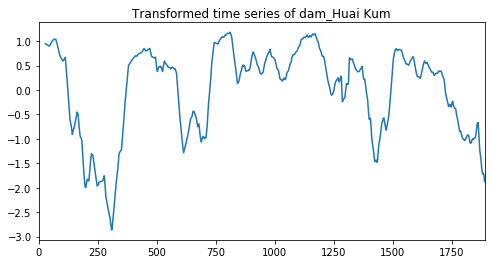

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000835      0.000202         0.000502        0.000064           0    0.0001           0.371960           0.485564           0.473185           0.383652           0.522436         0.447359        0.059172                5
1       0.000904      0.000094         0.000520        0.000001         0.5    0.0001           0.371502           0.485837           0.473162           0.384312           0.522437         0.447450        0.059182                4
2       0.000903      0.000100         0.000530        0.000016           1    0.0001           0.371037           0.486085           0.473133           0.384946           0.522437         0.447528        0.059196                3
3       0.001373      0.000973         0.000526        0.000010           2    0.0001           0.370103           0.486517           0.473060           0.386144           0.522436         0.447652        0.059238                2
4       0.000903      0.000098         0.000529        0.000017          10    0.0001           0.363089           0.488177           0.472114           0.393461           0.522373         0.447843        0.059852                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.078812      0.043763         0.003838        0.000825     0.1             2000            2           0.1       linear           0.481781           0.509343           0.499351           0.369238           0.511302         0.474203        0.053514                1
1        0.050811      0.038527         0.007567        0.003093     0.1             2000            2           0.1          rbf           0.088599           0.487151           0.444399           0.365928           0.499303         0.377076        0.151612                9
2        0.047892      0.036544         0.004765        0.002059     0.1             2000            2           0.1         poly          -0.922329          -0.168006          -1.137007          -0.195430          -0.604644        -0.605483        0.385341               31
3        0.029755      0.016338         0.000762        0.000096     0.1             2000            2             1       linear          -0.330145          -0.238005          -0.605410           0.280064           0.533922        -0.071915        0.417088               17
4        0.009746      0.006495         0.001655        0.000406     0.1             2000            2             1          rbf          -0.467668          -0.350008          -1.420409           0.190423           0.440998        -0.321333        0.643933               21
5        0.014576      0.010853         0.001500        0.000401     0.1             2000            2             1         poly          -0.359202          -0.629843          -2.529103           0.030669          -0.019715        -0.701439        0.944811               35
6        0.066309      0.042607         0.002880        0.001158     0.1             2000            3           0.1       linear           0.481781           0.509343           0.499351           0.369238           0.511302         0.474203        0.053514                1
7        0.047272      0.036798         0.006933        0.002967     0.1             2000            3           0.1          rbf           0.088599           0.487151           0.444399           0.365928           0.499303         0.377076        0.151612                9
8        0.052776      0.037452         0.004314        0.001787     0.1             2000            3           0.1         poly          -0.770213           0.210502           0.201069           0.005688          -0.799610        -0.230513        0.458627               19
9        0.030287      0.016537         0.000777        0.000107     0.1             2000            3             1       linear          -0.330145          -0.238005          -0.605410           0.280064           0.533922        -0.071915        0.417088               17
10       0.009784      0.006442         0.001713        0.000413     0.1             2000            3             1          rbf          -0.467668          -0.350008          -1.420409           0.190423           0.440998        -0.321333        0.643933               21
11       0.029077      0.019480         0.001282        0.000206     0.1             2000            3             1         poly          -0.309197          -0.354888          -1.913213           0.113993           0.052751        -0.482111        0.739669               29
12       0.215463      0.148895         0.003003        0.001181       1             2000            2           0.1       linear           0.482102           0.497559           0.498838           0.361204           0.511799         0.470300        0.055355                3
13       0.058864      0.043660         0.006699        0.002864       1             2000            2           0.1          rbf           0.153904      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001380      0.000302         0.000574        0.000016           0    0.0001          -0.804181           0.350133           0.244183           0.355045           0.484729         0.125982        0.471293                5
1       0.001407      0.000292         0.000569        0.000008         0.5    0.0001          -0.710635           0.352817           0.247001           0.357928           0.486031         0.146628        0.435277                4
2       0.001388      0.000255         0.000557        0.000005           1    0.0001          -0.656963           0.355073           0.248957           0.360545           0.487145         0.158951        0.414881                3
3       0.001366      0.000259         0.000559        0.000008           2    0.0001          -0.584713           0.358791           0.251547           0.365177           0.488995         0.175959        0.387700                2
4       0.001413      0.000351         0.000581        0.000043          10    0.0001          -0.395761           0.374809           0.257984           0.388209           0.497441         0.224536        0.319291                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.143642      0.094564         0.009630        0.002745     0.1             2000            2           0.1       linear          -0.493942           0.520429           0.499667           0.379294           0.520571         0.285204        0.393102                1
1        0.076485      0.057482         0.014747        0.006524     0.1             2000            2           0.1          rbf          -1.015147          -0.023223           0.284983           0.394142           0.457901         0.019731        0.543204                7
2        0.066072      0.051298         0.010378        0.004634     0.1             2000            2           0.1         poly          -1.352883          -1.262918          -2.894763           0.057039          -0.087975        -1.108300        1.065294               32
3        0.033766      0.019192         0.001499        0.000427     0.1             2000            2             1       linear          -0.553403           0.007723          -1.242190           0.353486           0.429538        -0.200969        0.625598               11
4        0.013690      0.009043         0.002798        0.000890     0.1             2000            2             1          rbf          -1.557299          -0.949083          -1.691680           0.220998           0.417821        -0.711849        0.880624               21
5        0.020326      0.014250         0.003369        0.001074     0.1             2000            2             1         poly          -0.821560          -1.638388          -1.364264           0.095868          -0.125045        -0.770678        0.674626               25
6        0.125743      0.092894         0.008070        0.003360     0.1             2000            3           0.1       linear          -0.493942           0.520429           0.499667           0.379294           0.520571         0.285204        0.393102                1
7        0.082205      0.066678         0.015409        0.007996     0.1             2000            3           0.1          rbf          -1.015147          -0.023223           0.284983           0.394142           0.457901         0.019731        0.543204                7
8        0.088895      0.064095         0.012466        0.005849     0.1             2000            3           0.1         poly          -0.972069           0.275673          -0.312412           0.115006           0.295951        -0.119570        0.479133                9
9        0.035453      0.020650         0.001838        0.000820     0.1             2000            3             1       linear          -0.553403           0.007723          -1.242190           0.353486           0.429538        -0.200969        0.625598               11
10       0.013223      0.008667         0.002733        0.000828     0.1             2000            3             1          rbf          -1.557299          -0.949083          -1.691680           0.220998           0.417821        -0.711849        0.880624               21
11       0.020704      0.013275         0.002717        0.000459     0.1             2000            3             1         poly          -0.319776          -0.093161          -0.799058           0.096642           0.425317        -0.138007        0.410958               10
12       0.669234      0.468983         0.008329        0.003227       1             2000            2           0.1       linear          -1.162433           0.511584           0.503449           0.364365           0.520862         0.147565        0.657512                3
13       0.083895      0.062473         0.013611        0.006288       1             2000            2           0.1          rbf          -2.750761      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001769      0.001035         0.000660        0.000016           0    0.0001          -3.127533           0.039821          -1.058296          -0.302678           0.209658        -0.847806        1.220224                5
1       0.001360      0.000232         0.000645        0.000014         0.5    0.0001          -3.062171           0.045658          -1.056365          -0.300711           0.212064        -0.832305        1.197215                4
2       0.001315      0.000193         0.000649        0.000037           1    0.0001          -3.024218           0.050527          -1.055063          -0.298934           0.214235        -0.822691        1.184294                3
3       0.001298      0.000196         0.000625        0.000005           2    0.0001          -2.972035           0.058485          -1.053368          -0.295792           0.218070        -0.808928        1.166981                2
4       0.001299      0.000195         0.000627        0.000005          10    0.0001          -2.815609           0.093088          -1.046143          -0.280284           0.238901        -0.762010        1.119203                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.113918      0.079722         0.007634        0.002352     0.1             2000            2           0.1       linear          -3.635466           0.046928          -1.141182          -0.657161           0.381378        -1.001100        1.420381                9
1        0.072142      0.057244         0.012184        0.005303     0.1             2000            2           0.1          rbf          -4.431260          -0.147367          -0.171640          -1.381837           0.352847        -1.155851        1.734431               13
2        0.055179      0.043273         0.007486        0.003247     0.1             2000            2           0.1         poly          -7.088142          -1.183908          -0.928403          -0.208895           0.277418        -1.826386        2.681324               25
3        0.036496      0.025419         0.001916        0.000638     0.1             2000            2             1       linear          -3.249944           0.118894          -0.746938          -0.132179           0.059914        -0.790051        1.267623                3
4        0.015846      0.011220         0.002866        0.001085     0.1             2000            2             1          rbf          -3.810075          -1.145220          -1.762505           0.034285           0.349496        -1.266804        1.485529               17
5        0.018704      0.013268         0.002691        0.001007     0.1             2000            2             1         poly          -4.238578          -2.003796          -1.288075          -0.298382           0.447927        -1.476181        1.614559               19
6        0.098537      0.077620         0.006478        0.002938     0.1             2000            3           0.1       linear          -3.635466           0.046928          -1.141182          -0.657161           0.381378        -1.001100        1.420381                9
7        0.081573      0.075064         0.015040        0.009125     0.1             2000            3           0.1          rbf          -4.431260          -0.147367          -0.171640          -1.381837           0.352847        -1.155851        1.734431               13
8        0.078152      0.052780         0.008580        0.002389     0.1             2000            3           0.1         poly          -3.134064           0.177388          -0.993024          -0.113259           0.248408        -0.762910        1.265250                2
9        0.036307      0.025064         0.001891        0.000624     0.1             2000            3             1       linear          -3.249944           0.118894          -0.746938          -0.132179           0.059914        -0.790051        1.267623                3
10       0.017360      0.012569         0.003257        0.001342     0.1             2000            3             1          rbf          -3.810075          -1.145220          -1.762505           0.034285           0.349496        -1.266804        1.485529               17
11       0.022069      0.015792         0.002416        0.000566     0.1             2000            3             1         poly          -2.331526          -0.123949          -1.501700           0.033184           0.241564        -0.736486        1.005374                1
12       0.373949      0.317994         0.006516        0.002935       1             2000            2           0.1       linear          -3.927948          -0.018246          -1.162783          -0.675561           0.366253        -1.083657        1.516584               11
13       0.076270      0.057595         0.011065        0.005293       1             2000            2           0.1          rbf          -5.944713      

>>> Final results:



period = 15, future = 10, Node: dam_Xe Kaman 3, neighbors: ['dam_Xe Kaman 1']


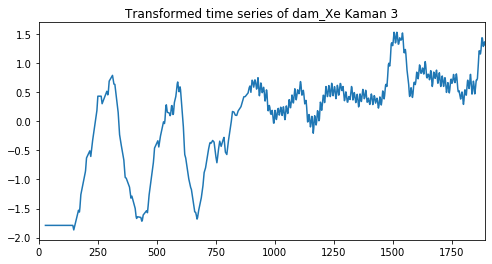

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000942      0.000284         0.000558        0.000126           0    0.0001           0.578643           0.587369           0.630941           0.666898           0.522817         0.597333        0.048928                3
1       0.001064      0.000112         0.000610        0.000003         0.5    0.0001           0.578538           0.587919           0.630691           0.666822           0.522821         0.597358        0.048858                1
2       0.001064      0.000124         0.000612        0.000003           1    0.0001           0.578385           0.588345           0.630408           0.666744           0.522821         0.597341        0.048793                2
3       0.001453      0.000778         0.000618        0.000015           2    0.0001           0.578018           0.588950           0.629761           0.666577           0.522811         0.597223        0.048668                4
4       0.001078      0.000125         0.000619        0.000007          10    0.0001           0.574502           0.589839           0.622832           0.664915           0.522378         0.594893        0.047715                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.082320      0.053339         0.003371        0.001118     0.1             2000            2           0.1       linear           0.549505           0.555594           0.577055           0.665466           0.525268         0.574578        0.048347                5
1        0.049712      0.039564         0.006931        0.003262     0.1             2000            2           0.1          rbf           0.439207           0.498300           0.635465          -0.448967           0.530760         0.330953        0.395133               13
2        0.041319      0.034859         0.004002        0.001910     0.1             2000            2           0.1         poly           0.009946           0.307488          -0.074046          -2.125065          -1.239829        -0.624301        0.917000               31
3        0.016379      0.014863         0.000439        0.000076     0.1             2000            2             1       linear           0.499125           0.501099           0.345298           0.269539           0.376426         0.398298        0.090111               11
4        0.003521      0.002414         0.000765        0.000222     0.1             2000            2             1          rbf           0.458813           0.388436           0.199285          -0.486438           0.181823         0.148384        0.334873               25
5        0.006990      0.006678         0.000853        0.000387     0.1             2000            2             1         poly           0.188005           0.274617          -0.114205          -2.614336          -1.420011        -0.737186        1.118729               35
6        0.070819      0.052296         0.002909        0.001289     0.1             2000            3           0.1       linear           0.549505           0.555594           0.577055           0.665466           0.525268         0.574578        0.048347                5
7        0.046041      0.036622         0.006458        0.003038     0.1             2000            3           0.1          rbf           0.439207           0.498300           0.635465          -0.448967           0.530760         0.330953        0.395133               13
8        0.054298      0.039666         0.003754        0.001895     0.1             2000            3           0.1         poly          -0.087805           0.412110           0.186056           0.386266           0.359901         0.251306        0.187147               21
9        0.016303      0.014790         0.000453        0.000098     0.1             2000            3             1       linear           0.499125           0.501099           0.345298           0.269539           0.376426         0.398298        0.090111               11
10       0.003552      0.002403         0.000733        0.000176     0.1             2000            3             1          rbf           0.458813           0.388436           0.199285          -0.486438           0.181823         0.148384        0.334873               25
11       0.007360      0.005449         0.000643        0.000176     0.1             2000            3             1         poly           0.327132           0.359150          -0.212711           0.019218          -0.177727         0.063013        0.242220               28
12       0.329576      0.284242         0.002889        0.001420       1             2000            2           0.1       linear           0.541735           0.557238           0.607439           0.663869           0.523652         0.578787        0.050866                1
13       0.059530      0.043550         0.006232        0.002950       1             2000            2           0.1          rbf           0.285253      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001955      0.001484         0.000653        0.000017           0    0.0001         -26.972744           0.550734           0.551316           0.634799           0.534137        -4.940352       11.016252                5
1       0.004617      0.004181         0.000654        0.000021         0.5    0.0001         -21.456725           0.560715           0.580416           0.639918           0.534405        -3.828254        8.814304                4
2       0.002835      0.003210         0.000625        0.000008           1    0.0001         -19.093296           0.562641           0.593339           0.643033           0.534522        -3.351952        7.870754                3
3       0.001291      0.000207         0.002641        0.004047           2    0.0001         -16.246531           0.563319           0.606815           0.647162           0.534647        -2.778918        6.733915                2
4       0.002912      0.003315         0.000621        0.000005          10    0.0001          -8.650894           0.557616           0.622950           0.658154           0.534677        -1.255499        3.697962                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.115932      0.069145         0.006468        0.002326     0.1             2000            2           0.1       linear          -8.720790           0.550712           0.575821           0.643863           0.524146        -1.285250        3.717983               28
1        0.064704      0.050861         0.010988        0.005034     0.1             2000            2           0.1          rbf           0.056743           0.510509           0.524761           0.172700           0.565466         0.366036        0.209227                7
2        0.056585      0.046551         0.007473        0.004077     0.1             2000            2           0.1         poly           0.372122           0.001620          -0.444959          -2.512111          -1.475976        -0.811861        1.051673               24
3        0.022037      0.017207         0.000761        0.000189     0.1             2000            2             1       linear           0.498399           0.409969           0.457320           0.313274           0.377788         0.411350        0.063934                5
4        0.005367      0.003405         0.001205        0.000252     0.1             2000            2             1          rbf           0.102887           0.300529           0.187138          -0.452753           0.223643         0.072289        0.270110               16
5        0.011896      0.011538         0.001591        0.001012     0.1             2000            2             1         poly           0.072197           0.109790          -0.512581          -2.728158          -1.546062        -0.920963        1.083725               27
6        0.116042      0.080803         0.006383        0.002993     0.1             2000            3           0.1       linear          -8.720790           0.550712           0.575821           0.643863           0.524146        -1.285250        3.717983               28
7        0.068393      0.053636         0.011812        0.005427     0.1             2000            3           0.1          rbf           0.056743           0.510509           0.524761           0.172700           0.565466         0.366036        0.209227                7
8        0.061818      0.045680         0.006908        0.003225     0.1             2000            3           0.1         poly          -0.023548          -0.062579          -0.233058           0.271162           0.156559         0.021707        0.175767               18
9        0.018980      0.014923         0.000546        0.000137     0.1             2000            3             1       linear           0.498399           0.409969           0.457320           0.313274           0.377788         0.411350        0.063934                5
10       0.004484      0.002773         0.000960        0.000221     0.1             2000            3             1          rbf           0.102887           0.300529           0.187138          -0.452753           0.223643         0.072289        0.270110               16
11       0.009716      0.008334         0.001301        0.000578     0.1             2000            3             1         poly          -0.290104           0.211049          -0.392467          -0.149156          -0.351834        -0.194502        0.218911               21
12       0.535342      0.355732         0.006327        0.003096       1             2000            2           0.1       linear         -17.206460           0.531551           0.529430           0.632075           0.521679        -2.998345        7.104174               33
13       0.085437      0.063678         0.011280        0.005440       1             2000            2           0.1          rbf          -0.947844      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000920      0.000043         0.000538        0.000012           0    0.0001         -35.626486          -0.088734          -0.269111          -0.496179          -0.089862        -7.314074       14.156996                1
1       0.000841      0.000084         0.000518        0.000017         0.5    0.0001         -37.395844          -0.087091          -0.242835          -0.486734          -0.098019        -7.662105       14.867569                2
2       0.000857      0.000084         0.000525        0.000006           1    0.0001         -38.317849          -0.086458          -0.246570          -0.481416          -0.106237        -7.847706       15.235724                3
3       0.000850      0.000081         0.000528        0.000004           2    0.0001         -39.311280          -0.083557          -0.266948          -0.475349          -0.121171        -8.051661       15.630415                5
4       0.000855      0.000084         0.000525        0.000005          10    0.0001         -38.879938          -0.062693          -0.367186          -0.476798          -0.201839        -7.997691       15.441769                4

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.060166      0.039161         0.004509        0.001129     0.1             2000            2           0.1       linear         -80.614758           0.028963          -0.167033          -0.108158           0.082881       -16.155621       32.229695               35
1        0.064748      0.050297         0.009431        0.004508     0.1             2000            2           0.1          rbf          -0.428385          -0.170588          -0.200405          -0.452025          -0.058850        -0.262051        0.153110                1
2        0.063418      0.028908         0.004836        0.002188     0.1             2000            2           0.1         poly         -17.474949          -0.396887          -1.289922          -1.954995          -1.545013        -4.532353        6.491428               25
3        0.030169      0.021149         0.001357        0.000456     0.1             2000            2             1       linear         -14.950078          -0.091301          -0.733601          -1.013310          -0.714048        -3.500468        5.732742               20
4        0.015284      0.011567         0.002352        0.001024     0.1             2000            2             1          rbf          -0.172318          -0.115642          -0.471789          -0.682678          -0.438911        -0.376267        0.208066                3
5        0.025516      0.022580         0.001809        0.000879     0.1             2000            2             1         poly          -5.837909          -0.260053          -1.392690          -2.022277          -1.843645        -2.271315        1.885878               13
6        0.052055      0.036863         0.003644        0.001454     0.1             2000            3           0.1       linear         -80.614758           0.028963          -0.167033          -0.108158           0.082881       -16.155621       32.229695               35
7        0.058947      0.045204         0.008320        0.003889     0.1             2000            3           0.1          rbf          -0.428385          -0.170588          -0.200405          -0.452025          -0.058850        -0.262051        0.153110                1
8        0.743332      1.359256         0.004471        0.001963     0.1             2000            3           0.1         poly          -6.648355          -0.355909          -0.888543          -0.828045          -0.547832        -1.853737        2.405032               11
9        0.029127      0.020975         0.001284        0.000453     0.1             2000            3             1       linear         -14.950078          -0.091301          -0.733601          -1.013310          -0.714048        -3.500468        5.732742               20
10       0.015833      0.012587         0.002473        0.001192     0.1             2000            3             1          rbf          -0.172318          -0.115642          -0.471789          -0.682678          -0.438911        -0.376267        0.208066                3
11       0.079223      0.076149         0.001548        0.000576     0.1             2000            3             1         poly          -3.399581          -0.270752          -1.244625          -1.330220          -1.194033        -1.487842        1.030182                9
12       0.117514      0.103786         0.003558        0.001564       1             2000            2           0.1       linear         -67.432991           0.037670          -0.127684          -0.154899           0.140207       -13.507539       26.962943               31
13       0.062024      0.048006         0.009277        0.004114       1             2000            2           0.1          rbf          -2.566289      

>>> Final results:



period = 15, future = 10, Node: dam_Pak Mun, neighbors: ['dam_Ubol Ratana', 'dam_Lam Pao', 'rw_34', 'dam_Sirindhorn', 'dam_Lamtakhong', 'dam_Lamphraphloeng', 'dam_Lamnangrong']


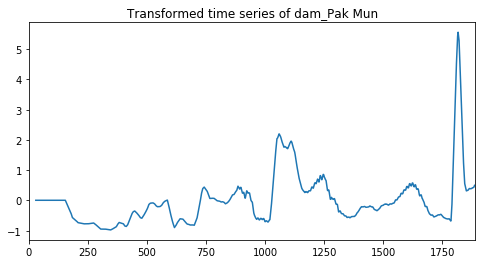

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000839      0.000189         0.000488        0.000082           0    0.0001           0.441567           0.400988           0.647193           0.510619           0.332987         0.466671        0.107084                3
1       0.002910      0.003957         0.000528        0.000014         0.5    0.0001           0.422899           0.424156           0.646381           0.512293           0.332196         0.467585        0.106000                2
2       0.002271      0.002765         0.000540        0.000026           1    0.0001           0.409024           0.438209           0.645557           0.513735           0.331419         0.467589        0.106431                1
3       0.002978      0.004165         0.000534        0.000019           2    0.0001           0.388297           0.454764           0.643972           0.516133           0.329917         0.466617        0.108506                4
4       0.002565      0.003387         0.000531        0.000015          10    0.0001           0.313800           0.474224           0.634095           0.526310           0.320225         0.453731        0.122983                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.056921      0.036923         0.002491        0.000858     0.1             2000            2           0.1       linear           0.268077           0.458330           0.656735           0.536115           0.302790         0.444410        0.144800                5
1        0.040011      0.035174         0.005057        0.002927     0.1             2000            2           0.1          rbf           0.278880          -0.236182          -0.854757           0.415198           0.004275        -0.078517        0.448497                7
2        0.052120      0.042368         0.004048        0.002468     0.1             2000            2           0.1         poly           0.336591          -0.017395          -9.769880          -0.187378          -6.819277        -3.291468        4.193638               28
3        0.005226      0.005842         0.000469        0.000154     0.1             2000            2             1       linear          -0.000003          -0.627333          -0.193667          -1.651332           0.416995        -0.411068        0.705259               17
4        0.004014      0.004139         0.000685        0.000387     0.1             2000            2             1          rbf          -0.000003          -0.627333          -0.422859          -0.760189           0.099510        -0.342175        0.339036               15
5        0.008321      0.009405         0.000651        0.000343     0.1             2000            2             1         poly          -0.000003          -0.627333          -0.406167          -0.188331          -5.247176        -1.293802        1.987824               25
6        0.050265      0.038443         0.002167        0.001206     0.1             2000            3           0.1       linear           0.268077           0.458330           0.656735           0.536115           0.302790         0.444410        0.144800                5
7        0.037136      0.031637         0.004810        0.002778     0.1             2000            3           0.1          rbf           0.278880          -0.236182          -0.854757           0.415198           0.004275        -0.078517        0.448497                7
8        0.079384      0.052146         0.004284        0.002046     0.1             2000            3           0.1         poly          -0.066729           0.158624         -14.382863           0.078726        -148.292032       -32.500855       58.165112               34
9        0.004999      0.005586         0.000443        0.000137     0.1             2000            3             1       linear          -0.000003          -0.627333          -0.193667          -1.651332           0.416995        -0.411068        0.705259               17
10       0.003844      0.003954         0.000634        0.000340     0.1             2000            3             1          rbf          -0.000003          -0.627333          -0.422859          -0.760189           0.099510        -0.342175        0.339036               15
11       0.010055      0.013808         0.000489        0.000164     0.1             2000            3             1         poly          -0.000003          -0.627333          -5.990649          -1.416023         -58.395389       -13.285879       22.652748               31
12       0.168602      0.155469         0.002069        0.001117       1             2000            2           0.1       linear           0.329983           0.417846           0.662145           0.530725           0.305498         0.449239        0.132543                1
13       0.050002      0.039912         0.004486        0.002722       1             2000            2           0.1          rbf           0.216343      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003396      0.001213         0.000760        0.000049           0    0.0001          -1.845348           0.376441           0.707378          -1.314460           0.360935        -0.343011        1.031232                5
1       0.003830      0.001703         0.000739        0.000045         0.5    0.0001          -1.149954           0.410671           0.707899          -1.308333           0.359732        -0.195997        0.853374                4
2       0.003384      0.000996         0.000714        0.000020           1    0.0001          -0.977566           0.428347           0.707904          -1.305195           0.358582        -0.157585        0.818314                3
3       0.003380      0.001002         0.000704        0.000016           2    0.0001          -0.800182           0.447505           0.707375          -1.302993           0.356446        -0.118370        0.786857                2
4       0.003450      0.000977         0.000736        0.000019          10    0.0001          -0.481451           0.467181           0.698586          -1.331459           0.343693        -0.060690        0.749742                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.281656      0.231003         0.020309        0.009825     0.1             2000            2           0.1       linear          -2.628059           0.458975           0.681210          -0.412334           0.357049        -0.308632        1.216769                3
1        0.100986      0.084776         0.021119        0.012535     0.1             2000            2           0.1          rbf           0.063851          -0.176439          -0.918260          -0.287211          -0.095424        -0.282697        0.337763                1
2        0.104190      0.091877         0.020959        0.012930     0.1             2000            2           0.1         poly           0.052628          -0.175390          -2.786997          -3.133189          -1.279317        -1.464453        1.306239               24
3        0.007407      0.007853         0.000714        0.000377     0.1             2000            2             1       linear          -0.000003          -0.627333          -0.201382          -3.396546           0.079301        -0.829193        1.306837               14
4        0.008248      0.008597         0.001684        0.001452     0.1             2000            2             1          rbf          -0.000003          -0.627333          -0.440788          -5.630465           0.031583        -1.333401        2.163385               22
5        0.007468      0.007867         0.001413        0.001165     0.1             2000            2             1         poly          -0.000003          -0.627333          -0.525029          -2.804123          -0.055737        -0.802445        1.031099               13
6        0.260672      0.227632         0.018886        0.010764     0.1             2000            3           0.1       linear          -2.628059           0.458975           0.681210          -0.412334           0.357049        -0.308632        1.216769                3
7        0.101567      0.087417         0.020930        0.012418     0.1             2000            3           0.1          rbf           0.063851          -0.176439          -0.918260          -0.287211          -0.095424        -0.282697        0.337763                1
8        0.098403      0.082658         0.019090        0.011182     0.1             2000            3           0.1         poly          -0.011596          -0.266575          -0.258026           0.248149          -1.608188        -0.379247        0.642881                5
9        0.007417      0.007860         0.000726        0.000377     0.1             2000            3             1       linear          -0.000003          -0.627333          -0.201382          -3.396546           0.079301        -0.829193        1.306837               14
10       0.008148      0.008435         0.001669        0.001432     0.1             2000            3             1          rbf          -0.000003          -0.627333          -0.440788          -5.630465           0.031583        -1.333401        2.163385               22
11       0.006497      0.006279         0.001323        0.000975     0.1             2000            3             1         poly          -0.000003          -0.627333          -0.276623          -2.911879           0.044214        -0.754325        1.105082                8
12       1.730601      1.593302         0.019273        0.010545       1             2000            2           0.1       linear          -3.816721           0.397308           0.685062          -0.473417           0.359902        -0.569573        1.668898                6
13       0.098209      0.082268         0.017236        0.010760       1             2000            2           0.1          rbf          -0.440878      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.002973      0.001011         0.000713        0.000016           0    0.0001          -0.186092           0.178012          -0.487231         -10.268709          -0.126662        -2.178136        4.050796                2
1       0.003038      0.000868         0.000718        0.000017         0.5    0.0001          -0.264878           0.195719          -0.479914         -10.228827          -0.126922        -2.180964        4.029907                3
2       0.003260      0.001037         0.000724        0.000035           1    0.0001          -0.320279           0.205451          -0.474056         -10.196542          -0.127192        -2.182524        4.013431                5
3       0.003081      0.000919         0.000726        0.000048           2    0.0001          -0.387936           0.216778          -0.464610         -10.143672          -0.127722        -2.181432        3.988246                4
4       0.003089      0.000898         0.000728        0.000039          10    0.0001          -0.461830           0.235690          -0.420283          -9.888319          -0.131354        -2.133219        3.885575                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.247017      0.185707         0.020670        0.009439     0.1             2000            2           0.1       linear          -2.109660           0.203691          -0.380983          -7.140280          -0.058409        -1.897128        2.743313               27
1        0.094053      0.080593         0.019512        0.011902     0.1             2000            2           0.1          rbf           0.020267          -0.238494          -0.938347          -0.639476          -0.134392        -0.386088        0.351981                2
2        0.096371      0.079033         0.018886        0.010581     0.1             2000            2           0.1         poly           0.074199          -0.461563          -1.512339          -2.700515          -0.627563        -1.045556        0.972254               14
3        0.014751      0.017276         0.000695        0.000358     0.1             2000            2             1       linear          -0.000003          -0.627333          -0.211017          -1.785265          -0.150258        -0.554775        0.649453                4
4        0.007131      0.007299         0.001438        0.001176     0.1             2000            2             1          rbf          -0.000003          -0.627333          -0.440993          -5.291003           0.016132        -1.268640        2.026611               17
5        0.007396      0.007846         0.001393        0.001131     0.1             2000            2             1         poly          -0.000003          -0.627333          -0.528394          -3.048003          -0.225066        -0.885760        1.103709                7
6        0.226311      0.184667         0.018840        0.010499     0.1             2000            3           0.1       linear          -2.109660           0.203691          -0.380983          -7.140280          -0.058409        -1.897128        2.743313               27
7        0.095899      0.083453         0.019520        0.011858     0.1             2000            3           0.1          rbf           0.020267          -0.238494          -0.938347          -0.639476          -0.134392        -0.386088        0.351981                2
8        0.097127      0.080101         0.018123        0.010660     0.1             2000            3           0.1         poly          -0.040707          -0.441416          -0.490949          -0.211018          -0.613560        -0.359530        0.206015                1
9        0.015699      0.018471         0.000732        0.000382     0.1             2000            3             1       linear          -0.000003          -0.627333          -0.211017          -1.785265          -0.150258        -0.554775        0.649453                4
10       0.007143      0.007361         0.001464        0.001216     0.1             2000            3             1          rbf          -0.000003          -0.627333          -0.440993          -5.291003           0.016132        -1.268640        2.026611               17
11       0.007332      0.007431         0.001405        0.001116     0.1             2000            3             1         poly          -0.000003          -0.627333          -0.266381          -4.300001          -0.003512        -1.039446        1.646347               13
12       1.207988      0.942610         0.019247        0.010493       1             2000            2           0.1       linear          -1.828884           0.180564          -0.427174          -7.525084          -0.048687        -1.929853        2.883314               31
13       0.095220      0.080153         0.016374        0.010225       1             2000            2           0.1          rbf          -0.454175      

>>> Final results:



period = 15, future = 10, Node: dam_Sirindhorn, neighbors: ['dam_Pak Mun']


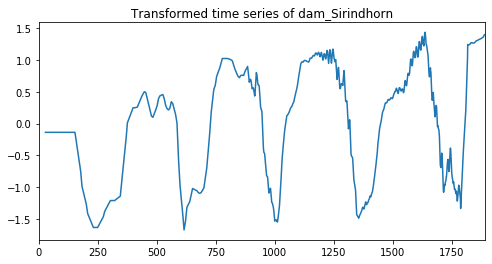

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000947      0.000277         0.000553        0.000125           0    0.0001           0.554099           0.629568           0.782241           0.755631           0.401422         0.624592        0.139157                5
1       0.001066      0.000126         0.000647        0.000056         0.5    0.0001           0.550452           0.640164           0.782394           0.755711           0.402441         0.626233        0.139406                4
2       0.001057      0.000112         0.000607        0.000003           1    0.0001           0.547409           0.648501           0.782514           0.755766           0.403387         0.627516        0.139688                3
3       0.001570      0.001052         0.000617        0.000021           2    0.0001           0.543455           0.660932           0.782685           0.755821           0.405094         0.629598        0.140123                2
4       0.001068      0.000118         0.000618        0.000014          10    0.0001           0.532127           0.696766           0.783023           0.755174           0.413999         0.636218        0.141127                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.068097      0.044525         0.002897        0.000825     0.1             2000            2           0.1       linear           0.549325           0.693975           0.781322           0.756727           0.346673         0.625605        0.161082                1
1        0.042094      0.033607         0.005957        0.002839     0.1             2000            2           0.1          rbf          -0.157196          -0.271112           0.725626           0.746230           0.416514         0.292013        0.430983               11
2        0.049213      0.033201         0.004435        0.002183     0.1             2000            2           0.1         poly           0.056894          -0.901260          -0.915754           0.225052          -0.949409        -0.496896        0.523758               29
3        0.009801      0.008493         0.000505        0.000128     0.1             2000            2             1       linear          -1.107573          -0.339068           0.498084           0.659445           0.411443         0.024466        0.661957               16
4        0.003559      0.003017         0.000756        0.000299     0.1             2000            2             1          rbf          -1.107573          -1.001825           0.159649           0.491850           0.377726        -0.216034        0.693844               26
5        0.016910      0.015205         0.001307        0.000832     0.1             2000            2             1         poly          -1.107573          -0.990421          -0.198841           0.213455          -0.418225        -0.500321        0.493165               30
6        0.060723      0.048117         0.002241        0.001093     0.1             2000            3           0.1       linear           0.549325           0.693975           0.781322           0.756727           0.346673         0.625605        0.161082                1
7        0.038170      0.030165         0.005285        0.002556     0.1             2000            3           0.1          rbf          -0.157196          -0.271112           0.725626           0.746230           0.416514         0.292013        0.430983               11
8        0.054741      0.034431         0.004133        0.001982     0.1             2000            3           0.1         poly          -0.876749           0.368157           0.459395           0.513703           0.014176         0.095736        0.516437               13
9        0.009647      0.008328         0.000454        0.000094     0.1             2000            3             1       linear          -1.107573          -0.339068           0.498084           0.659445           0.411443         0.024466        0.661957               16
10       0.003470      0.002925         0.000694        0.000260     0.1             2000            3             1          rbf          -1.107573          -1.001825           0.159649           0.491850           0.377726        -0.216034        0.693844               26
11       0.010286      0.012123         0.000616        0.000244     0.1             2000            3             1         poly          -1.107573          -0.398442           0.368016           0.476924           0.212898        -0.089635        0.592203               24
12       0.210435      0.190889         0.002124        0.001129       1             2000            2           0.1       linear           0.560976           0.665160           0.772929           0.756162           0.341623         0.619370        0.158077                3
13       0.051125      0.040234         0.004958        0.002579       1             2000            2           0.1          rbf           0.009599      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001313      0.000277         0.000654        0.000018           0    0.0001           0.534933           0.611076           0.561087           0.744773           0.404750         0.571324        0.110309                5
1       0.001355      0.000217         0.000650        0.000013         0.5    0.0001           0.535244           0.612971           0.564559           0.746103           0.407081         0.573192        0.110080                4
2       0.001298      0.000189         0.000635        0.000015           1    0.0001           0.534563           0.617161           0.566557           0.747163           0.409115         0.574912        0.110129                3
3       0.001297      0.000203         0.000632        0.000008           2    0.0001           0.532364           0.625006           0.569057           0.748774           0.412562         0.577553        0.110367                2
4       0.001288      0.000202         0.000630        0.000006          10    0.0001           0.506657           0.652737           0.578107           0.753613           0.428188         0.583860        0.112949                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.077961      0.053988         0.004941        0.001708     0.1             2000            2           0.1       linear           0.490510           0.686591           0.681339           0.763136           0.345367         0.593389        0.153189                1
1        0.053784      0.044141         0.008772        0.004635     0.1             2000            2           0.1          rbf          -0.449363          -0.380909           0.437314           0.734912           0.372394         0.142869        0.472224                7
2        0.063945      0.048707         0.007368        0.004512     0.1             2000            2           0.1         poly           0.125959          -0.385068          -1.347022           0.316155          -1.250409        -0.508077        0.685766               21
3        0.015870      0.014658         0.000638        0.000240     0.1             2000            2             1       linear          -1.107573          -0.599835          -0.294075           0.657922           0.342606        -0.200191        0.636060               13
4        0.004549      0.003557         0.001003        0.000426     0.1             2000            2             1          rbf          -1.107573          -1.238603           0.055689           0.424996           0.360714        -0.300955        0.724130               19
5        0.013887      0.014467         0.001572        0.001192     0.1             2000            2             1         poly          -1.107573          -0.807981          -1.915165           0.212822          -0.740983        -0.871776        0.684367               27
6        0.065948      0.053093         0.004148        0.001960     0.1             2000            3           0.1       linear           0.490510           0.686591           0.681339           0.763136           0.345367         0.593389        0.153189                1
7        0.050592      0.041242         0.008213        0.004188     0.1             2000            3           0.1          rbf          -0.449363          -0.380909           0.437314           0.734912           0.372394         0.142869        0.472224                7
8        0.066418      0.046885         0.007040        0.004212     0.1             2000            3           0.1         poly          -0.250033           0.339098          -1.433017           0.547861          -5.380389        -1.235296        2.184033               30
9        0.014732      0.013432         0.000605        0.000218     0.1             2000            3             1       linear          -1.107573          -0.599835          -0.294075           0.657922           0.342606        -0.200191        0.636060               13
10       0.003935      0.003217         0.000838        0.000361     0.1             2000            3             1          rbf          -1.107573          -1.238603           0.055689           0.424996           0.360714        -0.300955        0.724130               19
11       0.009680      0.010328         0.000842        0.000451     0.1             2000            3             1         poly          -1.107573          -0.601770           0.481261           0.411560         -13.753136        -2.913932        5.453139               32
12       0.252951      0.216013         0.004018        0.002030       1             2000            2           0.1       linear           0.500676           0.682372           0.668376           0.760962           0.334418         0.589361        0.153103                5
13       0.064279      0.050314         0.007828        0.004370       1             2000            2           0.1          rbf          -0.459314      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001011      0.000238         0.000572        0.000112           0    0.0001          -1.405832          -0.164918          -0.629893           0.295004          -0.072645        -0.395657        0.584792                5
1       0.001084      0.000127         0.000616        0.000007         0.5    0.0001          -1.430453          -0.114217          -0.623858           0.294699          -0.072894        -0.389345        0.597102                4
2       0.001096      0.000132         0.000616        0.000007           1    0.0001          -1.444774          -0.082599          -0.618768           0.294400          -0.073176        -0.384983        0.604654                3
3       0.001064      0.000119         0.000607        0.000006           2    0.0001          -1.464618          -0.043692          -0.610219           0.293818          -0.073797        -0.379702        0.614864                2
4       0.001066      0.000102         0.000603        0.000004          10    0.0001          -1.525355           0.037896          -0.566316           0.289822          -0.079182        -0.368627        0.641825                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.072885      0.051025         0.004721        0.001319     0.1             2000            2           0.1       linear          -1.561653           0.159751          -1.066858           0.315047          -0.709177        -0.572578        0.716300               17
1        0.058898      0.048489         0.008002        0.004356     0.1             2000            2           0.1          rbf          -1.771615          -0.996689           0.459920           0.533849           0.432620        -0.268383        0.943985                1
2        0.050211      0.039398         0.004465        0.002297     0.1             2000            2           0.1         poly          -1.517971          -0.197682         -11.600382          -0.023337          -1.780967        -3.024068        4.344183               28
3        0.027227      0.027852         0.000897        0.000465     0.1             2000            2             1       linear          -1.107573          -0.752093           0.194890           0.275312           0.033518        -0.271189        0.554896                3
4        0.006196      0.005088         0.001099        0.000547     0.1             2000            2             1          rbf          -1.107573          -1.618617           0.068323           0.327231           0.399758        -0.386175        0.821284               11
5        0.026432      0.025244         0.001615        0.001124     0.1             2000            2             1         poly          -1.107573          -0.828051          -7.298957          -0.001727          -2.323400        -2.311942        2.602306               25
6        0.056916      0.048245         0.003355        0.001741     0.1             2000            3           0.1       linear          -1.561653           0.159751          -1.066858           0.315047          -0.709177        -0.572578        0.716300               17
7        0.055229      0.045776         0.007540        0.004276     0.1             2000            3           0.1          rbf          -1.771615          -0.996689           0.459920           0.533849           0.432620        -0.268383        0.943985                1
8        0.069080      0.053781         0.004177        0.001994     0.1             2000            3           0.1         poly          -1.620261          -0.275221         -45.718886           0.018693         -43.923609       -18.303857       21.665851               31
9        0.025275      0.025722         0.000821        0.000410     0.1             2000            3             1       linear          -1.107573          -0.752093           0.194890           0.275312           0.033518        -0.271189        0.554896                3
10       0.005969      0.004848         0.001069        0.000479     0.1             2000            3             1          rbf          -1.107573          -1.618617           0.068323           0.327231           0.399758        -0.386175        0.821284               11
11       0.033307      0.022836         0.001365        0.000864     0.1             2000            3             1         poly          -1.107573          -0.838949         -26.776621           0.027250         -92.587689       -24.256716       35.635537               32
12       0.147004      0.142822         0.003452        0.001879       1             2000            2           0.1       linear          -1.521638          -0.081816          -1.175010           0.327182          -0.712585        -0.632773        0.680520               19
13       0.065660      0.049944         0.008300        0.003882       1             2000            2           0.1          rbf          -1.728455      

>>> Final results:



period = 15, future = 10, Node: dam_Houayho, neighbors: ['rw_34']


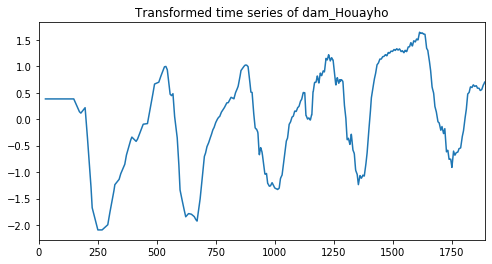

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000940      0.000280         0.000551        0.000124           0    0.0001           0.714056           0.685395           0.574128           0.722737           0.731141         0.685491        0.057773                5
1       0.001061      0.000118         0.000612        0.000005         0.5    0.0001           0.713656           0.687264           0.575630           0.722883           0.731341         0.686155        0.057208                4
2       0.001060      0.000118         0.000610        0.000004           1    0.0001           0.713113           0.688812           0.576986           0.723018           0.731533         0.686692        0.056689                3
3       0.001127      0.000224         0.000649        0.000086           2    0.0001           0.712084           0.691270           0.579350           0.723261           0.731896         0.687572        0.055794                2
4       0.001102      0.000082         0.000621        0.000019          10    0.0001           0.708563           0.700664           0.589889           0.724377           0.734118         0.691522        0.052148                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.075185      0.046808         0.002765        0.000796     0.1             2000            2           0.1       linear           0.714813           0.686007           0.527575           0.763340           0.712530         0.680853        0.080600                1
1        0.046164      0.037775         0.006077        0.003199     0.1             2000            2           0.1          rbf           0.689908           0.732235           0.486232           0.668072           0.734404         0.662170        0.091526                7
2        0.046767      0.036286         0.004544        0.002080     0.1             2000            2           0.1         poly           0.416004           0.312311          -0.159549          -1.260871          -1.512542        -0.440929        0.800192               34
3        0.020038      0.016470         0.000641        0.000145     0.1             2000            2             1       linear           0.076162           0.483456           0.320656           0.358006           0.473951         0.342446        0.147514               19
4        0.006433      0.004610         0.001042        0.000417     0.1             2000            2             1          rbf          -0.005015           0.476004           0.241499           0.304034           0.353007         0.273906        0.159283               27
5        0.016142      0.018161         0.001318        0.000751     0.1             2000            2             1         poly           0.010213           0.250514           0.008204          -0.701740          -0.785816        -0.243725        0.418537               31
6        0.063496      0.048178         0.002034        0.001099     0.1             2000            3           0.1       linear           0.714813           0.686007           0.527575           0.763340           0.712530         0.680853        0.080600                1
7        0.041007      0.033173         0.005590        0.002989     0.1             2000            3           0.1          rbf           0.689908           0.732235           0.486232           0.668072           0.734404         0.662170        0.091526                7
8        0.050960      0.039435         0.004189        0.001932     0.1             2000            3           0.1         poly           0.416700           0.539833           0.402478           0.569977           0.487110         0.483220        0.065865               13
9        0.019315      0.016019         0.000528        0.000116     0.1             2000            3             1       linear           0.076162           0.483456           0.320656           0.358006           0.473951         0.342446        0.147514               19
10       0.006328      0.004552         0.000996        0.000378     0.1             2000            3             1          rbf          -0.005015           0.476004           0.241499           0.304034           0.353007         0.273906        0.159283               27
11       0.011672      0.009553         0.000813        0.000274     0.1             2000            3             1         poly           0.124564           0.373351           0.290728           0.284286           0.468387         0.308263        0.113582               24
12       0.262722      0.210248         0.002108        0.001118       1             2000            2           0.1       linear           0.718763           0.682788           0.520810           0.764111           0.711045         0.679503        0.083533                3
13       0.053594      0.040879         0.005061        0.002813       1             2000            2           0.1          rbf           0.702706      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001099      0.000193         0.000552        0.000028           0    0.0001           0.735603           0.707793           0.592513           0.718064           0.736388         0.698072        0.053877                5
1       0.001121      0.000173         0.000541        0.000005         0.5    0.0001           0.735551           0.710444           0.593767           0.718314           0.736555         0.698926        0.053525                4
2       0.001127      0.000185         0.000541        0.000008           1    0.0001           0.735298           0.712304           0.594884           0.718553           0.736715         0.699551        0.053175                3
3       0.001099      0.000161         0.000533        0.000003           2    0.0001           0.734761           0.715000           0.596805           0.719000           0.737015         0.700516        0.052559                2
4       0.001089      0.000167         0.000529        0.000003          10    0.0001           0.733655           0.724733           0.605031           0.721627           0.738750         0.704759        0.050238                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.106143      0.070993         0.006289        0.002802     0.1             2000            2           0.1       linear           0.725748           0.696059           0.538598           0.776502           0.735244         0.694430        0.082060                1
1        0.059172      0.045992         0.009659        0.004611     0.1             2000            2           0.1          rbf           0.692364           0.747647           0.630214           0.460133           0.650711         0.636214        0.096769                7
2        0.056873      0.044774         0.007773        0.003795     0.1             2000            2           0.1         poly           0.421129           0.412617           0.027065          -2.613379          -1.366460        -0.623806        1.191607               35
3        0.017458      0.019547         0.000728        0.000252     0.1             2000            2             1       linear           0.096560           0.513584           0.493314           0.430496           0.459766         0.398744        0.153739               11
4        0.007193      0.005634         0.001324        0.000485     0.1             2000            2             1          rbf           0.060762           0.387626           0.173745          -0.306902           0.300526         0.123151        0.241995               23
5        0.014862      0.016662         0.001834        0.001354     0.1             2000            2             1         poly           0.063570           0.237757           0.070199          -2.502692          -0.484492        -0.523132        1.019349               33
6        0.090302      0.073405         0.004033        0.002204     0.1             2000            3           0.1       linear           0.725748           0.696059           0.538598           0.776502           0.735244         0.694430        0.082060                1
7        0.054043      0.042419         0.008752        0.004304     0.1             2000            3           0.1          rbf           0.692364           0.747647           0.630214           0.460133           0.650711         0.636214        0.096769                7
8        0.060023      0.046178         0.006835        0.003452     0.1             2000            3           0.1         poly           0.452153           0.581262           0.462241          -0.468719           0.544911         0.314370        0.394578               20
9        0.017037      0.019203         0.000685        0.000245     0.1             2000            3             1       linear           0.096560           0.513584           0.493314           0.430496           0.459766         0.398744        0.153739               11
10       0.007195      0.005660         0.001330        0.000497     0.1             2000            3             1          rbf           0.060762           0.387626           0.173745          -0.306902           0.300526         0.123151        0.241995               23
11       0.008548      0.006345         0.001183        0.000484     0.1             2000            3             1         poly           0.091537           0.487692           0.235356           0.318459           0.654914         0.357592        0.196257               13
12       0.402602      0.342651         0.004015        0.002257       1             2000            2           0.1       linear           0.729475           0.692147           0.531655           0.774168           0.732760         0.692041        0.084294                3
13       0.066530      0.050209         0.007997        0.004274       1             2000            2           0.1          rbf           0.678314      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000854      0.000198         0.000489        0.000093           0    0.0001          -0.041729           0.074211           0.034160           0.073653          -0.580264        -0.087994        0.249733                5
1       0.000913      0.000113         0.000520        0.000003         0.5    0.0001          -0.049774           0.099566           0.034365           0.075129          -0.580100        -0.084163        0.253107                4
2       0.000913      0.000098         0.000521        0.000004           1    0.0001          -0.055664           0.112643           0.034554           0.076543          -0.579942        -0.082373        0.255048                3
3       0.000917      0.000104         0.000527        0.000014           2    0.0001          -0.064479           0.128630           0.034890           0.079203          -0.579643        -0.080280        0.257665                2
4       0.000894      0.000098         0.000519        0.000007          10    0.0001          -0.096535           0.173062           0.036598           0.095006          -0.577720        -0.073918        0.266862                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.070614      0.044038         0.004784        0.001191     0.1             2000            2           0.1       linear          -0.124613           0.031103          -0.008981           0.034448          -0.669734        -0.147556        0.267374               20
1        0.059164      0.047248         0.008705        0.004377     0.1             2000            2           0.1          rbf           0.159470           0.685274           0.551820          -0.098029          -0.922127         0.075281        0.571162                1
2        0.049240      0.037950         0.004762        0.002024     0.1             2000            2           0.1         poly          -0.023497           0.043376          -0.146082          -0.196542          -0.094808        -0.083510        0.085464               11
3        0.033489      0.024977         0.001483        0.000455     0.1             2000            2             1       linear          -0.211924           0.291464          -0.000630           0.254112          -0.765995        -0.086594        0.385666               12
4        0.012894      0.009181         0.002105        0.000591     0.1             2000            2             1          rbf           0.090757           0.304324           0.060160          -0.439098          -0.491984        -0.095168        0.314337               14
5        0.024752      0.019795         0.002185        0.000781     0.1             2000            2             1         poly          -0.144785          -0.239104          -0.656783          -0.965168          -0.290551        -0.459278        0.306850               32
6        0.060617      0.044717         0.003615        0.001710     0.1             2000            3           0.1       linear          -0.124613           0.031103          -0.008981           0.034448          -0.669734        -0.147556        0.267374               20
7        0.055921      0.044121         0.007979        0.003757     0.1             2000            3           0.1          rbf           0.159470           0.685274           0.551820          -0.098029          -0.922127         0.075281        0.571162                1
8        0.060238      0.044967         0.004427        0.001855     0.1             2000            3           0.1         poly          -0.489452           0.083122          -0.089808          -0.100698          -0.207298        -0.160827        0.188851               26
9        0.030945      0.023097         0.001334        0.000405     0.1             2000            3             1       linear          -0.211924           0.291464          -0.000630           0.254112          -0.765995        -0.086594        0.385666               12
10       0.011858      0.008522         0.001924        0.000534     0.1             2000            3             1          rbf           0.090757           0.304324           0.060160          -0.439098          -0.491984        -0.095168        0.314337               14
11       0.031220      0.023145         0.002162        0.001032     0.1             2000            3             1         poly          -0.189003          -0.012952          -0.545255          -0.280760          -0.274909        -0.260576        0.172102               28
12       0.151216      0.115480         0.003577        0.001528       1             2000            2           0.1       linear          -0.106710          -0.005544          -0.007989           0.035467          -0.666184        -0.150192        0.262203               22
13       0.062828      0.047608         0.007751        0.003722       1             2000            2           0.1          rbf           0.278104      

>>> Final results:



period = 15, future = 10, Node: dam_Xe Kaman 1, neighbors: ['dam_Xe Kaman 3', 'rw_34']


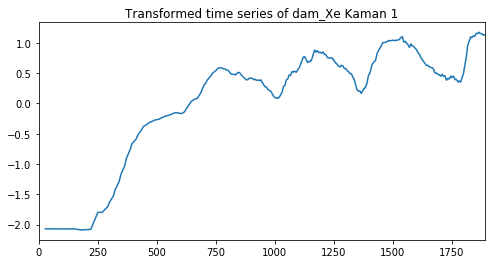

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000962      0.000264         0.000560        0.000126           0    0.0001          -0.274761           0.600185           0.722975           0.799118           0.747715         0.519046        0.402251                3
1       0.001073      0.000114         0.000618        0.000010         0.5    0.0001          -0.280773           0.586422           0.732773           0.801064           0.746202         0.517137        0.405227                5
2       0.001070      0.000112         0.000619        0.000011           1    0.0001          -0.271905           0.576792           0.736230           0.801883           0.744868         0.517574        0.401768                4
3       0.001064      0.000122         0.000612        0.000008           2    0.0001          -0.230995           0.562598           0.738737           0.802723           0.742598         0.523132        0.385509                2
4       0.001205      0.000132         0.000621        0.000007          10    0.0001           0.230338           0.519148           0.731741           0.803649           0.730638         0.603103        0.209301                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.059421      0.033645         0.001626        0.000348     0.1             2000            2           0.1       linear           0.717846           0.332275           0.742604           0.804198           0.738936         0.667172        0.169906                1
1        0.018912      0.017379         0.002454        0.001562     0.1             2000            2           0.1          rbf         -19.059469         -20.556767           0.131693           0.541326           0.647612        -7.659121        9.932403               13
2        0.044097      0.026726         0.003561        0.002353     0.1             2000            2           0.1         poly          -2.742732         -26.570461          -8.173918          -7.017315          -5.214511        -9.943787        8.513098               17
3        0.000563      0.000166         0.000337        0.000011     0.1             2000            2             1       linear         -20.472214         -84.491685         -12.209502          -3.873956          -4.033878       -25.016247       30.361966               19
4        0.001017      0.000559         0.000399        0.000058     0.1             2000            2             1          rbf         -20.472214         -91.501497         -12.930458          -5.892234          -4.244237       -27.008128       32.754753               35
5        0.001630      0.002134         0.000427        0.000086     0.1             2000            2             1         poly         -20.472214         -90.005402         -12.747371          -5.497411          -2.817831       -26.308046       32.435088               30
6        0.053929      0.037429         0.001290        0.000609     0.1             2000            3           0.1       linear           0.717846           0.332275           0.742604           0.804198           0.738936         0.667172        0.169906                1
7        0.018848      0.017327         0.002454        0.001580     0.1             2000            3           0.1          rbf         -19.059469         -20.556767           0.131693           0.541326           0.647612        -7.659121        9.932403               13
8        1.385486      2.664477         0.003326        0.001836     0.1             2000            3           0.1         poly          -4.264558         -23.506261          -3.442932          -0.515596           0.221459        -6.301578        8.767554                8
9        0.000528      0.000157         0.000313        0.000005     0.1             2000            3             1       linear         -20.472214         -84.491685         -12.209502          -3.873956          -4.033878       -25.016247       30.361966               19
10       0.000932      0.000529         0.000374        0.000055     0.1             2000            3             1          rbf         -20.472214         -91.501497         -12.930458          -5.892234          -4.244237       -27.008128       32.754753               35
11       0.000767      0.000634         0.000313        0.000005     0.1             2000            3             1         poly         -20.472214         -88.817884         -12.127410          -4.167656          -3.844214       -25.885875       32.051698               25
12       0.208979      0.161259         0.001165        0.000582       1             2000            2           0.1       linear           0.698111           0.343459           0.740450           0.802277           0.743144         0.665488        0.164394                3
13       0.022977      0.022256         0.001803        0.001243       1             2000            2           0.1          rbf         -19.010569      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003849      0.004044         0.000665        0.000041           0    0.0001           0.783078           0.453724           0.723041           0.818349           0.789506         0.713539        0.133556                1
1       0.001576      0.000320         0.002428        0.003597         0.5    0.0001           0.705495           0.438682           0.734936           0.819931           0.788654         0.697540        0.135463                2
2       0.003465      0.003825         0.000630        0.000013           1    0.0001           0.670318           0.427913           0.738783           0.820410           0.787840         0.689053        0.140023                3
3       0.003309      0.003462         0.002855        0.004439           2    0.0001           0.588962           0.411334           0.741734           0.820767           0.786393         0.669838        0.151591                4
4       0.002865      0.002876         0.000628        0.000016          10    0.0001          -0.596264           0.356139           0.740371           0.820172           0.778458         0.419775        0.534441                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.114631      0.075777         0.003101        0.001287     0.1             2000            2           0.1       linear          -0.069629           0.484930           0.736970           0.820528           0.781305         0.550821        0.331607                1
1        0.036740      0.032299         0.005907        0.003355     0.1             2000            2           0.1          rbf         -19.113770         -32.799723          -0.456181          -0.430317           0.593868       -10.441224       13.392596               17
2        0.066858      0.059042         0.008567        0.006143     0.1             2000            2           0.1         poly          -8.146921         -25.116058          -5.030444          -4.560486          -2.571061        -9.084994        8.212391               14
3        0.001205      0.000504         0.000399        0.000043     0.1             2000            2             1       linear         -20.472214         -84.407307         -11.724946          -3.863380          -4.405402       -24.974650       30.321104               19
4        0.005317      0.004065         0.001000        0.000353     0.1             2000            2             1          rbf         -20.472214         -97.402527         -14.835585          -9.737284          -6.740500       -29.837622       34.103633               31
5        0.003847      0.003929         0.000595        0.000202     0.1             2000            2             1         poly         -20.472214         -90.791321         -14.298252          -7.589865          -3.343828       -27.299096       32.277545               30
6        0.102294      0.080105         0.002777        0.001482     0.1             2000            3           0.1       linear          -0.069629           0.484930           0.736970           0.820528           0.781305         0.550821        0.331607                1
7        0.034670      0.029694         0.005481        0.003070     0.1             2000            3           0.1          rbf         -19.113770         -32.799723          -0.456181          -0.430317           0.593868       -10.441224       13.392596               17
8        0.062195      0.047925         0.007117        0.004500     0.1             2000            3           0.1         poly          -9.893577         -24.253330          -0.834513           0.118072           0.487078        -6.875254        9.494302                7
9        0.001152      0.000493         0.000402        0.000044     0.1             2000            3             1       linear         -20.472214         -84.407307         -11.724946          -3.863380          -4.405402       -24.974650       30.321104               19
10       0.005152      0.003966         0.000929        0.000387     0.1             2000            3             1          rbf         -20.472214         -97.402527         -14.835585          -9.737284          -6.740500       -29.837622       34.103633               31
11       0.001813      0.001295         0.000456        0.000088     0.1             2000            3             1         poly         -20.472214         -88.796363         -12.687606          -3.814415          -4.160825       -25.986285       32.000963               27
12       0.531826      0.479465         0.002695        0.001590       1             2000            2           0.1       linear          -0.277494           0.380132           0.731125           0.819731           0.782578         0.487214        0.413169                5
13       0.041501      0.038265         0.004026        0.002633       1             2000            2           0.1          rbf         -15.479865      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004764      0.002061         0.001153        0.000065           0    0.0001         -25.478046         -80.412028          -4.348092          -1.116324          -0.596046       -22.390107       30.427448                5
1       0.003400      0.000352         0.001029        0.000008         0.5    0.0001         -25.495299         -80.315906          -4.348141          -1.116365          -0.596413       -22.374425       30.391080                4
2       0.003377      0.000384         0.001021        0.000005           1    0.0001         -25.508615         -80.260060          -4.348223          -1.116396          -0.596782       -22.366015       30.369995                3
3       0.003346      0.000388         0.001018        0.000006           2    0.0001         -25.529623         -80.186351          -4.348464          -1.116423          -0.597524       -22.355677       30.342194                2
4       0.002851      0.000806         0.000933        0.000201          10    0.0001         -25.622770         -79.972246          -4.352047          -1.115502          -0.603241       -22.333161       30.261476                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.095501      0.060718         0.007052        0.003058     0.1             2000            2           0.1       linear         -25.639823        -105.454784          -3.575407          -1.856534           0.304591       -27.244391       40.207339               11
1        0.072027      0.055533         0.011908        0.005981     0.1             2000            2           0.1          rbf         -26.381432        -122.980710          -1.475126          -1.267467          -0.275584       -30.476064       47.286660               15
2        0.063037      0.046812         0.008117        0.004103     0.1             2000            2           0.1         poly         -23.892111         -63.972045          -4.546191          -8.044630          -2.452553       -20.581506       22.963721                2
3        0.051930      0.036301         0.002494        0.001538     0.1             2000            2             1       linear         -20.472214        -125.877369         -12.748987          -5.515185          -6.669552       -34.256662       46.117385               28
4        0.020080      0.017179         0.003253        0.002145     0.1             2000            2             1          rbf         -20.472214        -114.268619         -16.211358         -11.745197          -9.056885       -34.350855       40.147996               30
5        0.021076      0.016860         0.002344        0.001472     0.1             2000            2             1         poly         -20.472214        -114.836989         -15.276465         -12.307531         -10.043889       -34.587418       40.276355               32
6        0.089048      0.065605         0.006793        0.003410     0.1             2000            3           0.1       linear         -25.639823        -105.454784          -3.575407          -1.856534           0.304591       -27.244391       40.207339               11
7        0.070512      0.055122         0.011751        0.005926     0.1             2000            3           0.1          rbf         -26.381432        -122.980710          -1.475126          -1.267467          -0.275584       -30.476064       47.286660               15
8        0.067673      0.047614         0.007301        0.003424     0.1             2000            3           0.1         poly         -24.266468         -61.028763          -3.011375          -0.725495          -0.095314       -17.825483       23.384764                1
9        0.050516      0.035585         0.002312        0.001429     0.1             2000            3             1       linear         -20.472214        -125.877369         -12.748987          -5.515185          -6.669552       -34.256662       46.117385               28
10       0.019448      0.016322         0.003065        0.001965     0.1             2000            3             1          rbf         -20.472214        -114.268619         -16.211358         -11.745197          -9.056885       -34.350855       40.147996               30
11       0.030794      0.027081         0.002387        0.001458     0.1             2000            3             1         poly         -20.472214        -122.553309         -12.023972          -8.071402          -6.779051       -33.979990       44.544148               25
12       0.317436      0.254110         0.006527        0.003059       1             2000            2           0.1       linear         -25.504258        -104.286879          -3.586505          -1.959707           0.302820       -27.006906       39.739529                9
13       0.075624      0.058208         0.010207        0.005646       1             2000            2           0.1          rbf         -25.814911      

>>> Final results:



period = 15, future = 10, Node: dam_Lamtakhong, neighbors: ['dam_Pak Mun']


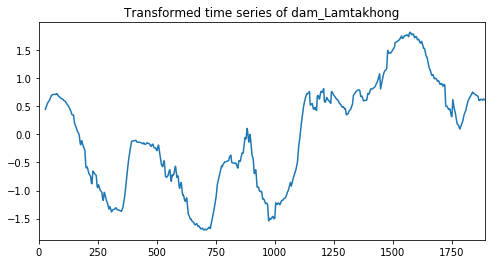

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000835      0.000199         0.000487        0.000092           0    0.0001           0.491386           0.623896           0.704698           0.512926           0.528598         0.572301        0.080217                5
1       0.001753      0.001340         0.000568        0.000035         0.5    0.0001           0.492052           0.624696           0.705046           0.512979           0.528645         0.572684        0.080288                4
2       0.000902      0.000097         0.000518        0.000004           1    0.0001           0.492509           0.625447           0.705372           0.513027           0.528690         0.573009        0.080389                3
3       0.000901      0.000102         0.000516        0.000003           2    0.0001           0.493093           0.626832           0.705967           0.513113           0.528776         0.573556        0.080627                2
4       0.001262      0.000615         0.000561        0.000075          10    0.0001           0.492833           0.634954           0.709211           0.513422           0.529329         0.575950        0.082743                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.061597      0.035273         0.003388        0.000743     0.1             2000            2           0.1       linear           0.516635           0.602995           0.713884           0.556733           0.491787         0.576407        0.078393                1
1        0.045606      0.035242         0.006437        0.003051     0.1             2000            2           0.1          rbf           0.424790           0.553258           0.586075          -2.610727           0.488808        -0.111559        1.250810               11
2        0.049780      0.038064         0.004364        0.002031     0.1             2000            2           0.1         poly          -0.059271           0.516637          -0.043380         -14.015171          -9.035813        -4.527399        5.930540               34
3        0.008844      0.009471         0.000484        0.000135     0.1             2000            2             1       linear          -1.357476           0.527436           0.416587          -0.939050           0.154672        -0.239566        0.763315               15
4        0.003251      0.002850         0.000845        0.000566     0.1             2000            2             1          rbf          -0.279727          -0.266002           0.215538          -4.665980          -0.190031        -1.037240        1.823382               25
5        0.011424      0.014082         0.001127        0.000845     0.1             2000            2             1         poly          -0.023518           0.294194           0.160527          -9.307424          -4.448234        -2.664891        3.768808               31
6        0.056495      0.038836         0.002711        0.001125     0.1             2000            3           0.1       linear           0.516635           0.602995           0.713884           0.556733           0.491787         0.576407        0.078393                1
7        0.043837      0.032075         0.006316        0.002733     0.1             2000            3           0.1          rbf           0.424790           0.553258           0.586075          -2.610727           0.488808        -0.111559        1.250810               11
8        0.064026      0.052810         0.004017        0.001880     0.1             2000            3           0.1         poly          -0.310126           0.009506           0.221290          -0.529933          -0.004090        -0.122670        0.264894               13
9        0.008351      0.008951         0.000435        0.000100     0.1             2000            3             1       linear          -1.357476           0.527436           0.416587          -0.939050           0.154672        -0.239566        0.763315               15
10       0.002987      0.002593         0.000626        0.000213     0.1             2000            3             1          rbf          -0.279727          -0.266002           0.215538          -4.665980          -0.190031        -1.037240        1.823382               25
11       0.008008      0.007279         0.000558        0.000144     0.1             2000            3             1         poly          -0.046768          -0.444232           0.166495          -1.056737          -0.290541        -0.334357        0.416986               21
12       0.158396      0.133388         0.002477        0.001033       1             2000            2           0.1       linear           0.518642           0.599761           0.711744           0.554372           0.491463         0.575197        0.077320                3
13       0.056186      0.038173         0.005608        0.002595       1             2000            2           0.1          rbf           0.407449      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001296      0.000276         0.000654        0.000019           0    0.0001           0.270496           0.452214           0.714854           0.401253           0.486749         0.465113        0.144885                5
1       0.001329      0.000205         0.000634        0.000009         0.5    0.0001           0.286700           0.477510           0.716299           0.401254           0.487418         0.473836        0.140907                4
2       0.001344      0.000173         0.000782        0.000275           1    0.0001           0.294507           0.491710           0.717426           0.401245           0.488016         0.478581        0.139408                3
3       0.001285      0.000203         0.000620        0.000003           2    0.0001           0.305770           0.510205           0.719194           0.401207           0.489051         0.485085        0.137582                2
4       0.001280      0.000195         0.000619        0.000004          10    0.0001           0.334726           0.564199           0.727141           0.400360           0.493810         0.504047        0.136319                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.087447      0.060202         0.005497        0.001825     0.1             2000            2           0.1       linear           0.416333           0.555502           0.744372           0.473598           0.450446         0.528050        0.117488                1
1        0.056435      0.043249         0.009190        0.004217     0.1             2000            2           0.1          rbf           0.383757           0.452757           0.214667          -2.483835           0.255092        -0.235513        1.127432                9
2        0.059574      0.047139         0.007339        0.003899     0.1             2000            2           0.1         poly          -1.367002          -2.237754          -0.202814         -14.474915        -144.827273       -32.621951       56.339011               28
3        0.013955      0.014327         0.000584        0.000177     0.1             2000            2             1       linear          -1.047403           0.587406           0.457575          -2.584248           0.088439        -0.499646        1.190748               13
4        0.003966      0.003325         0.000856        0.000370     0.1             2000            2             1          rbf          -0.293404          -0.073151           0.047030          -5.543612          -0.673661        -1.307359        2.132283               21
5        0.016786      0.023394         0.001679        0.001650     0.1             2000            2             1         poly          -0.050938          -0.189713          -0.458720          -8.910594         -36.418194        -9.205632       14.015807               25
6        0.077147      0.060433         0.004884        0.002144     0.1             2000            3           0.1       linear           0.416333           0.555502           0.744372           0.473598           0.450446         0.528050        0.117488                1
7        0.051581      0.038776         0.008544        0.003905     0.1             2000            3           0.1          rbf           0.383757           0.452757           0.214667          -2.483835           0.255092        -0.235513        1.127432                9
8        0.064937      0.046772         0.007046        0.003369     0.1             2000            3           0.1         poly          -0.225707         -18.129687           0.191559          -1.079121        -244.471334       -52.742858       96.111524               31
9        0.012979      0.013356         0.000545        0.000186     0.1             2000            3             1       linear          -1.047403           0.587406           0.457575          -2.584248           0.088439        -0.499646        1.190748               13
10       0.003689      0.003101         0.000789        0.000319     0.1             2000            3             1          rbf          -0.293404          -0.073151           0.047030          -5.543612          -0.673661        -1.307359        2.132283               21
11       0.005081      0.003366         0.000755        0.000220     0.1             2000            3             1         poly          -0.160257          -0.971145          -1.069755          -1.668910        -204.375710       -41.649155       81.364696               29
12       0.269095      0.237956         0.004887        0.002142       1             2000            2           0.1       linear           0.403561           0.506655           0.739515           0.473714           0.444321         0.513553        0.117970                3
13       0.066503      0.048469         0.008174        0.003784       1             2000            2           0.1          rbf           0.360506      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000984      0.000263         0.000571        0.000123           0    0.0001          -1.344869          -1.674738          -0.084825          -7.734496          -3.172320        -2.802249        2.654944                5
1       0.001088      0.000126         0.000613        0.000007         0.5    0.0001          -1.282582          -1.632159          -0.082321          -7.734472          -3.171911        -2.780689        2.665995                4
2       0.001078      0.000134         0.000619        0.000008           1    0.0001          -1.270299          -1.613589          -0.080328          -7.734445          -3.171571        -2.774046        2.669368                3
3       0.001085      0.000106         0.000617        0.000004           2    0.0001          -1.255960          -1.594833          -0.077230          -7.734386          -3.171035        -2.766689        2.673209                2
4       0.001057      0.000115         0.000607        0.000006          10    0.0001          -1.205769          -1.557938          -0.065149          -7.733716          -3.169001        -2.746314        2.684288                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.068153      0.045219         0.004811        0.001347     0.1             2000            2           0.1       linear          -1.312123          -3.448528          -0.295808          -7.953630          -4.318888        -3.465795        2.666678               19
1        0.062226      0.049980         0.008629        0.004290     0.1             2000            2           0.1          rbf          -1.333428          -1.034054          -0.666381          -6.575141          -1.984571        -2.318715        2.171643                9
2        0.060405      0.041805         0.004773        0.002123     0.1             2000            2           0.1         poly          -1.720509          -0.873960          -7.676264          -7.100444         -25.448591        -8.563953        8.876819               28
3        0.026489      0.028777         0.001019        0.000732     0.1             2000            2             1       linear          -0.964827          -0.312048          -0.013805          -6.963494          -2.828574        -2.216550        2.567258                1
4        0.010078      0.013805         0.001461        0.001385     0.1             2000            2             1          rbf          -0.422860           0.255718           0.025177          -8.170657          -3.149674        -2.292459        3.182705                7
5        0.025099      0.028593         0.001435        0.001104     0.1             2000            2             1         poly          -1.730592          -0.087342          -5.002361          -6.183961         -19.315968        -6.464045        6.789032               25
6        0.059788      0.045757         0.003565        0.001625     0.1             2000            3           0.1       linear          -1.312123          -3.448528          -0.295808          -7.953630          -4.318888        -3.465795        2.666678               19
7        0.058366      0.047515         0.007924        0.003942     0.1             2000            3           0.1          rbf          -1.333428          -1.034054          -0.666381          -6.575141          -1.984571        -2.318715        2.171643                9
8        0.063510      0.045771         0.004454        0.002438     0.1             2000            3           0.1         poly          -1.952664          -1.097001         -23.611955          -7.493615        -171.163966       -41.063840       65.550901               33
9        0.026317      0.028372         0.000991        0.000679     0.1             2000            3             1       linear          -0.964827          -0.312048          -0.013805          -6.963494          -2.828574        -2.216550        2.567258                1
10       0.009209      0.012632         0.001316        0.001226     0.1             2000            3             1          rbf          -0.422860           0.255718           0.025177          -8.170657          -3.149674        -2.292459        3.182705                7
11       0.032316      0.031483         0.001339        0.001043     0.1             2000            3             1         poly          -1.729697          -0.366255         -29.180772          -6.514775         -24.135794       -12.385459       11.938378               31
12       0.117555      0.097668         0.003548        0.001597       1             2000            2           0.1       linear          -1.295531          -3.490796          -0.344871          -7.979843          -4.374281        -3.497064        2.670128               21
13       0.064249      0.049656         0.007700        0.003999       1             2000            2           0.1          rbf          -1.346885      

>>> Final results:



period = 15, future = 10, Node: dam_Lamphraphloeng, neighbors: ['dam_Pak Mun']


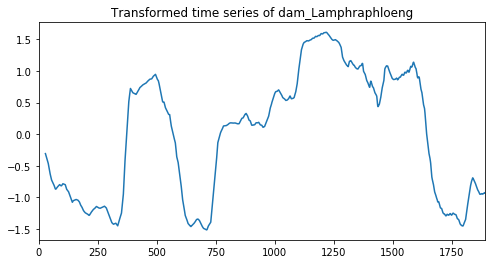

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001128      0.000560         0.000562        0.000128           0    0.0001           0.705087           0.908573           0.861368          -0.185743           0.877560         0.633369        0.415557                1
1       0.001583      0.001047         0.000616        0.000004         0.5    0.0001           0.689601           0.908884           0.860539          -0.173663           0.877601         0.632593        0.410274                2
2       0.001410      0.000781         0.000620        0.000023           1    0.0001           0.679429           0.909002           0.859735          -0.163905           0.877588         0.632370        0.406109                3
3       0.001097      0.000133         0.000612        0.000002           2    0.0001           0.664352           0.909038           0.858242          -0.148408           0.877495         0.632144        0.399572                4
4       0.001080      0.000137         0.000613        0.000007          10    0.0001           0.602710           0.907732           0.849222          -0.085925           0.876194         0.629987        0.373924                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.058773      0.034626         0.002613        0.000662     0.1             2000            2           0.1       linear           0.635391           0.891278           0.862166          -0.069580           0.879043         0.639660        0.366924                1
1        0.035126      0.027512         0.004694        0.002137     0.1             2000            2           0.1          rbf          -1.628581           0.814628          -2.452551          -0.074436           0.880819        -0.492024        1.334305               13
2        0.047846      0.034251         0.004571        0.002429     0.1             2000            2           0.1         poly          -1.125172           0.734838         -27.053864         -28.069432          -4.684599       -12.039645       12.796802               34
3        0.001840      0.000666         0.000557        0.000172     0.1             2000            2             1       linear          -1.512590           0.626032          -0.077056          -1.101900           0.181674        -0.376768        0.802895               11
4        0.002200      0.001220         0.000547        0.000080     0.1             2000            2             1          rbf          -1.512590           0.505727          -6.741094          -2.826742           0.209027        -2.073135        2.627956               25
5        0.018232      0.019977         0.001816        0.001532     0.1             2000            2             1         poly          -1.512590           0.650945         -12.909243         -18.744551          -1.043039        -6.711696        7.701585               31
6        0.052301      0.038051         0.002013        0.000754     0.1             2000            3           0.1       linear           0.635391           0.891278           0.862166          -0.069580           0.879043         0.639660        0.366924                1
7        0.034270      0.026096         0.004696        0.002122     0.1             2000            3           0.1          rbf          -1.628581           0.814628          -2.452551          -0.074436           0.880819        -0.492024        1.334305               13
8        0.088880      0.050894         0.003914        0.001890     0.1             2000            3           0.1         poly          -0.545797           0.641090          -0.736252          -2.835011           0.385964        -0.618001        1.226995               17
9        0.001313      0.000684         0.000330        0.000012     0.1             2000            3             1       linear          -1.512590           0.626032          -0.077056          -1.101900           0.181674        -0.376768        0.802895               11
10       0.001932      0.001056         0.000485        0.000095     0.1             2000            3             1          rbf          -1.512590           0.505727          -6.741094          -2.826742           0.209027        -2.073135        2.627956               25
11       0.001489      0.001073         0.000395        0.000074     0.1             2000            3             1         poly          -1.512590           0.645298          -2.242862          -3.168338           0.358568        -1.183985        1.475981               19
12       0.145162      0.127866         0.001801        0.000776       1             2000            2           0.1       linear           0.649611           0.892151           0.865120          -0.101011           0.878120         0.636798        0.379499                3
13       0.044290      0.032740         0.004233        0.001886       1             2000            2           0.1          rbf          -2.160548      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.002679      0.002904         0.000650        0.000016           0    0.0001           0.356639           0.827166           0.829782          -0.182697           0.878186         0.541815        0.409073                1
1       0.003344      0.004071         0.000646        0.000020         0.5    0.0001           0.321889           0.829370           0.828613          -0.170935           0.878345         0.537457        0.408529                2
2       0.002811      0.003016         0.000652        0.000049           1    0.0001           0.300872           0.830174           0.827477          -0.161447           0.878442         0.535103        0.407548                3
3       0.003260      0.003859         0.000635        0.000011           2    0.0001           0.270947           0.830589           0.825379          -0.146405           0.878550         0.531812        0.405883                4
4       0.004207      0.004288         0.000636        0.000015          10    0.0001           0.146837           0.823505           0.813490          -0.085887           0.878346         0.515258        0.403212                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.070513      0.047414         0.004855        0.001447     0.1             2000            2           0.1       linear           0.245891           0.838347           0.866254          -0.065464           0.881858         0.553377        0.391027                5
1        0.046262      0.036682         0.007651        0.003702     0.1             2000            2           0.1          rbf          -1.733041           0.709611          -5.533344           0.054923           0.414079        -1.217554        2.318929               13
2        0.054530      0.042156         0.007293        0.003938     0.1             2000            2           0.1         poly          -1.263042           0.358777         -24.066828         -13.152541        -113.487500       -30.322227       42.511530               29
3        0.002046      0.001118         0.000395        0.000034     0.1             2000            2             1       linear          -1.512590           0.645615          -0.070997          -0.104203           0.232304        -0.161974        0.727109                7
4        0.002916      0.001809         0.000701        0.000201     0.1             2000            2             1          rbf          -1.512590           0.426352          -8.089931          -4.241735          -0.104747        -2.704530        3.141578               17
5        0.019466      0.022089         0.002113        0.002085     0.1             2000            2             1         poly          -1.512590           0.443190         -10.881949         -12.715170        -121.108482       -29.155000       46.259639               28
6        0.063987      0.051149         0.003666        0.001513     0.1             2000            3           0.1       linear           0.245891           0.838347           0.866254          -0.065464           0.881858         0.553377        0.391027                5
7        0.044856      0.034498         0.007294        0.003136     0.1             2000            3           0.1          rbf          -1.733041           0.709611          -5.533344           0.054923           0.414079        -1.217554        2.318929               13
8        0.072100      0.055411         0.006789        0.003497     0.1             2000            3           0.1         poly          -0.635731          -0.187232          -1.688492          -2.508989        -262.746168       -53.553322      104.599562               34
9        0.001870      0.001030         0.000371        0.000031     0.1             2000            3             1       linear          -1.512590           0.645615          -0.070997          -0.104203           0.232304        -0.161974        0.727109                7
10       0.002657      0.001621         0.000629        0.000176     0.1             2000            3             1          rbf          -1.512590           0.426352          -8.089931          -4.241735          -0.104747        -2.704530        3.141578               17
11       0.002281      0.001445         0.000456        0.000117     0.1             2000            3             1         poly          -1.512590           0.541485          -3.161871         -10.254096          -7.032658        -4.283946        3.883873               26
12       0.233116      0.216461         0.003456        0.001447       1             2000            2           0.1       linear           0.294185           0.831030           0.867547          -0.089112           0.881167         0.556963        0.390678                3
13       0.055832      0.039746         0.006355        0.002969       1             2000            2           0.1          rbf          -2.034490      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004206      0.002686         0.000613        0.000154           0    0.0001          -1.916314          -0.402447          -5.188690         -17.760628          -4.997564        -6.053129        6.131402                5
1       0.003425      0.001480         0.000629        0.000011         0.5    0.0001          -1.928227          -0.366420          -5.190552         -17.760914          -4.997434        -6.048710        6.136516                4
2       0.003373      0.001401         0.000627        0.000011           1    0.0001          -1.935462          -0.342906          -5.192312         -17.761221          -4.997376        -6.045855        6.139977                3
3       0.003344      0.001404         0.000619        0.000008           2    0.0001          -1.946021          -0.311686          -5.195417         -17.761862          -4.997420        -6.042481        6.144535                2
4       0.003316      0.001383         0.000617        0.000012          10    0.0001          -1.983066          -0.211636          -5.208773         -17.766072          -5.000428        -6.033995        6.159558                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.064232      0.037305         0.004646        0.001475     0.1             2000            2           0.1       linear          -1.909191          -0.254155          -6.194431         -24.221421          -4.629662        -7.441772        8.640506               19
1        0.062353      0.048610         0.008725        0.004406     0.1             2000            2           0.1          rbf          -2.182383          -0.976689          -7.810775         -19.312123          -3.021084        -6.660611        6.737823               13
2        0.053675      0.040054         0.004901        0.002409     0.1             2000            2           0.1         poly          -1.901678          -0.479743         -71.627810         -11.350338          -9.636670       -18.999248       26.650434               28
3        0.034256      0.025256         0.001615        0.000881     0.1             2000            2             1       linear          -1.512590           0.170855          -4.754584         -14.682619          -4.821693        -5.120126        5.151170                5
4        0.020555      0.016980         0.002898        0.001650     0.1             2000            2             1          rbf          -1.512590           0.043857         -10.647140         -18.141605          -1.572084        -6.365912        6.994519               11
5        0.029130      0.022651         0.001957        0.001214     0.1             2000            2             1         poly          -1.512590           0.130222         -18.956441         -21.281808          -9.802585       -10.284641        8.738289               25
6        0.055726      0.036763         0.003552        0.001642     0.1             2000            3           0.1       linear          -1.909191          -0.254155          -6.194431         -24.221421          -4.629662        -7.441772        8.640506               19
7        0.055819      0.044902         0.007892        0.004161     0.1             2000            3           0.1          rbf          -2.182383          -0.976689          -7.810775         -19.312123          -3.021084        -6.660611        6.737823               13
8        0.067584      0.051809         0.004283        0.002202     0.1             2000            3           0.1         poly          -1.934985          -2.246735        -126.188904         -13.282842        -113.763933       -51.483480       56.210950               31
9        0.033997      0.025365         0.001511        0.000813     0.1             2000            3             1       linear          -1.512590           0.170855          -4.754584         -14.682619          -4.821693        -5.120126        5.151170                5
10       0.019366      0.015787         0.002753        0.001540     0.1             2000            3             1          rbf          -1.512590           0.043857         -10.647140         -18.141605          -1.572084        -6.365912        6.994519               11
11       0.041091      0.029668         0.001760        0.001079     0.1             2000            3             1         poly          -1.512590           0.083790         -13.638124         -18.649400        -442.741937       -95.291652      173.870079               33
12       0.110958      0.090654         0.003419        0.001718       1             2000            2           0.1       linear          -1.902503          -0.303996          -6.192482         -25.073094          -4.611333        -7.616682        8.965646               21
13       0.063341      0.050944         0.007597        0.004181       1             2000            2           0.1          rbf          -2.189900      

>>> Final results:



period = 15, future = 10, Node: dam_Plei Krong, neighbors: ['dam_Se San IV']


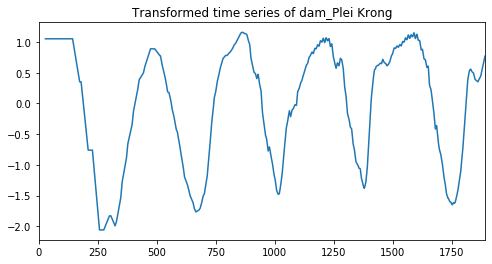

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000934      0.000279         0.000551        0.000124           0    0.0001           0.885631           0.886877           0.860780           0.822972           0.854859         0.862224        0.023464                4
1       0.001061      0.000115         0.000612        0.000010         0.5    0.0001           0.885265           0.887791           0.860970           0.822691           0.854951         0.862334        0.023672                2
2       0.001059      0.000112         0.000605        0.000005           1    0.0001           0.884814           0.888471           0.861118           0.822410           0.855021         0.862367        0.023822                1
3       0.001053      0.000125         0.000601        0.000005           2    0.0001           0.883874           0.889405           0.861347           0.821865           0.855115         0.862321        0.024032                3
4       0.001240      0.000193         0.000617        0.000012          10    0.0001           0.877527           0.890630           0.862110           0.818331           0.855178         0.860755        0.024521                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.062100      0.036649         0.002818        0.000758     0.1             2000            2           0.1       linear           0.894804           0.889309           0.862026           0.820616           0.851809         0.863713        0.026921                5
1        0.040946      0.031732         0.005886        0.002675     0.1             2000            2           0.1          rbf           0.833752           0.866352           0.861129           0.802553           0.859053         0.844568        0.023836               11
2        0.047963      0.037164         0.004949        0.002380     0.1             2000            2           0.1         poly          -0.378443           0.324081           0.077132          -0.045071           0.300957         0.055731        0.257400               34
3        0.006177      0.004711         0.000480        0.000126     0.1             2000            2             1       linear           0.333036           0.524007           0.391754           0.482097           0.752514         0.496682        0.144360               17
4        0.003082      0.001601         0.000721        0.000065     0.1             2000            2             1          rbf           0.414553           0.375506           0.380168           0.374602           0.654078         0.439781        0.108160               26
5        0.019030      0.012885         0.002027        0.000536     0.1             2000            2             1         poly           0.078349           0.361604           0.105691           0.010365           0.267906         0.164783        0.129754               33
6        0.055100      0.040147         0.002258        0.001187     0.1             2000            3           0.1       linear           0.894804           0.889309           0.862026           0.820616           0.851809         0.863713        0.026921                5
7        0.041226      0.031996         0.005798        0.002578     0.1             2000            3           0.1          rbf           0.833752           0.866352           0.861129           0.802553           0.859053         0.844568        0.023836               11
8        0.051836      0.037311         0.004411        0.001926     0.1             2000            3           0.1         poly           0.021323           0.794310           0.519615           0.439172           0.573514         0.469587        0.253225               21
9        0.005825      0.004437         0.000383        0.000047     0.1             2000            3             1       linear           0.333036           0.524007           0.391754           0.482097           0.752514         0.496682        0.144360               17
10       0.003019      0.001574         0.000653        0.000070     0.1             2000            3             1          rbf           0.414553           0.375506           0.380168           0.374602           0.654078         0.439781        0.108160               26
11       0.007290      0.007923         0.000619        0.000124     0.1             2000            3             1         poly           0.395116           0.465891           0.271601           0.187650           0.527409         0.369533        0.124528               30
12       0.170655      0.132942         0.002110        0.001136       1             2000            2           0.1       linear           0.896000           0.883770           0.860192           0.821442           0.851115         0.862504        0.026059                7
13       0.047945      0.037993         0.005069        0.002467       1             2000            2           0.1          rbf           0.858466      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001291      0.000270         0.000649        0.000032           0    0.0001           0.777258           0.886048           0.868256           0.823972           0.854180         0.841943        0.038196                3
1       0.001326      0.000210         0.000645        0.000016         0.5    0.0001           0.776899           0.886961           0.868507           0.823649           0.854264         0.842056        0.038599                1
2       0.001338      0.000206         0.000634        0.000004           1    0.0001           0.775849           0.887625           0.868706           0.823331           0.854324         0.841967        0.039169                2
3       0.001278      0.000197         0.000622        0.000004           2    0.0001           0.773341           0.888511           0.869021           0.822720           0.854401         0.841599        0.040329                4
4       0.001277      0.000193         0.000631        0.000016          10    0.0001           0.757742           0.889296           0.870306           0.818876           0.854319         0.838108        0.046365                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.124630      0.076516         0.004854        0.002131     0.1             2000            2           0.1       linear           0.870368           0.876455           0.864941           0.820906           0.851297         0.856793        0.019776                1
1        0.058145      0.047164         0.009474        0.004585     0.1             2000            2           0.1          rbf           0.719553           0.484571           0.862895           0.774355           0.824790         0.733233        0.133346                9
2        0.062782      0.049514         0.008360        0.003940     0.1             2000            2           0.1         poly           0.093188          -0.715553          -0.829238          -0.002480           0.198937        -0.251029        0.431935               36
3        0.006052      0.005178         0.000447        0.000085     0.1             2000            2             1       linear           0.426421           0.770853           0.647320           0.494472           0.765115         0.620836        0.139848               13
4        0.006013      0.003422         0.001160        0.000179     0.1             2000            2             1          rbf           0.347934           0.045569           0.424072           0.377694           0.653999         0.369854        0.194618               29
5        0.018872      0.017123         0.002285        0.001452     0.1             2000            2             1         poly           0.402251          -0.470517          -0.017516           0.001032           0.280943         0.039239        0.301573               33
6        0.111419      0.076980         0.004176        0.002193     0.1             2000            3           0.1       linear           0.870368           0.876455           0.864941           0.820906           0.851297         0.856793        0.019776                1
7        0.052425      0.041943         0.008649        0.004179     0.1             2000            3           0.1          rbf           0.719553           0.484571           0.862895           0.774355           0.824790         0.733233        0.133346                9
8        0.065554      0.047189         0.007505        0.003338     0.1             2000            3           0.1         poly           0.438811           0.801143           0.598205           0.485071           0.565040         0.577654        0.125202               20
9        0.005974      0.005108         0.000411        0.000047     0.1             2000            3             1       linear           0.426421           0.770853           0.647320           0.494472           0.765115         0.620836        0.139848               13
10       0.005721      0.003179         0.001101        0.000156     0.1             2000            3             1          rbf           0.347934           0.045569           0.424072           0.377694           0.653999         0.369854        0.194618               29
11       0.004738      0.003635         0.000636        0.000191     0.1             2000            3             1         poly           0.341849           0.630114           0.381463           0.116340           0.504936         0.394940        0.172060               24
12       0.586780      0.473503         0.004210        0.002359       1             2000            2           0.1       linear           0.875007           0.872164           0.862260           0.821659           0.850918         0.856402        0.019319                3
13       0.066734      0.049991         0.008108        0.004265       1             2000            2           0.1          rbf           0.535098      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000898      0.000062         0.000555        0.000049           0    0.0001          -0.092971           0.262522           0.173518           0.255115           0.220034         0.163643        0.132116                5
1       0.000836      0.000075         0.000506        0.000016         0.5    0.0001          -0.092555           0.262363           0.173594           0.255078           0.220015         0.163699        0.131924                4
2       0.000849      0.000083         0.000508        0.000007           1    0.0001          -0.092171           0.262207           0.173667           0.255042           0.219996         0.163748        0.131746                3
3       0.000848      0.000083         0.000517        0.000005           2    0.0001          -0.091477           0.261902           0.173805           0.254970           0.219958         0.163831        0.131420                2
4       0.004376      0.007091         0.000526        0.000030          10    0.0001          -0.087494           0.259713           0.174675           0.254409           0.219659         0.164192        0.129457                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.070425      0.043149         0.004742        0.001201     0.1             2000            2           0.1       linear          -0.511790           0.268625          -0.106307           0.264982           0.099717         0.003045        0.291720                8
1        0.059462      0.045506         0.009032        0.003805     0.1             2000            2           0.1          rbf          -1.749548          -0.465529          -0.119541           0.344029           0.096874        -0.378743        0.735178               24
2        0.054613      0.038903         0.005346        0.002306     0.1             2000            2           0.1         poly          -0.261182          -0.094544           0.000308           0.103203          -0.218345        -0.094112        0.135051               17
3        0.045071      0.027543         0.002046        0.000448     0.1             2000            2             1       linear          -0.155906           0.231415           0.160069           0.031500           0.180891         0.089594        0.139327                1
4        0.025169      0.016472         0.003978        0.001250     0.1             2000            2             1          rbf          -1.571399          -0.256662           0.160792           0.017367           0.110061        -0.307968        0.647953               21
5        0.032001      0.023326         0.002571        0.000777     0.1             2000            2             1         poly          -0.129265          -0.180770          -0.030920          -0.098715           0.040877        -0.079758        0.077397               16
6        0.061889      0.041152         0.003687        0.001408     0.1             2000            3           0.1       linear          -0.511790           0.268625          -0.106307           0.264982           0.099717         0.003045        0.291720                8
7        0.056319      0.043463         0.008188        0.003574     0.1             2000            3           0.1          rbf          -1.749548          -0.465529          -0.119541           0.344029           0.096874        -0.378743        0.735178               24
8        0.058072      0.036168         0.004530        0.001934     0.1             2000            3           0.1         poly          -0.503508           0.073876           0.012573           0.080355          -0.185153        -0.104371        0.221543               19
9        0.041717      0.025824         0.001815        0.000423     0.1             2000            3             1       linear          -0.155906           0.231415           0.160069           0.031500           0.180891         0.089594        0.139327                1
10       0.025585      0.017527         0.003949        0.001418     0.1             2000            3             1          rbf          -1.571399          -0.256662           0.160792           0.017367           0.110061        -0.307968        0.647953               21
11       0.052982      0.029978         0.002585        0.000726     0.1             2000            3             1         poly          -0.073558           0.066948           0.065854          -0.077277           0.092856         0.014965        0.074436                7
12       0.186133      0.128229         0.003911        0.001474       1             2000            2           0.1       linear          -0.759608           0.264832          -0.110852           0.268937           0.099737        -0.047391        0.382223               10
13       0.068712      0.050335         0.008139        0.003738       1             2000            2           0.1          rbf          -5.308451      

>>> Final results:



period = 15, future = 10, Node: dam_Lamnangrong, neighbors: ['dam_Pak Mun']


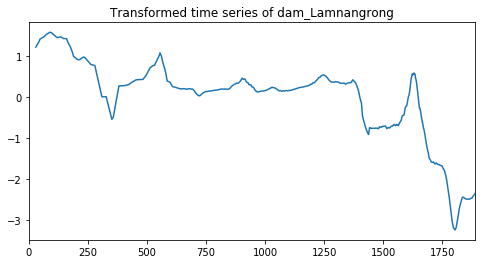

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000955      0.000247         0.000564        0.000091           0    0.0001           0.173912           0.243852           0.792586           0.737442           0.860868         0.561732        0.291583                5
1       0.002608      0.003058         0.000601        0.000018         0.5    0.0001           0.170930           0.259062           0.795574           0.740270           0.860865         0.565340        0.289934                4
2       0.002882      0.003615         0.000607        0.000010           1    0.0001           0.167060           0.269113           0.797698           0.742304           0.860741         0.567383        0.289456                3
3       0.003244      0.003647         0.000652        0.000075           2    0.0001           0.160372           0.281664           0.800541           0.745159           0.860354         0.569618        0.289505                1
4       0.002422      0.002691         0.000605        0.000006          10    0.0001           0.129049           0.300274           0.805199           0.752486           0.856552         0.568712        0.295944                2

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.044626      0.020937         0.002063        0.000493     0.1             2000            2           0.1       linear           0.351245           0.298668           0.791638           0.746842           0.870322         0.611743        0.238056                1
1        0.023736      0.017386         0.003411        0.001248     0.1             2000            2           0.1          rbf          -0.165859          -0.024838           0.786658          -0.809726          -1.913264        -0.425406        0.900926               13
2        0.058652      0.031932         0.002848        0.001063     0.1             2000            2           0.1         poly           0.232837          -0.431771           0.492461          -2.252206         -16.772847        -3.746305        6.583464               27
3        0.000790      0.000556         0.000337        0.000013     0.1             2000            2             1       linear           0.224810          -1.199638          -0.331847          -0.769703           0.685306        -0.278215        0.674517               11
4        0.001336      0.000545         0.000457        0.000047     0.1             2000            2             1          rbf           0.114878          -1.058104          -0.260813          -1.345237          -2.473050        -1.004465        0.903515               21
5        0.002055      0.003003         0.000452        0.000120     0.1             2000            2             1         poly           0.077547          -0.125042           0.146532          -1.312484         -25.171176        -5.276925        9.961166               31
6        0.040160      0.023884         0.001501        0.000406     0.1             2000            3           0.1       linear           0.351245           0.298668           0.791638           0.746842           0.870322         0.611743        0.238056                1
7        0.023919      0.017774         0.003365        0.001261     0.1             2000            3           0.1          rbf          -0.165859          -0.024838           0.786658          -0.809726          -1.913264        -0.425406        0.900926               13
8        0.125142      0.073483         0.003268        0.001179     0.1             2000            3           0.1         poly          -0.068292          -1.236865           0.178690          -0.529248         -12.588676        -2.848878        4.893685               25
9        0.000737      0.000554         0.000315        0.000012     0.1             2000            3             1       linear           0.224810          -1.199638          -0.331847          -0.769703           0.685306        -0.278215        0.674517               11
10       0.001259      0.000521         0.000434        0.000049     0.1             2000            3             1          rbf           0.114878          -1.058104          -0.260813          -1.345237          -2.473050        -1.004465        0.903515               21
11       0.000971      0.001028         0.000320        0.000016     0.1             2000            3             1         poly           0.039219          -0.725885          -0.154910          -1.110683         -40.289347        -8.448321       15.925746               34
12       0.106309      0.096423         0.001353        0.000441       1             2000            2           0.1       linear           0.354768           0.268723           0.781733           0.735963           0.871856         0.602609        0.243009                3
13       0.035393      0.027439         0.003012        0.001190       1             2000            2           0.1          rbf          -0.602711      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001630      0.000642         0.000691        0.000063           0    0.0001           0.151610          -2.275855           0.181453           0.733793           0.867728        -0.068254        1.140486                5
1       0.001346      0.000178         0.001300        0.001311         0.5    0.0001           0.209585          -2.217032           0.202536           0.737491           0.867874        -0.039909        1.121545                4
2       0.001332      0.000164         0.000630        0.000006           1    0.0001           0.223775          -2.174617           0.215113           0.740126           0.867837        -0.025553        1.106614                3
3       0.001285      0.000198         0.000625        0.000012           2    0.0001           0.239561          -2.097714           0.228807           0.743757           0.867555        -0.003607        1.078509                2
4       0.001272      0.000206         0.000623        0.000011          10    0.0001           0.290602          -1.777641           0.232723           0.752509           0.864045         0.072448        0.957624                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.064576      0.034469         0.003043        0.000587     0.1             2000            2           0.1       linear           0.324685          -1.111072           0.160556           0.744195           0.879257         0.199524        0.706194                1
1        0.028910      0.022323         0.004884        0.001895     0.1             2000            2           0.1          rbf           0.370751           0.191536          -0.381495          -0.676913          -1.929179        -0.485060        0.815256                7
2        0.039930      0.032067         0.004343        0.002005     0.1             2000            2           0.1         poly           0.458440          -1.410203         -13.330191          -2.097934         -20.847463        -7.445470        8.267233               27
3        0.001317      0.001478         0.000359        0.000039     0.1             2000            2             1       linear           0.235845          -2.459578          -3.354400          -1.166567           0.642350        -1.220470        1.528588               15
4        0.001203      0.000479         0.000451        0.000038     0.1             2000            2             1          rbf           0.208052          -2.367981          -1.415380          -1.547734          -2.483944        -1.521397        0.963964               21
5        0.000949      0.000684         0.000375        0.000043     0.1             2000            2             1         poly           0.121591          -1.373275           0.081910          -1.641176         -12.762344        -3.114659        4.877966               25
6        0.059082      0.040344         0.002644        0.001033     0.1             2000            3           0.1       linear           0.324685          -1.111072           0.160556           0.744195           0.879257         0.199524        0.706194                1
7        0.028136      0.021659         0.004751        0.001891     0.1             2000            3           0.1          rbf           0.370751           0.191536          -0.381495          -0.676913          -1.929179        -0.485060        0.815256                7
8        0.052563      0.043062         0.005138        0.002280     0.1             2000            3           0.1         poly           0.446878          -3.805168        -106.021022          -0.492253        -463.038067      -114.581926      178.893566               33
9        0.001362      0.001577         0.000383        0.000048     0.1             2000            3             1       linear           0.235845          -2.459578          -3.354400          -1.166567           0.642350        -1.220470        1.528588               15
10       0.001197      0.000471         0.000453        0.000033     0.1             2000            3             1          rbf           0.208052          -2.367981          -1.415380          -1.547734          -2.483944        -1.521397        0.963964               21
11       0.000889      0.000649         0.000406        0.000040     0.1             2000            3             1         poly           0.065970          -0.926520          -1.574084          -1.187688         -19.931942        -4.710853        7.629846               26
12       0.189285      0.149451         0.002520        0.000872       1             2000            2           0.1       linear           0.339129          -1.264284           0.097560           0.733692           0.879316         0.157083        0.763029                3
13       0.040461      0.030156         0.003956        0.001503       1             2000            2           0.1          rbf           0.347192      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000987      0.000254         0.000562        0.000127           0    0.0001          -1.453400         -63.531791         -32.579835          -1.889857          -2.877692       -20.466515       24.565455                5
1       0.001082      0.000138         0.000619        0.000004         0.5    0.0001          -1.434392         -63.268149         -32.523005          -1.889863          -2.877671       -20.398616       24.470378                4
2       0.001077      0.000133         0.000619        0.000010           1    0.0001          -1.428622         -63.058168         -32.474585          -1.889869          -2.877651       -20.345779       24.392913                3
3       0.001455      0.000757         0.000648        0.000062           2    0.0001          -1.422355         -62.683798         -32.394743          -1.889881          -2.877615       -20.253678       24.254879                2
4       0.001204      0.000261         0.000612        0.000005          10    0.0001          -1.401430         -60.767219         -32.046828          -1.889983          -2.877409       -19.796574       23.553972                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.069483      0.046166         0.004039        0.001050     0.1             2000            2           0.1       linear          -2.003640         -81.661759          -5.252858          -1.246919          -2.719586       -18.576953       31.571142               22
1        0.052055      0.038936         0.007107        0.003307     0.1             2000            2           0.1          rbf          -1.800216         -35.462969          -0.589763          -2.425937          -2.780789        -8.611935       13.446201               16
2        0.052453      0.031558         0.003956        0.001589     0.1             2000            2           0.1         poly          -2.426995         -36.413695         -72.807902          -1.457355          -2.190052       -23.059200       28.217458               28
3        0.018888      0.022497         0.000693        0.000412     0.1             2000            2             1       linear           0.221687          -8.265298         -21.896054          -2.228476          -4.038782        -7.241385        7.834425               10
4        0.003192      0.005211         0.000626        0.000523     0.1             2000            2             1          rbf           0.237512          -5.224749          -2.224454          -2.380850          -2.901213        -2.498751        1.741799                3
5        0.008260      0.009776         0.000674        0.000545     0.1             2000            2             1         poly           0.230339          -6.755474         -11.540970          -2.555375          -4.037205        -4.931737        4.002556                7
6        0.062689      0.050571         0.003061        0.001278     0.1             2000            3           0.1       linear          -2.003640         -81.661759          -5.252858          -1.246919          -2.719586       -18.576953       31.571142               22
7        0.051647      0.038982         0.007046        0.003325     0.1             2000            3           0.1          rbf          -1.800216         -35.462969          -0.589763          -2.425937          -2.780789        -8.611935       13.446201               16
8        0.064586      0.038283         0.003566        0.001475     0.1             2000            3           0.1         poly          -3.173843         -82.565316        -233.311002          -1.278129          -2.548298       -64.575318       89.910397               34
9        0.017006      0.020535         0.000548        0.000384     0.1             2000            3             1       linear           0.221687          -8.265298         -21.896054          -2.228476          -4.038782        -7.241385        7.834425               10
10       0.002918      0.004771         0.000582        0.000482     0.1             2000            3             1          rbf           0.237512          -5.224749          -2.224454          -2.380850          -2.901213        -2.498751        1.741799                3
11       0.007342      0.008534         0.000620        0.000485     0.1             2000            3             1         poly           0.209838          -7.968341        -153.537052          -2.064791         -22.394084       -37.150886       58.723048               31
12       0.185993      0.177931         0.002818        0.001157       1             2000            2           0.1       linear          -2.005257         -82.366474          -5.168829          -1.248688          -2.718142       -18.701478       31.859677               24
13       0.058411      0.044705         0.006402        0.003409       1             2000            2           0.1          rbf          -1.539410      

>>> Final results:



period = 15, future = 10, Node: dam_Se San IV, neighbors: ['dam_Plei Krong', 'dam_Lower Sesan II']


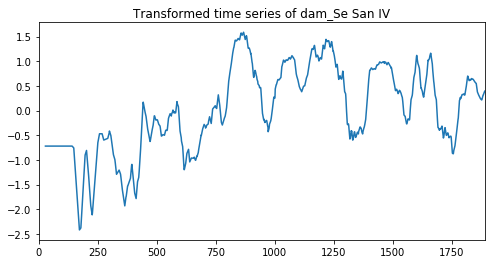

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000939      0.000278         0.000567        0.000104           0    0.0001          -0.167894          -0.534171          -0.108411           0.316447           0.195305        -0.059745        0.298569                5
1       0.002178      0.002193         0.000609        0.000005         0.5    0.0001          -0.167079          -0.534854          -0.107637           0.316534           0.195404        -0.059526        0.298741                4
2       0.003385      0.003462         0.000614        0.000016           1    0.0001          -0.166396          -0.535535          -0.106907           0.316617           0.195501        -0.059344        0.298922                3
3       0.002332      0.002492         0.000608        0.000004           2    0.0001          -0.165297          -0.536887          -0.105568           0.316775           0.195690        -0.059057        0.299305                2
4       0.002860      0.003561         0.000606        0.000008          10    0.0001          -0.160103          -0.547146          -0.098812           0.317666           0.196948        -0.058289        0.302482                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.069648      0.041500         0.003997        0.000904     0.1             2000            2           0.1       linear          -0.023026          -0.215134           0.070179           0.316212           0.142254         0.058097        0.176118                1
1        0.053042      0.043359         0.007557        0.003921     0.1             2000            2           0.1          rbf          -0.219129          -1.992734          -0.020410           0.261867           0.104282        -0.373225        0.824911               13
2        0.055162      0.035939         0.004632        0.002436     0.1             2000            2           0.1         poly          -0.218469          -1.785865          -5.782613          -0.443078          -0.205727        -1.687150        2.129879               34
3        0.034574      0.023384         0.001079        0.000336     0.1             2000            2             1       linear          -0.689036          -0.547487          -0.300581           0.222624           0.171197        -0.228657        0.369408               11
4        0.013523      0.009005         0.002167        0.000766     0.1             2000            2             1          rbf          -0.688697          -1.955907          -0.269178           0.122398           0.054132        -0.547450        0.760491               17
5        0.020954      0.014590         0.001720        0.000885     0.1             2000            2             1         poly          -0.615483          -1.950234          -3.724020          -0.067549          -0.203191        -1.312095        1.377566               31
6        0.063104      0.046716         0.003322        0.001574     0.1             2000            3           0.1       linear          -0.023026          -0.215134           0.070179           0.316212           0.142254         0.058097        0.176118                1
7        0.049132      0.039872         0.007108        0.003587     0.1             2000            3           0.1          rbf          -0.219129          -1.992734          -0.020410           0.261867           0.104282        -0.373225        0.824911               13
8        0.067222      0.046982         0.004222        0.002267     0.1             2000            3           0.1         poly          -0.064711          -1.086496          -3.989977           0.044771           0.104987        -0.998285        1.557866               27
9        0.030459      0.019465         0.000947        0.000289     0.1             2000            3             1       linear          -0.689036          -0.547487          -0.300581           0.222624           0.171197        -0.228657        0.369408               11
10       0.012196      0.008280         0.001974        0.000709     0.1             2000            3             1          rbf          -0.688697          -1.955907          -0.269178           0.122398           0.054132        -0.547450        0.760491               17
11       0.035775      0.022827         0.001479        0.000723     0.1             2000            3             1         poly          -0.712999          -1.683036          -1.987408           0.018786           0.012353        -0.870461        0.836990               25
12       0.223400      0.182031         0.003126        0.001451       1             2000            2           0.1       linear          -0.042381          -0.170555           0.047349           0.308960           0.138084         0.056292        0.162362                3
13       0.062855      0.048797         0.007036        0.003930       1             2000            2           0.1          rbf          -0.700622      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.009830      0.007279         0.000749        0.000065           0    0.0001          -0.743176          -1.335395          -2.710229           0.202242           0.224304        -0.872451        1.092364                5
1       0.005253      0.004638         0.000679        0.000042         0.5    0.0001          -0.583181          -0.731719          -1.309862           0.208435           0.226496        -0.437966        0.587695                4
2       0.003584      0.003676         0.000661        0.000031           1    0.0001          -0.592005          -0.633301          -0.870923           0.211679           0.227628        -0.331384        0.459911                3
3       0.002649      0.002215         0.000653        0.000024           2    0.0001          -0.590577          -0.569340          -0.499745           0.215697           0.229052        -0.242983        0.381172                2
4       0.001647      0.000354         0.000646        0.000009          10    0.0001          -0.480532          -0.480171          -0.055223           0.226723           0.233429        -0.111155        0.318949                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.119017      0.077464         0.010343        0.003912     0.1             2000            2           0.1       linear          -0.470178          -0.402071          -1.591598           0.252975           0.139894        -0.414196        0.654475                5
1        0.085652      0.069493         0.015996        0.008175     0.1             2000            2           0.1          rbf          -0.359432          -1.994470          -3.220419          -0.008695           0.184267        -1.079750        1.317796               16
2        0.070522      0.056087         0.010964        0.005624     0.1             2000            2           0.1         poly          -0.497749          -0.820591          -6.973760          -1.072683          -0.047060        -1.882369        2.568687               22
3        0.042111      0.026255         0.002398        0.001077     0.1             2000            2             1       linear          -1.148778          -0.419652          -0.249355           0.160241           0.270274        -0.277454        0.504341                1
4        0.021550      0.015425         0.004277        0.001742     0.1             2000            2             1          rbf          -1.092147          -1.456232          -2.877983           0.212975           0.193159        -1.004046        1.152242               11
5        0.020835      0.018598         0.003145        0.001915     0.1             2000            2             1         poly          -1.184079          -0.725396          -7.244362          -0.567963          -0.018395        -1.948039        2.674235               23
6        0.103829      0.078534         0.009006        0.004654     0.1             2000            3           0.1       linear          -0.470178          -0.402071          -1.591598           0.252975           0.139894        -0.414196        0.654475                5
7        0.079999      0.065651         0.014845        0.007803     0.1             2000            3           0.1          rbf          -0.359432          -1.994470          -3.220419          -0.008695           0.184267        -1.079750        1.317796               16
8        0.067705      0.053731         0.009563        0.004988     0.1             2000            3           0.1         poly          -0.287694          -2.786524          -1.839283          -0.151944          -0.329425        -1.078974        1.052723               15
9        0.038641      0.023883         0.002180        0.000994     0.1             2000            3             1       linear          -1.148778          -0.419652          -0.249355           0.160241           0.270274        -0.277454        0.504341                1
10       0.019753      0.014407         0.003910        0.001618     0.1             2000            3             1          rbf          -1.092147          -1.456232          -2.877983           0.212975           0.193159        -1.004046        1.152242               11
11       0.017401      0.012909         0.002270        0.001030     0.1             2000            3             1         poly          -1.108495          -1.458446          -1.532583          -0.012034           0.131292        -0.796053        0.714635                9
12       0.497857      0.365841         0.009114        0.004670       1             2000            2           0.1       linear          -0.439655          -0.553392          -1.276666           0.230556           0.131752        -0.381481        0.542640                3
13       0.085679      0.065726         0.013708        0.006917       1             2000            2           0.1          rbf          -1.551718      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001306      0.000251         0.000646        0.000017           0    0.0001          -0.591518          -2.354995        -115.543239          -1.215931           0.223573       -23.896422       45.831145                5
1       0.001345      0.000233         0.000643        0.000019         0.5    0.0001           0.009722          -1.463822         -99.691825          -1.205769           0.225791       -20.425181       39.638788                4
2       0.001310      0.000181         0.000635        0.000003           1    0.0001          -0.028243          -1.323283         -92.367558          -1.200615           0.226921       -18.938556       36.719657                3
3       0.001289      0.000197         0.000628        0.000009           2    0.0001          -0.074662          -1.265713         -83.543359          -1.194737           0.228280       -17.170038       33.191953                2
4       0.001281      0.000206         0.000619        0.000006          10    0.0001          -0.153003          -1.321915         -53.406197          -1.185942           0.229747       -11.167462       21.127664                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.081771      0.049892         0.007620        0.003063     0.1             2000            2           0.1       linear          -0.144697          -1.278401         -69.645095          -1.700526          -0.009699       -14.555684       27.552302               26
1        0.079503      0.063753         0.013270        0.007293     0.1             2000            2           0.1          rbf           0.005388          -1.462677          -4.807249          -0.444415           0.112843        -1.319222        1.830716                3
2        0.061644      0.047509         0.008140        0.004185     0.1             2000            2           0.1         poly          -0.175483          -1.420215          -6.041479          -0.650268          -0.414914        -1.740472        2.190711               11
3        0.041097      0.030986         0.002431        0.001009     0.1             2000            2             1       linear          -1.035240          -1.680104         -18.994428          -1.181040           0.346785        -4.508805        7.273943               20
4        0.023481      0.018301         0.004173        0.002017     0.1             2000            2             1          rbf          -1.148502          -2.327586          -4.752517          -0.095716           0.138478        -1.637169        1.786050                9
5        0.021258      0.016862         0.003001        0.001544     0.1             2000            2             1         poly          -1.172559          -2.164167          -8.119369          -0.203328          -0.134384        -2.358762        2.973997               12
6        0.071491      0.049717         0.006900        0.003265     0.1             2000            3           0.1       linear          -0.144697          -1.278401         -69.645095          -1.700526          -0.009699       -14.555684       27.552302               26
7        0.076409      0.060217         0.012344        0.006134     0.1             2000            3           0.1          rbf           0.005388          -1.462677          -4.807249          -0.444415           0.112843        -1.319222        1.830716                3
8        0.062754      0.048623         0.008227        0.003997     0.1             2000            3           0.1         poly          -0.046076          -1.551399          -1.345742          -2.907479          -0.808080        -1.331755        0.944304                7
9        0.038113      0.028894         0.002153        0.000932     0.1             2000            3             1       linear          -1.035240          -1.680104         -18.994428          -1.181040           0.346785        -4.508805        7.273943               20
10       0.021577      0.016669         0.003779        0.001855     0.1             2000            3             1          rbf          -1.148502          -2.327586          -4.752517          -0.095716           0.138478        -1.637169        1.786050                9
11       0.019014      0.014812         0.002610        0.001292     0.1             2000            3             1         poly          -0.940319          -2.500923          -1.852860          -1.864088           0.311574        -1.369323        0.976583                8
12       0.171458      0.100765         0.006895        0.003803       1             2000            2           0.1       linear          -0.213881          -1.283638         -98.620345          -1.743037           0.007065       -20.370767       39.130201               29
13       0.075821      0.060462         0.011506        0.005781       1             2000            2           0.1          rbf           0.029610      

>>> Final results:



period = 15, future = 10, Node: dam_Lower Sesan II, neighbors: ['dam_Se San IV', 'rw_34', 'dam_Ea Soup Thuong', 'dam_Buon Kuop']


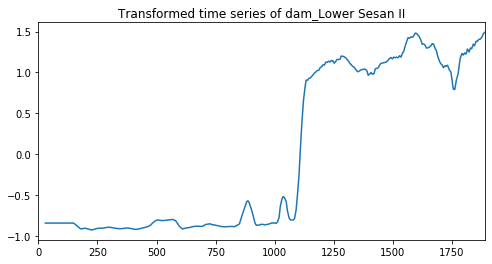

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000939      0.000279         0.000550        0.000123           0    0.0001           0.757633           0.564236           0.788161           0.356342           0.212497         0.535774        0.223801                1
1       0.001065      0.000112         0.000608        0.000003         0.5    0.0001           0.655642           0.483153           0.742315           0.388739           0.230236         0.500017        0.183508                2
2       0.001056      0.000122         0.000607        0.000004           1    0.0001           0.627239           0.446890           0.716906           0.402670           0.239389         0.486619        0.168852                3
3       0.001060      0.000118         0.000606        0.000005           2    0.0001           0.582770           0.410636           0.680262           0.420279           0.251619         0.469113        0.148734                4
4       0.001482      0.000844         0.000619        0.000018          10    0.0001           0.325645           0.313813           0.496513           0.486000           0.296099         0.383614        0.088454                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.017819      0.021119         0.001263        0.000595     0.1             2000            2           0.1       linear          -0.143123          -0.070006           0.266980           0.479474           0.318691         0.170403        0.237881                5
1        0.012115      0.013305         0.001434        0.001099     0.1             2000            2           0.1          rbf          -0.143123          -0.070006          -1.280530          -0.537395           0.323441        -0.341522        0.543205                9
2        0.045455      0.041395         0.002398        0.002827     0.1             2000            2           0.1         poly          -0.143123          -0.070006          -2.132139        -181.150780         -22.858684       -41.270946       70.464517               34
3        0.000497      0.000117         0.000325        0.000004     0.1             2000            2             1       linear          -0.143123          -0.070006          -1.265758         -39.438265         -11.498793       -10.483189       15.097949               17
4        0.000619      0.000283         0.000362        0.000035     0.1             2000            2             1          rbf          -0.143123          -0.070006          -1.265758         -39.861742         -12.151101       -10.698346       15.270640               27
5        0.003988      0.004414         0.000524        0.000255     0.1             2000            2             1         poly          -0.143123          -0.070006          -1.265758         -42.299900         -16.079419       -11.971641       16.327007               30
6        0.010931      0.014382         0.000700        0.000397     0.1             2000            3           0.1       linear          -0.143123          -0.070006           0.266980           0.479474           0.318691         0.170403        0.237881                5
7        0.012505      0.013943         0.001590        0.001261     0.1             2000            3           0.1          rbf          -0.143123          -0.070006          -1.280530          -0.537395           0.323441        -0.341522        0.543205                9
8        8.554532     17.063827         0.002276        0.002132     0.1             2000            3           0.1         poly          -0.143123          -0.070006         -57.287750         -12.462005         -11.843160       -16.361209       21.161418               31
9        0.000437      0.000115         0.000305        0.000004     0.1             2000            3             1       linear          -0.143123          -0.070006          -1.265758         -39.438265         -11.498793       -10.483189       15.097949               17
10       0.000578      0.000264         0.000323        0.000031     0.1             2000            3             1          rbf          -0.143123          -0.070006          -1.265758         -39.861742         -12.151101       -10.698346       15.270640               27
11       0.000441      0.000127         0.000304        0.000006     0.1             2000            3             1         poly          -0.143123          -0.070006          -1.265758         -38.869996         -10.357776       -10.141332       14.869799               13
12       0.023838      0.031430         0.000623        0.000341       1             2000            2           0.1       linear          -0.143123          -0.070006           0.645390           0.422682           0.282932         0.227575        0.297211                1
13       0.011159      0.012306         0.001142        0.000801       1             2000            2           0.1          rbf          -0.143123      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.002310      0.000591         0.000698        0.000027           0    0.0001           0.461142           0.520952           0.552257           0.276033           0.229803         0.408037        0.130814                1
1       0.002362      0.000624         0.000697        0.000029         0.5    0.0001          -0.507928           0.473881           0.451815           0.302442           0.247374         0.193517        0.361140                2
2       0.002263      0.000525         0.000674        0.000014           1    0.0001          -0.688100           0.438887           0.401150           0.313621           0.256027         0.144317        0.421140                3
3       0.002263      0.000564         0.000662        0.000014           2    0.0001          -0.803597           0.403271           0.331961           0.330204           0.267496         0.105867        0.456759                4
4       0.002255      0.000577         0.000660        0.000007          10    0.0001          -0.903306           0.303898           0.038826           0.405249           0.309489         0.030831        0.482717                5

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.119895      0.117899         0.003029        0.002216     0.1             2000            2           0.1       linear          -0.143123          -0.070006          -0.393219           0.245624           0.317593        -0.008626        0.261087                5
1        0.043540      0.054466         0.007039        0.007998     0.1             2000            2           0.1          rbf          -0.143123          -0.070006          -1.404949         -27.411304          -0.759304        -5.957737       10.737618               11
2        0.065406      0.085247         0.008783        0.010690     0.1             2000            2           0.1         poly          -0.143123          -0.070006          -1.548333        -166.365963         -26.278949       -38.881275       64.516466               36
3        0.002206      0.002011         0.000468        0.000158     0.1             2000            2             1       linear          -0.143123          -0.070006          -1.265758         -44.809306         -13.266954       -11.911029       17.182261               16
4        0.007614      0.008835         0.001408        0.001332     0.1             2000            2             1          rbf          -0.143123          -0.070006          -1.265758         -46.791280         -19.053873       -13.464808       18.152665               26
5        0.011079      0.016230         0.001350        0.001547     0.1             2000            2             1         poly          -0.143123          -0.070006          -1.265758         -56.862470         -20.737990       -15.815869       21.974183               33
6        0.113142      0.120256         0.002740        0.002220     0.1             2000            3           0.1       linear          -0.143123          -0.070006          -0.393219           0.245624           0.317593        -0.008626        0.261087                5
7        0.045408      0.059305         0.006594        0.007548     0.1             2000            3           0.1          rbf          -0.143123          -0.070006          -1.404949         -27.411304          -0.759304        -5.957737       10.737618               11
8        0.056969      0.070274         0.007205        0.008398     0.1             2000            3           0.1         poly          -0.143123          -0.070006          -1.319759         -36.378755          -2.840968        -8.150522       14.149891               15
9        0.002055      0.001850         0.000451        0.000145     0.1             2000            3             1       linear          -0.143123          -0.070006          -1.265758         -44.809306         -13.266954       -11.911029       17.182261               16
10       0.006988      0.008111         0.001277        0.001195     0.1             2000            3             1          rbf          -0.143123          -0.070006          -1.265758         -46.791280         -19.053873       -13.464808       18.152665               26
11       0.002952      0.003048         0.000612        0.000381     0.1             2000            3             1         poly          -0.143123          -0.070006          -1.265758         -50.317491         -17.500407       -13.859357       19.387278               30
12       0.648979      0.718213         0.002936        0.002581       1             2000            2           0.1       linear          -0.143123          -0.070006          -0.256065           0.227122           0.282520         0.008089        0.210727                1
13       0.044875      0.054666         0.005288        0.005912       1             2000            2           0.1          rbf          -0.143123      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001844      0.000513         0.000692        0.000032           0    0.0001          -0.934860           0.080086          -1.416190        -129.284898         -42.479017       -34.806976       49.928569                5
1       0.001917      0.000460         0.000672        0.000012         0.5    0.0001          -0.940899           0.081513          -1.416257        -129.248811         -42.478587       -34.800608       49.914270                4
2       0.001871      0.000402         0.000656        0.000006           1    0.0001          -0.944664           0.082231          -1.416323        -129.215025         -42.478173       -34.794391       49.901052                3
3       0.001837      0.000408         0.000650        0.000008           2    0.0001          -0.948491           0.083075          -1.416449        -129.153315         -42.477384       -34.782513       49.877257                2
4       0.001826      0.000409         0.000647        0.000007          10    0.0001          -0.939822           0.084020          -1.417268        -128.819806         -42.472449       -34.713065       49.752117                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.144595      0.139363         0.007035        0.007747     0.1             2000            2           0.1       linear          -0.143123          -0.070006          -1.294796        -172.637906         -70.310520       -48.891270       67.523827               30
1        0.059011      0.080975         0.008668        0.010759     0.1             2000            2           0.1          rbf          -0.143123          -0.070006          -1.375550        -140.311378         -41.510526       -36.682117       54.193054               23
2        0.052745      0.068112         0.006181        0.007624     0.1             2000            2           0.1         poly          -0.143123          -0.070006          -1.448458        -163.787509         -48.534492       -42.796717       63.287081               27
3        0.066327      0.108592         0.001781        0.002512     0.1             2000            2             1       linear          -0.143123          -0.070006          -1.265758         -60.046213         -26.644333       -17.633887       23.504578               13
4        0.014410      0.021269         0.002193        0.002705     0.1             2000            2             1          rbf          -0.143123          -0.070006          -1.265758         -52.803957         -25.137568       -15.884082       20.785872                5
5        0.016974      0.028086         0.001612        0.002129     0.1             2000            2             1         poly          -0.143123          -0.070006          -1.265758         -57.030717         -25.130322       -16.727985       22.300385               10
6        0.127205      0.130696         0.006474        0.007245     0.1             2000            3           0.1       linear          -0.143123          -0.070006          -1.294796        -172.637906         -70.310520       -48.891270       67.523827               30
7        0.053939      0.073951         0.007992        0.009907     0.1             2000            3           0.1          rbf          -0.143123          -0.070006          -1.375550        -140.311378         -41.510526       -36.682117       54.193054               23
8        0.051930      0.064737         0.006446        0.007761     0.1             2000            3           0.1         poly          -0.143123          -0.070006          -1.298410        -153.544167         -77.798249       -46.570791       61.295836               28
9        0.062097      0.100258         0.001626        0.002190     0.1             2000            3             1       linear          -0.143123          -0.070006          -1.265758         -60.046213         -26.644333       -17.633887       23.504578               13
10       0.013224      0.019575         0.001972        0.002432     0.1             2000            3             1          rbf          -0.143123          -0.070006          -1.265758         -52.803957         -25.137568       -15.884082       20.785872                5
11       0.014286      0.024300         0.001440        0.001901     0.1             2000            3             1         poly          -0.143123          -0.070006          -1.265758         -53.975199         -27.828102       -16.656437       21.457718                9
12       0.714448      0.687486         0.006207        0.007204       1             2000            2           0.1       linear          -0.143123          -0.070006          -1.295239        -172.846721         -70.372700       -48.945558       67.604246               34
13       0.064888      0.082737         0.007859        0.009405       1             2000            2           0.1          rbf          -0.143123      

>>> Final results:



period = 15, future = 10, Node: dam_Ea Soup Thuong, neighbors: ['dam_Lower Sesan II']


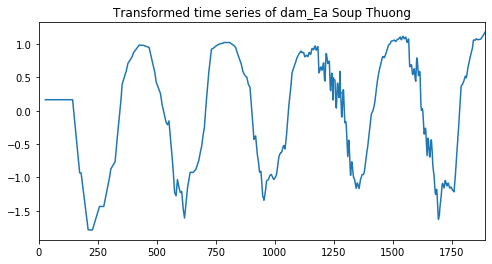

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000948      0.000272         0.000558        0.000127           0    0.0001           0.687084           0.726347           0.006648           0.554568           0.657820         0.526493        0.266085                5
1       0.001229      0.000375         0.000611        0.000011         0.5    0.0001           0.686704           0.728916           0.022394           0.556901           0.657819         0.530547        0.260326                4
2       0.001072      0.000114         0.000607        0.000009           1    0.0001           0.686164           0.730967           0.036460           0.559154           0.657818         0.534113        0.255131                3
3       0.001072      0.000120         0.000612        0.000011           2    0.0001           0.685270           0.734034           0.060657           0.563444           0.657816         0.540244        0.246151                2
4       0.001565      0.000956         0.000636        0.000031          10    0.0001           0.684017           0.741751           0.166410           0.590200           0.657796         0.568035        0.206630                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.066769      0.038024         0.002501        0.000990     0.1             2000            2           0.1       linear           0.689385           0.727563          -0.074292           0.656357           0.629080         0.525619        0.301758                1
1        0.040113      0.032265         0.005479        0.002759     0.1             2000            2           0.1          rbf          -0.187159           0.736240           0.203662           0.695289           0.646838         0.418974        0.358521                7
2        0.048560      0.039420         0.004920        0.002846     0.1             2000            2           0.1         poly          -0.150155          -0.379592          -0.286147          -0.239650           0.050634        -0.200982        0.145975               28
3        0.024324      0.020968         0.000698        0.000222     0.1             2000            2             1       linear           0.530384           0.352377           0.220336           0.442182           0.502909         0.409638        0.112652                9
4        0.007912      0.006720         0.001199        0.000542     0.1             2000            2             1          rbf          -0.596034           0.111662          -0.051173           0.296953           0.430136         0.038309        0.356708               21
5        0.024062      0.018234         0.001559        0.000776     0.1             2000            2             1         poly          -0.632150          -0.152941          -0.133264          -0.026165           0.104004        -0.168103        0.249388               27
6        0.059895      0.042225         0.002255        0.001156     0.1             2000            3           0.1       linear           0.689385           0.727563          -0.074292           0.656357           0.629080         0.525619        0.301758                1
7        0.039587      0.032724         0.005359        0.002745     0.1             2000            3           0.1          rbf          -0.187159           0.736240           0.203662           0.695289           0.646838         0.418974        0.358521                7
8        0.060636      0.044368         0.004309        0.002004     0.1             2000            3           0.1         poly           0.427721           0.498466           0.161186           0.362587           0.362747         0.362541        0.112488               15
9        0.021929      0.019214         0.000570        0.000191     0.1             2000            3             1       linear           0.530384           0.352377           0.220336           0.442182           0.502909         0.409638        0.112652                9
10       0.007345      0.006252         0.001124        0.000511     0.1             2000            3             1          rbf          -0.596034           0.111662          -0.051173           0.296953           0.430136         0.038309        0.356708               21
11       0.013931      0.010578         0.000790        0.000291     0.1             2000            3             1         poly          -0.204102           0.138062           0.013543           0.212908           0.341502         0.100383        0.185727               18
12       0.212136      0.174546         0.002094        0.001064       1             2000            2           0.1       linear           0.692364           0.725367          -0.183263           0.637535           0.626493         0.499699        0.343383                3
13       0.051227      0.038892         0.005159        0.002623       1             2000            2           0.1          rbf          -0.567847      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001619      0.001221         0.000533        0.000018           0    0.0001           0.661053           0.658414          -3.696844           0.572648           0.638579        -0.233230        1.732102                5
1       0.003078      0.004048         0.000565        0.000049         0.5    0.0001           0.689927           0.732246          -3.564873           0.573443           0.641615        -0.185529        1.690497                4
2       0.001030      0.000164         0.002435        0.003817           1    0.0001           0.689101           0.740228          -3.491768           0.574517           0.643488        -0.168887        1.662334                3
3       0.003023      0.003961         0.000534        0.000021           2    0.0001           0.687306           0.746720          -3.366146           0.576939           0.646160        -0.141804        1.613119                2
4       0.002271      0.002498         0.000872        0.000662          10    0.0001           0.684363           0.761154          -2.582562           0.596791           0.654098         0.022769        1.303744                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.074853      0.049377         0.004623        0.001952     0.1             2000            2           0.1       linear           0.690585           0.739830          -2.174649           0.660962           0.624767         0.108299        1.142096                7
1        0.048881      0.039390         0.007965        0.004020     0.1             2000            2           0.1          rbf          -0.167098           0.752370          -0.387311           0.372230           0.637041         0.241447        0.446517                2
2        0.056099      0.049822         0.006065        0.004218     0.1             2000            2           0.1         poly           0.672387           0.742265          -0.706014          -2.396427          -2.235524        -0.784663        1.353770               32
3        0.028528      0.022019         0.001023        0.000396     0.1             2000            2             1       linear           0.528530           0.338081          -1.547374           0.335769           0.466788         0.024359        0.789389                9
4        0.009825      0.008371         0.001675        0.000854     0.1             2000            2             1          rbf          -0.590159           0.109148          -0.465649           0.214623           0.378166        -0.070774        0.384983               16
5        0.014391      0.016613         0.001611        0.001307     0.1             2000            2             1         poly          -0.072506           0.131781          -0.720367          -0.209866           0.028859        -0.168420        0.298195               26
6        0.071605      0.052424         0.004304        0.002355     0.1             2000            3           0.1       linear           0.690585           0.739830          -2.174649           0.660962           0.624767         0.108299        1.142096                7
7        0.048712      0.039007         0.007958        0.003997     0.1             2000            3           0.1          rbf          -0.167098           0.752370          -0.387311           0.372230           0.637041         0.241447        0.446517                2
8        0.051856      0.036935         0.005085        0.002898     0.1             2000            3           0.1         poly           0.595337           0.738869           0.007425           0.346526           0.320280         0.401687        0.251517                1
9        0.025914      0.020305         0.000869        0.000395     0.1             2000            3             1       linear           0.528530           0.338081          -1.547374           0.335769           0.466788         0.024359        0.789389                9
10       0.009077      0.007779         0.001562        0.000779     0.1             2000            3             1          rbf          -0.590159           0.109148          -0.465649           0.214623           0.378166        -0.070774        0.384983               16
11       0.011246      0.010385         0.000973        0.000513     0.1             2000            3             1         poly          -0.234116           0.169795           0.017276           0.440392           0.501845         0.179038        0.271830                4
12       0.252023      0.200694         0.003891        0.002190       1             2000            2           0.1       linear           0.701775           0.732670          -2.686142           0.636067           0.623017         0.001477        1.344424               13
13       0.060017      0.044167         0.007350        0.003743       1             2000            2           0.1          rbf          -0.564020      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000999      0.000258         0.000575        0.000106           0    0.0001          -1.983800          -0.878367          -1.090540          -0.197064          -0.123685        -0.854691        0.677926                5
1       0.001089      0.000137         0.000618        0.000007         0.5    0.0001          -1.777792          -0.419772          -0.731967          -0.191153          -0.121060        -0.648349        0.603646                4
2       0.001081      0.000118         0.000614        0.000006           1    0.0001          -1.616393          -0.362946          -0.592549          -0.187878          -0.119220        -0.575797        0.545412                3
3       0.001085      0.000119         0.000614        0.000006           2    0.0001          -1.381497          -0.347928          -0.428181          -0.184152          -0.116532        -0.491658        0.458646                2
4       0.001064      0.000112         0.000608        0.000005          10    0.0001          -0.804870          -0.364679          -0.070724          -0.181914          -0.110855        -0.306608        0.268755                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.049064      0.030928         0.004966        0.001316     0.1             2000            2           0.1       linear      -9.740709e-01      -2.205659e-01      -3.473485e-02          -0.580496          -0.678588    -4.976910e-01    3.339595e-01                3
1        0.059834      0.047564         0.008846        0.004544     0.1             2000            2           0.1          rbf      -1.700268e+00      -4.856358e-01      -4.591073e-01          -0.489183          -0.748800    -7.765990e-01    4.737101e-01                9
2        0.314381      0.325920         0.004577        0.002032     0.1             2000            2           0.1         poly      -2.283099e+00      -1.168502e+00      -1.101732e+00          -0.031558          -0.607454    -1.038469e+00    7.442658e-01               16
3        0.014169      0.011246         0.001452        0.000628     0.1             2000            2             1       linear      -7.558534e-01      -7.437454e-01      -1.027083e+00           0.015762           0.010603    -5.000634e-01    4.311416e-01                5
4        0.020679      0.016337         0.003330        0.001755     0.1             2000            2             1          rbf      -7.707949e-01      -5.551321e-01      -6.663411e-01          -0.025371           0.004020    -4.027237e-01    3.274247e-01                1
5        0.054697      0.039415         0.001841        0.000811     0.1             2000            2             1         poly      -1.253500e+00      -1.584392e+00      -1.596272e+00          -0.005219           0.016701    -8.845365e-01    7.372825e-01               13
6        0.040184      0.032385         0.003472        0.001406     0.1             2000            3           0.1       linear      -9.740709e-01      -2.205659e-01      -3.473485e-02          -0.580496          -0.678588    -4.976910e-01    3.339595e-01                3
7        0.054722      0.044273         0.008055        0.004235     0.1             2000            3           0.1          rbf      -1.700268e+00      -4.856358e-01      -4.591073e-01          -0.489183          -0.748800    -7.765990e-01    4.737101e-01                9
8       11.044333     15.893517         0.004412        0.001887     0.1             2000            3           0.1         poly      -3.819090e+03      -9.652368e+03      -1.429742e+01          -0.706223          -0.830218    -2.697458e+03    3.778160e+03               31
9        0.014095      0.011180         0.001435        0.000618     0.1             2000            3             1       linear      -7.558534e-01      -7.437454e-01      -1.027083e+00           0.015762           0.010603    -5.000634e-01    4.311416e-01                5
10       0.020373      0.016223         0.003147        0.001632     0.1             2000            3             1          rbf      -7.707949e-01      -5.551321e-01      -6.663411e-01          -0.025371           0.004020    -4.027237e-01    3.274247e-01                1
11      11.780537     14.132846         0.002518        0.000693     0.1             2000            3             1         poly      -3.746232e+03      -1.088979e+04      -2.752895e+01           0.060302           0.026950    -2.932693e+03    4.233653e+03               32
12       0.051330      0.046054         0.003482        0.001604       1             2000            2           0.1       linear      -2.021377e+00      -1.094962e+00      -5.105146e-01          -0.560993          -0.682735    -9.741163e-01    5.624693e-01               14
13       0.060494      0.047640         0.008295        0.004235       1             2000            2           0.1          rbf      -1.722647e+00      

>>> Final results:



period = 15, future = 10, Node: dam_Krong Buk Ha, neighbors: ['dam_Buon Kuop']


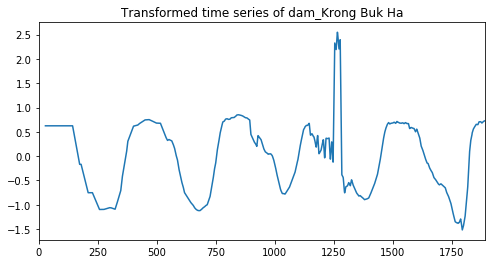

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000936      0.000278         0.000556        0.000127           0    0.0001           0.869917           0.808588          -0.652385          -6.758875           0.586925        -1.029166        2.917778                5
1       0.001053      0.000115         0.000606        0.000008         0.5    0.0001           0.868245           0.811757          -0.640971          -6.681131           0.586886        -1.011043        2.887717                4
2       0.001845      0.000772         0.000638        0.000027           1    0.0001           0.866400           0.813775          -0.631922          -6.606499           0.586847        -0.994280        2.858652                3
3       0.001058      0.000120         0.000605        0.000004           2    0.0001           0.862956           0.816503          -0.617564          -6.465607           0.586770        -0.963388        2.803588                2
4       0.001052      0.000118         0.000611        0.000011          10    0.0001           0.843973           0.823924          -0.552824          -5.610948           0.586185        -0.781938        2.468440                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.059742      0.045366         0.002451        0.000821     0.1             2000            2           0.1       linear           0.849057           0.804713          -0.873859          -0.397293           0.720852         0.220694        0.716384                7
1        0.033121      0.027995         0.004562        0.002373     0.1             2000            2           0.1          rbf           0.799133           0.807975           0.065927           0.817929           0.838664         0.665926        0.300288                3
2        0.054142      0.046314         0.004659        0.002098     0.1             2000            2           0.1         poly          -0.788855           0.180078         -11.371924         -65.252132           0.067815       -15.433004       25.286094               28
3        0.015287      0.018251         0.000463        0.000146     0.1             2000            2             1       linear          -0.499131          -0.170057          -0.038705          -0.509188           0.021357        -0.239145        0.225090               19
4        0.003471      0.003828         0.000848        0.000622     0.1             2000            2             1          rbf          -0.499131          -0.170057          -0.037934           0.056084           0.154147        -0.099378        0.226723               13
5        0.006571      0.007685         0.000706        0.000115     0.1             2000            2             1         poly          -0.499131          -0.170057          -0.069547          -0.670729          -0.085199        -0.298933        0.242165               25
6        0.053703      0.048439         0.002066        0.001153     0.1             2000            3           0.1       linear           0.849057           0.804713          -0.873859          -0.397293           0.720852         0.220694        0.716384                7
7        0.033134      0.027963         0.004535        0.002364     0.1             2000            3           0.1          rbf           0.799133           0.807975           0.065927           0.817929           0.838664         0.665926        0.300288                3
8        0.046600      0.033745         0.003805        0.001770     0.1             2000            3           0.1         poly           0.645268           0.862987       -1336.572935        -101.178349          -1.300340      -287.508674      525.996375               32
9        0.015376      0.018347         0.000442        0.000157     0.1             2000            3             1       linear          -0.499131          -0.170057          -0.038705          -0.509188           0.021357        -0.239145        0.225090               19
10       0.002585      0.002666         0.000545        0.000248     0.1             2000            3             1          rbf          -0.499131          -0.170057          -0.037934           0.056084           0.154147        -0.099378        0.226723               13
11       0.005844      0.006786         0.000522        0.000207     0.1             2000            3             1         poly          -0.499131          -0.170057          -0.077109        -143.582039           0.196588       -28.826350       57.378275               29
12       0.209922      0.234320         0.001890        0.001071       1             2000            2           0.1       linear           0.854614           0.797790          -0.930030          -0.880742           0.718488         0.112024        0.831982                9
13       0.037619      0.031724         0.003749        0.002056       1             2000            2           0.1          rbf           0.825896      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004119      0.002481         0.001751        0.001156           0    0.0001           0.881535           0.738278          -0.653206          -7.026276           0.618812        -1.088172        3.019263                5
1       0.002592      0.000283         0.000812        0.000010         0.5    0.0001           0.880228           0.738725          -0.641525          -6.931166           0.618811        -1.066985        2.982072                4
2       0.002586      0.000309         0.000801        0.000010           1    0.0001           0.878814           0.738532          -0.632270          -6.840796           0.618810        -1.047382        2.946587                3
3       0.002761      0.000531         0.000848        0.000024           2    0.0001           0.876181           0.737570          -0.617646          -6.672503           0.618806        -1.011519        2.880367                2
4       0.002590      0.000308         0.000806        0.000011          10    0.0001           0.861656           0.726476          -0.552597          -5.704018           0.618739        -0.809949        2.498566                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.105708      0.088976         0.004185        0.002181     0.1             2000            2           0.1       linear           0.870939           0.756761          -0.875633          -0.351672           0.713879         0.222855        0.704689                7
1        0.049539      0.040872         0.007655        0.004040     0.1             2000            2           0.1          rbf           0.566708           0.695268           0.088797           0.622267           0.575498         0.509708        0.215335                5
2        0.066938      0.053623         0.008771        0.004804     0.1             2000            2           0.1         poly          -0.713814          -1.718243          -4.414152          -6.463321          -0.782983        -2.818503        2.263379               28
3        0.022856      0.028206         0.000615        0.000328     0.1             2000            2             1       linear          -0.499131          -0.170057          -0.038431          -0.649944           0.017018        -0.268109        0.261852               20
4        0.004476      0.004886         0.000793        0.000487     0.1             2000            2             1          rbf          -0.499131          -0.170057          -0.039471           0.009710           0.106442        -0.118501        0.210152               15
5        0.005585      0.006588         0.000623        0.000308     0.1             2000            2             1         poly          -0.499131          -0.170057          -0.035857          -0.490621           0.041697        -0.230794        0.226033               17
6        0.099762      0.092652         0.004018        0.002424     0.1             2000            3           0.1       linear           0.870939           0.756761          -0.875633          -0.351672           0.713879         0.222855        0.704689                7
7        0.050070      0.041710         0.007659        0.004041     0.1             2000            3           0.1          rbf           0.566708           0.695268           0.088797           0.622267           0.575498         0.509708        0.215335                5
8        0.059695      0.043033         0.005950        0.002712     0.1             2000            3           0.1         poly           0.260782          -9.195698        -107.536634        -397.678278          -1.373401      -103.104646      152.738872               33
9        0.020500      0.025260         0.000514        0.000245     0.1             2000            3             1       linear          -0.499131          -0.170057          -0.038431          -0.649944           0.017018        -0.268109        0.261852               20
10       0.003982      0.004352         0.000670        0.000412     0.1             2000            3             1          rbf          -0.499131          -0.170057          -0.039471           0.009710           0.106442        -0.118501        0.210152               15
11       0.005270      0.006070         0.000537        0.000264     0.1             2000            3             1         poly          -0.499131          -0.170057          -0.065162          -4.050131          -0.062006        -0.969298        1.548678               26
12       0.526736      0.561874         0.003744        0.002468       1             2000            2           0.1       linear           0.877744           0.765307          -0.922358          -0.648984           0.712827         0.156907        0.776283                9
13       0.058808      0.046220         0.006393        0.003385       1             2000            2           0.1          rbf           0.641836      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001022      0.000230         0.000590        0.000076           0    0.0001          -0.615221          -0.290536          -0.036220          -0.160543          -0.154566        -0.251417        0.198913                5
1       0.001099      0.000132         0.000610        0.000004         0.5    0.0001          -0.613656          -0.288186          -0.036177          -0.160326          -0.154519        -0.250573        0.198283                4
2       0.001085      0.000107         0.000617        0.000012           1    0.0001          -0.612482          -0.286171          -0.036134          -0.160111          -0.154472        -0.249874        0.197811                3
3       0.001102      0.000108         0.000628        0.000023           2    0.0001          -0.610676          -0.282778          -0.036052          -0.159690          -0.154379        -0.248715        0.197092                2
4       0.001068      0.000125         0.000608        0.000005          10    0.0001          -0.602996          -0.266179          -0.035509          -0.156661          -0.153705        -0.243010        0.194224                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.073059      0.050144         0.005164        0.001371     0.1             2000            2           0.1       linear          -1.068752          -1.020433          -0.016031          -0.338216          -0.267933        -0.542273        0.424181               18
1        0.062987      0.051793         0.009126        0.004732     0.1             2000            2           0.1          rbf          -3.057726          -0.210215          -0.022341          -0.420460          -0.149148        -0.771978        1.150101               24
2        0.054561      0.040994         0.004861        0.002116     0.1             2000            2           0.1         poly         -11.275634         -55.457232          -0.038079          -0.241586          -0.311094       -13.464725       21.430385               31
3        0.020735      0.023999         0.000509        0.000215     0.1             2000            2             1       linear          -0.499131          -0.170057          -0.038164          -0.065739          -0.120564        -0.178731        0.166518                6
4        0.004520      0.004635         0.000720        0.000386     0.1             2000            2             1          rbf          -0.499131          -0.170057          -0.047128           0.005263           0.044816        -0.133247        0.196740                1
5        0.006340      0.006292         0.000524        0.000176     0.1             2000            2             1         poly          -0.499131          -0.170057          -0.050300          -0.039717          -0.065535        -0.164948        0.173444                5
6        0.066361      0.053748         0.003992        0.001672     0.1             2000            3           0.1       linear          -1.068752          -1.020433          -0.016031          -0.338216          -0.267933        -0.542273        0.424181               18
7        0.061146      0.049642         0.009073        0.004752     0.1             2000            3           0.1          rbf          -3.057726          -0.210215          -0.022341          -0.420460          -0.149148        -0.771978        1.150101               24
8        0.068668      0.054614         0.004737        0.001981     0.1             2000            3           0.1         poly          -6.099972        -649.421576          -0.208198          -0.335624          -0.276758      -131.268426      259.086406               34
9        0.018325      0.021101         0.000422        0.000117     0.1             2000            3             1       linear          -0.499131          -0.170057          -0.038164          -0.065739          -0.120564        -0.178731        0.166518                6
10       0.003936      0.004005         0.000601        0.000309     0.1             2000            3             1          rbf          -0.499131          -0.170057          -0.047128           0.005263           0.044816        -0.133247        0.196740                1
11       0.017040      0.019668         0.000500        0.000187     0.1             2000            3             1         poly          -0.499131          -0.170057          -0.052942          -0.251804          -0.142016        -0.223190        0.151894               12
12       0.168782      0.137379         0.003583        0.001569       1             2000            2           0.1       linear          -1.026603          -1.294910          -0.016022          -0.337252          -0.269821        -0.588921        0.486490               20
13       0.069316      0.053352         0.008451        0.004347       1             2000            2           0.1          rbf          -2.942153      

>>> Final results:



period = 15, future = 10, Node: dam_Buon Kuop, neighbors: ['dam_Lower Sesan II', 'dam_Krong Buk Ha']


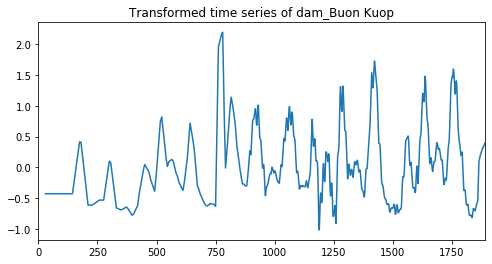

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000936      0.000275         0.000555        0.000126           0    0.0001           0.382195          -0.435899          -0.100888           0.339472           0.161100         0.069196        0.304471                5
1       0.001059      0.000117         0.000609        0.000002         0.5    0.0001           0.378827          -0.431409          -0.099239           0.339452           0.161121         0.069750        0.302104                4
2       0.001079      0.000152         0.000604        0.000007           1    0.0001           0.375584          -0.427852          -0.097617           0.339432           0.161141         0.070138        0.300078                3
3       0.001048      0.000115         0.000610        0.000009           2    0.0001           0.369842          -0.422302          -0.094447           0.339391           0.161180         0.070733        0.296713                2
4       0.001686      0.000859         0.000675        0.000085          10    0.0001           0.340730          -0.396596          -0.072148           0.339029           0.161459         0.074495        0.279947                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.082677      0.057915         0.003256        0.001056     0.1             2000            2           0.1       linear           0.423964          -0.503675          -0.152121           0.377843           0.111573         0.051517        0.345982               11
1        0.049369      0.041789         0.005943        0.003401     0.1             2000            2           0.1          rbf           0.081474          -0.106930           0.035565           0.282011           0.205606         0.099545        0.135348                1
2        0.058515      0.047308         0.004248        0.002485     0.1             2000            2           0.1         poly          -0.916547         -10.559192          -0.014995           0.020473          -0.059805        -2.306013        4.141312               31
3        0.027097      0.024923         0.000734        0.000380     0.1             2000            2             1       linear          -0.003421          -0.006252           0.032620           0.211892           0.138872         0.074742        0.086448                9
4        0.008824      0.008817         0.001203        0.000805     0.1             2000            2             1          rbf          -0.003421          -0.006252          -0.062628           0.072568           0.130154         0.026084        0.067494               17
5        0.015269      0.014700         0.000878        0.000509     0.1             2000            2             1         poly          -0.003421          -0.006252          -0.071825           0.019947           0.064210         0.000532        0.044111               26
6        0.075881      0.062276         0.002681        0.001545     0.1             2000            3           0.1       linear           0.423964          -0.503675          -0.152121           0.377843           0.111573         0.051517        0.345982               11
7        0.048745      0.041237         0.005946        0.003409     0.1             2000            3           0.1          rbf           0.081474          -0.106930           0.035565           0.282011           0.205606         0.099545        0.135348                1
8        0.083428      0.067061         0.003840        0.001929     0.1             2000            3           0.1         poly          -0.598274        -406.257218          -0.055730          -0.858504          -0.109349       -81.575815      162.340980               34
9        0.025344      0.023290         0.000667        0.000346     0.1             2000            3             1       linear          -0.003421          -0.006252           0.032620           0.211892           0.138872         0.074742        0.086448                9
10       0.008187      0.008184         0.001061        0.000709     0.1             2000            3             1          rbf          -0.003421          -0.006252          -0.062628           0.072568           0.130154         0.026084        0.067494               17
11       0.021189      0.021669         0.000800        0.000464     0.1             2000            3             1         poly          -0.003421          -0.006252           0.099040          -0.149445           0.094475         0.006880        0.090424               23
12       0.270552      0.230117         0.002781        0.001710       1             2000            2           0.1       linear           0.430884          -0.519915          -0.172523           0.376305           0.111187         0.045188        0.354822               13
13       0.055729      0.044561         0.005192        0.003075       1             2000            2           0.1          rbf           0.110354      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001577      0.000367         0.000664        0.000025           0    0.0001           0.250096          -0.516371          -3.451476          -0.160224           0.186123        -0.738371        1.383924                5
1       0.001624      0.000321         0.000656        0.000012         0.5    0.0001           0.416383          -0.460251          -3.248569          -0.142239           0.189374        -0.649060        1.333274                4
2       0.001614      0.000288         0.000659        0.000020           1    0.0001           0.411497          -0.442214          -3.127814          -0.133412           0.190819        -0.620225        1.286773                3
3       0.001564      0.000299         0.000639        0.000012           2    0.0001           0.401437          -0.425191          -2.934734          -0.120442           0.192054        -0.577375        1.211543                2
4       0.001568      0.000317         0.000677        0.000062          10    0.0001           0.362608          -0.384979          -2.075645          -0.044717           0.189938        -0.390559        0.879021                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.129364      0.100550         0.008054        0.003960     0.1             2000            2           0.1       linear           0.446011          -0.434506          -0.383448           0.022824           0.146845        -0.040455        0.331257                7
1        0.071617      0.061658         0.012250        0.007497     0.1             2000            2           0.1          rbf           0.083619          -0.125484           0.017487           0.079795           0.083707         0.027825        0.080681                1
2        0.065632      0.057040         0.008575        0.005206     0.1             2000            2           0.1         poly           0.338891          -0.313823          -0.382774          -1.667774          -0.236916        -0.452479        0.659357               26
3        0.035538      0.030126         0.001476        0.000984     0.1             2000            2             1       linear          -0.003421          -0.006252          -0.988483          -0.409610           0.161959        -0.249162        0.414910               24
4        0.012980      0.013155         0.002163        0.001694     0.1             2000            2             1          rbf          -0.003421          -0.006252          -0.089982           0.094752           0.101732         0.019366        0.071554                3
5        0.012152      0.012023         0.001531        0.001127     0.1             2000            2             1         poly          -0.003421          -0.006252          -0.072035          -0.157096           0.014492        -0.044862        0.063350                9
6        0.124734      0.110733         0.007973        0.005156     0.1             2000            3           0.1       linear           0.446011          -0.434506          -0.383448           0.022824           0.146845        -0.040455        0.331257                7
7        0.068163      0.057095         0.011256        0.006362     0.1             2000            3           0.1          rbf           0.083619          -0.125484           0.017487           0.079795           0.083707         0.027825        0.080681                1
8        0.061384      0.051342         0.007484        0.004549     0.1             2000            3           0.1         poly           0.138364          -2.519614          -0.325462          -1.333682           0.058781        -0.796323        1.008468               29
9        0.034596      0.029400         0.001353        0.000951     0.1             2000            3             1       linear          -0.003421          -0.006252          -0.988483          -0.409610           0.161959        -0.249162        0.414910               24
10       0.011768      0.011938         0.001910        0.001522     0.1             2000            3             1          rbf          -0.003421          -0.006252          -0.089982           0.094752           0.101732         0.019366        0.071554                3
11       0.014829      0.015186         0.001480        0.001115     0.1             2000            3             1         poly          -0.003421          -0.006252           0.070800          -1.169387           0.105634        -0.200525        0.486341               18
12       0.715676      0.672534         0.006825        0.004173       1             2000            2           0.1       linear           0.457433          -0.442770          -0.613772          -0.059629           0.138000        -0.104147        0.387394               12
13       0.073760      0.060250         0.010193        0.005829       1             2000            2           0.1          rbf           0.113273      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001337      0.000199         0.000650        0.000021           0    0.0001          -0.331613          -0.181912          -4.611973          -0.789151          -0.030553        -1.189040        1.730200                5
1       0.001312      0.000208         0.000639        0.000015         0.5    0.0001          -0.104416          -0.145990          -4.323427          -0.777052          -0.024140        -1.075005        1.646235                4
2       0.001331      0.000207         0.000641        0.000005           1    0.0001          -0.103749          -0.136931          -4.140963          -0.773393          -0.020789        -1.035165        1.575933                3
3       0.001295      0.000194         0.000626        0.000003           2    0.0001          -0.111181          -0.127210          -3.864485          -0.767113          -0.017464        -0.977491        1.467932                2
4       0.001292      0.000197         0.000622        0.000004          10    0.0001          -0.131421          -0.107073          -2.717841          -0.670237          -0.019352        -0.729185        1.020435                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.096853      0.073369         0.006817        0.003157     0.1             2000            2           0.1       linear          -0.213028          -0.189639          -1.779774          -0.544479          -0.098223        -0.565028        0.625901               21
1        0.076347      0.062932         0.011835        0.006648     0.1             2000            2           0.1          rbf          -0.331717          -0.199558          -0.111484          -0.008881          -0.117104        -0.153749        0.107598                4
2        0.062284      0.051941         0.007370        0.004143     0.1             2000            2           0.1         poly          -0.273503          -0.200699          -0.755035          -1.381995          -0.243749        -0.570996        0.452615               23
3        0.025815      0.029321         0.001190        0.000839     0.1             2000            2             1       linear          -0.003421          -0.006252          -1.641918          -0.503046           0.024977        -0.425932        0.639145               13
4        0.013928      0.014386         0.001964        0.001536     0.1             2000            2             1          rbf          -0.003421          -0.006252          -0.119068           0.071958          -0.097813        -0.030919        0.069561                1
5        0.010228      0.010756         0.001248        0.000869     0.1             2000            2             1         poly          -0.003421          -0.006252          -0.101070           0.095529          -0.172010        -0.037445        0.091617                3
6        0.092539      0.079963         0.006590        0.003601     0.1             2000            3           0.1       linear          -0.213028          -0.189639          -1.779774          -0.544479          -0.098223        -0.565028        0.625901               21
7        0.077571      0.062887         0.012677        0.007186     0.1             2000            3           0.1          rbf          -0.331717          -0.199558          -0.111484          -0.008881          -0.117104        -0.153749        0.107598                4
8        0.064544      0.052184         0.007599        0.004128     0.1             2000            3           0.1         poly          -0.351302          -0.199108          -1.563598          -3.377195          -0.176352        -1.133511        1.234521               27
9        0.024903      0.028264         0.001161        0.000811     0.1             2000            3             1       linear          -0.003421          -0.006252          -1.641918          -0.503046           0.024977        -0.425932        0.639145               13
10       0.013700      0.014252         0.001877        0.001464     0.1             2000            3             1          rbf          -0.003421          -0.006252          -0.119068           0.071958          -0.097813        -0.030919        0.069561                1
11       0.013401      0.014794         0.001210        0.000863     0.1             2000            3             1         poly          -0.003421          -0.006252          -1.029102          -0.423723          -0.087819        -0.310063        0.391320               10
12       0.244237      0.250142         0.005927        0.003280       1             2000            2           0.1       linear          -0.208863          -0.195137          -4.071727          -0.900983          -0.097634        -1.094869        1.515802               25
13       0.079489      0.061318         0.010579        0.005866       1             2000            2           0.1          rbf          -0.523463      

>>> Final results:



period = 15, future = 10, Node: rw_223, neighbors: ['rw_34']


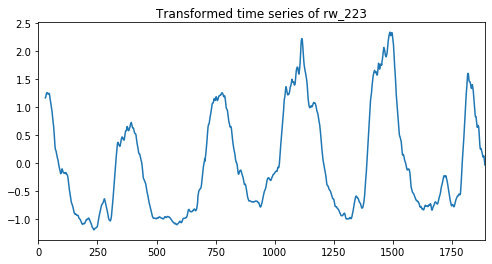

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000931      0.000273         0.000558        0.000102           0    0.0001           0.689921           0.688702           0.558859           0.706995           0.458091         0.620514        0.097086                5
1       0.001053      0.000110         0.000606        0.000005         0.5    0.0001           0.692114           0.690005           0.559076           0.706884           0.458181         0.621252        0.097508                4
2       0.001047      0.000113         0.000603        0.000005           1    0.0001           0.693922           0.690932           0.559276           0.706774           0.458264         0.621834        0.097831                3
3       0.001051      0.000114         0.000601        0.000005           2    0.0001           0.696861           0.692122           0.559630           0.706557           0.458412         0.622716        0.098305                2
4       0.001355      0.000550         0.000671        0.000097          10    0.0001           0.709676           0.693498           0.561327           0.704948           0.459060         0.625702        0.099841                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.063254      0.036413         0.003846        0.000763     0.1             2000            2           0.1       linear           0.702665           0.660407           0.536567           0.705715           0.446183         0.610307        0.102486                1
1        0.049772      0.040201         0.007061        0.003483     0.1             2000            2           0.1          rbf           0.759060           0.587064           0.358304           0.639165           0.441415         0.557002        0.142354                7
2        0.047218      0.036655         0.004522        0.002150     0.1             2000            2           0.1         poly           0.177470          -1.324993          -1.838267           0.260499           0.402215        -0.464616        0.929153               33
3        0.020815      0.022588         0.000563        0.000259     0.1             2000            2             1       linear           0.375837           0.614141           0.543082           0.631347           0.314364         0.495754        0.128002               11
4        0.005210      0.005258         0.000937        0.000478     0.1             2000            2             1          rbf           0.223368           0.535267           0.264000           0.569692           0.281095         0.374685        0.146780               21
5        0.016671      0.014972         0.001524        0.000797     0.1             2000            2             1         poly          -0.282952          -0.142549          -0.271626           0.294849           0.327223        -0.015011        0.270942               29
6        0.057117      0.040835         0.003094        0.001351     0.1             2000            3           0.1       linear           0.702665           0.660407           0.536567           0.705715           0.446183         0.610307        0.102486                1
7        0.050207      0.040706         0.007137        0.003517     0.1             2000            3           0.1          rbf           0.759060           0.587064           0.358304           0.639165           0.441415         0.557002        0.142354                7
8        0.065922      0.049331         0.004459        0.002061     0.1             2000            3           0.1         poly           0.476018           0.434480          -2.255572          -1.424656           0.421233        -0.469700        1.149519               34
9        0.020568      0.022148         0.000538        0.000206     0.1             2000            3             1       linear           0.375837           0.614141           0.543082           0.631347           0.314364         0.495754        0.128002               11
10       0.005361      0.005366         0.000926        0.000452     0.1             2000            3             1          rbf           0.223368           0.535267           0.264000           0.569692           0.281095         0.374685        0.146780               21
11       0.023584      0.022982         0.000871        0.000463     0.1             2000            3             1         poly           0.237260           0.450133          -0.209760           0.234415           0.235529         0.189515        0.216220               25
12       0.163413      0.135403         0.002886        0.001298       1             2000            2           0.1       linear           0.687365           0.657678           0.533896           0.707568           0.446153         0.606532        0.100355                5
13       0.059353      0.043269         0.006513        0.003240       1             2000            2           0.1          rbf           0.672399      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001075      0.000093         0.000541        0.000014           0    0.0001           0.297039           0.665899           0.575903           0.708443           0.493499         0.548157        0.145858                5
1       0.000991      0.000131         0.000519        0.000017         0.5    0.0001           0.315660           0.672761           0.576345           0.708540           0.493674         0.553396        0.140662                4
2       0.001013      0.000143         0.000520        0.000003           1    0.0001           0.325189           0.675332           0.576700           0.708603           0.493820         0.555929        0.137910                3
3       0.001003      0.000151         0.000525        0.000004           2    0.0001           0.336833           0.677686           0.577265           0.708667           0.494047         0.558900        0.134460                2
4       0.000998      0.000143         0.000521        0.000005          10    0.0001           0.372904           0.679310           0.579643           0.708535           0.494636         0.567005        0.123057                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.082899      0.055373         0.006624        0.002340     0.1             2000            2           0.1       linear           0.403278           0.627070           0.558244           0.710360           0.479000         0.555590        0.107829                1
1        0.065750      0.054725         0.011026        0.005663     0.1             2000            2           0.1          rbf           0.550763           0.542211           0.457073           0.632380           0.415920         0.519670        0.075975                7
2        0.064724      0.052246         0.008184        0.003940     0.1             2000            2           0.1         poly           0.183462          -0.921558          -1.226382           0.330218           0.300732        -0.266706        0.667947               33
3        0.022720      0.024216         0.000763        0.000409     0.1             2000            2             1       linear           0.237676           0.613756           0.545731           0.651913           0.382640         0.486343        0.154767               11
4        0.005976      0.005827         0.001101        0.000636     0.1             2000            2             1          rbf           0.053980           0.507819           0.291059           0.558023           0.229818         0.328140        0.185115               21
5        0.015680      0.014435         0.001841        0.001091     0.1             2000            2             1         poly           0.041632          -0.025934          -0.176778           0.434322           0.207183         0.096085        0.209311               28
6        0.077632      0.058123         0.005931        0.002879     0.1             2000            3           0.1       linear           0.403278           0.627070           0.558244           0.710360           0.479000         0.555590        0.107829                1
7        0.065434      0.054068         0.010785        0.005511     0.1             2000            3           0.1          rbf           0.550763           0.542211           0.457073           0.632380           0.415920         0.519670        0.075975                7
8        0.075992      0.056018         0.007583        0.003552     0.1             2000            3           0.1         poly           0.406024           0.295461          -0.811971          -0.608822           0.338912        -0.076079        0.523074               31
9        0.020531      0.021270         0.000703        0.000296     0.1             2000            3             1       linear           0.237676           0.613756           0.545731           0.651913           0.382640         0.486343        0.154767               11
10       0.005391      0.005315         0.000996        0.000567     0.1             2000            3             1          rbf           0.053980           0.507819           0.291059           0.558023           0.229818         0.328140        0.185115               21
11       0.020309      0.023287         0.001068        0.000772     0.1             2000            3             1         poly           0.161868           0.461302           0.065409           0.369420           0.216056         0.254811        0.142679               23
12       0.232293      0.199567         0.005721        0.002698       1             2000            2           0.1       linear           0.337940           0.618552           0.553863           0.709133           0.480497         0.539997        0.125966                5
13       0.072990      0.055322         0.009581        0.004985       1             2000            2           0.1          rbf           0.156062      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000981      0.000279         0.000571        0.000130           0    0.0001          -0.012519           0.323344           0.262543           0.519885           0.240832         0.266817        0.170857                5
1       0.001076      0.000129         0.000615        0.000006         0.5    0.0001           0.023939           0.332133           0.262426           0.520066           0.240965         0.275906        0.159791                4
2       0.001078      0.000105         0.000625        0.000022           1    0.0001           0.046227           0.335200           0.262293           0.520230           0.241088         0.281008        0.153121                3
3       0.001086      0.000116         0.000624        0.000012           2    0.0001           0.074887           0.337236           0.261989           0.520513           0.241312         0.287188        0.144746                2
4       0.001062      0.000122         0.000610        0.000005          10    0.0001           0.155636           0.331758           0.258874           0.521458           0.242365         0.302018        0.123196                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.061768      0.032379         0.004101        0.000922     0.1             2000            2           0.1       linear           0.026052           0.241525           0.208490           0.504743           0.147106         0.225583        0.157764               19
1        0.056577      0.045595         0.007996        0.004011     0.1             2000            2           0.1          rbf           0.429521           0.259328           0.239487           0.461244           0.212627         0.320442        0.103572                3
2        0.049341      0.038216         0.004607        0.002107     0.1             2000            2           0.1         poly          -0.623500          -0.784514          -0.155411           0.430676           0.227768        -0.180996        0.469453               33
3        0.018344      0.015276         0.000666        0.000298     0.1             2000            2             1       linear          -0.110895           0.439336           0.299335           0.476894           0.269217         0.274777        0.208474               11
4        0.007301      0.007526         0.001118        0.000663     0.1             2000            2             1          rbf          -0.096180           0.399259           0.298042           0.414503           0.158135         0.234752        0.189084               15
5        0.014457      0.013216         0.001190        0.000611     0.1             2000            2             1         poly           0.037577           0.027700           0.027129           0.381146           0.128143         0.120339        0.135794               28
6        0.056623      0.038282         0.003689        0.001521     0.1             2000            3           0.1       linear           0.026052           0.241525           0.208490           0.504743           0.147106         0.225583        0.157764               19
7        0.057032      0.046065         0.008075        0.004039     0.1             2000            3           0.1          rbf           0.429521           0.259328           0.239487           0.461244           0.212627         0.320442        0.103572                3
8        0.065715      0.048302         0.004549        0.002148     0.1             2000            3           0.1         poly           0.068202          -0.096669          -0.130890          -0.005029           0.039932        -0.024891        0.077007               30
9        0.018577      0.015487         0.000685        0.000315     0.1             2000            3             1       linear          -0.110895           0.439336           0.299335           0.476894           0.269217         0.274777        0.208474               11
10       0.007506      0.007721         0.001200        0.000742     0.1             2000            3             1          rbf          -0.096180           0.399259           0.298042           0.414503           0.158135         0.234752        0.189084               15
11       0.024320      0.024965         0.000891        0.000559     0.1             2000            3             1         poly           0.028790           0.346836           0.291330           0.307988           0.151169         0.225223        0.118389               21
12       0.104407      0.072026         0.003392        0.001614       1             2000            2           0.1       linear          -0.080633           0.214923           0.208065           0.503671           0.149788         0.199163        0.186428               23
13       0.064918      0.050580         0.007530        0.003746       1             2000            2           0.1          rbf           0.342666      

>>> Final results:



period = 15, future = 10, Node: rw_34, neighbors: ['rw_239', 'dam_Nam Pung', 'dam_Pak Mun', 'dam_Houayho', 'dam_Xe Kaman 1', 'dam_Lower Sesan II', 'rw_223']


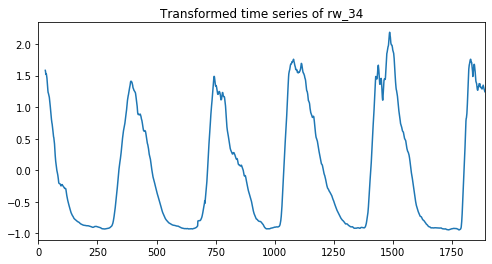

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.000949      0.000263         0.000554        0.000124           0    0.0001           0.858044           0.718030           0.783395           0.775247           0.709107         0.768765        0.053591                5
1       0.001050      0.000110         0.000613        0.000016         0.5    0.0001           0.857767           0.728294           0.783300           0.776051           0.709270         0.770936        0.051652                3
2       0.001061      0.000120         0.000613        0.000015           1    0.0001           0.856738           0.732432           0.783196           0.776799           0.709427         0.771719        0.050615                2
3       0.001071      0.000126         0.000602        0.000004           2    0.0001           0.854208           0.736024           0.782967           0.778150           0.709728         0.772216        0.049169                1
4       0.001474      0.000819         0.000616        0.000020          10    0.0001           0.839203           0.736157           0.780861           0.784537           0.711650         0.770482        0.043971                4

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.056815      0.032407         0.002951        0.000648     0.1             2000            2           0.1       linear           0.818644           0.738677           0.773955           0.768046           0.704142         0.760693        0.038134                1
1        0.038242      0.030950         0.005103        0.002459     0.1             2000            2           0.1          rbf           0.677964           0.718179           0.723037           0.703942           0.779911         0.720606        0.033541                7
2        0.052820      0.040219         0.004560        0.002265     0.1             2000            2           0.1         poly          -0.858286          -1.000653          -0.382651           0.414971           0.457976        -0.273728        0.615092               34
3        0.006384      0.008224         0.000412        0.000097     0.1             2000            2             1       linear           0.174351           0.590760           0.560020           0.573536           0.428007         0.465335        0.156505               17
4        0.003406      0.003146         0.000695        0.000247     0.1             2000            2             1          rbf           0.167836           0.270257           0.397998           0.418908           0.352263         0.321453        0.092222               23
5        0.012312      0.010520         0.001155        0.000506     0.1             2000            2             1         poly           0.080847           0.146390           0.362512           0.381892           0.238970         0.242122        0.117655               28
6        0.051242      0.037199         0.002266        0.001072     0.1             2000            3           0.1       linear           0.818644           0.738677           0.773955           0.768046           0.704142         0.760693        0.038134                1
7        0.038015      0.031180         0.005057        0.002553     0.1             2000            3           0.1          rbf           0.677964           0.718179           0.723037           0.703942           0.779911         0.720606        0.033541                7
8        0.066163      0.053068         0.003935        0.002161     0.1             2000            3           0.1         poly           0.404489           0.389990           0.119501          -0.291514           0.540688         0.232631        0.295541               29
9        0.006425      0.008235         0.000412        0.000095     0.1             2000            3             1       linear           0.174351           0.590760           0.560020           0.573536           0.428007         0.465335        0.156505               17
10       0.003467      0.003241         0.000684        0.000319     0.1             2000            3             1          rbf           0.167836           0.270257           0.397998           0.418908           0.352263         0.321453        0.092222               23
11       0.021581      0.021041         0.000724        0.000329     0.1             2000            3             1         poly           0.127580           0.238190           0.475272           0.327657           0.224971         0.278734        0.116964               25
12       0.143754      0.128526         0.002129        0.000959       1             2000            2           0.1       linear           0.846428           0.715772           0.774895           0.765225           0.700750         0.760614        0.051349                3
13       0.046228      0.038300         0.004495        0.002495       1             2000            2           0.1          rbf           0.614306      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003406      0.001200         0.000745        0.000044           0    0.0001           0.722716           0.685827          -1.973135           0.774923           0.699017         0.181870        1.077932                5
1       0.003362      0.000970         0.000711        0.000013         0.5    0.0001           0.448786           0.764424          -1.680800           0.776040           0.701318         0.201954        0.948789                4
2       0.003314      0.000979         0.000697        0.000022           1    0.0001           0.459739           0.768198          -1.576535           0.776798           0.702782         0.226197        0.908674                3
3       0.003315      0.000987         0.000693        0.000021           2    0.0001           0.565352           0.770793          -1.462782           0.777942           0.704867         0.271235        0.870364                2
4       0.003318      0.000981         0.000698        0.000017          10    0.0001           0.835859           0.772874          -1.118140           0.781755           0.712700         0.397010        0.758582                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.292592      0.238457         0.022078        0.009254     0.1             2000            2           0.1       linear           0.749007           0.765875          -0.517428           0.798507           0.708242         0.500841        0.509965                1
1        0.109046      0.093575         0.023321        0.013684     0.1             2000            2           0.1          rbf           0.383494           0.494838          -0.157940           0.274063           0.586129         0.316117        0.259185               14
2        0.110407      0.102517         0.021279        0.014180     0.1             2000            2           0.1         poly           0.424285           0.394313          -1.162678          -2.608169          -0.195883        -0.629626        1.144211               34
3        0.019464      0.022377         0.000956        0.000516     0.1             2000            2             1       linear           0.150477           0.233560           0.547079           0.658799           0.595679         0.437119        0.204927                3
4        0.011673      0.010342         0.002446        0.001307     0.1             2000            2             1          rbf          -0.003275           0.183944           0.069589           0.244342           0.132469         0.125414        0.086368               26
5        0.016028      0.020504         0.002779        0.002741     0.1             2000            2             1         poly          -0.054170           0.166082          -0.289592          -0.508608          -0.073628        -0.151983        0.229343               30
6        0.268870      0.226974         0.019364        0.010253     0.1             2000            3           0.1       linear           0.749007           0.765875          -0.517428           0.798507           0.708242         0.500841        0.509965                1
7        0.103451      0.087843         0.022025        0.012760     0.1             2000            3           0.1          rbf           0.383494           0.494838          -0.157940           0.274063           0.586129         0.316117        0.259185               14
8        0.107927      0.098662         0.019943        0.013470     0.1             2000            3           0.1         poly           0.260400           0.329666           0.059520           0.473088           0.506266         0.325788        0.160909               13
9        0.018772      0.021928         0.000948        0.000527     0.1             2000            3             1       linear           0.150477           0.233560           0.547079           0.658799           0.595679         0.437119        0.204927                3
10       0.011654      0.010353         0.002439        0.001329     0.1             2000            3             1          rbf          -0.003275           0.183944           0.069589           0.244342           0.132469         0.125414        0.086368               26
11       0.010621      0.010136         0.002105        0.001358     0.1             2000            3             1         poly          -0.073473           0.161799           0.273683           0.408873           0.259089         0.205994        0.160384               20
12       1.681060      1.441933         0.021119        0.011860       1             2000            2           0.1       linear           0.716116           0.752626          -0.870311           0.797275           0.706562         0.420454        0.646170                9
13       0.102037      0.084568         0.018351        0.010713       1             2000            2           0.1          rbf           0.652945      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.002987      0.001029         0.000737        0.000038           0    0.0001         -18.402550           0.414519          -1.150865           0.682902           0.581028        -3.574993        7.443806                5
1       0.003113      0.000910         0.000737        0.000033         0.5    0.0001         -17.524937           0.483863          -0.883195           0.682007           0.583071        -3.331838        7.119508                4
2       0.003009      0.000873         0.000699        0.000018           1    0.0001         -15.257547           0.509076          -0.806518           0.681569           0.584150        -2.857854        6.223689                3
3       0.003000      0.000864         0.000696        0.000020           2    0.0001         -11.817835           0.539798          -0.736577           0.680996           0.585489        -2.149626        4.862042                2
4       0.002988      0.000846         0.000696        0.000024          10    0.0001          -3.158216           0.588161          -0.582013           0.677972           0.588807        -0.377058        1.466593                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.266888      0.202424         0.024099        0.010060     0.1             2000            2           0.1       linear          -7.184859           0.586977          -0.049067           0.731328           0.502547        -1.082615        3.062557               28
1        0.120579      0.100852         0.025071        0.014235     0.1             2000            2           0.1          rbf           0.149458           0.372570          -0.600563           0.033550           0.409545         0.072912        0.364443               18
2        0.112493      0.089768         0.021920        0.011576     0.1             2000            2           0.1         poly           0.122909           0.627820          -1.260909          -2.147344          -0.181561        -0.567817        1.003108               27
3        0.023786      0.024792         0.001253        0.000773     0.1             2000            2             1       linear           0.130682           0.136484          -0.146633           0.641742           0.633195         0.279094        0.310003                2
4        0.012284      0.010920         0.002495        0.001318     0.1             2000            2             1          rbf          -0.031806           0.151643           0.035842           0.211940           0.068793         0.087282        0.085851               16
5        0.016027      0.019361         0.002817        0.002587     0.1             2000            2             1         poly          -0.095554           0.128408          -0.276202          -0.599016          -0.049344        -0.178342        0.246630               22
6        0.243160      0.189661         0.021648        0.010705     0.1             2000            3           0.1       linear          -7.184859           0.586977          -0.049067           0.731328           0.502547        -1.082615        3.062557               28
7        0.111020      0.093869         0.023622        0.013531     0.1             2000            3           0.1          rbf           0.149458           0.372570          -0.600563           0.033550           0.409545         0.072912        0.364443               18
8        0.105935      0.088476         0.019434        0.011432     0.1             2000            3           0.1         poly           0.060829           0.414213           0.135203           0.617107           0.219218         0.289314        0.201949                1
9        0.023792      0.024812         0.001216        0.000736     0.1             2000            3             1       linear           0.130682           0.136484          -0.146633           0.641742           0.633195         0.279094        0.310003                2
10       0.012292      0.010919         0.002497        0.001328     0.1             2000            3             1          rbf          -0.031806           0.151643           0.035842           0.211940           0.068793         0.087282        0.085851               16
11       0.010984      0.010102         0.002154        0.001347     0.1             2000            3             1         poly          -0.130702           0.083009           0.145709           0.352812           0.242786         0.138723        0.162730               11
12       1.300844      1.095492         0.021547        0.010842       1             2000            2           0.1       linear         -12.532277           0.446506          -0.248967           0.736777           0.501726        -2.219247        5.166984               31
13       0.103483      0.084621         0.018332        0.010407       1             2000            2           0.1          rbf           0.425181      

>>> Final results:



period = 30, future = 10, Node: dam_Haixihai, neighbors: ['dam_Xiaowan']


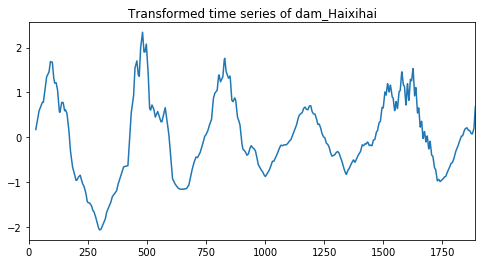

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001249      0.000260         0.000630        0.000012           0    0.0001           0.566484           0.669330           0.790424           0.557091           0.397579         0.596182        0.130333                5
1       0.007208      0.010954         0.000684        0.000049         0.5    0.0001           0.565419           0.670600           0.790470           0.558846           0.398114         0.596690        0.130273                4
2       0.003671      0.004705         0.000648        0.000039           1    0.0001           0.564270           0.671697           0.790503           0.560472           0.398612         0.597111        0.130220                3
3       0.003162      0.003642         0.000650        0.000042           2    0.0001           0.562010           0.673511           0.790545           0.563413           0.399517         0.597799        0.130125                2
4       0.001429      0.000178         0.000759        0.000255          10    0.0001           0.548720           0.681080           0.790471           0.579297           0.404179         0.600749        0.129811                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.138510      0.082917         0.006489        0.002082     0.1             2000            2           0.1       linear           0.552237           0.644752           0.789457           0.547769           0.401718         0.587187        0.127594                5
1        0.067324      0.052474         0.010928        0.004945     0.1             2000            2           0.1          rbf           0.310556           0.712807           0.779259           0.622601           0.447582         0.574561        0.172710               15
2        0.062871      0.047758         0.008222        0.003533     0.1             2000            2           0.1         poly          -0.507197          -0.674274           0.059301          -0.170432           0.121637        -0.234193        0.311455               31
3        0.033877      0.020695         0.001153        0.000315     0.1             2000            2             1       linear           0.509210           0.693004           0.735940           0.618192           0.399012         0.591072        0.123045                3
4        0.012576      0.007828         0.002265        0.000658     0.1             2000            2             1          rbf           0.318829           0.657975           0.566824           0.474167           0.252508         0.454061        0.150739               17
5        0.026736      0.018497         0.003142        0.000878     0.1             2000            2             1         poly          -0.161549          -0.148393           0.040736          -0.027477           0.178502        -0.023636        0.126176               27
6        0.131110      0.088646         0.005818        0.002507     0.1             2000            3           0.1       linear           0.552237           0.644752           0.789457           0.547769           0.401718         0.587187        0.127594                5
7        0.061792      0.047810         0.010226        0.004633     0.1             2000            3           0.1          rbf           0.310556           0.712807           0.779259           0.622601           0.447582         0.574561        0.172710               15
8        0.075908      0.061216         0.008339        0.003604     0.1             2000            3           0.1         poly          -0.470366           0.102805           0.211831           0.310481          -0.333493        -0.035748        0.309164               28
9        0.031212      0.019273         0.001005        0.000276     0.1             2000            3             1       linear           0.509210           0.693004           0.735940           0.618192           0.399012         0.591072        0.123045                3
10       0.011496      0.007127         0.002102        0.000624     0.1             2000            3             1          rbf           0.318829           0.657975           0.566824           0.474167           0.252508         0.454061        0.150739               17
11       0.024044      0.020662         0.001762        0.000524     0.1             2000            3             1         poly           0.151675           0.391514           0.063691           0.231345          -0.033985         0.160848        0.145369               23
12       0.640081      0.404570         0.005536        0.002463       1             2000            2           0.1       linear           0.569045           0.639058           0.790471           0.521798           0.396903         0.583455        0.130199               11
13       0.069441      0.050537         0.008940        0.004115       1             2000            2           0.1          rbf           0.450434      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001800      0.000499         0.000667        0.000019           0    0.0001           0.225746           0.639915           0.794575           0.564102           0.409863         0.526840        0.195037                5
1       0.001882      0.000440         0.000676        0.000037         0.5    0.0001           0.230623           0.642346           0.794859           0.566153           0.410340         0.528864        0.193916                4
2       0.001862      0.000398         0.000652        0.000002           1    0.0001           0.233807           0.644227           0.795089           0.567994           0.410778         0.530379        0.193239                3
3       0.001823      0.000383         0.000648        0.000011           2    0.0001           0.238387           0.647091           0.795442           0.571217           0.411562         0.532740        0.192300                2
4       0.001804      0.000396         0.000647        0.000009          10    0.0001           0.257291           0.658324           0.796480           0.587423           0.415644         0.543032        0.188348                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.242274      0.171350         0.013103        0.004717     0.1             2000            2           0.1       linear           0.332412           0.650292           0.778427           0.586396           0.435331         0.556572        0.157378                1
1        0.094345      0.071815         0.018582        0.007855     0.1             2000            2           0.1          rbf           0.371911           0.717918           0.563012           0.608044           0.434747         0.539127        0.123404                7
2        0.084533      0.065761         0.014547        0.006582     0.1             2000            2           0.1         poly          -0.301965          -0.489792          -0.351154          -0.238314           0.017214        -0.272802        0.166957               33
3        0.044314      0.024909         0.002103        0.000798     0.1             2000            2             1       linear           0.393996           0.623832           0.620819           0.501214           0.328373         0.493647        0.118679               11
4        0.017818      0.010273         0.003767        0.000895     0.1             2000            2             1          rbf           0.398872           0.563130           0.262572           0.425346           0.269802         0.383944        0.111180               17
5        0.027526      0.018707         0.004680        0.001388     0.1             2000            2             1         poly          -0.286214          -0.225479           0.091660          -0.127447           0.073877        -0.094720        0.153624               31
6        0.222773      0.168813         0.011016        0.005183     0.1             2000            3           0.1       linear           0.332412           0.650292           0.778427           0.586396           0.435331         0.556572        0.157378                1
7        0.085941      0.065659         0.016870        0.007631     0.1             2000            3           0.1          rbf           0.371911           0.717918           0.563012           0.608044           0.434747         0.539127        0.123404                7
8        0.089948      0.071171         0.013558        0.006086     0.1             2000            3           0.1         poly          -0.379849           0.059102          -0.095427           0.333966           0.205651         0.024689        0.248058               25
9        0.041971      0.023333         0.001916        0.000719     0.1             2000            3             1       linear           0.393996           0.623832           0.620819           0.501214           0.328373         0.493647        0.118679               11
10       0.016016      0.009380         0.003371        0.000826     0.1             2000            3             1          rbf           0.398872           0.563130           0.262572           0.425346           0.269802         0.383944        0.111180               17
11       0.030044      0.022991         0.003246        0.000982     0.1             2000            3             1         poly           0.216111           0.367613           0.197154           0.279567           0.190845         0.250258        0.066554               19
12       1.536675      0.973575         0.011168        0.005171       1             2000            2           0.1       linear           0.325788           0.641599           0.775985           0.555085           0.425067         0.544705        0.158256                3
13       0.096533      0.071872         0.014989        0.006867       1             2000            2           0.1          rbf           0.390756      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004904      0.002856         0.000948        0.000223           0    0.0001           0.178825           0.285661           0.480592           0.554001           0.349935         0.369803        0.134276                5
1       0.002591      0.002623         0.000632        0.000018         0.5    0.0001           0.180570           0.287357           0.480866           0.554311           0.350014         0.370624        0.133696                4
2       0.005144      0.003862         0.005029        0.008802           1    0.0001           0.182013           0.288939           0.481125           0.554609           0.350090         0.371355        0.133212                3
3       0.003843      0.003029         0.001655        0.002017           2    0.0001           0.184360           0.291824           0.481607           0.555174           0.350231         0.372639        0.132420                2
4       0.001268      0.000193         0.000620        0.000004          10    0.0001           0.195228           0.307821           0.484293           0.558662           0.351009         0.379403        0.128830                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.109349      0.067324         0.007622        0.002308     0.1             2000            2           0.1       linear           0.253355           0.230384           0.326074           0.540003           0.364595         0.342882        0.109801                9
1        0.073714      0.056344         0.012389        0.005834     0.1             2000            2           0.1          rbf           0.362143           0.021530          -0.061632           0.410025           0.310519         0.208517        0.191079               18
2        0.060737      0.048627         0.008442        0.003671     0.1             2000            2           0.1         poly          -0.486709          -0.229667          -0.800389          -0.470007          -0.051506        -0.407656        0.254126               28
3        0.038738      0.021907         0.001686        0.000489     0.1             2000            2             1       linear           0.118798           0.332026           0.667946           0.564418           0.356644         0.407966        0.191878                3
4        0.017082      0.010574         0.002763        0.000785     0.1             2000            2             1          rbf           0.331984           0.097999           0.712986           0.515917           0.381432         0.408064        0.203592                1
5        0.021257      0.013162         0.003080        0.000949     0.1             2000            2             1         poly          -0.596727          -0.123776           0.077441          -0.329594           0.001700        -0.194191        0.243920               26
6        0.103478      0.073777         0.006979        0.003044     0.1             2000            3           0.1       linear           0.253355           0.230384           0.326074           0.540003           0.364595         0.342882        0.109801                9
7        0.073290      0.055262         0.012222        0.005575     0.1             2000            3           0.1          rbf           0.362143           0.021530          -0.061632           0.410025           0.310519         0.208517        0.191079               18
8        0.080806      0.060897         0.007387        0.003175     0.1             2000            3           0.1         poly           0.261767           0.023560          -0.707884           0.340701           0.161053         0.015840        0.377078               23
9        0.035562      0.020257         0.001487        0.000440     0.1             2000            3             1       linear           0.118798           0.332026           0.667946           0.564418           0.356644         0.407966        0.191878                3
10       0.015439      0.009258         0.002490        0.000645     0.1             2000            3             1          rbf           0.331984           0.097999           0.712986           0.515917           0.381432         0.408064        0.203592                1
11       0.028076      0.019096         0.001939        0.000370     0.1             2000            3             1         poly           0.011593           0.287019           0.142276           0.390556           0.191073         0.204503        0.128601               20
12       0.483885      0.343642         0.006528        0.002762       1             2000            2           0.1       linear           0.209735           0.213673           0.333657           0.532670           0.360910         0.330129        0.118355               11
13       0.080921      0.059138         0.011038        0.005352       1             2000            2           0.1          rbf           0.405853      

>>> Final results:



period = 30, future = 10, Node: dam_Zibihe, neighbors: ['dam_Xiaowan']


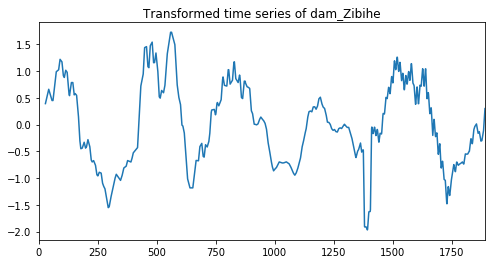

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001267      0.000255         0.000640        0.000019           0    0.0001           0.490882           0.332734           0.720178          -0.087823           0.474910         0.386176        0.267554                5
1       0.001280      0.000205         0.000625        0.000006         0.5    0.0001           0.490903           0.334338           0.720033          -0.085551           0.474935         0.386932        0.266652                4
2       0.001269      0.000201         0.000620        0.000003           1    0.0001           0.490824           0.335767           0.719887          -0.083408           0.474957         0.387605        0.265796                3
3       0.001647      0.000689         0.000652        0.000037           2    0.0001           0.490552           0.338245           0.719592          -0.079452           0.474995         0.388786        0.264205                2
4       0.001297      0.000193         0.000621        0.000003          10    0.0001           0.487146           0.350633           0.717286          -0.056805           0.475029         0.394658        0.254896                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.115022      0.079231         0.007401        0.002333     0.1             2000            2           0.1       linear           0.469034           0.287364           0.697019          -0.190674           0.402166         0.332982        0.293978                5
1        0.070668      0.053982         0.011538        0.005317     0.1             2000            2           0.1          rbf           0.191873           0.366459           0.660231           0.288069           0.364731         0.374272        0.156605                1
2        0.061568      0.047595         0.008158        0.003705     0.1             2000            2           0.1         poly          -0.650587          -0.599001          -0.118851          -1.660735          -0.006163        -0.607067        0.585084               26
3        0.038163      0.025763         0.001368        0.000479     0.1             2000            2             1       linear           0.430468           0.245221           0.544004           0.045527           0.284186         0.309881        0.169752               11
4        0.013298      0.008128         0.002273        0.000747     0.1             2000            2             1          rbf           0.165703           0.273722           0.548943           0.201285           0.189295         0.275790        0.141258               17
5        0.022044      0.016671         0.002841        0.000974     0.1             2000            2             1         poly          -0.254415          -0.133589          -0.316538          -1.069982          -0.174045        -0.389714        0.345988               25
6        0.108855      0.084736         0.006619        0.002910     0.1             2000            3           0.1       linear           0.469034           0.287364           0.697019          -0.190674           0.402166         0.332982        0.293978                5
7        0.068953      0.051216         0.010963        0.004794     0.1             2000            3           0.1          rbf           0.191873           0.366459           0.660231           0.288069           0.364731         0.374272        0.156605                1
8        0.068856      0.052646         0.007388        0.003089     0.1             2000            3           0.1         poly           0.227300          -0.088469           0.156725         -21.597805           0.208721        -4.218706        8.690287               31
9        0.035529      0.023681         0.001258        0.000413     0.1             2000            3             1       linear           0.430468           0.245221           0.544004           0.045527           0.284186         0.309881        0.169752               11
10       0.012861      0.008251         0.002233        0.000791     0.1             2000            3             1          rbf           0.165703           0.273722           0.548943           0.201285           0.189295         0.275790        0.141258               17
11       0.022400      0.016523         0.002042        0.000721     0.1             2000            3             1         poly           0.219171           0.115176          -0.008378         -12.496195           0.167574        -2.400530        5.048398               29
12       0.444446      0.417791         0.006156        0.002747       1             2000            2           0.1       linear           0.470895           0.263343           0.699622          -0.221543           0.400027         0.322469        0.306508                7
13       0.080158      0.059148         0.010621        0.004887       1             2000            2           0.1          rbf           0.248223      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001864      0.000477         0.000665        0.000015           0    0.0001           0.191743           0.289865           0.759022          -0.032045           0.480343         0.337785        0.267643                5
1       0.001919      0.000436         0.000669        0.000018         0.5    0.0001           0.197883           0.295325           0.759641          -0.026522           0.480438         0.341353        0.265459                4
2       0.001911      0.000413         0.000658        0.000005           1    0.0001           0.201858           0.299108           0.760037          -0.022167           0.480526         0.343873        0.263827                3
3       0.001854      0.000418         0.000648        0.000007           2    0.0001           0.208343           0.304498           0.760519          -0.015117           0.480687         0.347786        0.261162                2
4       0.001842      0.000413         0.000651        0.000009          10    0.0001           0.241902           0.324851           0.760745           0.018623           0.481509         0.365526        0.247762                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.227171      0.163406         0.013517        0.004804     0.1             2000            2           0.1       linear           0.231873           0.300416           0.774030          -0.021026           0.452175         0.347494        0.262405                3
1        0.101940      0.078820         0.019504        0.009026     0.1             2000            2           0.1          rbf           0.201482           0.420554           0.665409           0.308963           0.395298         0.398341        0.153993                1
2        0.081590      0.063529         0.014342        0.006566     0.1             2000            2           0.1         poly          -0.448316          -0.475110           0.007464          -0.125937          -0.246258        -0.257631        0.185152               29
3        0.046537      0.029578         0.002382        0.001039     0.1             2000            2             1       linear           0.426282           0.148805           0.563240          -0.024559           0.353118         0.293377        0.207867               11
4        0.017992      0.010702         0.003734        0.001072     0.1             2000            2             1          rbf           0.188630           0.156494           0.540659           0.227326           0.252391         0.273100        0.137727               13
5        0.026504      0.017400         0.004843        0.001627     0.1             2000            2             1         poly          -0.687590           0.002369          -0.201427          -0.035342          -0.238191        -0.232036        0.245821               28
6        0.205378      0.159119         0.012240        0.006241     0.1             2000            3           0.1       linear           0.231873           0.300416           0.774030          -0.021026           0.452175         0.347494        0.262405                3
7        0.093907      0.072479         0.018344        0.008505     0.1             2000            3           0.1          rbf           0.201482           0.420554           0.665409           0.308963           0.395298         0.398341        0.153993                1
8        0.098242      0.076435         0.013797        0.006577     0.1             2000            3           0.1         poly           0.309941           0.025975           0.213707          -1.194634           0.266116        -0.075779        0.567744               24
9        0.044154      0.027210         0.002141        0.000890     0.1             2000            3             1       linear           0.426282           0.148805           0.563240          -0.024559           0.353118         0.293377        0.207867               11
10       0.016520      0.009624         0.003392        0.000918     0.1             2000            3             1          rbf           0.188630           0.156494           0.540659           0.227326           0.252391         0.273100        0.137727               13
11       0.029274      0.021261         0.003345        0.001087     0.1             2000            3             1         poly           0.108274           0.153312          -0.095818          -0.372919           0.174306        -0.006569        0.206710               21
12       1.319608      0.981240         0.011627        0.005538       1             2000            2           0.1       linear           0.225014           0.278821           0.773187          -0.053223           0.450451         0.334850        0.272509                7
13       0.102244      0.075890         0.016546        0.008038       1             2000            2           0.1          rbf           0.208727      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001328      0.000236         0.000649        0.000023           0    0.0001           0.392458           0.080516           0.482314           0.253952           0.423068         0.326461        0.144031                5
1       0.001340      0.000214         0.000634        0.000008         0.5    0.0001           0.394539           0.082921           0.482652           0.254064           0.423136         0.327462        0.143474                4
2       0.001320      0.000214         0.000641        0.000015           1    0.0001           0.396255           0.085176           0.482976           0.254172           0.423200         0.328356        0.142935                3
3       0.001342      0.000187         0.000644        0.000017           2    0.0001           0.399052           0.089315           0.483583           0.254380           0.423318         0.329930        0.141924                2
4       0.001313      0.000213         0.000630        0.000013          10    0.0001           0.411805           0.112834           0.487140           0.255679           0.423893         0.338270        0.136047                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.118305      0.067956         0.007447        0.002167     0.1             2000            2           0.1       linear           0.396266           0.117616           0.524785           0.264401           0.400531         0.340720        0.138667                1
1        0.075246      0.059964         0.012364        0.005820     0.1             2000            2           0.1          rbf           0.238263          -0.022423           0.651354           0.268958           0.299485         0.287128        0.215106                7
2        0.063308      0.050194         0.008397        0.003696     0.1             2000            2           0.1         poly          -0.369332          -0.241675           0.040247          -0.067003          -0.172410        -0.162034        0.140976               31
3        0.035422      0.018916         0.001658        0.000511     0.1             2000            2             1       linear           0.384592          -0.078795           0.295779           0.243446           0.360362         0.241077        0.167416               10
4        0.013806      0.008214         0.002445        0.000705     0.1             2000            2             1          rbf           0.178885          -0.273230           0.212948           0.220937           0.211047         0.110118        0.192211               21
5        0.019609      0.012759         0.003008        0.001118     0.1             2000            2             1         poly          -0.701383          -0.054842          -0.171746           0.009594          -0.185268        -0.220729        0.251099               33
6        0.117398      0.079972         0.007144        0.003214     0.1             2000            3           0.1       linear           0.396266           0.117616           0.524785           0.264401           0.400531         0.340720        0.138667                1
7        0.073450      0.057526         0.012602        0.005765     0.1             2000            3           0.1          rbf           0.238263          -0.022423           0.651354           0.268958           0.299485         0.287128        0.215106                7
8        0.091889      0.067461         0.010115        0.005497     0.1             2000            3           0.1         poly           0.298475          -0.005358           0.177518           0.194434           0.286114         0.190237        0.108945               19
9        0.038838      0.022172         0.001872        0.000665     0.1             2000            3             1       linear           0.384592          -0.078795           0.295779           0.243446           0.360362         0.241077        0.167416               10
10       0.014260      0.007654         0.002531        0.000571     0.1             2000            3             1          rbf           0.178885          -0.273230           0.212948           0.220937           0.211047         0.110118        0.192211               21
11       0.023868      0.018905         0.002168        0.000597     0.1             2000            3             1         poly           0.167735           0.111043          -0.101752           0.178318           0.156005         0.102270        0.104554               25
12       0.563538      0.384538         0.007704        0.003576       1             2000            2           0.1       linear           0.376646           0.091056           0.526971           0.261330           0.399516         0.331104        0.146704                3
13       0.087140      0.060570         0.011861        0.005191       1             2000            2           0.1          rbf           0.356518      

>>> Final results:



period = 30, future = 10, Node: dam_Gongguoqiao, neighbors: ['dam_Xiaowan']


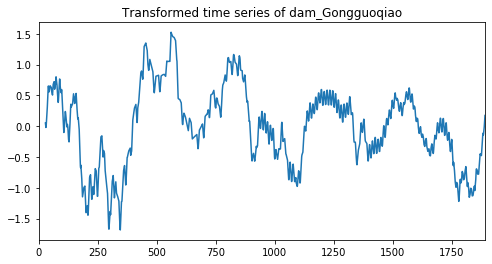

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003053      0.003715         0.000631        0.000012           0    0.0001          -0.064115           0.512615           0.529057           0.555527           0.407169         0.388051        0.231632                5
1       0.002835      0.003217         0.000623        0.000006         0.5    0.0001          -0.063488           0.512534           0.529026           0.555494           0.407212         0.388156        0.231371                4
2       0.003884      0.003941         0.000645        0.000020           1    0.0001          -0.062897           0.512453           0.528994           0.555461           0.407254         0.388253        0.231123                3
3       0.002835      0.003104         0.000627        0.000012           2    0.0001          -0.061804           0.512290           0.528929           0.555393           0.407334         0.388429        0.230663                2
4       0.003332      0.004030         0.000630        0.000018          10    0.0001          -0.055474           0.510935           0.528359           0.554783           0.407852         0.389291        0.227897                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.134120      0.083357         0.007355        0.001904     0.1             2000            2           0.1       linear          -0.035170           0.538537           0.483310           0.494642           0.352924         0.366848        0.210326                1
1        0.073117      0.055800         0.012323        0.005238     0.1             2000            2           0.1          rbf          -0.150388           0.438657           0.499130           0.499765           0.371886         0.331810        0.245659               15
2        0.063196      0.049437         0.008488        0.003806     0.1             2000            2           0.1         poly          -0.832297          -0.013902          -0.123176           0.168365          -0.955885        -0.351379        0.454491               34
3        0.042214      0.022818         0.001938        0.000429     0.1             2000            2             1       linear          -0.019387           0.386176           0.480613           0.491226           0.424503         0.352626        0.189882                7
4        0.020763      0.012377         0.003923        0.000849     0.1             2000            2             1          rbf          -0.192127           0.183335           0.371689           0.361904           0.364379         0.217836        0.216869               19
5        0.022652      0.015401         0.003304        0.000946     0.1             2000            2             1         poly          -1.490676          -0.113434           0.021534           0.120454          -0.312843        -0.354993        0.586127               35
6        0.128183      0.087919         0.006715        0.002738     0.1             2000            3           0.1       linear          -0.035170           0.538537           0.483310           0.494642           0.352924         0.366848        0.210326                1
7        0.068749      0.051048         0.011736        0.004672     0.1             2000            3           0.1          rbf          -0.150388           0.438657           0.499130           0.499765           0.371886         0.331810        0.245659               15
8        0.066452      0.049654         0.007495        0.003225     0.1             2000            3           0.1         poly          -0.464020           0.241075           0.129436           0.369169           0.086880         0.072508        0.285563               24
9        0.041268      0.023335         0.001858        0.000458     0.1             2000            3             1       linear          -0.019387           0.386176           0.480613           0.491226           0.424503         0.352626        0.189882                7
10       0.019079      0.011146         0.003662        0.000758     0.1             2000            3             1          rbf          -0.192127           0.183335           0.371689           0.361904           0.364379         0.217836        0.216869               19
11       0.028153      0.021423         0.002599        0.000637     0.1             2000            3             1         poly          -0.258518           0.023823           0.142460           0.109231           0.142413         0.031882        0.151542               28
12       0.579470      0.404638         0.006185        0.002525       1             2000            2           0.1       linear          -0.038395           0.535181           0.481560           0.494586           0.351859         0.364958        0.210827                3
13       0.087351      0.062470         0.011222        0.004996       1             2000            2           0.1          rbf          -0.040039      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.006052      0.001748         0.001072        0.000053           0    0.0001          -0.142279           0.352486           0.504805           0.541442           0.374939         0.326279        0.245262                5
1       0.004671      0.000773         0.000976        0.000015         0.5    0.0001          -0.135097           0.354539           0.504784           0.541548           0.375090         0.328173        0.242584                4
2       0.004653      0.000826         0.000995        0.000059           1    0.0001          -0.129028           0.356438           0.504763           0.541642           0.375234         0.329810        0.240327                3
3       0.009024      0.005036         0.002699        0.002070           2    0.0001          -0.119167           0.359888           0.504718           0.541799           0.375507         0.332549        0.236672                2
4       0.006065      0.003381         0.001290        0.000700          10    0.0001          -0.080389           0.379640           0.504300           0.542318           0.377197         0.344613        0.222487                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.233694      0.149953         0.013654        0.004386     0.1             2000            2           0.1       linear          -0.061496           0.557846           0.508360           0.536904           0.353471         0.379017        0.231665                1
1        0.105457      0.079231         0.021237        0.009096     0.1             2000            2           0.1          rbf          -0.243346           0.384949           0.493486           0.616487           0.392561         0.328827        0.298146                9
2        0.084294      0.065403         0.015009        0.007109     0.1             2000            2           0.1         poly          -0.699592           0.050219          -0.076127           0.017402          -0.696238        -0.280867        0.343035               32
3        0.059080      0.032016         0.003614        0.000907     0.1             2000            2             1       linear          -0.057005           0.299454           0.329606          -0.050185           0.241390         0.152652        0.170784               14
4        0.029997      0.017150         0.006578        0.001295     0.1             2000            2             1          rbf          -0.319376           0.209242           0.365047           0.205444           0.350965         0.162264        0.250111               12
5        0.029733      0.022213         0.005230        0.001769     0.1             2000            2             1         poly          -1.312376          -0.119917           0.013059          -0.188572          -0.251445        -0.371850        0.478394               33
6        0.212339      0.144540         0.011829        0.005046     0.1             2000            3           0.1       linear          -0.061496           0.557846           0.508360           0.536904           0.353471         0.379017        0.231665                1
7        0.101657      0.079822         0.019997        0.008906     0.1             2000            3           0.1          rbf          -0.243346           0.384949           0.493486           0.616487           0.392561         0.328827        0.298146                9
8        0.091473      0.066875         0.014222        0.006398     0.1             2000            3           0.1         poly          -0.408075           0.243711           0.029748           0.252893          -0.009521         0.021751        0.240202               25
9        0.056393      0.031116         0.003358        0.000847     0.1             2000            3             1       linear          -0.057005           0.299454           0.329606          -0.050185           0.241390         0.152652        0.170784               14
10       0.028573      0.015846         0.006314        0.001134     0.1             2000            3             1          rbf          -0.319376           0.209242           0.365047           0.205444           0.350965         0.162264        0.250111               12
11       0.036742      0.026527         0.004883        0.001466     0.1             2000            3             1         poly          -0.274467          -0.053761           0.041928           0.118051           0.128930        -0.007864        0.148479               26
12       1.445461      0.896533         0.011868        0.004973       1             2000            2           0.1       linear          -0.109607           0.556576           0.507914           0.535764           0.347812         0.367692        0.249719                3
13       0.115323      0.087296         0.018824        0.008132       1             2000            2           0.1          rbf          -0.270258      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001313      0.000260         0.000651        0.000013           0    0.0001          -0.190760          -0.070860           0.027852          -0.390870          -0.007020        -0.126332        0.151800                5
1       0.001326      0.000191         0.000640        0.000006         0.5    0.0001          -0.179985          -0.065999           0.028448          -0.390099          -0.006813        -0.122890        0.151178                4
2       0.001352      0.000216         0.000642        0.000013           1    0.0001          -0.170507          -0.061428           0.029029          -0.389334          -0.006613        -0.119771        0.150724                3
3       0.001337      0.000189         0.000665        0.000051           2    0.0001          -0.154509          -0.053034           0.030154          -0.387826          -0.006236        -0.114290        0.150154                2
4       0.001296      0.000208         0.000628        0.000008          10    0.0001          -0.088745          -0.006922           0.037675          -0.376654          -0.004019        -0.087733        0.150161                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.107050      0.062757         0.007918        0.002356     0.1             2000            2           0.1       linear          -0.224945          -0.016017           0.033302          -0.202118          -0.181588        -0.118273        0.105687               10
1        0.077737      0.060870         0.013263        0.006201     0.1             2000            2           0.1          rbf          -0.346512           0.134929           0.057606           0.071229          -0.034794        -0.023508        0.170362                1
2        0.061233      0.047856         0.008013        0.003515     0.1             2000            2           0.1         poly          -0.663252           0.017755          -0.084848          -0.218322          -0.794229        -0.348579        0.321976               29
3        0.049184      0.027048         0.002770        0.000734     0.1             2000            2             1       linear          -0.020341          -0.013517          -0.023139          -0.517630           0.044736        -0.105978        0.207324                7
4        0.024501      0.016358         0.004554        0.001343     0.1             2000            2             1          rbf          -0.509636           0.067993           0.090307          -0.018286           0.172630        -0.039399        0.242850                3
5        0.022885      0.016335         0.003265        0.001137     0.1             2000            2             1         poly          -1.131991          -0.152045           0.020323          -0.148600          -0.227626        -0.327988        0.410110               28
6        0.101528      0.070752         0.007457        0.003412     0.1             2000            3           0.1       linear          -0.224945          -0.016017           0.033302          -0.202118          -0.181588        -0.118273        0.105687               10
7        0.077519      0.060805         0.012726        0.005636     0.1             2000            3           0.1          rbf          -0.346512           0.134929           0.057606           0.071229          -0.034794        -0.023508        0.170362                1
8        0.073356      0.053547         0.007453        0.003361     0.1             2000            3           0.1         poly          -0.220722           0.168531          -0.056461          -0.168170          -0.432965        -0.141958        0.197631               16
9        0.044006      0.025184         0.002361        0.000624     0.1             2000            3             1       linear          -0.020341          -0.013517          -0.023139          -0.517630           0.044736        -0.105978        0.207324                7
10       0.022562      0.014999         0.004202        0.001215     0.1             2000            3             1          rbf          -0.509636           0.067993           0.090307          -0.018286           0.172630        -0.039399        0.242850                3
11       0.030285      0.020706         0.003099        0.000963     0.1             2000            3             1         poly          -0.343001          -0.176188          -0.012500          -0.125682          -0.028390        -0.137152        0.119496               15
12       0.401604      0.243373         0.006887        0.002832       1             2000            2           0.1       linear          -0.337142          -0.074169           0.028638          -0.215598          -0.188370        -0.157328        0.125053               19
13       0.083400      0.062204         0.011572        0.005351       1             2000            2           0.1          rbf          -0.530368      

>>> Final results:



period = 30, future = 10, Node: dam_Xiaowan, neighbors: ['dam_Haixihai', 'dam_Zibihe', 'dam_Gongguoqiao', 'dam_Manwan']


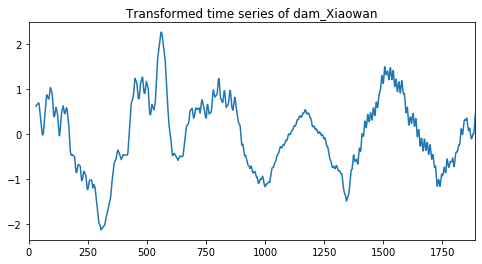

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.001285      0.000257         0.000646        0.000018           0    0.0001           0.178368           0.337534           0.719164           0.702081           0.375756         0.462581        0.213142                5
1       0.001295      0.000203         0.000630        0.000006         0.5    0.0001           0.181324           0.339886           0.719095           0.702073           0.376088         0.463693        0.212033                4
2       0.001291      0.000199         0.000626        0.000004           1    0.0001           0.183785           0.342098           0.719023           0.702061           0.376410         0.464675        0.211073                3
3       0.001385      0.000321         0.000640        0.000022           2    0.0001           0.187830           0.346172           0.718871           0.702030           0.377027         0.466386        0.209431                2
4       0.001632      0.000509         0.000647        0.000022          10    0.0001           0.206335           0.369511           0.717499           0.701510           0.380967         0.475165        0.201128                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.146907      0.097956         0.007290        0.002055     0.1             2000            2           0.1       linear           0.204798           0.371365           0.709117           0.706972           0.316761         0.461803        0.208106                1
1        0.076642      0.057748         0.012391        0.005346     0.1             2000            2           0.1          rbf          -0.452413           0.549091           0.532555           0.620051           0.290654         0.307988        0.396095               13
2        0.060427      0.047685         0.008017        0.003952     0.1             2000            2           0.1         poly          -1.254446          -0.200976           0.022360          -0.230917          -0.391747        -0.411145        0.441840               31
3        0.037478      0.019938         0.001560        0.000420     0.1             2000            2             1       linear           0.189405           0.397833           0.582860           0.666979           0.294842         0.426384        0.177002                7
4        0.018604      0.011634         0.003246        0.000907     0.1             2000            2             1          rbf          -0.099932           0.401297           0.065881           0.612552           0.131864         0.222332        0.253305               19
5        0.020249      0.015187         0.002859        0.001074     0.1             2000            2             1         poly          -1.508405           0.047523          -0.275826          -0.117238          -0.481438        -0.467077        0.549245               32
6        0.138252      0.102557         0.006434        0.002793     0.1             2000            3           0.1       linear           0.204798           0.371365           0.709117           0.706972           0.316761         0.461803        0.208106                1
7        0.069999      0.051576         0.011737        0.005110     0.1             2000            3           0.1          rbf          -0.452413           0.549091           0.532555           0.620051           0.290654         0.307988        0.396095               13
8        0.088720      0.070543         0.007631        0.003772     0.1             2000            3           0.1         poly           0.087575           0.040375           0.126842           0.367272           0.273534         0.179120        0.122212               21
9        0.034203      0.018744         0.001315        0.000380     0.1             2000            3             1       linear           0.189405           0.397833           0.582860           0.666979           0.294842         0.426384        0.177002                7
10       0.017378      0.010753         0.002942        0.000856     0.1             2000            3             1          rbf          -0.099932           0.401297           0.065881           0.612552           0.131864         0.222332        0.253305               19
11       0.026739      0.017923         0.002263        0.000798     0.1             2000            3             1         poly          -0.004155           0.182273           0.054547           0.347532           0.171271         0.150294        0.121151               24
12       0.551803      0.355705         0.006064        0.002584       1             2000            2           0.1       linear           0.198184           0.351606           0.708994           0.706524           0.309298         0.454921        0.212439                3
13       0.083926      0.062057         0.010599        0.004844       1             2000            2           0.1          rbf          -0.278020      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004424      0.001639         0.000795        0.000046           0    0.0001          -1.903501           0.185792           0.575642           0.429947           0.335116        -0.075401        0.922814                5
1       0.004539      0.001330         0.000770        0.000014         0.5    0.0001          -1.409546           0.196772           0.577699           0.439752           0.336683         0.028272        0.729660                4
2       0.004464      0.001380         0.000752        0.000024           1    0.0001          -1.293510           0.204179           0.579066           0.447964           0.338124         0.055165        0.685559                3
3       0.004466      0.001377         0.000749        0.000031           2    0.0001          -1.191969           0.214548           0.580781           0.461412           0.340721         0.081099        0.648110                2
4       0.004460      0.001373         0.000752        0.000024          10    0.0001          -0.934997           0.248322           0.583321           0.516224           0.355073         0.153589        0.556914                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.679955      0.482064         0.036910        0.015536     0.1             2000            2           0.1       linear          -0.943590           0.174628           0.699097           0.638349           0.356234         0.184944        0.595477                3
1        0.182791      0.138400         0.043323        0.018713     0.1             2000            2           0.1          rbf          -0.545618           0.288570           0.558353           0.577529           0.381456         0.252058        0.413307                1
2        0.171726      0.134965         0.038301        0.018350     0.1             2000            2           0.1         poly          -1.293891          -0.164125           0.092515          -0.240546          -0.136758        -0.348561        0.485539               31
3        0.105897      0.065312         0.007245        0.002876     0.1             2000            2             1       linear           0.059999          -0.127056           0.433693           0.192997           0.305594         0.173045        0.194291                5
4        0.046530      0.030256         0.011243        0.003974     0.1             2000            2             1          rbf          -0.104821           0.105476           0.067857           0.495102           0.137532         0.140230        0.196182                7
5        0.055195      0.041869         0.012700        0.005159     0.1             2000            2             1         poly          -1.452609          -0.145642          -0.429962          -0.149294          -0.307417        -0.496985        0.489485               32
6        0.629671      0.464244         0.035045        0.015560     0.1             2000            3           0.1       linear          -0.943590           0.174628           0.699097           0.638349           0.356234         0.184944        0.595477                3
7        0.183054      0.138143         0.043162        0.018729     0.1             2000            3           0.1          rbf          -0.545618           0.288570           0.558353           0.577529           0.381456         0.252058        0.413307                1
8        0.172226      0.134613         0.036375        0.017215     0.1             2000            3           0.1         poly          -0.065619          -0.023632           0.135908           0.223165           0.217174         0.097399        0.120722               10
9        0.104368      0.064091         0.007108        0.002867     0.1             2000            3             1       linear           0.059999          -0.127056           0.433693           0.192997           0.305594         0.173045        0.194291                5
10       0.046133      0.029982         0.011086        0.003876     0.1             2000            3             1          rbf          -0.104821           0.105476           0.067857           0.495102           0.137532         0.140230        0.196182                7
11       0.048720      0.037103         0.009957        0.004370     0.1             2000            3             1         poly          -0.138041           0.130221          -0.209930           0.222627           0.085126         0.018001        0.164483               15
12       5.684031      4.004086         0.035447        0.015446       1             2000            2           0.1       linear          -2.043436           0.134854           0.702030           0.598737           0.348599        -0.051843        1.015208               20
13       0.196882      0.144738         0.040779        0.017692       1             2000            2           0.1          rbf          -0.746311      

Exclusive data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.004950      0.003165         0.000729        0.000029           0    0.0001          -5.343426           0.169998           0.162745          -0.003349           0.283969        -0.946013        2.200615                5
1       0.006885      0.004461         0.002872        0.004280         0.5    0.0001          -5.014473           0.171819           0.162834           0.005959           0.285067        -0.877759        2.070264                4
2       0.006682      0.004738         0.000709        0.000031           1    0.0001          -4.800756           0.173417           0.162854           0.013689           0.286069        -0.832945        1.985794                3
3       0.006693      0.004739         0.000719        0.000026           2    0.0001          -4.449395           0.176184           0.162794           0.026228           0.287851        -0.759268        1.846931                2
4       0.007223      0.005552         0.000717        0.000042          10    0.0001          -2.760709           0.190030           0.161635           0.080097           0.297325        -0.406324        1.179243                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.446921      0.278975         0.031538        0.013916     0.1             2000            2           0.1       linear          -2.156754           0.063127           0.145738          -0.004720           0.266751        -0.337172        0.914283               22
1        0.174015      0.132702         0.039301        0.017038     0.1             2000            2           0.1          rbf          -0.560008           0.144833           0.176464           0.294539           0.292446         0.069655        0.320545                1
2        0.142769      0.111455         0.030746        0.014500     0.1             2000            2           0.1         poly          -1.390140          -0.218237          -0.117301          -0.098150          -0.112592        -0.387284        0.503238               24
3        0.107388      0.074617         0.006928        0.002867     0.1             2000            2             1       linear          -0.048473          -0.049667           0.013180           0.141024           0.285710         0.068355        0.128954                3
4        0.045408      0.032440         0.010658        0.004761     0.1             2000            2             1          rbf          -0.110181          -0.009651          -0.300217           0.299536           0.154670         0.006831        0.207738                6
5        0.048039      0.036565         0.010583        0.004344     0.1             2000            2             1         poly          -1.392000          -0.210946          -0.715917          -0.073293          -0.262693        -0.530970        0.481546               27
6        0.401124      0.268424         0.028587        0.013251     0.1             2000            3           0.1       linear          -2.156754           0.063127           0.145738          -0.004720           0.266751        -0.337172        0.914283               22
7        0.165584      0.126661         0.038138        0.017611     0.1             2000            3           0.1          rbf          -0.560008           0.144833           0.176464           0.294539           0.292446         0.069655        0.320545                1
8        0.142835      0.112259         0.028535        0.013619     0.1             2000            3           0.1         poly          -0.096932          -0.025416           0.094674           0.110204           0.147594         0.046025        0.092024                5
9        0.105315      0.071271         0.007053        0.002941     0.1             2000            3             1       linear          -0.048473          -0.049667           0.013180           0.141024           0.285710         0.068355        0.128954                3
10       0.045688      0.032514         0.010398        0.004460     0.1             2000            3             1          rbf          -0.110181          -0.009651          -0.300217           0.299536           0.154670         0.006831        0.207738                6
11       0.043514      0.034663         0.008129        0.003835     0.1             2000            3             1         poly          -0.165016           0.115161          -0.286369           0.139116           0.037939        -0.031834        0.166268               10
12       3.322882      1.935288         0.029876        0.014003       1             2000            2           0.1       linear          -2.523047           0.055659           0.155412          -0.146080           0.262061        -0.439199        1.050576               25
13       0.170974      0.125559         0.033587        0.014753       1             2000            2           0.1          rbf          -0.913544      

>>> Final results:



period = 30, future = 10, Node: dam_Manwan, neighbors: ['dam_Xiaowan', 'dam_Dachaoshan']


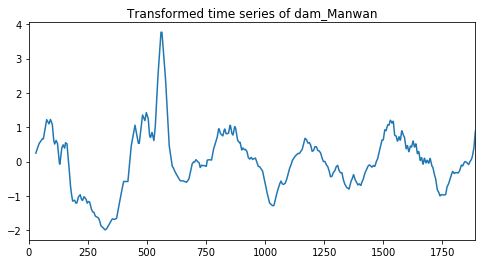

---------------------------------------------------------------
Self data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.003273      0.002894         0.000777        0.000250           0    0.0001           0.334751           0.076010           0.632290           0.522531           0.494630         0.412042        0.193095                5
1       0.001318      0.000192         0.000644        0.000009         0.5    0.0001           0.334535           0.077074           0.632225           0.522838           0.494617         0.412258        0.192762                4
2       0.001492      0.000404         0.000649        0.000018           1    0.0001           0.334250           0.078102           0.632158           0.523137           0.494604         0.412450        0.192445                3
3       0.001318      0.000197         0.000631        0.000004           2    0.0001           0.333569           0.080064           0.632023           0.523712           0.494573         0.412788        0.191853                2
4       0.001300      0.000200         0.000629        0.000003          10    0.0001           0.327444           0.092839           0.630901           0.527528           0.494240         0.414590        0.188153                1

>>> Regressor: SVR


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C param_cache_size param_degree param_epsilon param_kernel  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0        0.162678      0.102512         0.007238        0.002099     0.1             2000            2           0.1       linear           0.296956           0.017695           0.628698           0.507357           0.463295         0.382800        0.211249                7
1        0.073755      0.057204         0.011844        0.005510     0.1             2000            2           0.1          rbf          -0.155940           0.320074           0.511305           0.556746           0.425227         0.331482        0.256741               13
2        0.064653      0.049334         0.008372        0.003837     0.1             2000            2           0.1         poly          -3.869466          -1.603715          -0.001747          -0.104265          -0.018377        -1.119514        1.502619               28
3        0.047395      0.026643         0.001650        0.000418     0.1             2000            2             1       linear           0.437960           0.154161           0.504540           0.490086           0.460902         0.409530        0.129751                1
4        0.015654      0.009134         0.002720        0.000599     0.1             2000            2             1          rbf          -0.050214           0.052019          -0.031351           0.567862           0.343841         0.176432        0.241356               17
5        0.029423      0.020069         0.003479        0.001114     0.1             2000            2             1         poly          -2.346683          -1.355236          -0.029052          -0.257197          -0.015871        -0.800808        0.916992               25
6        0.155395      0.110366         0.006705        0.003141     0.1             2000            3           0.1       linear           0.296956           0.017695           0.628698           0.507357           0.463295         0.382800        0.211249                7
7        0.069723      0.053172         0.011103        0.004955     0.1             2000            3           0.1          rbf          -0.155940           0.320074           0.511305           0.556746           0.425227         0.331482        0.256741               13
8        0.082391      0.066798         0.007703        0.003484     0.1             2000            3           0.1         poly          -3.785261          -2.069761           0.135795           0.142519           0.090900        -1.097162        1.589988               27
9        0.044376      0.024955         0.001467        0.000361     0.1             2000            3             1       linear           0.437960           0.154161           0.504540           0.490086           0.460902         0.409530        0.129751                1
10       0.014486      0.008351         0.002490        0.000521     0.1             2000            3             1          rbf          -0.050214           0.052019          -0.031351           0.567862           0.343841         0.176432        0.241356               17
11       0.041001      0.030938         0.002750        0.001058     0.1             2000            3             1         poly          -4.948579          -0.998831           0.107549           0.058046           0.069466        -1.142470        1.948316               29
12       0.745419      0.479529         0.006179        0.002626       1             2000            2           0.1       linear           0.294219          -0.004671           0.629208           0.504789           0.464100         0.377529        0.219111                9
13       0.079376      0.058662         0.010722        0.005316       1             2000            2           0.1          rbf          -0.327870      

Neighborhood data
>>> Regressor: Ridge


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha param_tol  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score
0       0.002431      0.000785         0.000683        0.000037           0    0.0001           0.354373          -0.766995           0.630706           0.479014           0.509198         0.241259        0.511734                5
1       0.002450      0.000675         0.000677        0.000029         0.5    0.0001           0.362999          -0.724987           0.632901           0.483416           0.509685         0.252803        0.496359                4
2       0.002422      0.000643         0.000639        0.000013           1    0.0001           0.365596          -0.696423           0.634449           0.486871           0.510107         0.260120        0.485825                3
3       0.002323      0.000597         0.000626        0.000016           2    0.0001           0.368074          -0.652734           0.636564           0.492118           0.510813         0.270967        0.469627                2
4       0.003545      0.002764         0.000719        0.000170          10    0.0001           0.376498          -0.453515           0.643480           0.510593           0.513826         0.318176        0.394977                1

>>> Regressor: SVR


In [ ]:
%%time
for period in [15, 30, 90]:
    for future in [10]:
        for node in river_network.nodes:
            adj = river_network.adj[node]
            adj = list(map(lambda x: river_network.nodes[x]['attr']['name'], adj.keys()))
            node = river_network.nodes.get(node)['attr']['name']
            print(f'period = {period}, future = {future}, Node: {node}, neighbors: {adj}')
            plt.figure(figsize = (8, 4))
            df_transformed[node].rolling(30).mean().plot(use_index = True)
            plt.title(f'Transformed time series of {node}')
            plt.show()
            print('---------------------------------------------------------------')
            print('Self data')
            self_data = survey(df_transformed, node, [node], regressors, period, future)
            print('Neighborhood data')
            neighborhood_data = survey(df_transformed, node, [node] + adj, regressors, period, future)
            print('Exclusive data')
            exclusive_data = survey(df_transformed, node, adj, regressors, period, future)
            res = pd.concat([self_data, neighborhood_data, exclusive_data], axis = 0)
            res.index = ['Self data', 'Neighborhood data', 'Exclusive data']
            print('>>> Final results:')
            display(res.style.background_gradient(cmap='coolwarm', axis = None))
            print('===============================================================', end = '\n\n')